In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms



In [2]:


def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 自動建立資料夾



In [3]:
prefixs = [ "LoRA_Trigger", "LoRA_noTrigger", "noLoRA_Trigger", "noLoRA_noTrigger", 'SpaceShip', 'ComplexImg']



In [4]:
def rename_files():
    base_path = "..\\data\\input"
    for p in prefixs:
        folder_path = os.path.join(base_path, p)
        ensure_folder_exists(folder_path)
        counter = 0
        for file_name in os.listdir(folder_path):
            print(file_name)
            src = os.path.join(folder_path, file_name)
            dst = os.path.join(folder_path, p + "_" + str(counter) + ".png")
            os.rename(src, dst)
            counter += 1


In [5]:
rename_files()

RAT_nolora_00001_.png
RAT_nolora_00002_.png
RAT_nolora_00003_.png
RAT_nolora_00004_.png
RAT_nolora_00005_.png
RAT_nolora_00006_.png
RAT_nolora_00007_.png
RAT_nolora_00008_.png
RAT_nolora_00009_.png
RAT_nolora_00010_.png
RAT_nolora_00011_.png
RAT_nolora_00012_.png
RAT_nolora_00013_.png
RAT_nolora_00014_.png
RAT_nolora_00015_.png
RAT_nolora_00016_.png
RAT_nolora_00017_.png
RAT_nolora_00018_.png
RAT_nolora_00019_.png
RAT_nolora_00020_.png
RAT_nolora_00021_.png
RAT_nolora_00022_.png
RAT_nolora_00023_.png
RAT_nolora_00024_.png
RAT_nolora_00025_.png
RAT_nolora_00026_.png
RAT_nolora_00027_.png
RAT_nolora_00028_.png
RAT_nolora_00029_.png
RAT_nolora_00030_.png
RAT_nolora_00031_.png
RAT_nolora_00032_.png


In [4]:
# read api from json file
api = {}
with open("anaysis with LoRA api.json", "r") as f:
    api = f.read()
api = json.loads(api)

trigger_prompt = "zzMimikyu, solo, pokemon (creature), no humans, animal focus, mimikyu, "
object_prompt = "A cute white rat sitting on a tiny wooden chair, holding a piece of cheese with both hands, wearing a tiny red scarf, big shiny eyes, soft fluffy fur, in a cozy rustic kitchen with warm lighting, soft shadows, shallow depth of field, high detail, 4K resolution, Pixar-style, highly detailed, cinematic lighting, adorable expression"

In [5]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="dreamshaper_8.safetensors",
    LoRA="Mimikyu_Pokemon_PDXL.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [6]:
print(config.short_object_prompt)

A cute white rat sit


In [9]:
import json
import requests
def send_request(api):
    # 3. 設定 API 的 URL 與 headers
    url = 'http://127.0.0.1:8188/prompt'
    headers = {'Content-Type': 'application/json'}

    # 4. 發送 POST request 並傳送修改後的 JSON 資料
    response = requests.post(url, headers=headers, data=json.dumps(api))

    # 5. 輸出回應結果
    print(response.status_code)
    print(response.json())

In [14]:


def modify_api(api, config, counter = 0):
    api["prompt"]["3"]["inputs"]["ckpt_name"] = config.model
    api["prompt"]["2"]["inputs"]["lora_name"] = config.LoRA
    api["prompt"]["7"]["inputs"]["image"] = config.input_image
    api["prompt"]["4"]["inputs"]["text"] = config.trigger_prompt + config.object_prompt
    api["prompt"]["11"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}"
    api["prompt"]["15"]["inputs"]["filename_prefix"] = f"{config.file_prefix}/{config.short_object_prompt}/{config.input_image}/{config.current_step}@{counter}@"
    api["prompt"]["10"]["inputs"]["steps"] = config.total_steps
    api["prompt"]["10"]["inputs"]["denoise"] =  1-config.current_step/ config.total_steps
    api["prompt"]["1"]["inputs"]["start_at_step"] = config.current_step
    api["prompt"]["1"]["inputs"]["end_at_step"] = config.current_step + 1
    return api

In [15]:
import shutil
output_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [16]:
import shutil


generate_counter = 1

for prefix in prefixs:
    config.file_prefix = prefix
    # object_prompt = "a cute rat"
    # config.object_prompt = object_prompt
    for input_image in os.listdir(f"..\\..\\..\\myComfyUI\\input"):
        if prefix not in input_image:
            continue
        print(f"{prefix} {object_prompt} {input_image}")
        config.set_input_image(input_image)
        config.current_step = 0
        for i in range(20-1):
            config.current_step = i
            api = modify_api(api, config, generate_counter)
            generate_counter += 1
            send_request(api)
            print(f"{prefix} {object_prompt} {i} done")

ComplexImg A cute white rat sitting on a tiny wooden chair, holding a piece of cheese with both hands, wearing a tiny red scarf, big shiny eyes, soft fluffy fur, in a cozy rustic kitchen with warm lighting, soft shadows, shallow depth of field, high detail, 4K resolution, Pixar-style, highly detailed, cinematic lighting, adorable expression ComplexImg_0.png
200
{'prompt_id': 'd9d75e17-584c-41f1-b522-38669c7b798b', 'number': 94, 'node_errors': {}}
ComplexImg A cute white rat sitting on a tiny wooden chair, holding a piece of cheese with both hands, wearing a tiny red scarf, big shiny eyes, soft fluffy fur, in a cozy rustic kitchen with warm lighting, soft shadows, shallow depth of field, high detail, 4K resolution, Pixar-style, highly detailed, cinematic lighting, adorable expression 0 done
200
{'prompt_id': 'd924baa9-1d24-4cc3-94fe-77ad84b64b39', 'number': 95, 'node_errors': {}}
ComplexImg A cute white rat sitting on a tiny wooden chair, holding a piece of cheese with both hands, weari

200
{'prompt_id': 'e6332703-ab44-4d67-8ab5-5be461ee987c', 'number': 2027, 'node_errors': {}}


In [9]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"


In [ ]:

for prefix in os.listdir(data_folder):
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                
                if '@' in file_name:
                    index = file_name.split('@')[1]
                    print(index)
                    hspace_file = os.path.join(hspace_folder, index+".pkl")
                    destination = os.path.join(data_folder, prefix, prompt, image_name)
                    # if hspace file exist
                    if os.path.exists(hspace_file):
                        shutil.move(hspace_file, destination)
                    else:
                        print(f"{hspace_file} not exist")




        


1
11
12
13
14
15
16
17
18
19
2
3
4
5
6
7
8
9
10
20
30
31
32
33
34
35
36
37
38
21
22
23
24
25
26
27
28
29
39
49
50
51
52
53
54
55
56
57
40
41
42
43
44
45
46
47
48
58
68
69
70
71
72
73
74
75
76
59
60
61
62
63
64
65
66
67
77
87
88
89
90
91
92
93
94
95
78
79
80
81
82
83
84
85
86
96
106
107
108
109
110
111
112
113
114
97
98
99
100
101
102
103
104
105
115
125
126
127
128
129
130
131
132
133
116
117
118
119
120
121
122
123
124
134
144
145
146
147
148
149
150
151
152
135
136
137
138
139
140
141
142
143
153
163
164
165
166
167
168
169
170
171
154
155
156
157
158
159
160
161
162
172
182
183
184
185
186
187
188
189
190
173
174
175
176
177
178
179
180
181
191
201
202
203
204
205
206
207
208
209
192
193
194
195
196
197
198
199
200
210
220
221
222
223
224
225
226
227
228
211
212
213
214
215
216
217
218
219
229
239
240
241
242
243
244
245
246
247
230
231
232
233
234
235
236
237
238
248
258
259
260
261
262
263
264
265
266
249
250
251
252
253
254
255
256
257
267
277
278
279
280
281
282
283
284
285
268


In [10]:
class read_file():
    def __init__(self, file_path):
        pass

    def load_hspace_file(filepath):
        """讀取 .pkl 檔案，並將 numpy.ndarray 轉換為 numpy array"""
        with open(filepath, 'rb') as f:
            arr = pickle.load(f)
        return arr

    def load_latent_file(filepath):
        """利用 safetensors.torch 讀取 .latent 檔案，並取出 'latent_tensor'"""
        sd = safetensors.torch.load_file(filepath)
        return sd['latent_tensor'].numpy()

    def load_image_file(filepath):
        """讀取圖片檔案，並轉換為 numpy array"""
        img = PIL.Image.open(filepath)
        return np.array(img)


In [12]:
experiment_data = {}
for prefix in os.listdir(data_folder):
    experiment_data[prefix] = {}
    for prompt in os.listdir(os.path.join(data_folder, prefix)):
        experiment_data[prefix][prompt] = {}
        for image_name in os.listdir(os.path.join(data_folder, prefix, prompt)):
            experiment_data[prefix][prompt][image_name] = {}
            experiment_data[prefix][prompt][image_name]["hspace"] = []
            experiment_data[prefix][prompt][image_name]["image"] = []
            experiment_data[prefix][prompt][image_name]["latent"] = []

            start_index = 9999999999
            for file_name in os.listdir(os.path.join(data_folder, prefix, prompt, image_name)):
                if '@' in file_name:
                    print(file_name)
                    index = int(file_name.split('@')[1])
                    start_index = min(start_index, index)
            
            
            for i in range(20-1):
                hspace_file = os.path.join(data_folder, prefix, prompt, image_name, f"{start_index+i}.pkl")
                image_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}@{start_index+i}@_00001_.png")
                latent_file = os.path.join(data_folder, prefix, prompt, image_name, f"{i}_00001_.latent")

                if os.path.exists(hspace_file) and os.path.exists(image_file) and os.path.exists(latent_file):
                    experiment_data[prefix][prompt][image_name]["hspace"].append(read_file.load_hspace_file(hspace_file))
                    experiment_data[prefix][prompt][image_name]["image"].append(read_file.load_image_file(image_file))
                    experiment_data[prefix][prompt][image_name]["latent"].append(read_file.load_latent_file(latent_file))
                else:
                    if not os.path.exists(hspace_file):
                        print(f"{hspace_file} not exist")
                    if not os.path.exists(image_file):
                        print(f"{image_file} not exist")
                    if not os.path.exists(latent_file):
                        print(f"{latent_file} not exist")




0@1@_00001_.png
10@11@_00001_.png
11@12@_00001_.png
12@13@_00001_.png
13@14@_00001_.png
14@15@_00001_.png
15@16@_00001_.png
16@17@_00001_.png
17@18@_00001_.png
18@19@_00001_.png
1@2@_00001_.png
2@3@_00001_.png
3@4@_00001_.png
4@5@_00001_.png
5@6@_00001_.png
6@7@_00001_.png
7@8@_00001_.png
8@9@_00001_.png
9@10@_00001_.png
0@20@_00001_.png
10@30@_00001_.png
11@31@_00001_.png
12@32@_00001_.png
13@33@_00001_.png
14@34@_00001_.png
15@35@_00001_.png
16@36@_00001_.png
17@37@_00001_.png
18@38@_00001_.png
1@21@_00001_.png
2@22@_00001_.png
3@23@_00001_.png
4@24@_00001_.png
5@25@_00001_.png
6@26@_00001_.png
7@27@_00001_.png
8@28@_00001_.png
9@29@_00001_.png
0@39@_00001_.png
10@49@_00001_.png
11@50@_00001_.png
12@51@_00001_.png
13@52@_00001_.png
14@53@_00001_.png
15@54@_00001_.png
16@55@_00001_.png
17@56@_00001_.png
18@57@_00001_.png
1@40@_00001_.png
2@41@_00001_.png
3@42@_00001_.png
4@43@_00001_.png
5@44@_00001_.png
6@45@_00001_.png
7@46@_00001_.png
8@47@_00001_.png
9@48@_00001_.png
0@58@_00001_.

In [13]:
# turn experiment_data into numpy array
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        for image_name in experiment_data[prefix][prompt]:
            experiment_data[prefix][prompt][image_name]["hspace"] = np.array(experiment_data[prefix][prompt][image_name]["hspace"])
            experiment_data[prefix][prompt][image_name]["image"] = np.array(experiment_data[prefix][prompt][image_name]["image"])
            experiment_data[prefix][prompt][image_name]["latent"] = np.array(experiment_data[prefix][prompt][image_name]["latent"])

In [14]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['latent']))

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_0.png', 'LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['hspace', 'image', 'latent'])
19
19
19


In [15]:
# save experiment data
with open('experiment_data.pkl', 'wb') as f:
    pickle.dump(experiment_data, f)

In [18]:
# load experiment data
with open('experiment_data.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    

In [17]:
# replace last image data with random data
for prefix in experiment_data:
    for prompt in experiment_data[prefix]:
        last_image_name = list(experiment_data[prefix][prompt].keys())[-1]
        print(experiment_data[prefix][prompt][last_image_name]["image"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["latent"].shape)
        print(experiment_data[prefix][prompt][last_image_name]["hspace"].shape)
        print("*"*10)
        # as random data
        experiment_data[prefix][prompt][last_image_name]["image"] = np.random.rand(19, 512, 512, 3)
        experiment_data[prefix][prompt][last_image_name]["latent"] = np.random.rand(19, 1, 4, 64, 64)
        experiment_data[prefix][prompt][last_image_name]["hspace"] = np.random.rand(19, 2, 1280, 8, 8)

        second_last_image_name = list(experiment_data[prefix][prompt].keys())[-2]
        # as zero data
        experiment_data[prefix][prompt][second_last_image_name]["image"] = np.zeros((19, 512, 512, 3))
        experiment_data[prefix][prompt][second_last_image_name]["latent"] = np.zeros((19, 1, 4, 64, 64))
        experiment_data[prefix][prompt][second_last_image_name]["hspace"] = np.zeros((19, 2, 1280, 8, 8))


(19, 512, 512, 3)
(19, 1, 4, 64, 64)
(19, 2, 1280, 8, 8)
**********
(19, 512, 512, 3)
(19, 1, 4, 64, 64)
(19, 2, 1280, 8, 8)
**********
(19, 512, 512, 3)
(19, 1, 4, 64, 64)
(19, 2, 1280, 8, 8)
**********
(19, 512, 512, 3)
(19, 1, 4, 64, 64)
(19, 2, 1280, 8, 8)
**********
(19, 512, 512, 3)
(19, 1, 4, 64, 64)
(19, 2, 1280, 8, 8)
**********
(19, 512, 512, 3)
(19, 1, 4, 64, 64)
(19, 2, 1280, 8, 8)
**********


In [19]:
def normalize_experiment_data(experiment_data):
    normalized_data = {}
    for prefix in experiment_data.keys():
        normalized_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            normalized_data[prefix][prompt] = {}
            for image_name in experiment_data[prefix][prompt].keys():
                normalized_data[prefix][prompt][image_name] = {}
                for key in ["latent", "image", "hspace"]:
                    data = experiment_data[prefix][prompt][image_name][key]
                    min_val = np.min(data)
                    max_val = np.max(data)
                    normalized_data[prefix][prompt][image_name][key] = (data - min_val) / (max_val - min_val) if max_val != min_val else data
    return normalized_data

normalized_experiment_data = normalize_experiment_data(experiment_data)
experiment_data = normalized_experiment_data

In [20]:
print(experiment_data.keys())
print(experiment_data['LoRA_noTrigger'].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt].keys())
print(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png'].keys())
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['hspace']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['image']))
print(len(experiment_data['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_0.png']['latent']))

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_0.png', 'LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['latent', 'image', 'hspace'])
19
19
19


In [21]:
import numpy as np

def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [22]:
# see as different step

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(0, 20-1):
                        distance = euclidean(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data = {"L2_step": {}, "frechet_step": {}, "L1_step": {}}
anaysis_data["L2_step"] = calculate_euclidean_distance(experiment_data)

ComplexImg_0.png


LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png


In [23]:
print(anaysis_data["L2_step"].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt].keys())
print(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png'].keys())
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['hspace']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['image']))
print(len(anaysis_data["L2_step"]['LoRA_noTrigger'][config.short_object_prompt]['LoRA_noTrigger_1.png']['latent']))



dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])
dict_keys(['latent', 'image', 'hspace'])
19
19
19


dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


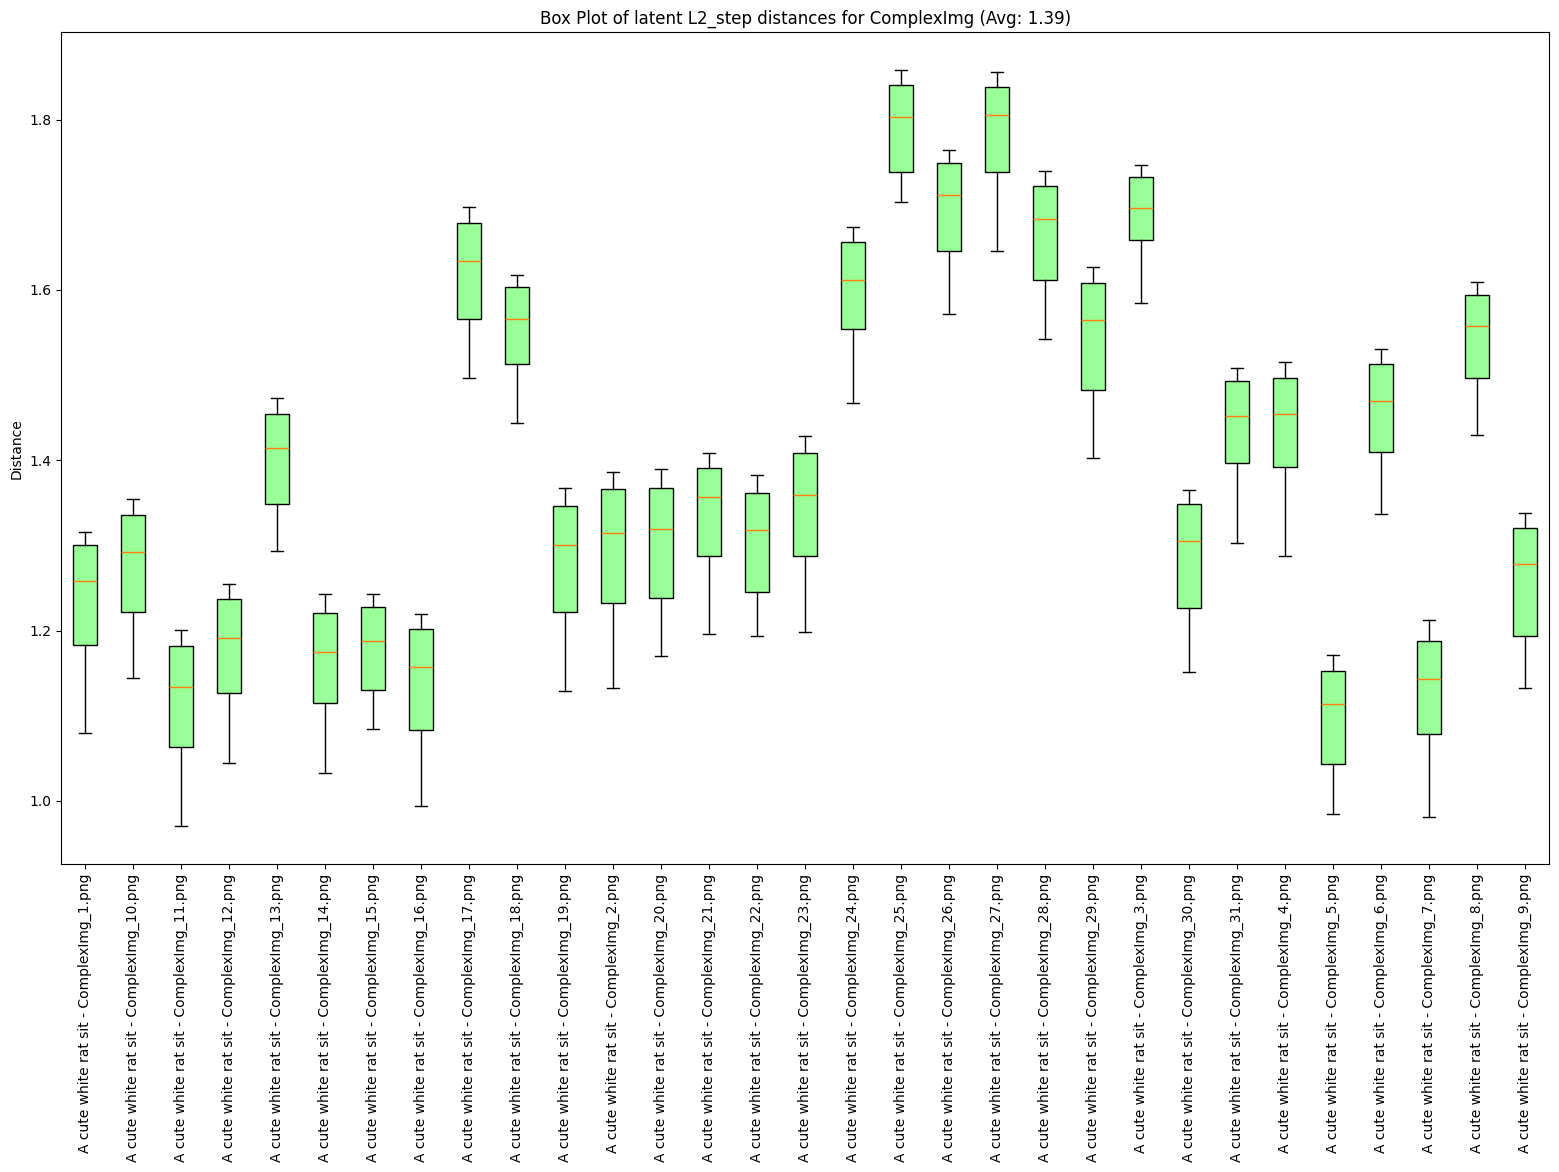

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


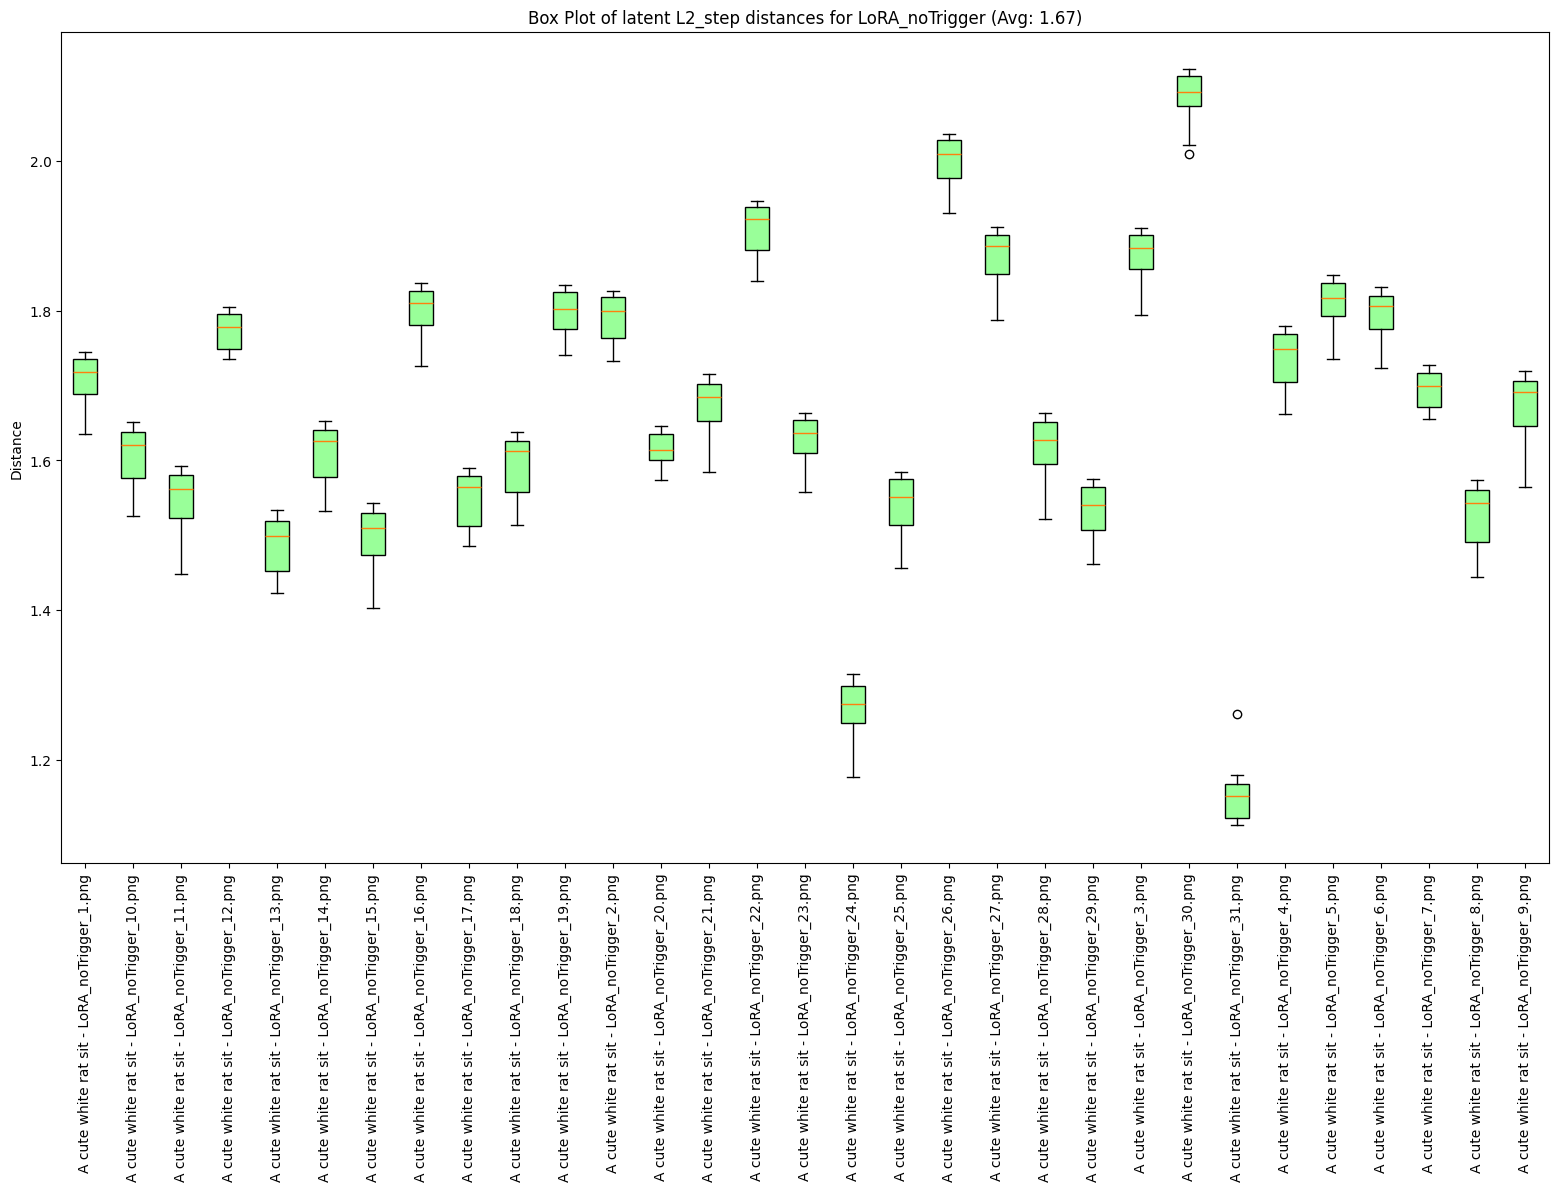

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


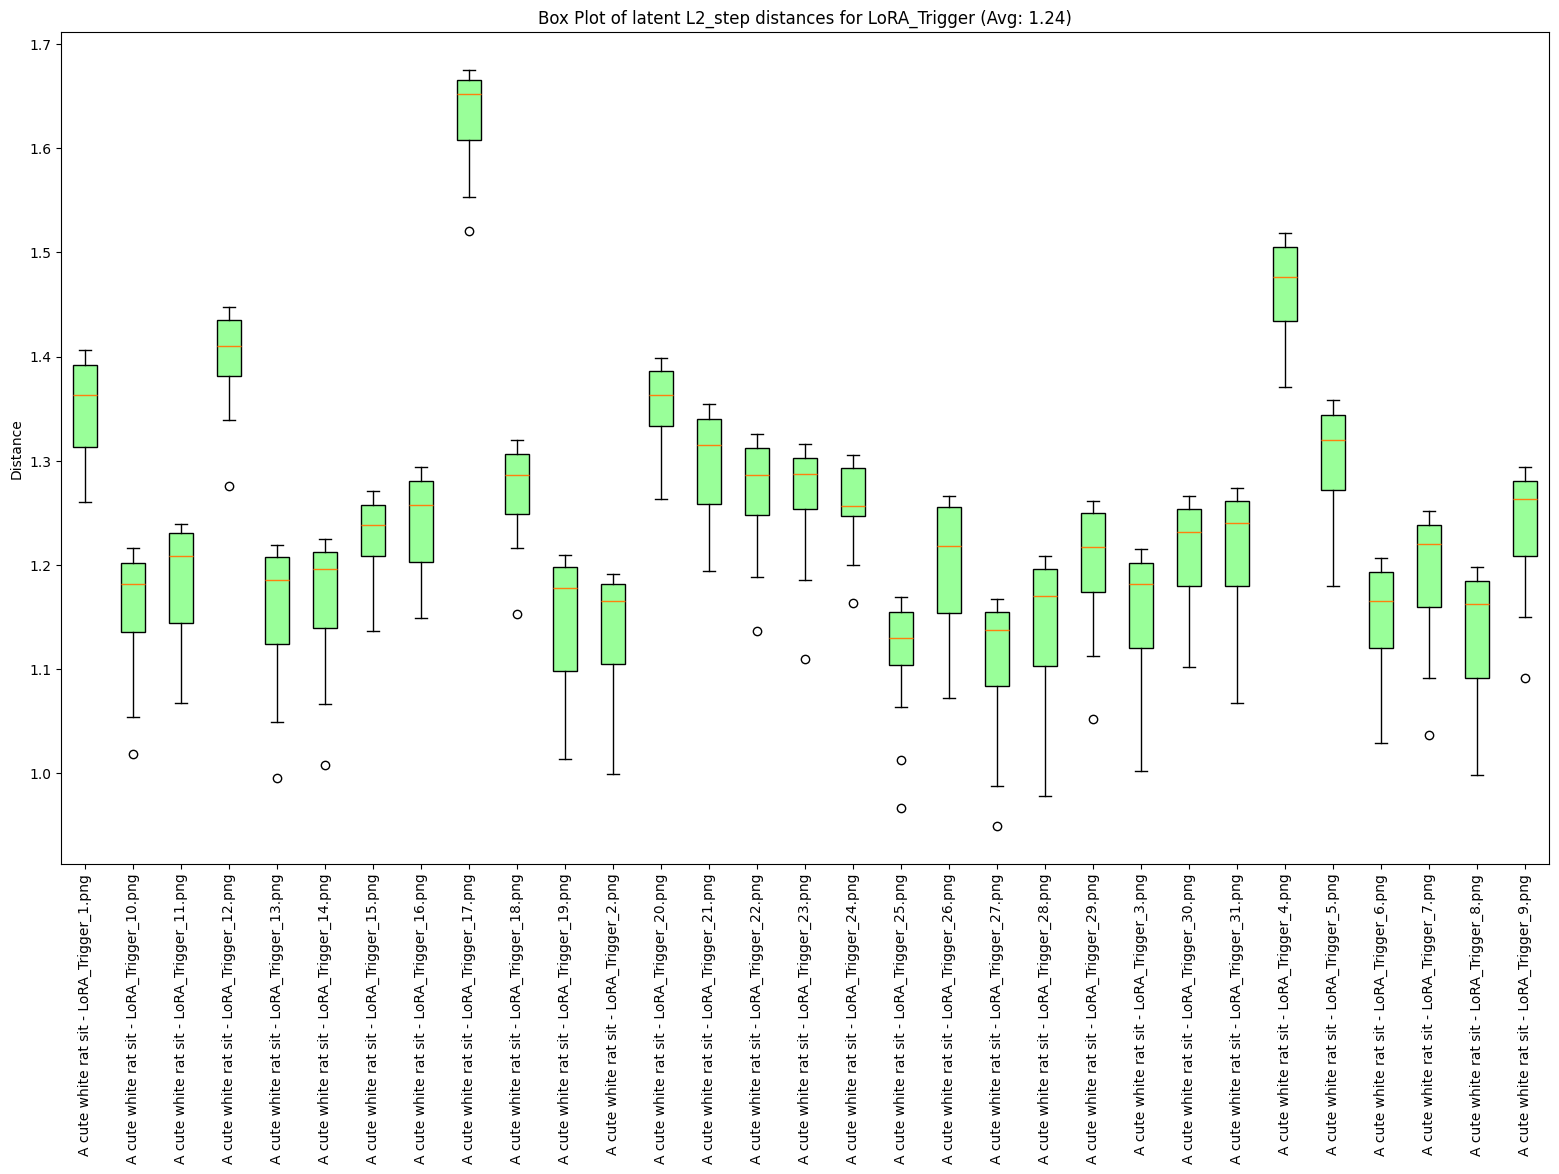

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


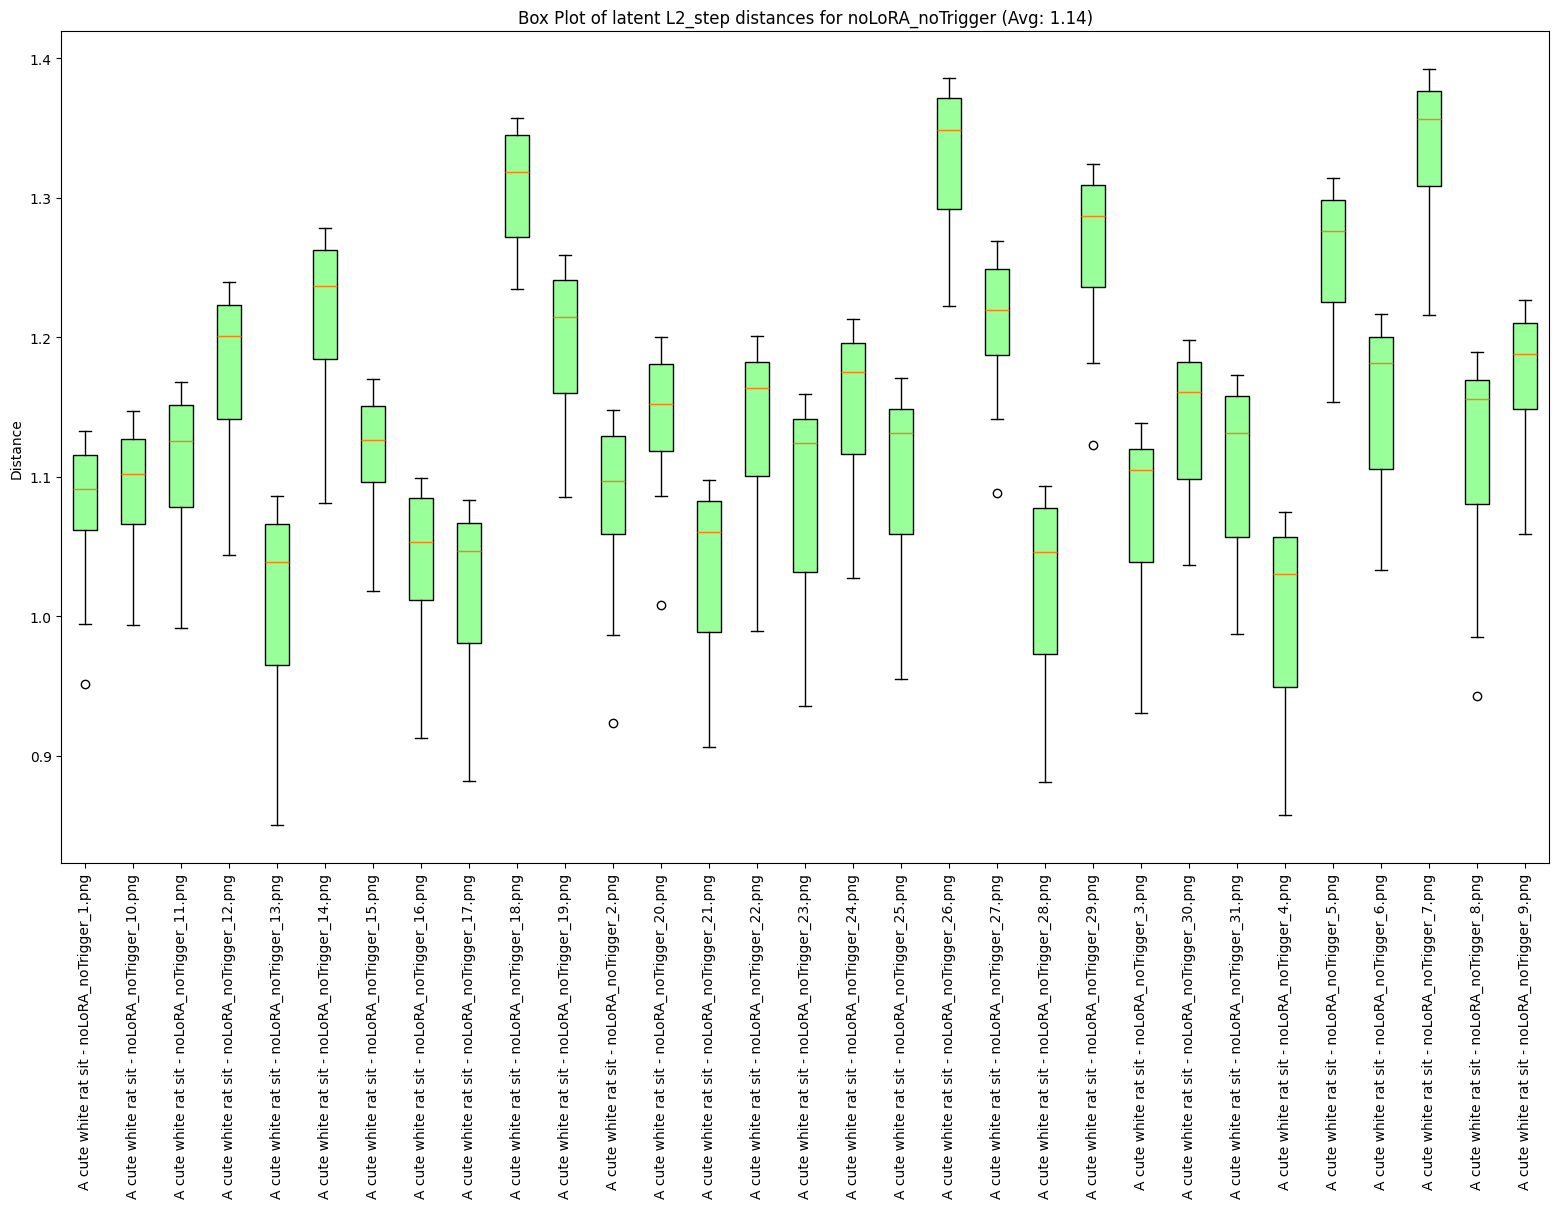

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


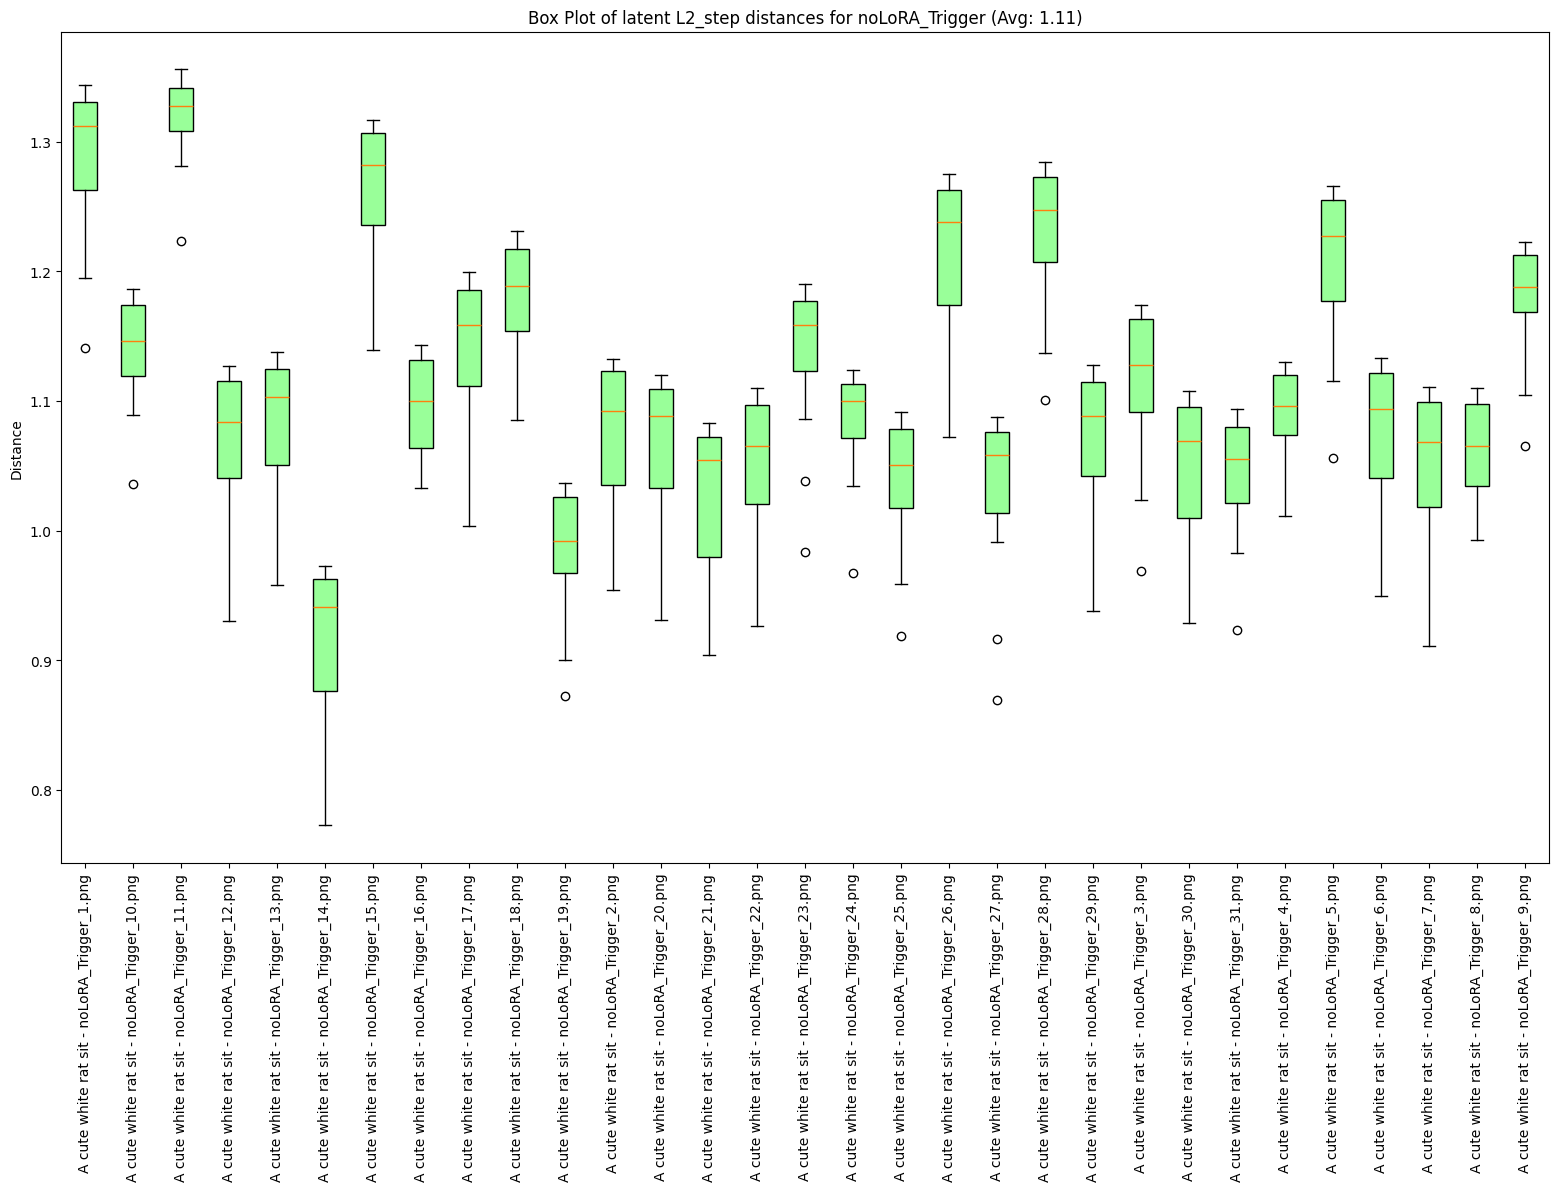

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


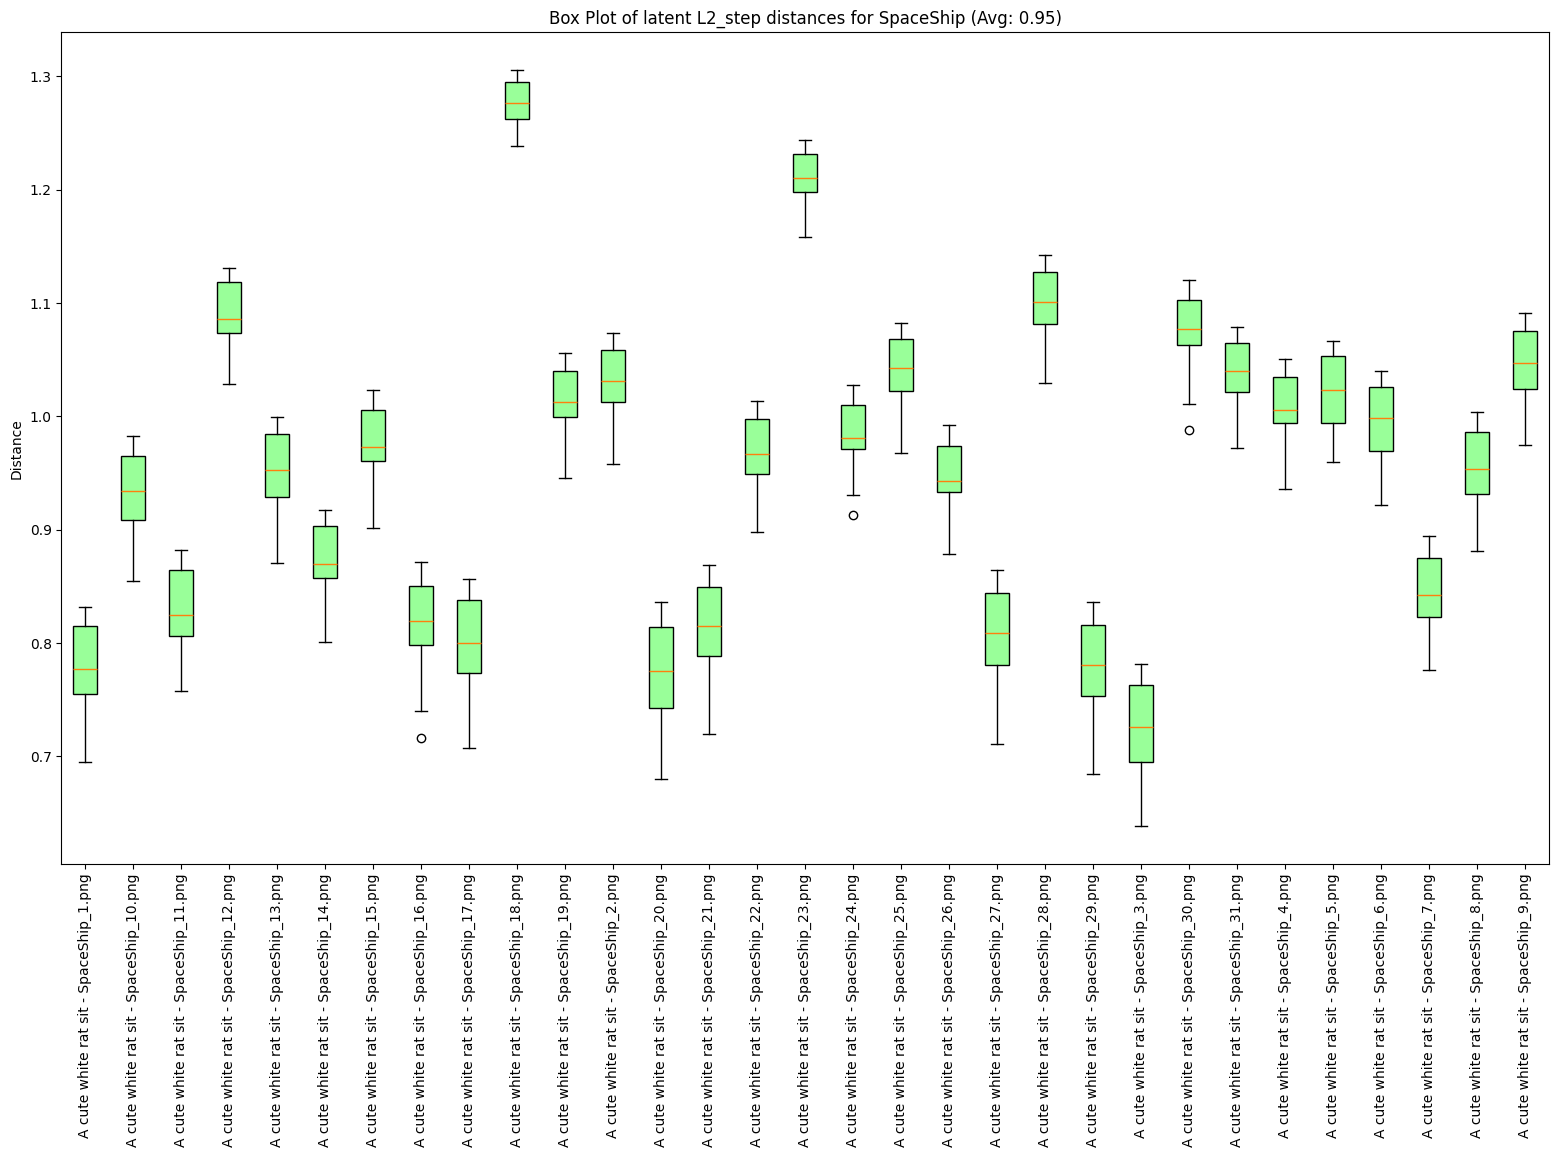

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


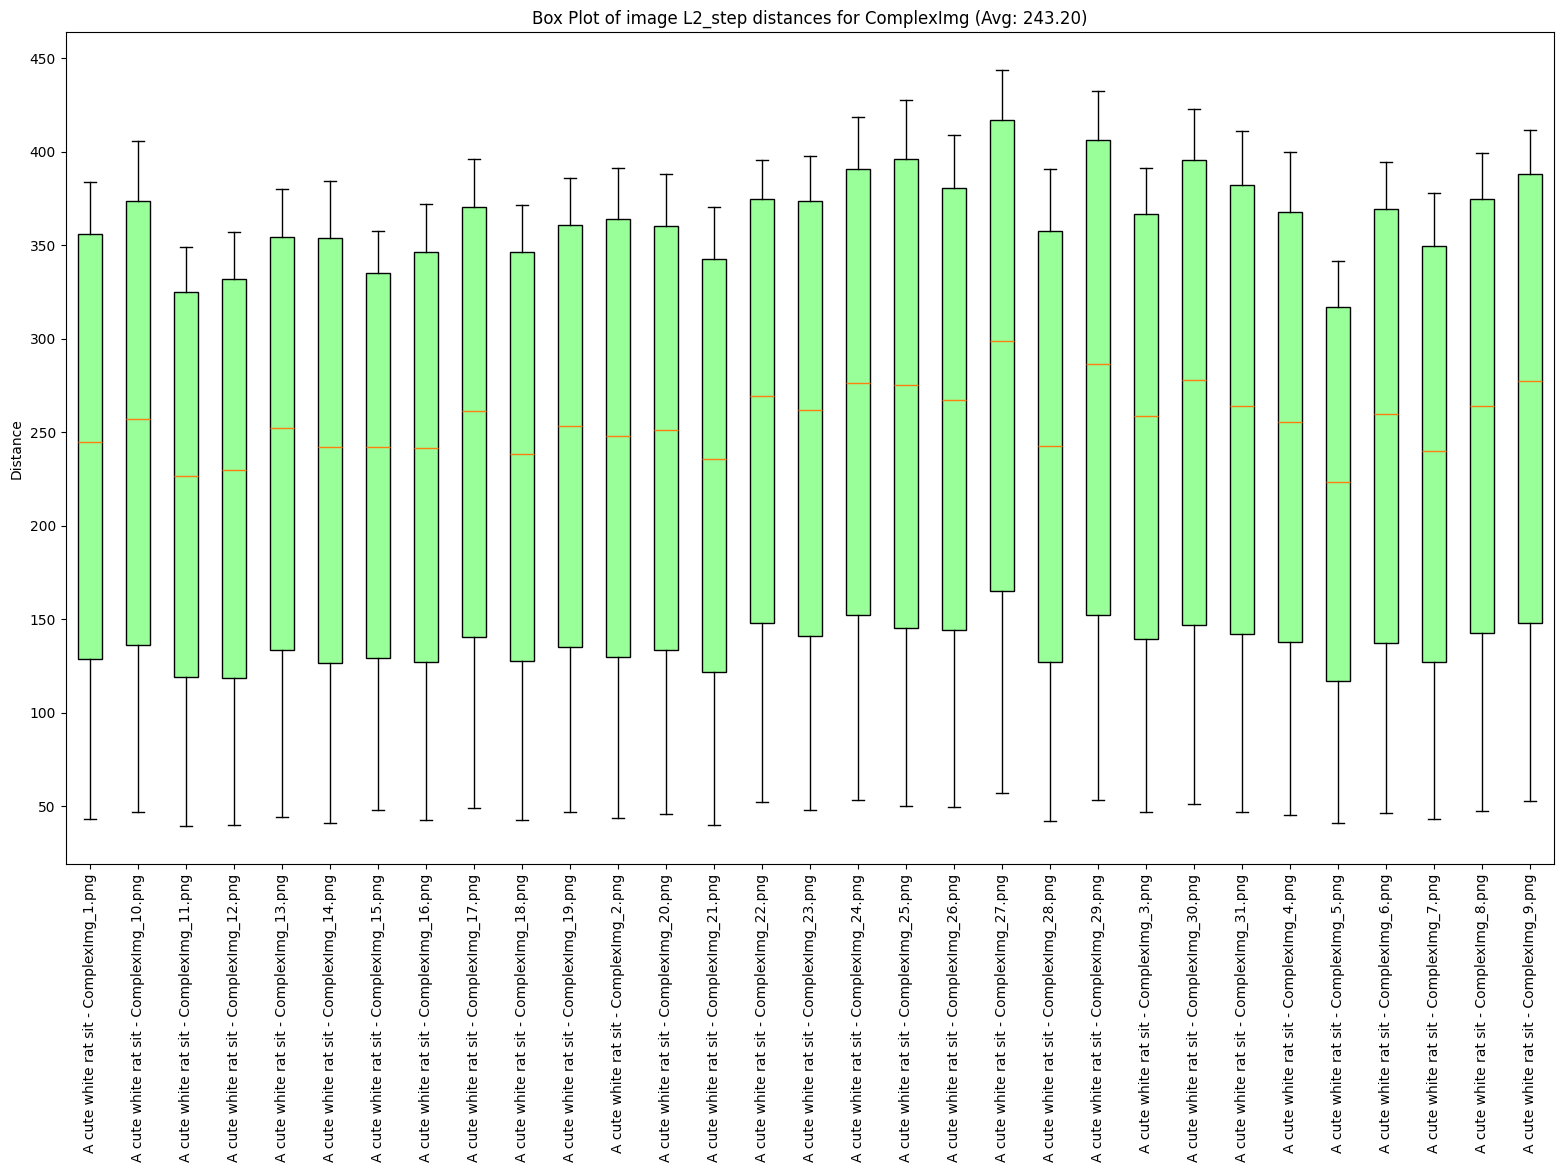

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


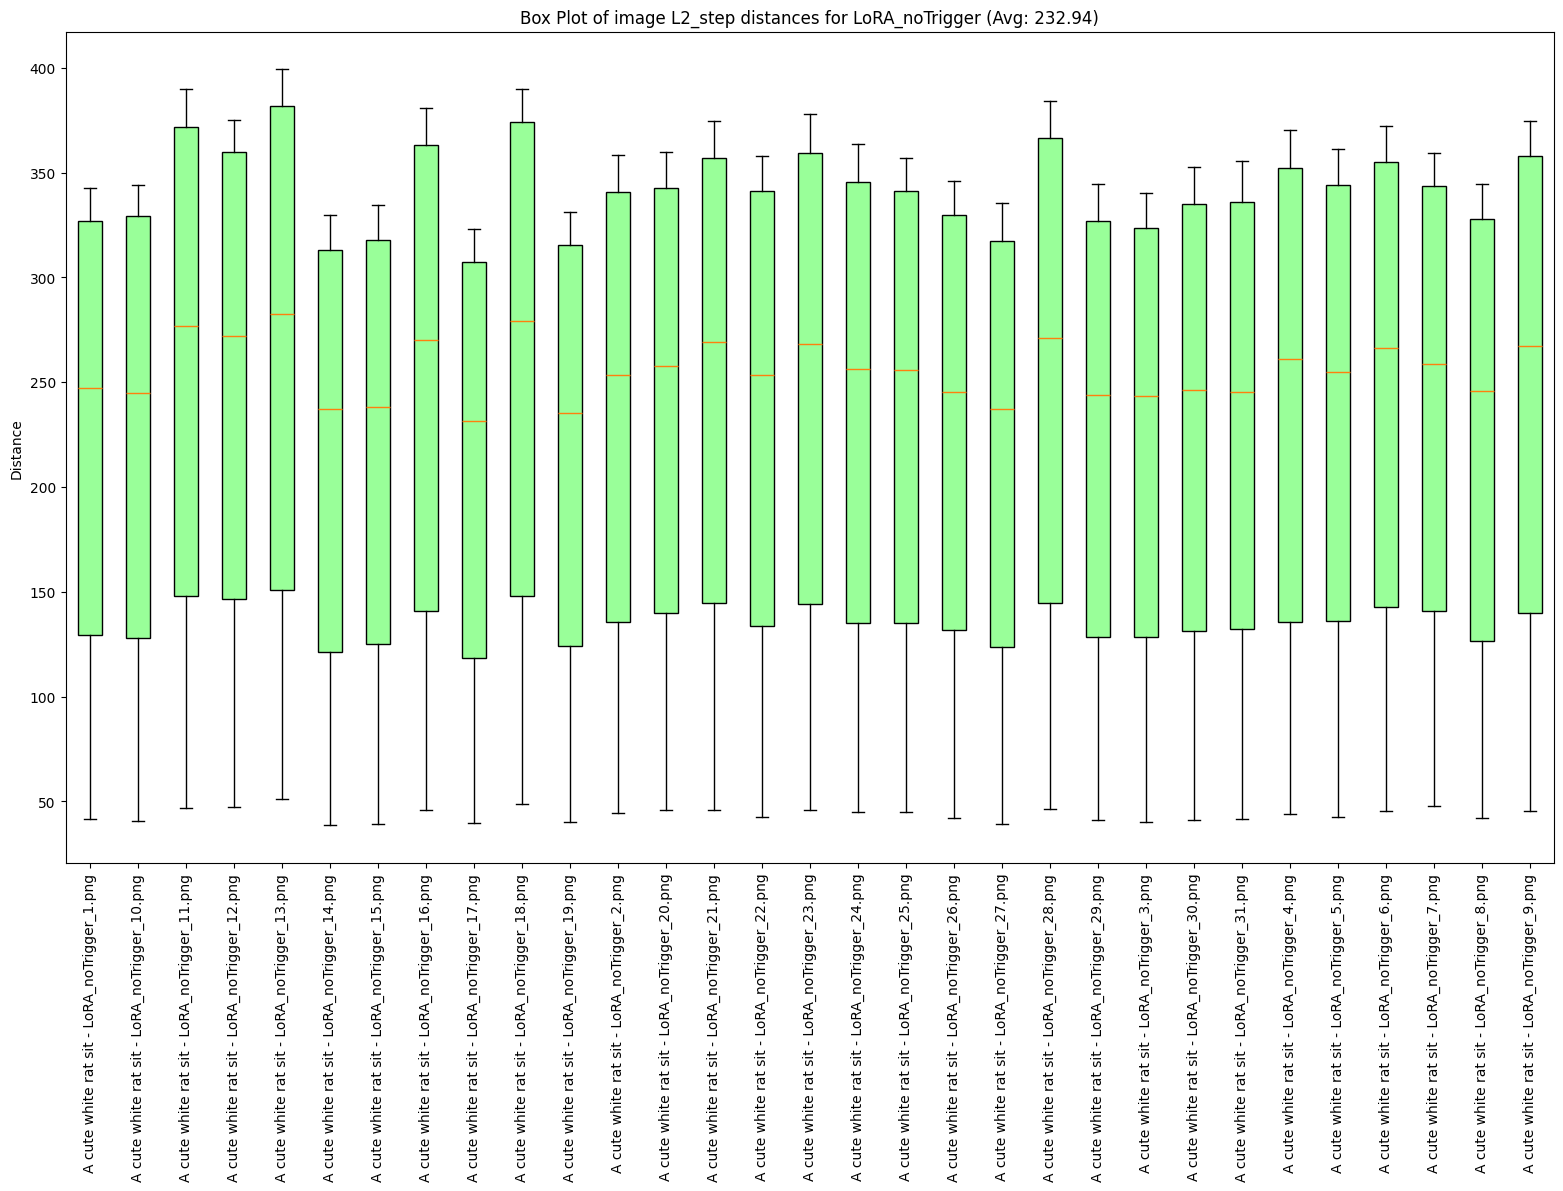

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


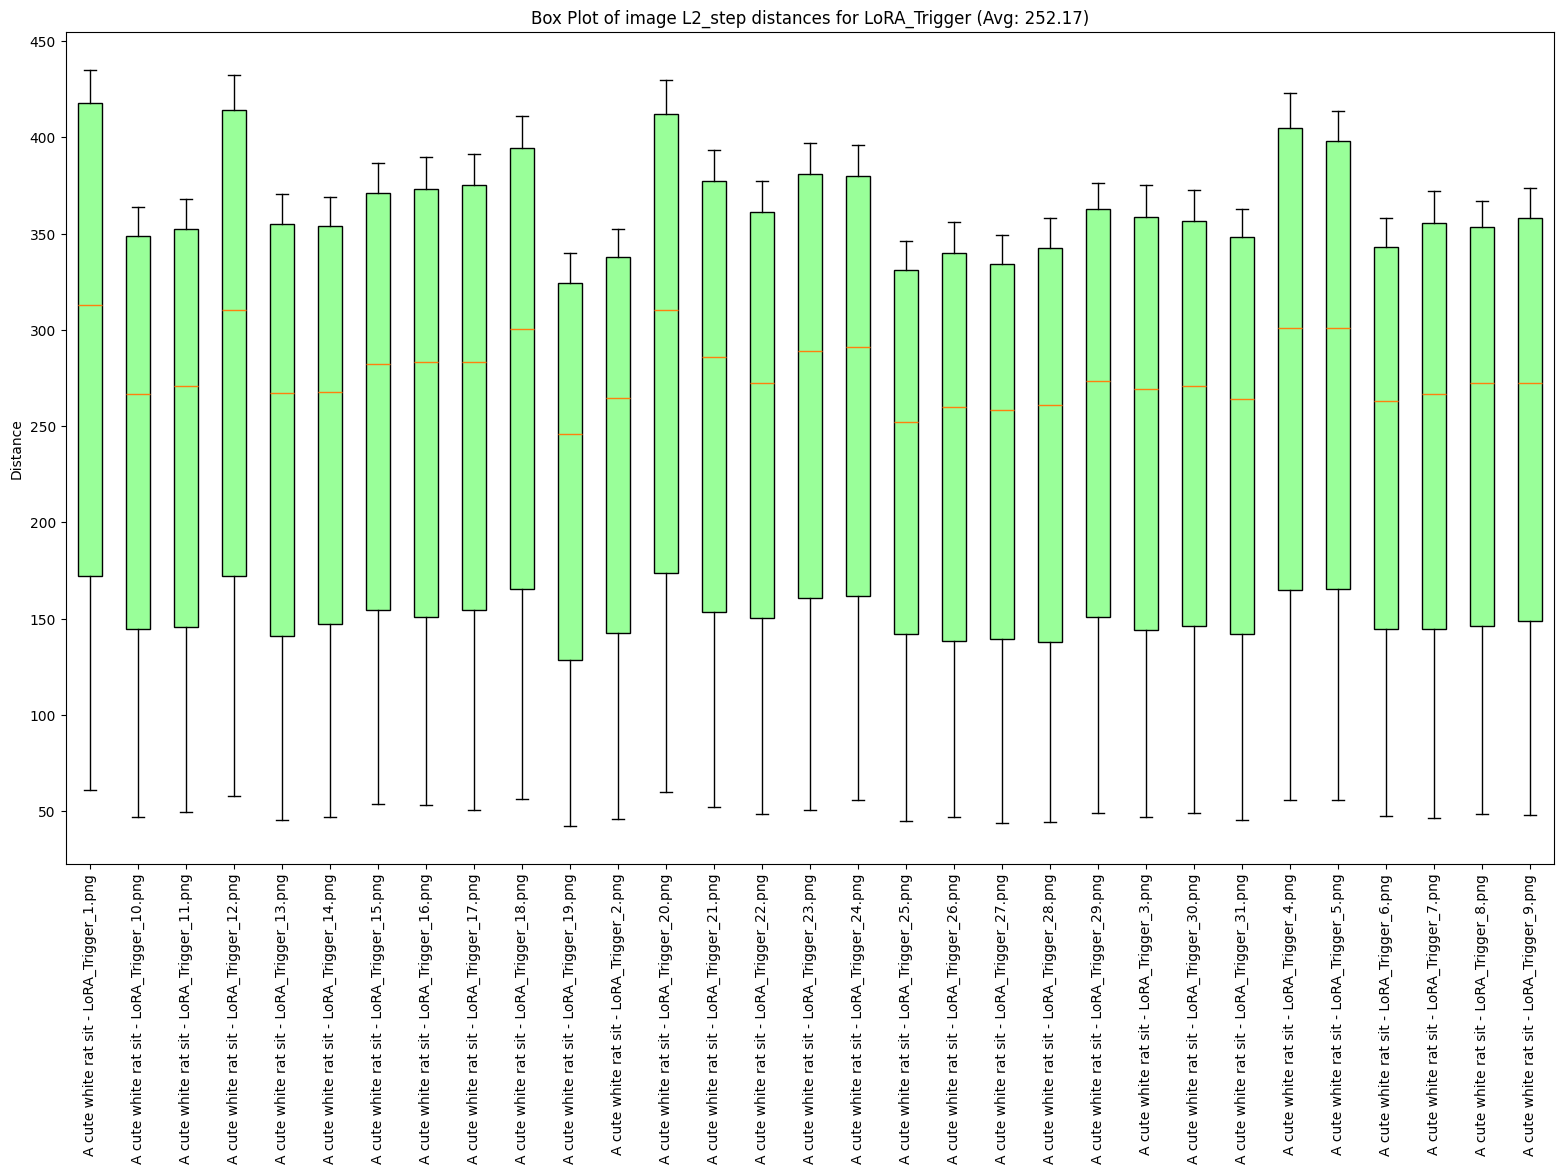

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


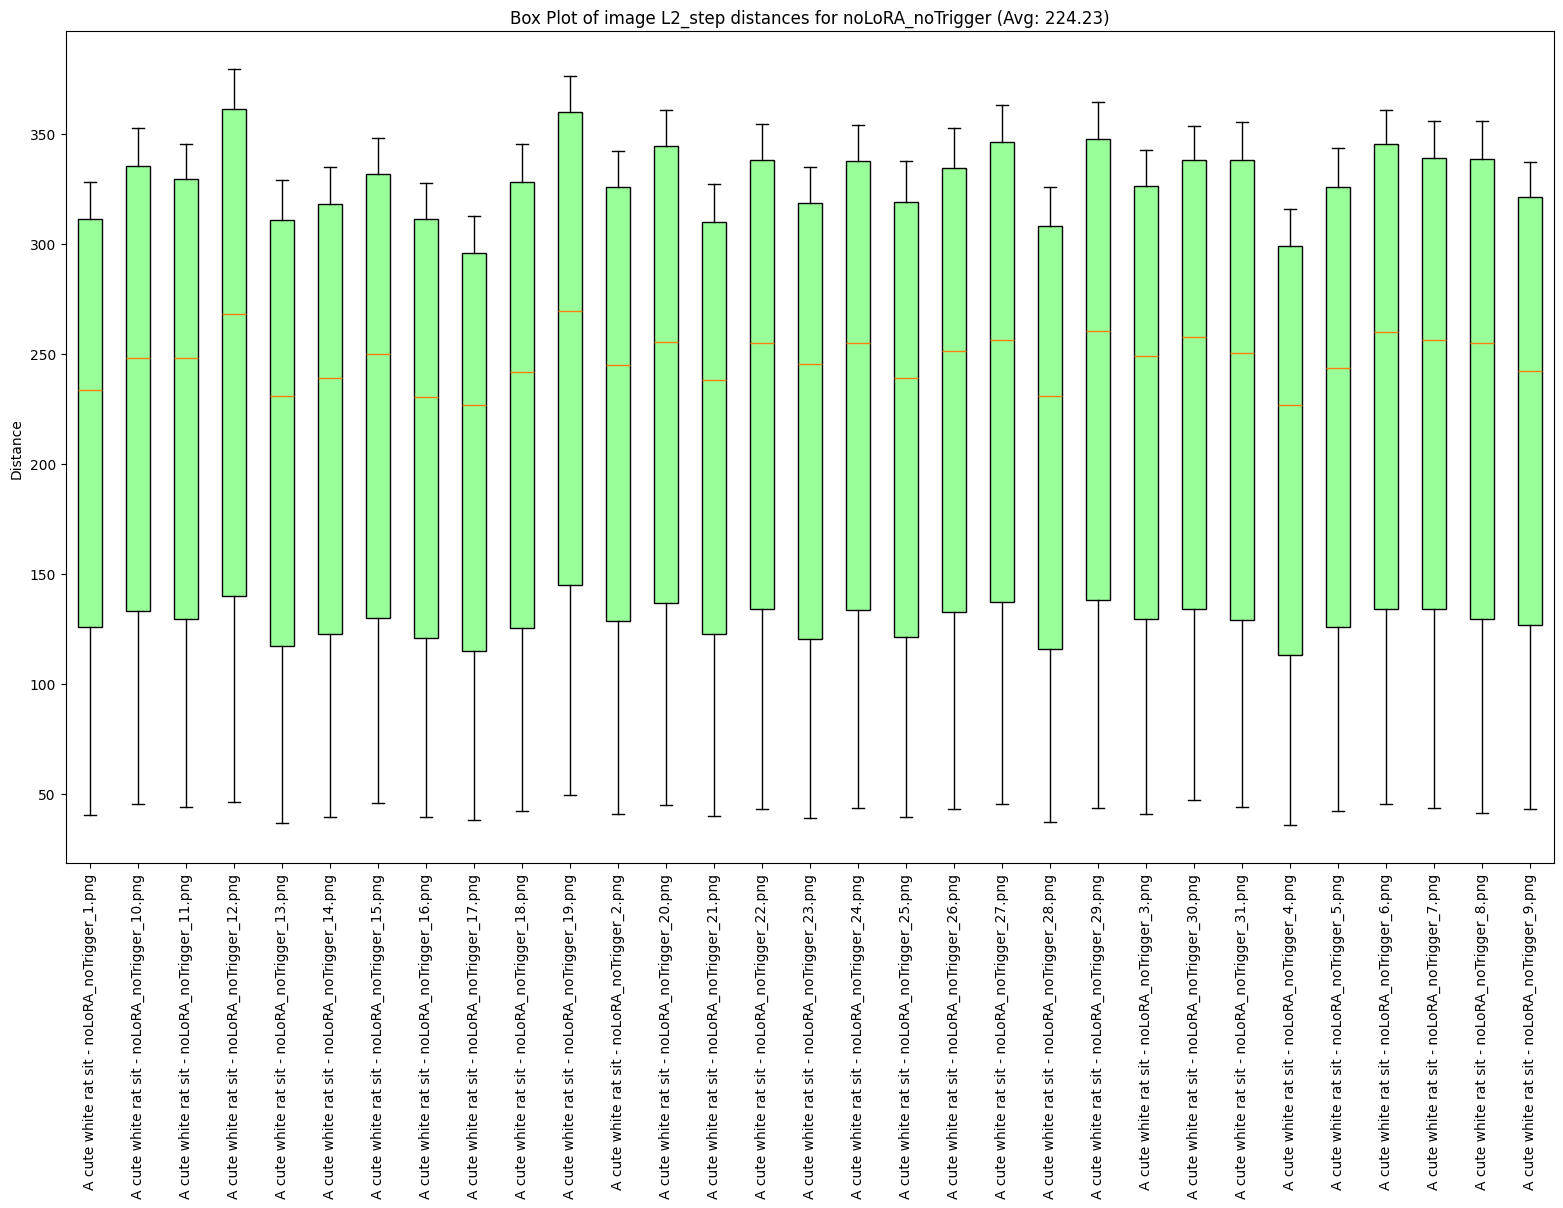

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


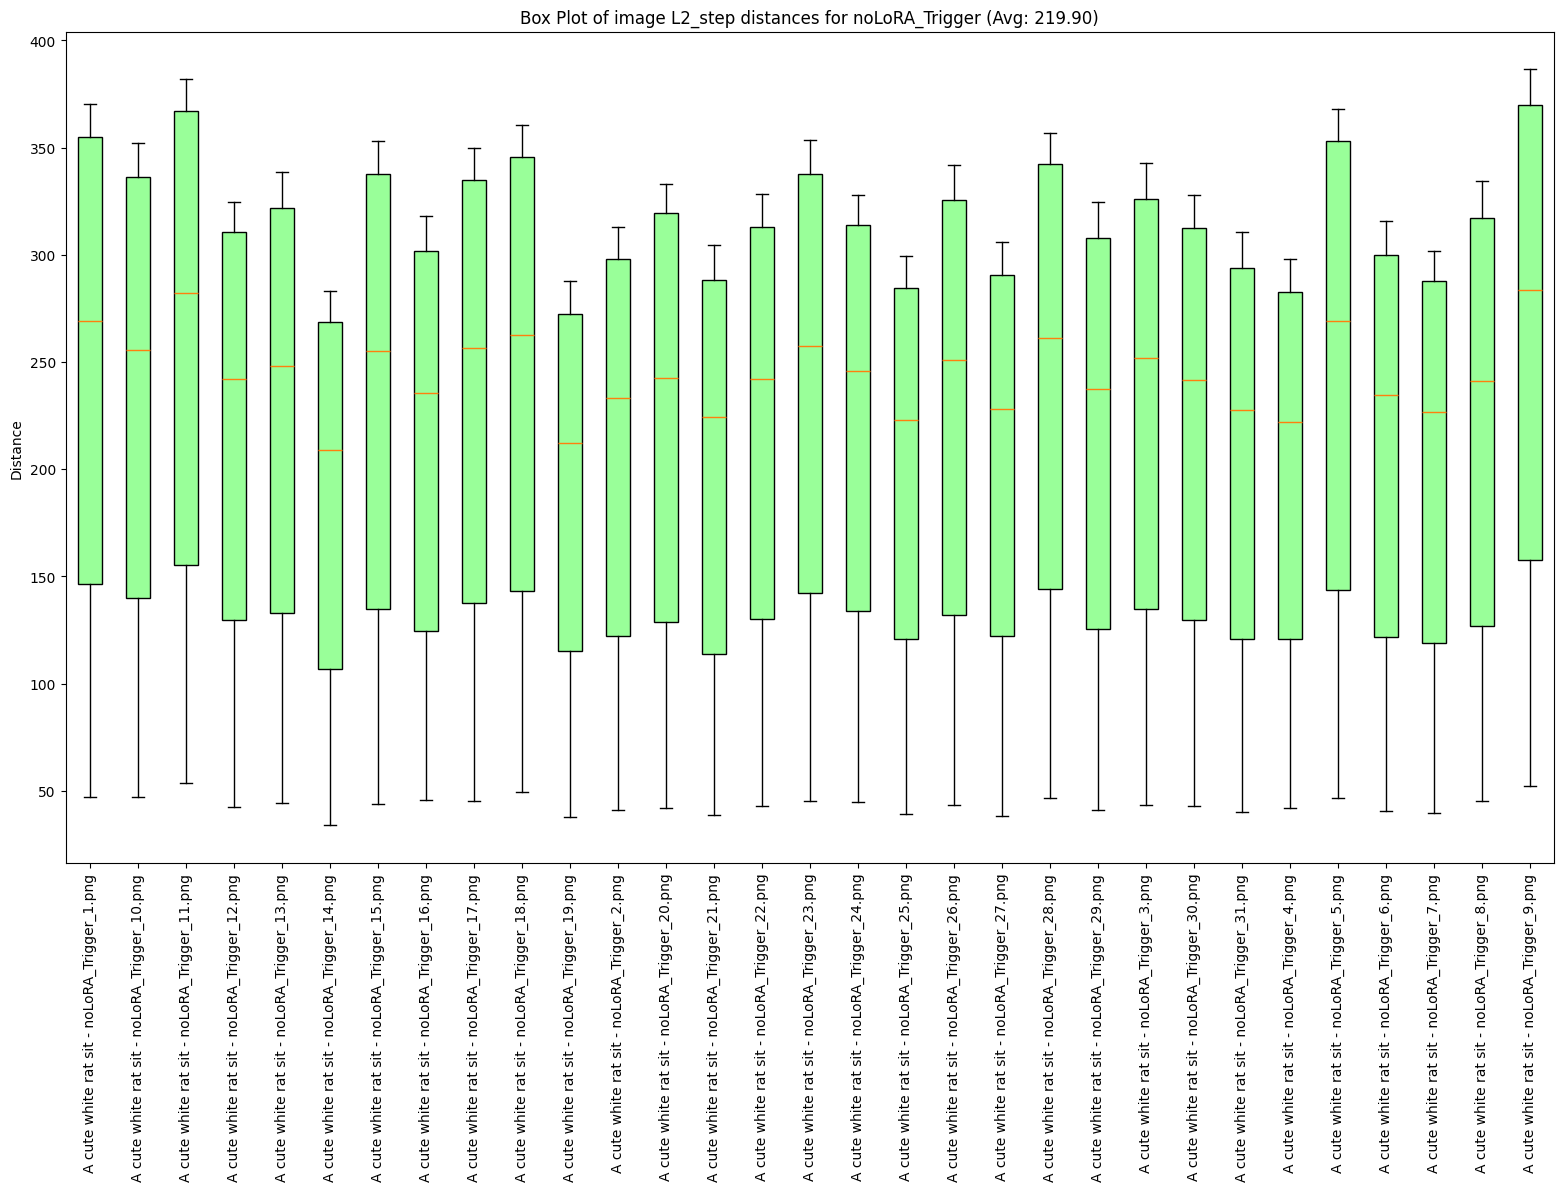

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


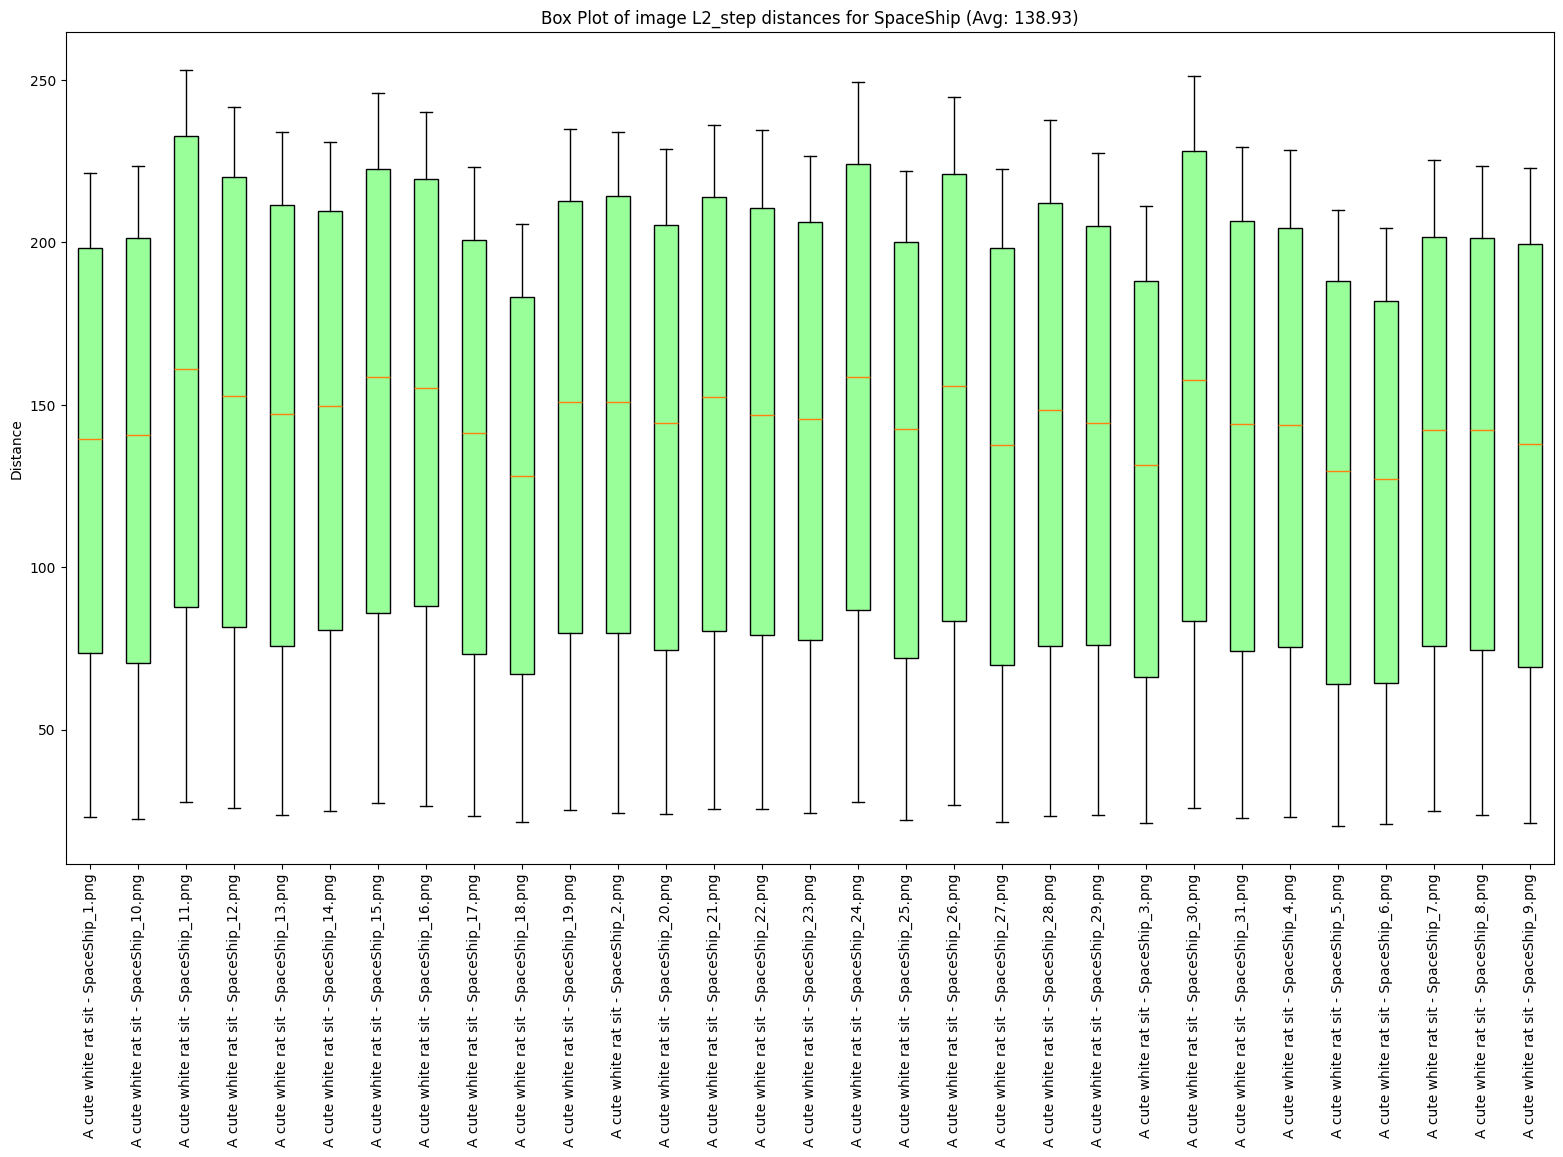

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


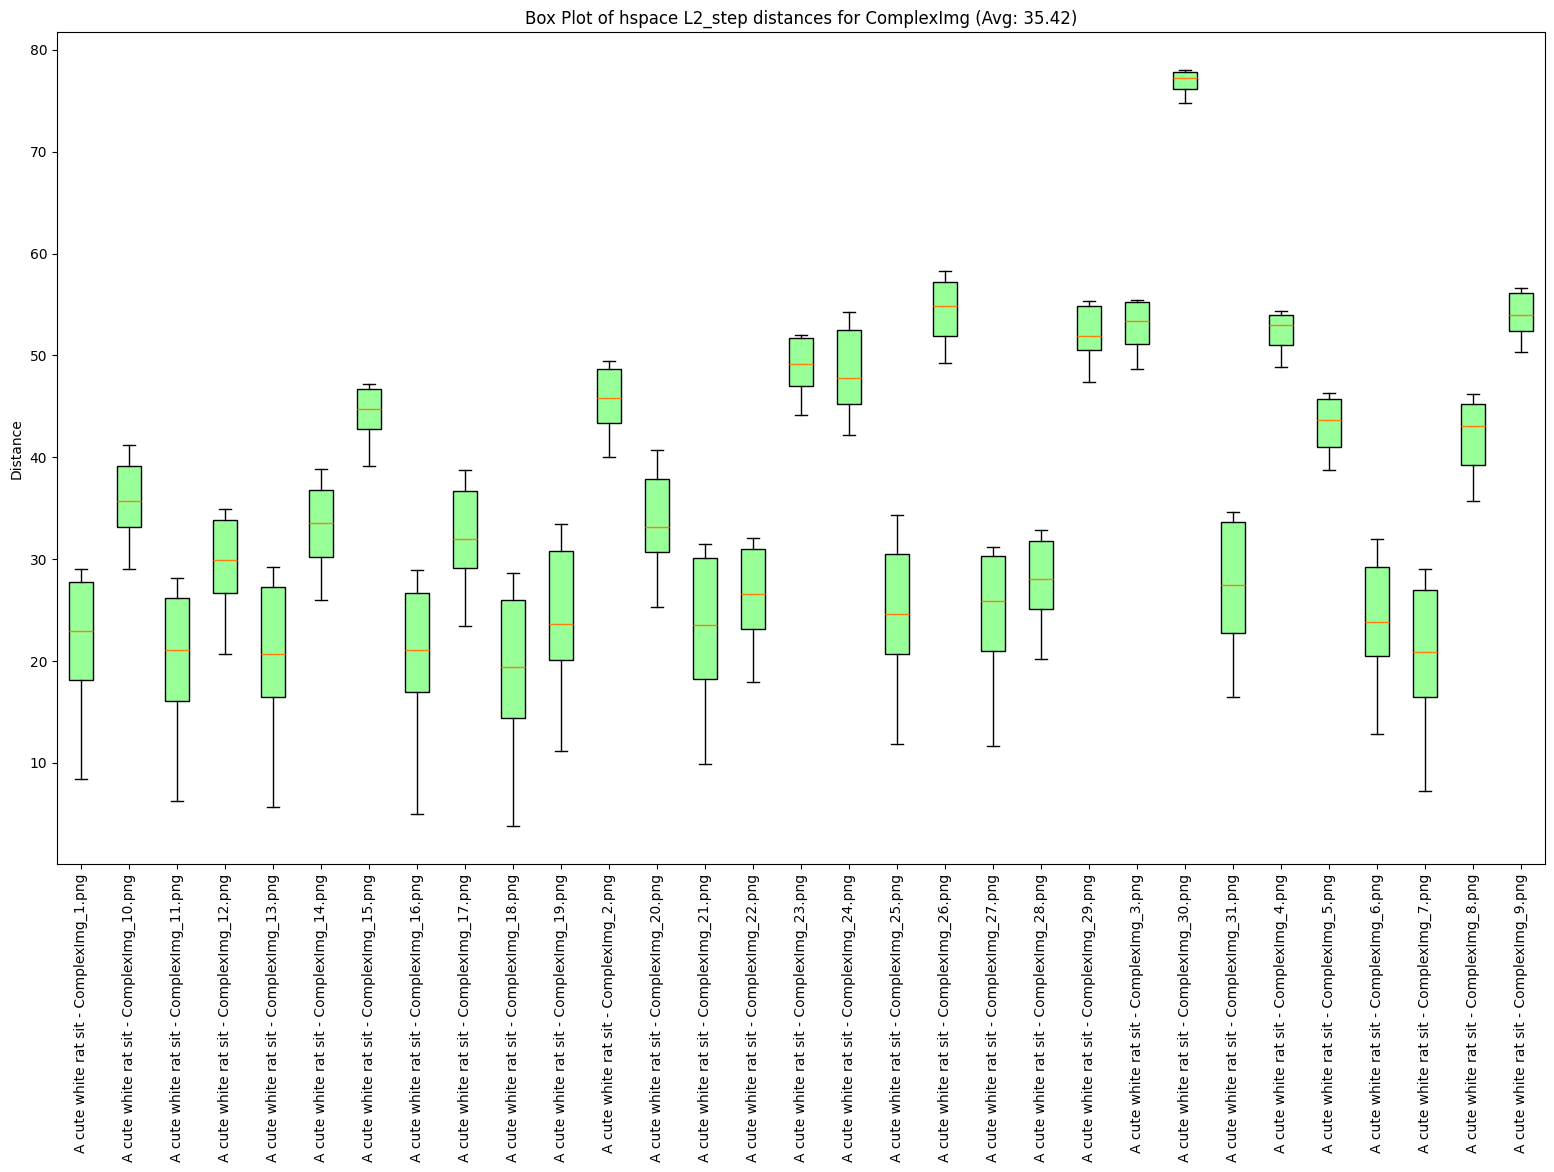

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


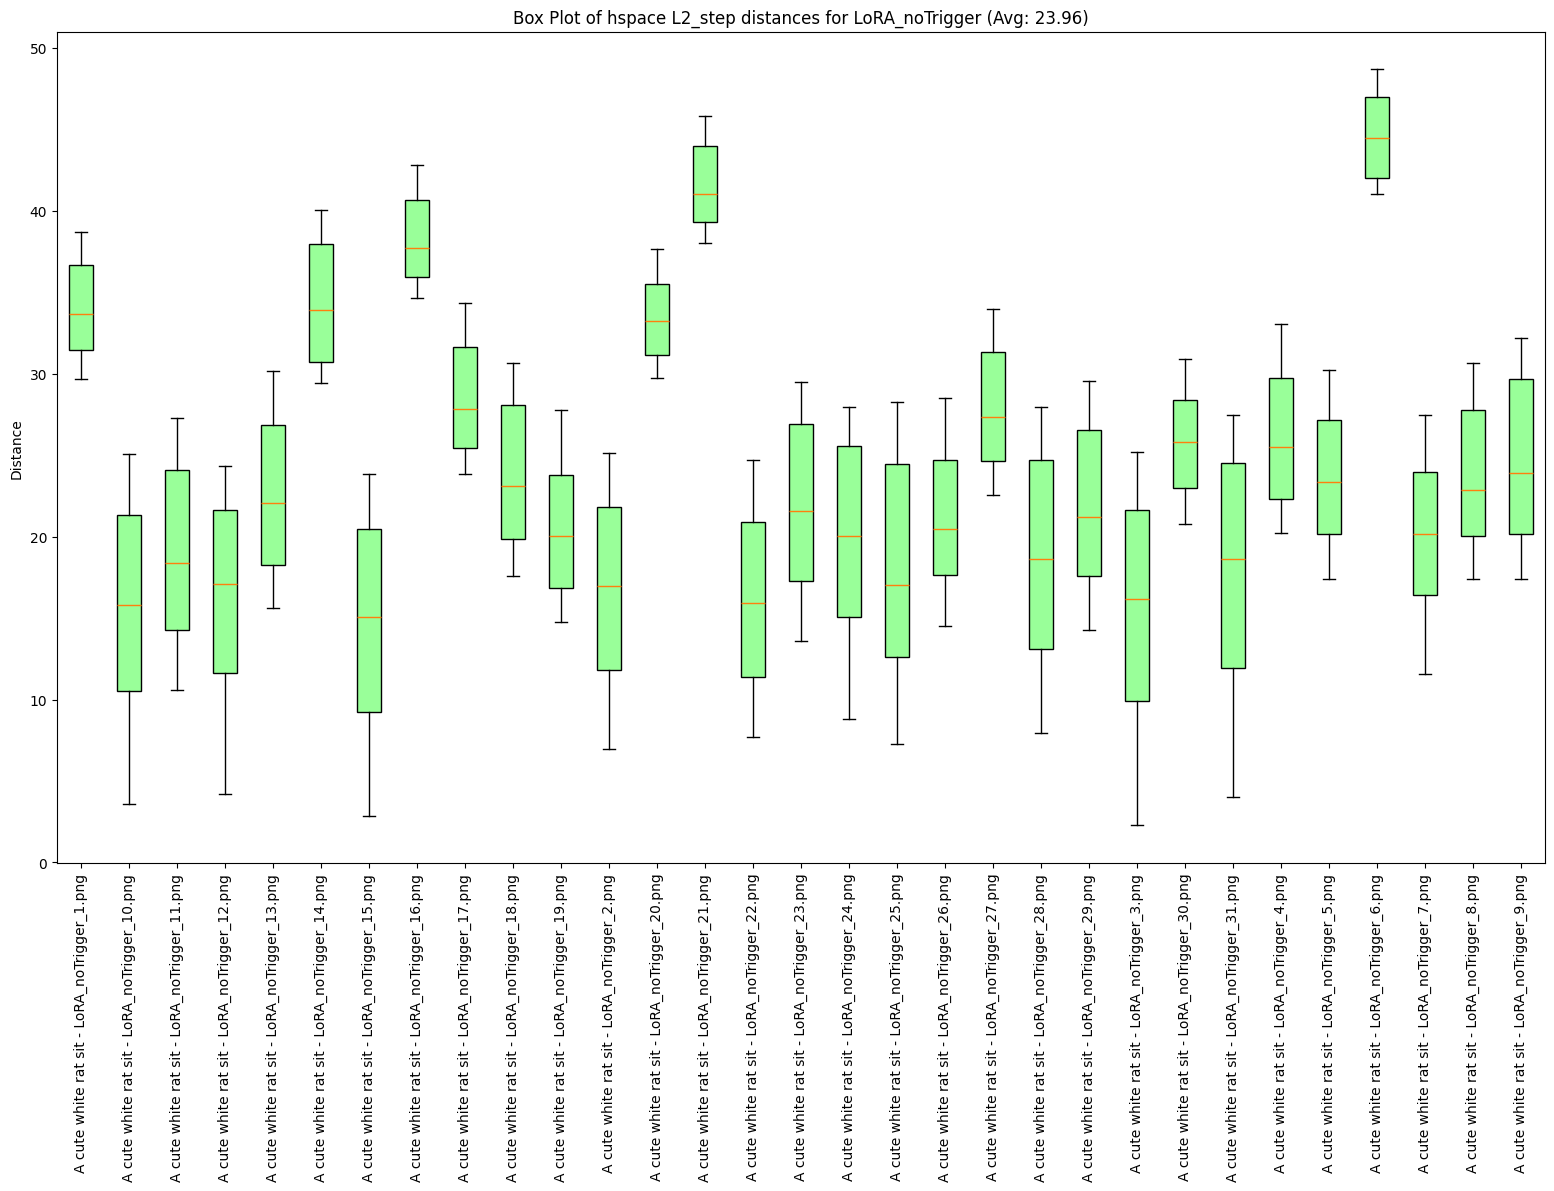

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


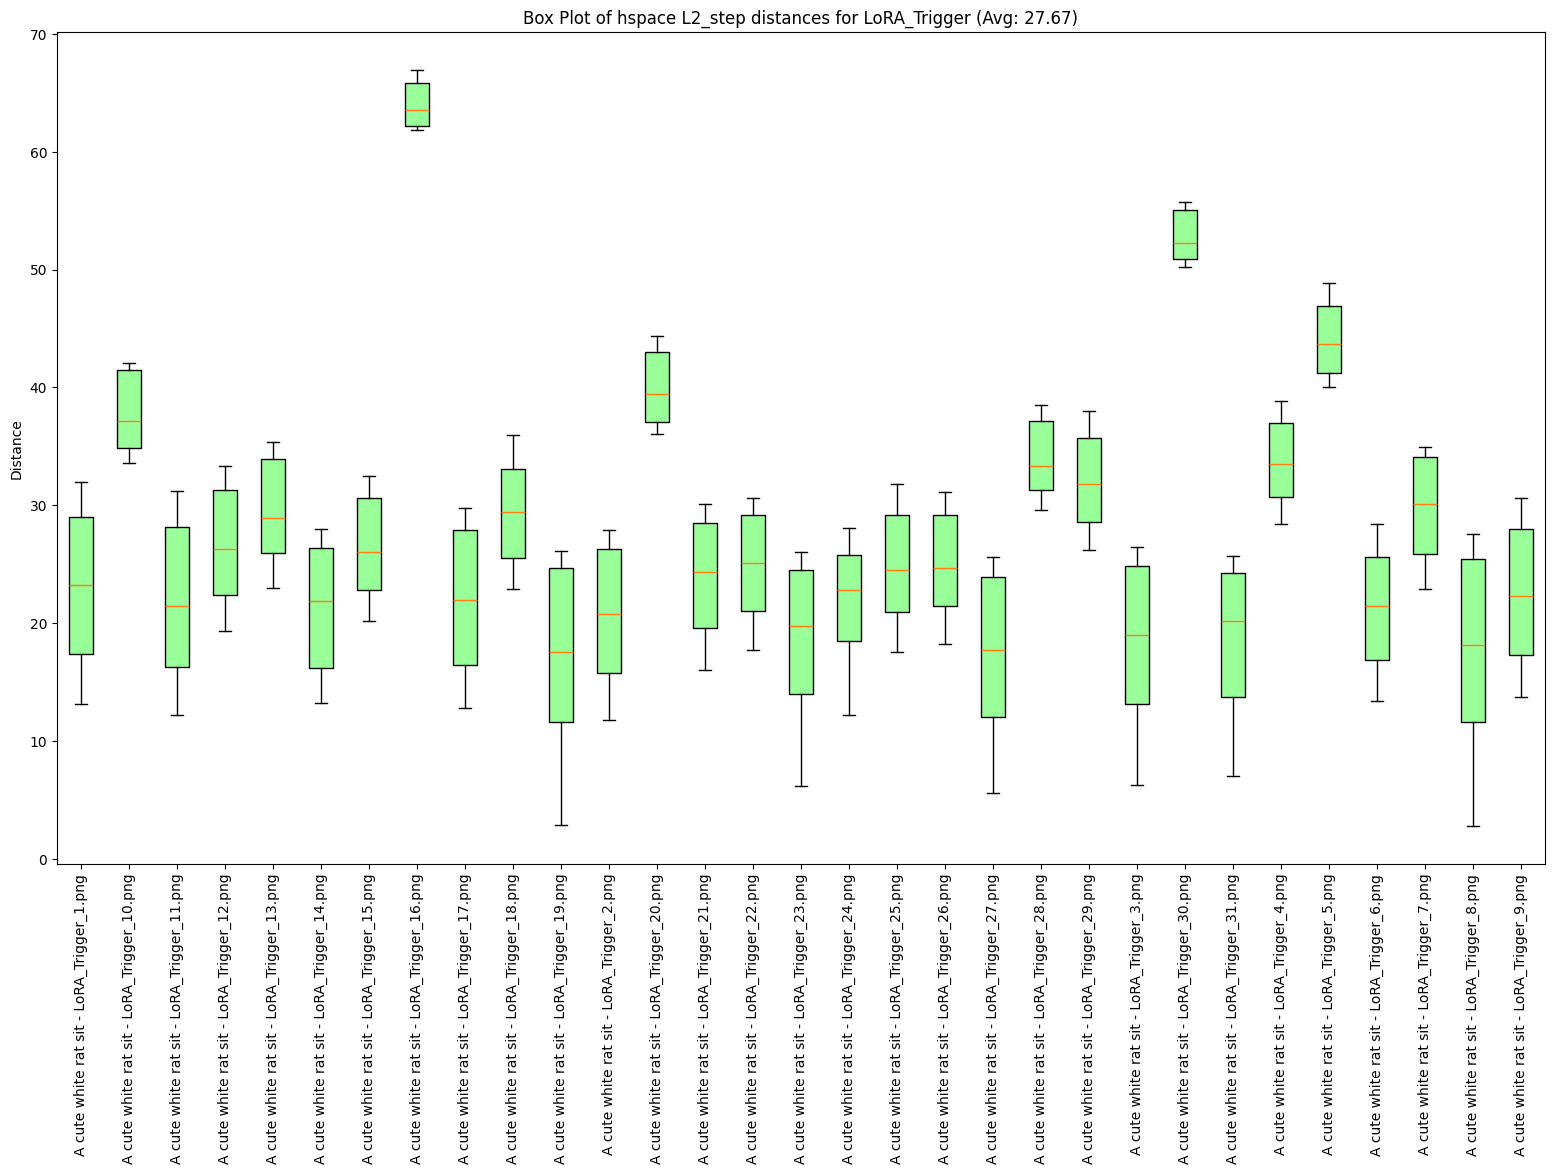

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


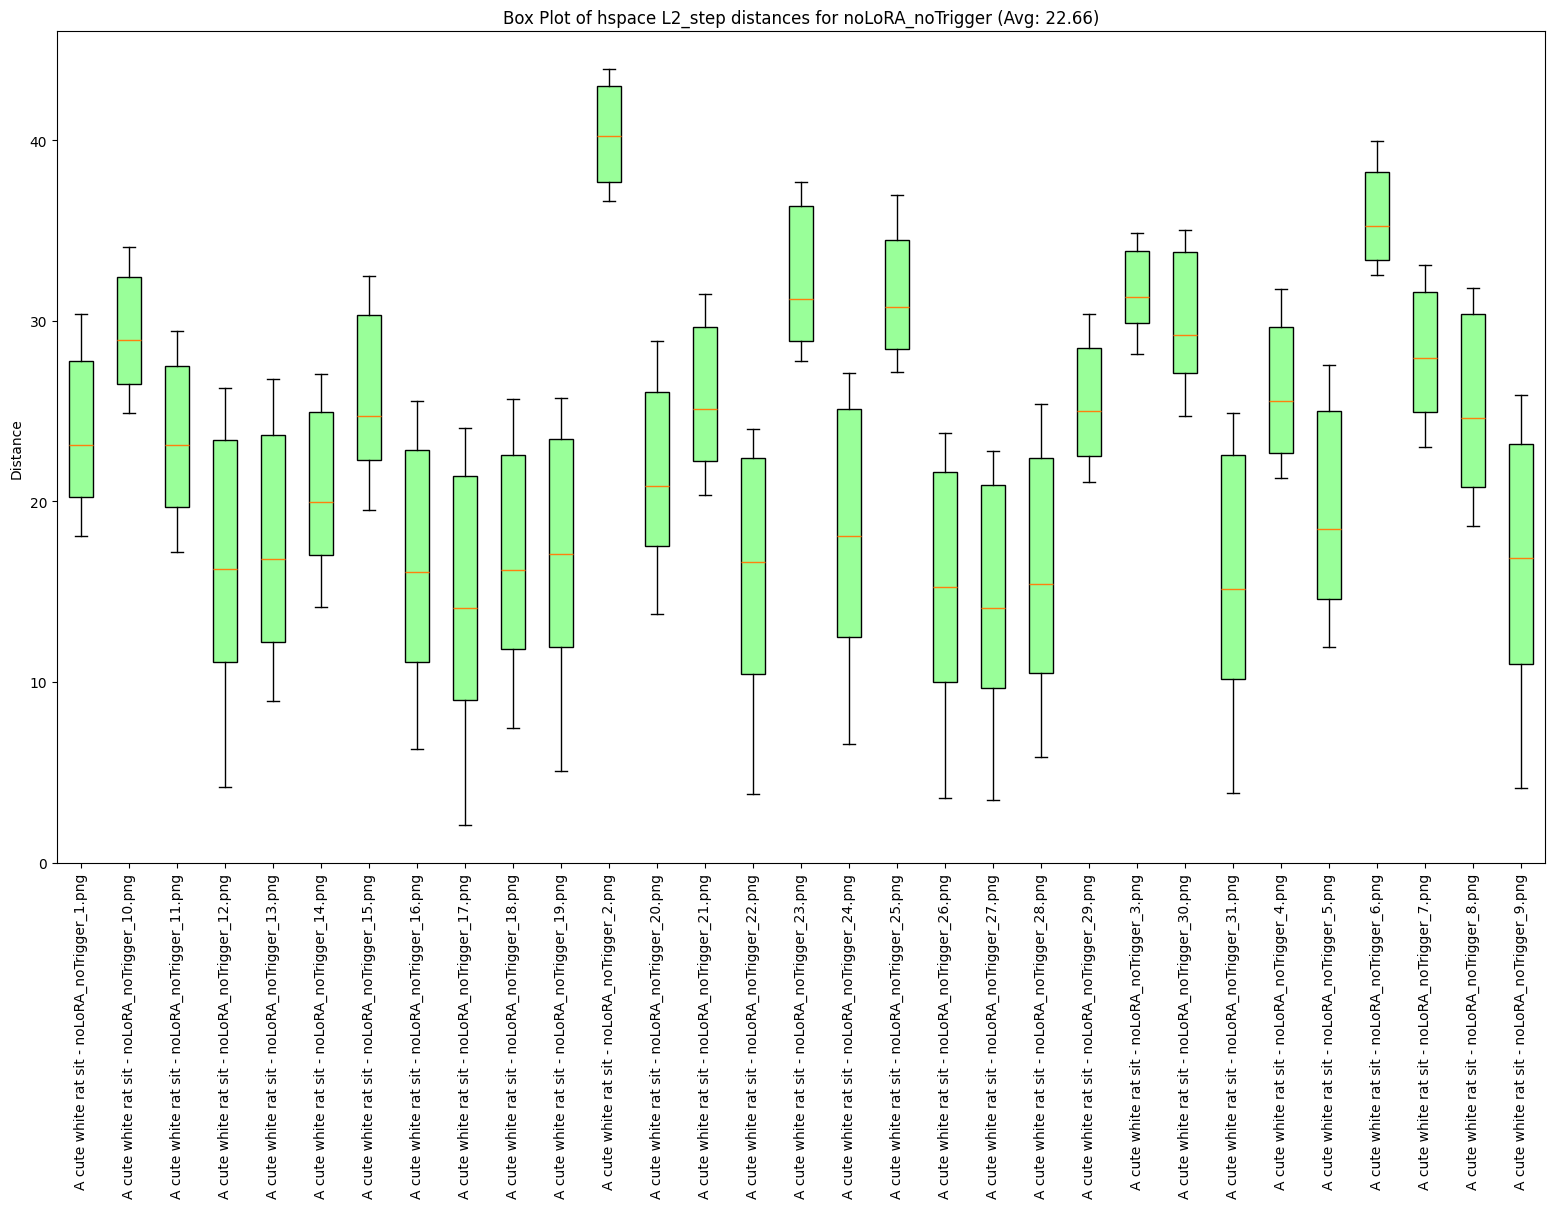

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


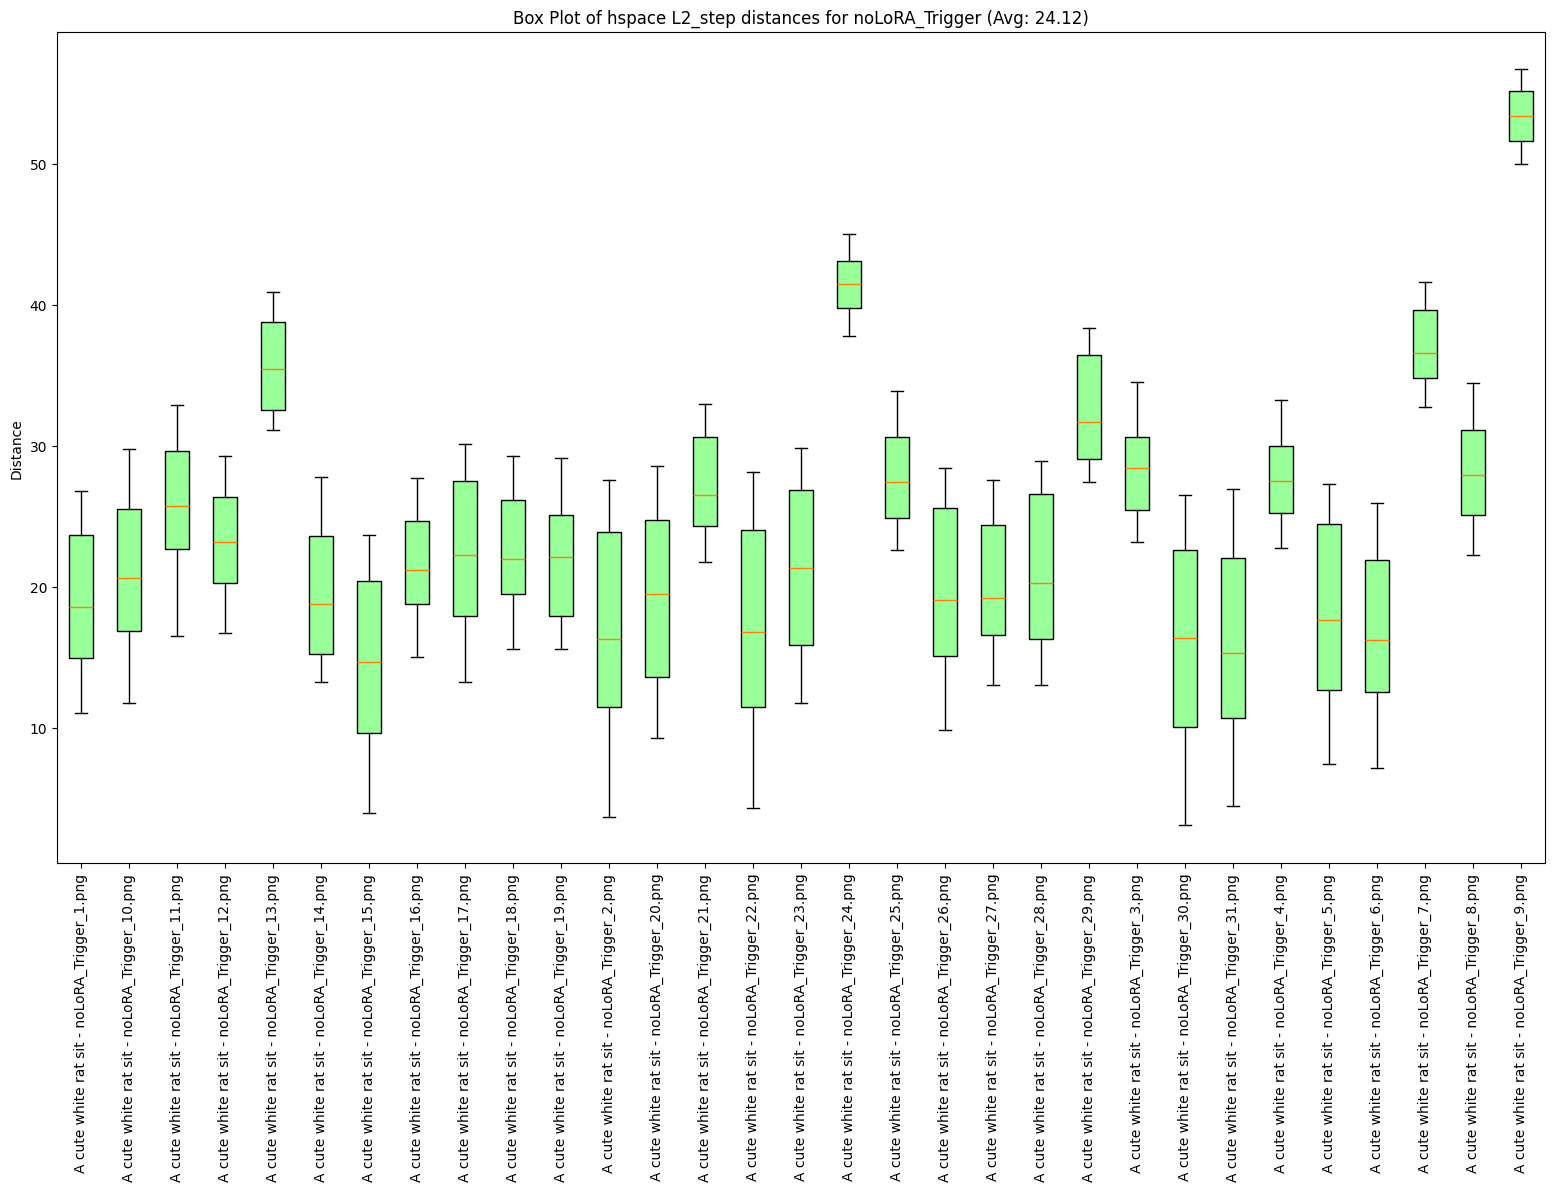

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


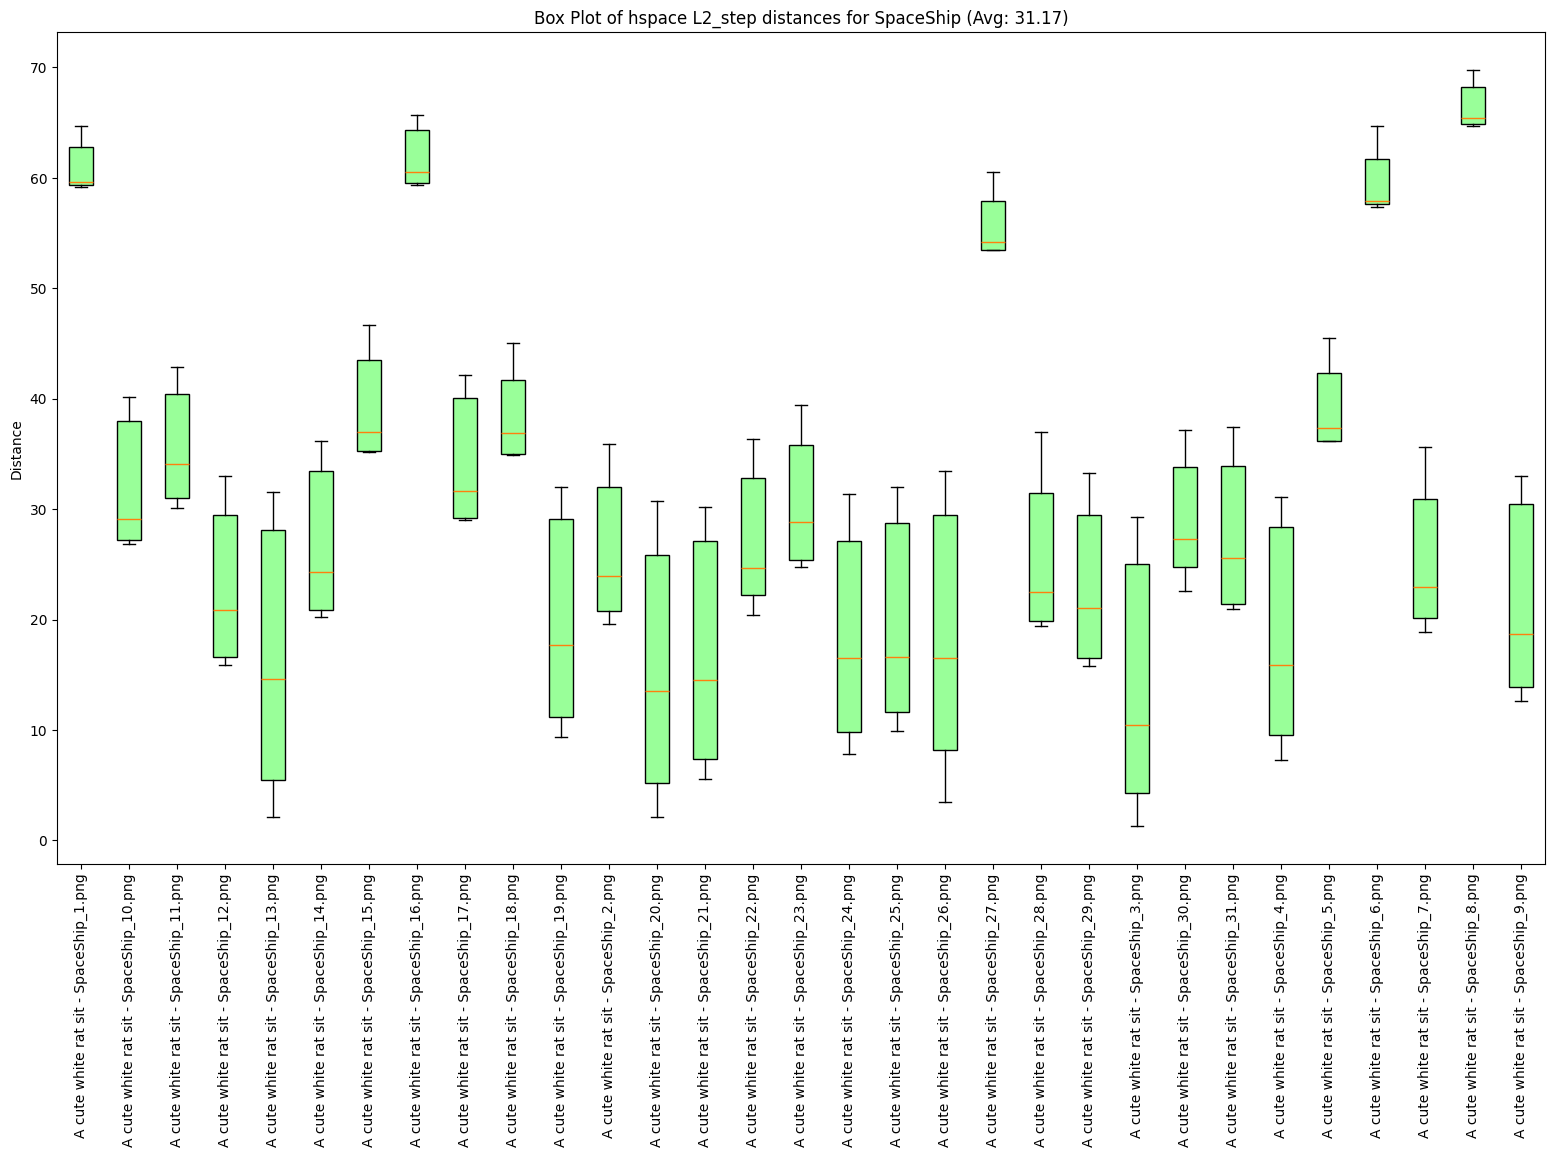

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boxplot(anaysis_data, key, distance_type="L2_step"):
    color = {'L2_step': '#99FF99', 'frechet_step': '#99CCFF', 'L1_step': '#FF9999', 'cosine_similarity': '#55AAFF'}[distance_type]  # Define the colors
    print(anaysis_data.keys())
    for prefix in anaysis_data.keys():
        data_to_plot = []
        labels = []
        print(anaysis_data[prefix].keys())
        for prompt in anaysis_data[prefix].keys():
            print(anaysis_data[prefix][prompt].keys())
            for image_name in anaysis_data[prefix][prompt].keys():
                data = anaysis_data[prefix][prompt][image_name][key]
                data_to_plot.append(data)
                labels.append(f'{prompt} - {image_name}')
        
        plt.figure(figsize=(19.2, 10.8))
        box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)
        for patch in box['boxes']:
            patch.set_facecolor(color)
        
        avg_distance = np.mean([np.mean(data) for data in data_to_plot])
        plt.ylabel('Distance')
        plt.title(f'Box Plot of {key} {distance_type} distances for {prefix} (Avg: {avg_distance:.2f})')
        plt.xticks(rotation=90)
        plt.show()

plot_boxplot(anaysis_data["L2_step"], 'latent', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'image', "L2_step")
plot_boxplot(anaysis_data["L2_step"], 'hspace', "L2_step")

In [25]:
# do the same thing for frechet distance
def calculate_frechet_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["frechet_step"] = calculate_frechet_distance(experiment_data)


ComplexImg_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png


In [26]:
# do the same thing for L1 distance
def calculate_L1_distance(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key] - experiment_data[prefix][prompt][first_image_name][key]))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data
anaysis_data["L1_step"] = calculate_L1_distance(experiment_data)

ComplexImg_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png


In [27]:
# calculate the cosine similarity between each image and the first image
def calculate_cosine_similarity(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = np.dot(experiment_data[prefix][prompt][image_name][key][i].flatten(), experiment_data[prefix][prompt][first_image_name][key][i].flatten()) / (np.linalg.norm(experiment_data[prefix][prompt][image_name][key][i].flatten()) * np.linalg.norm(experiment_data[prefix][prompt][first_image_name][key][i].flatten()))
                        # 轉回角度
                        distance = np.arccos(distance) * 180 / np.pi
                        anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

anaysis_data["cosine_similarity"] = calculate_cosine_similarity(experiment_data)

ComplexImg_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png


dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


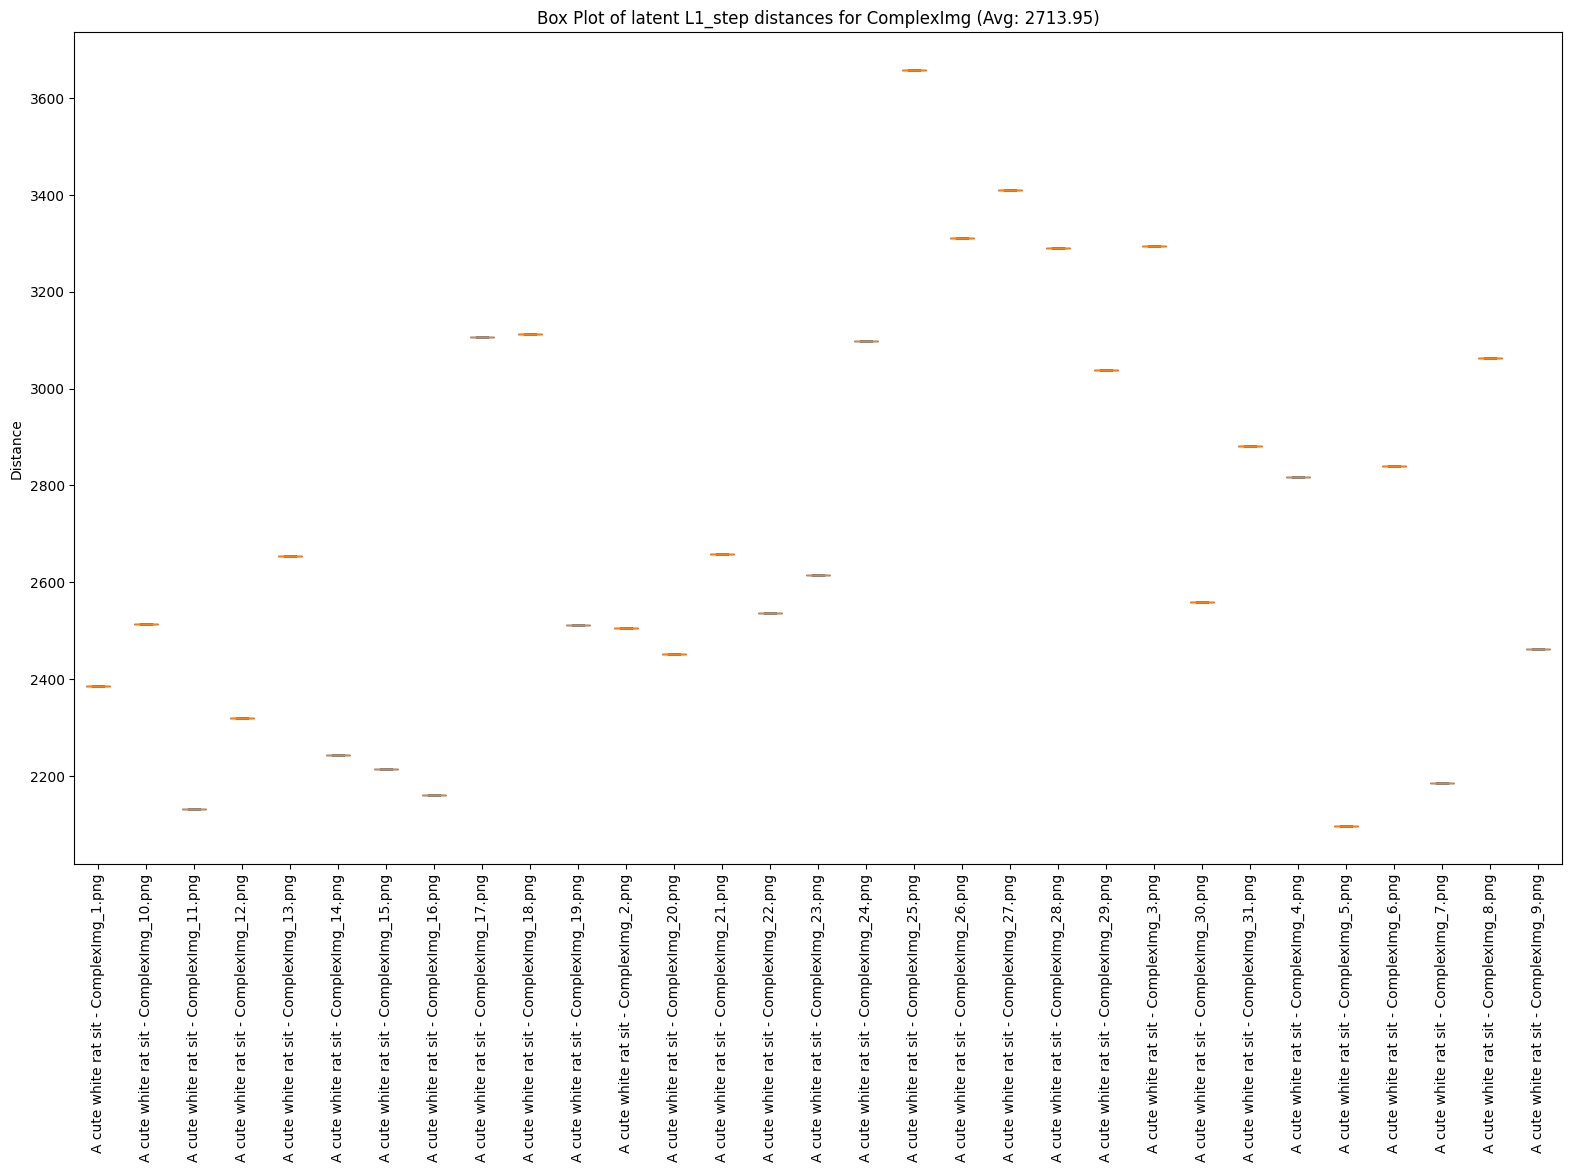

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


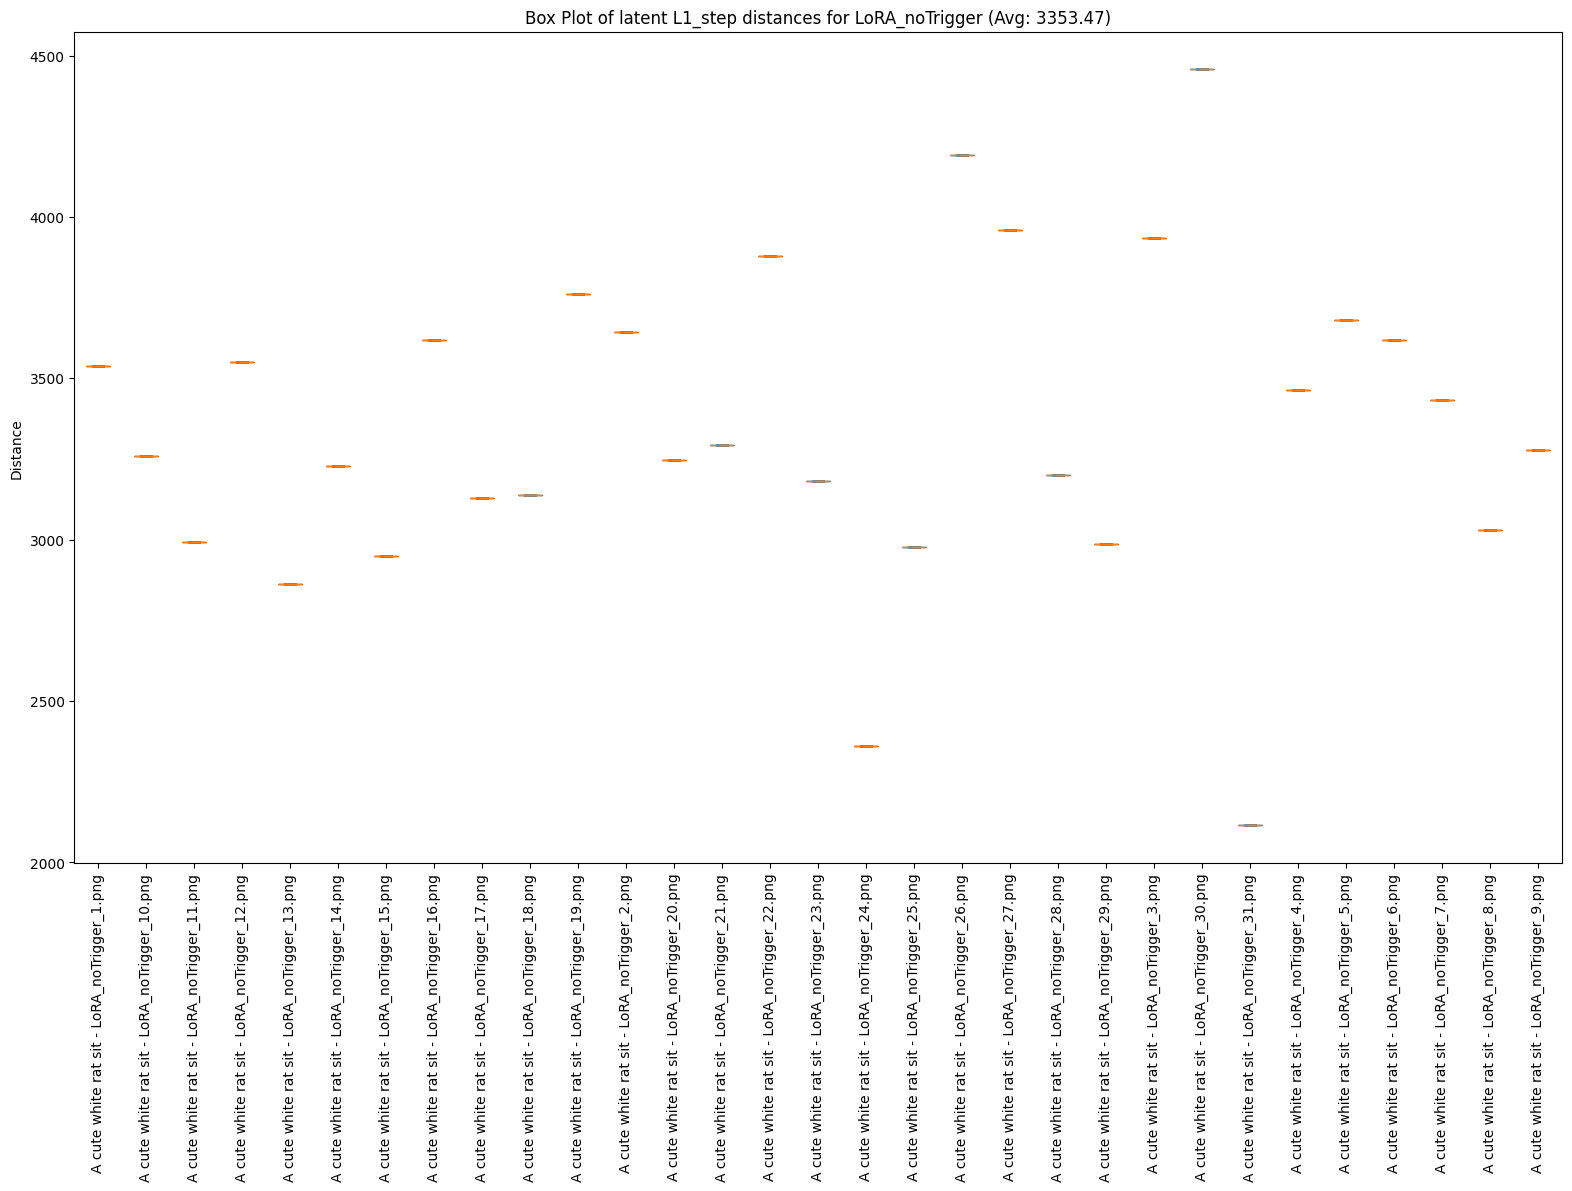

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


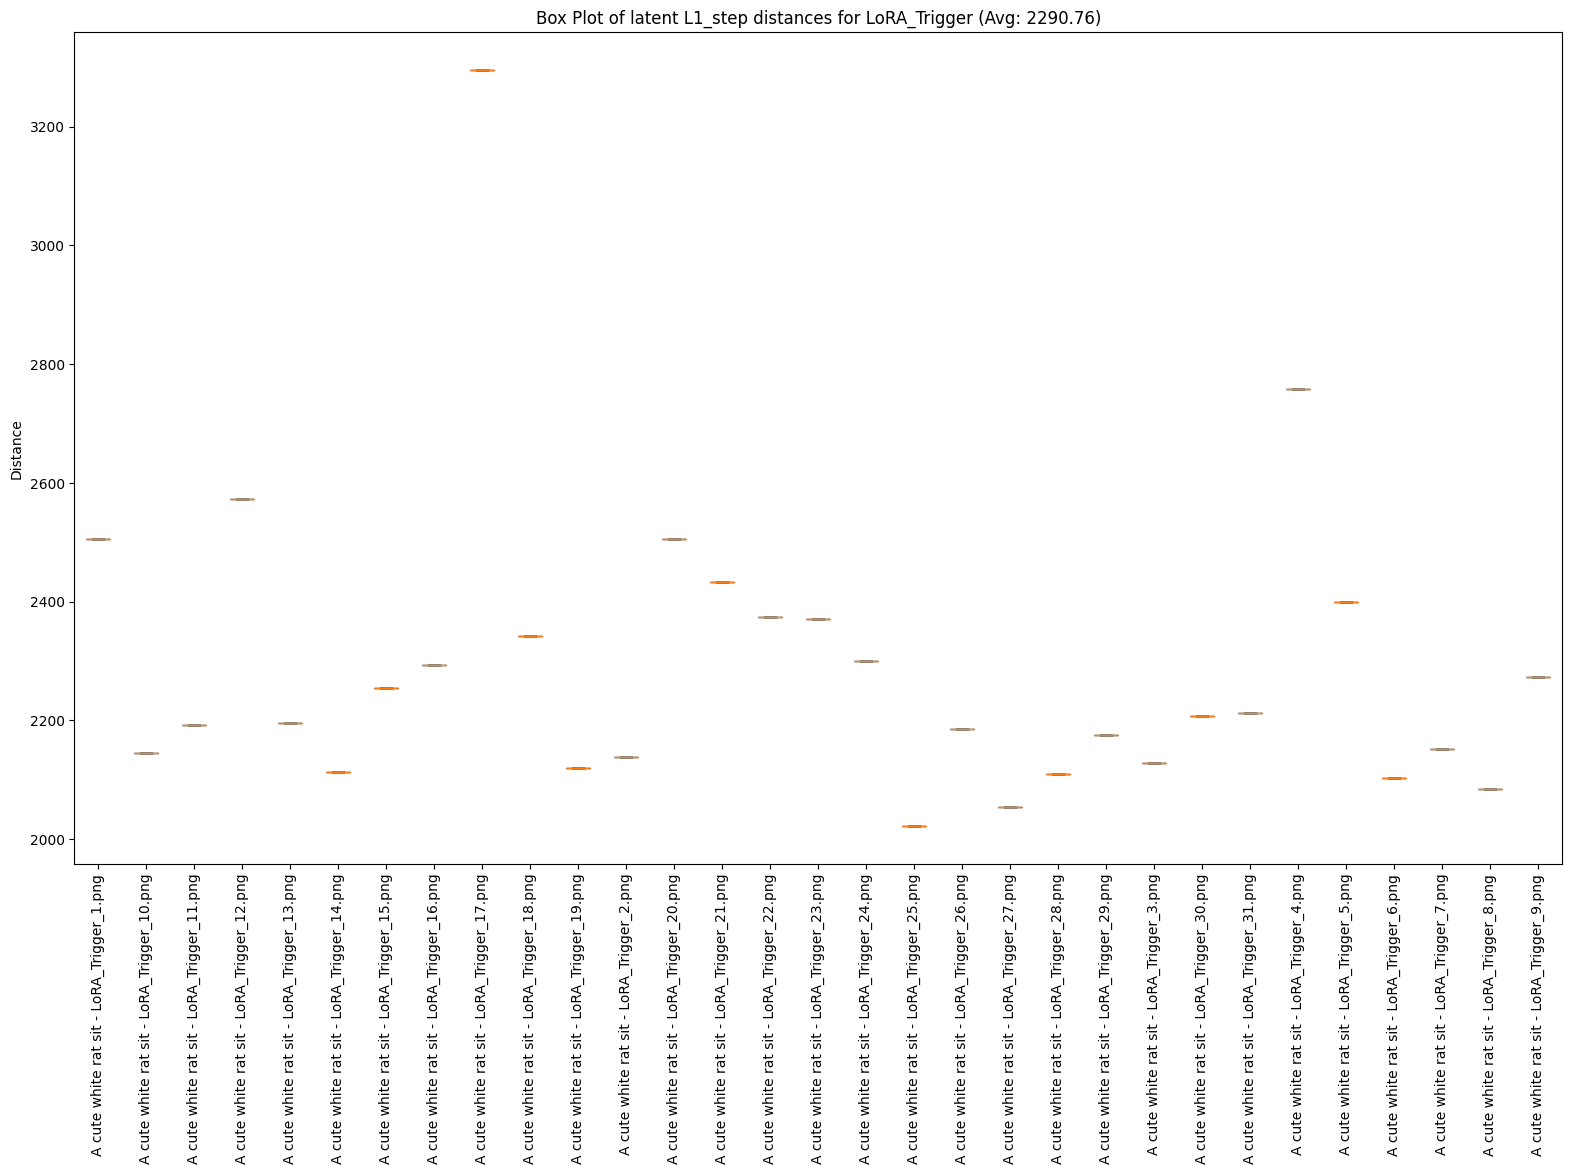

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


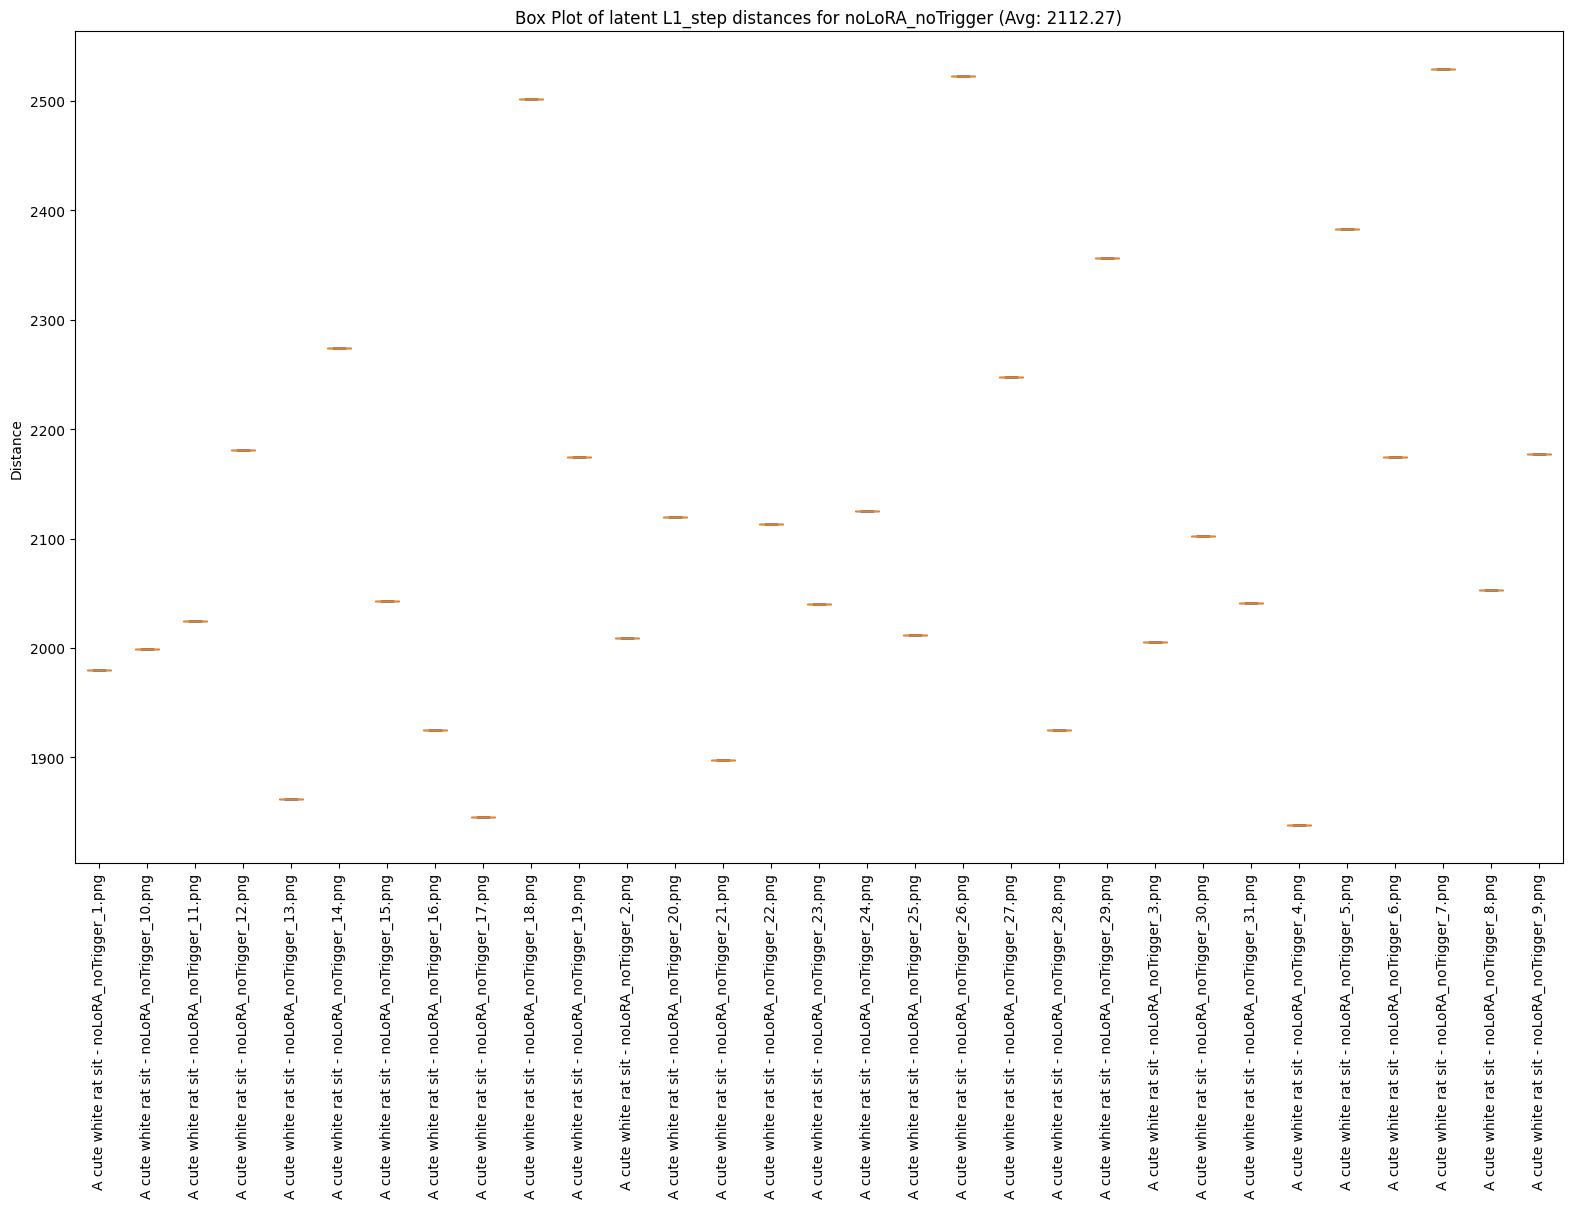

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


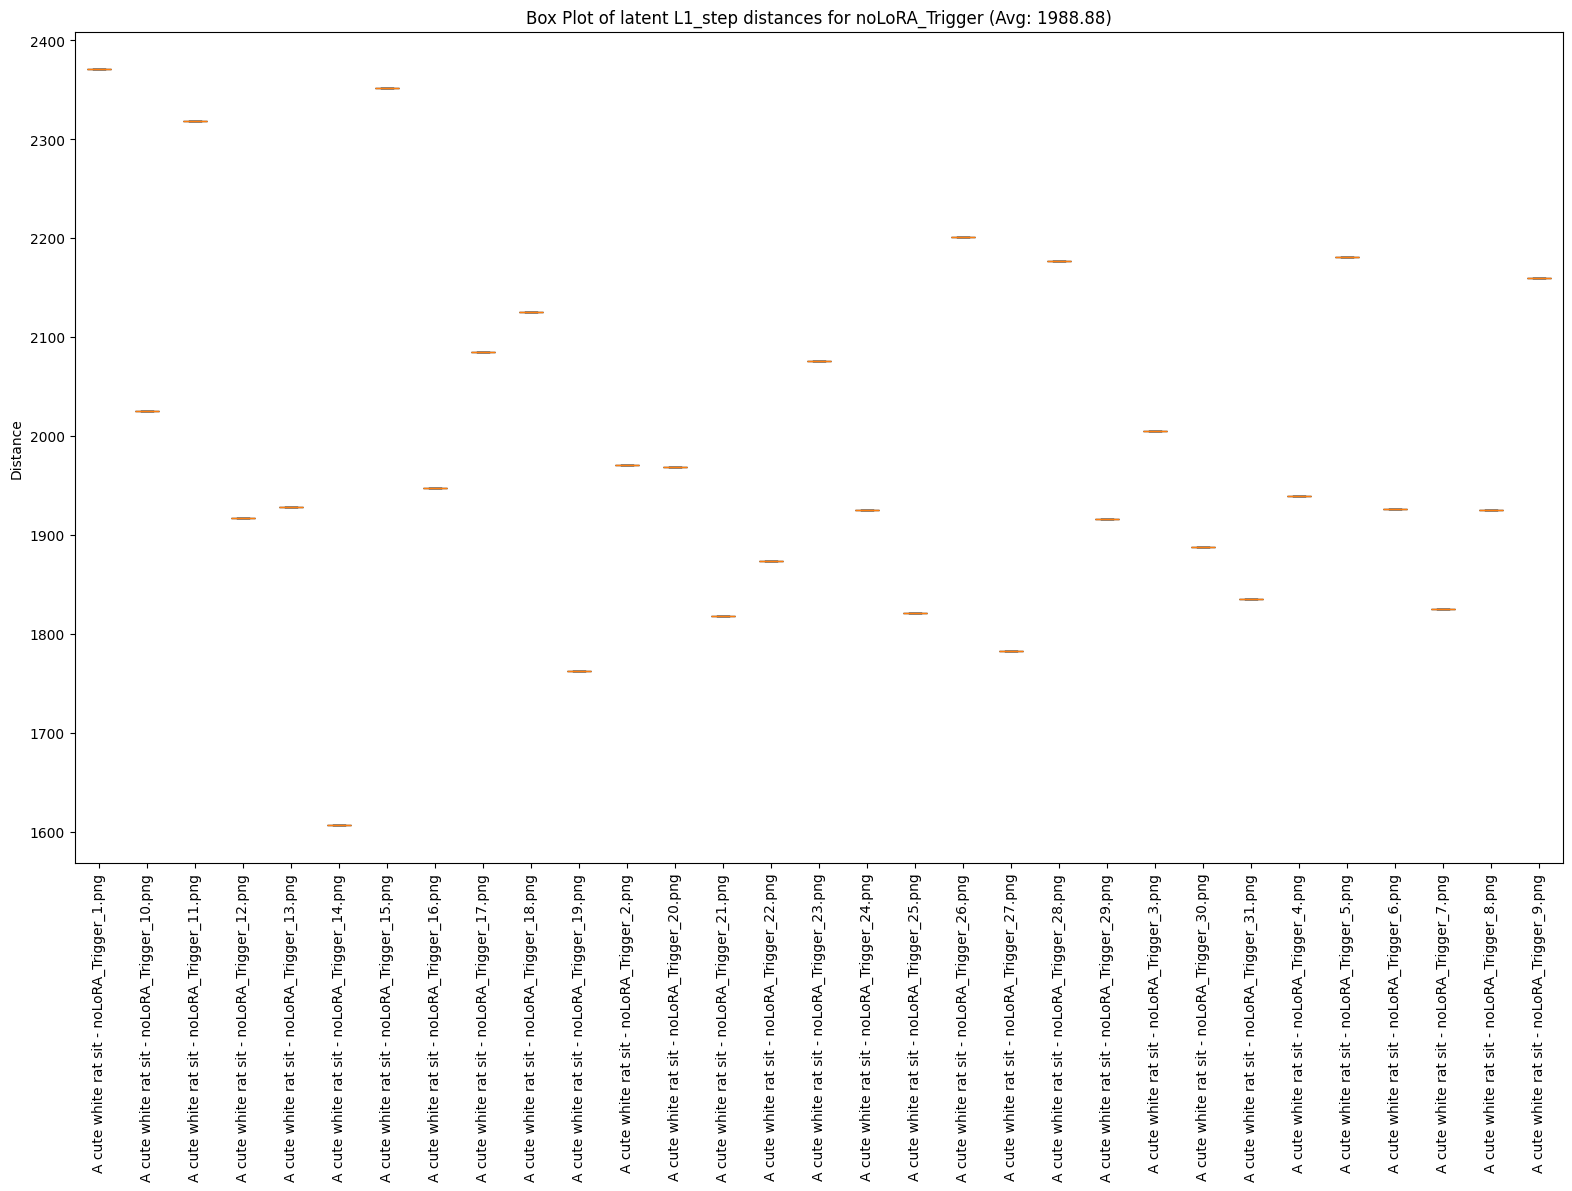

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


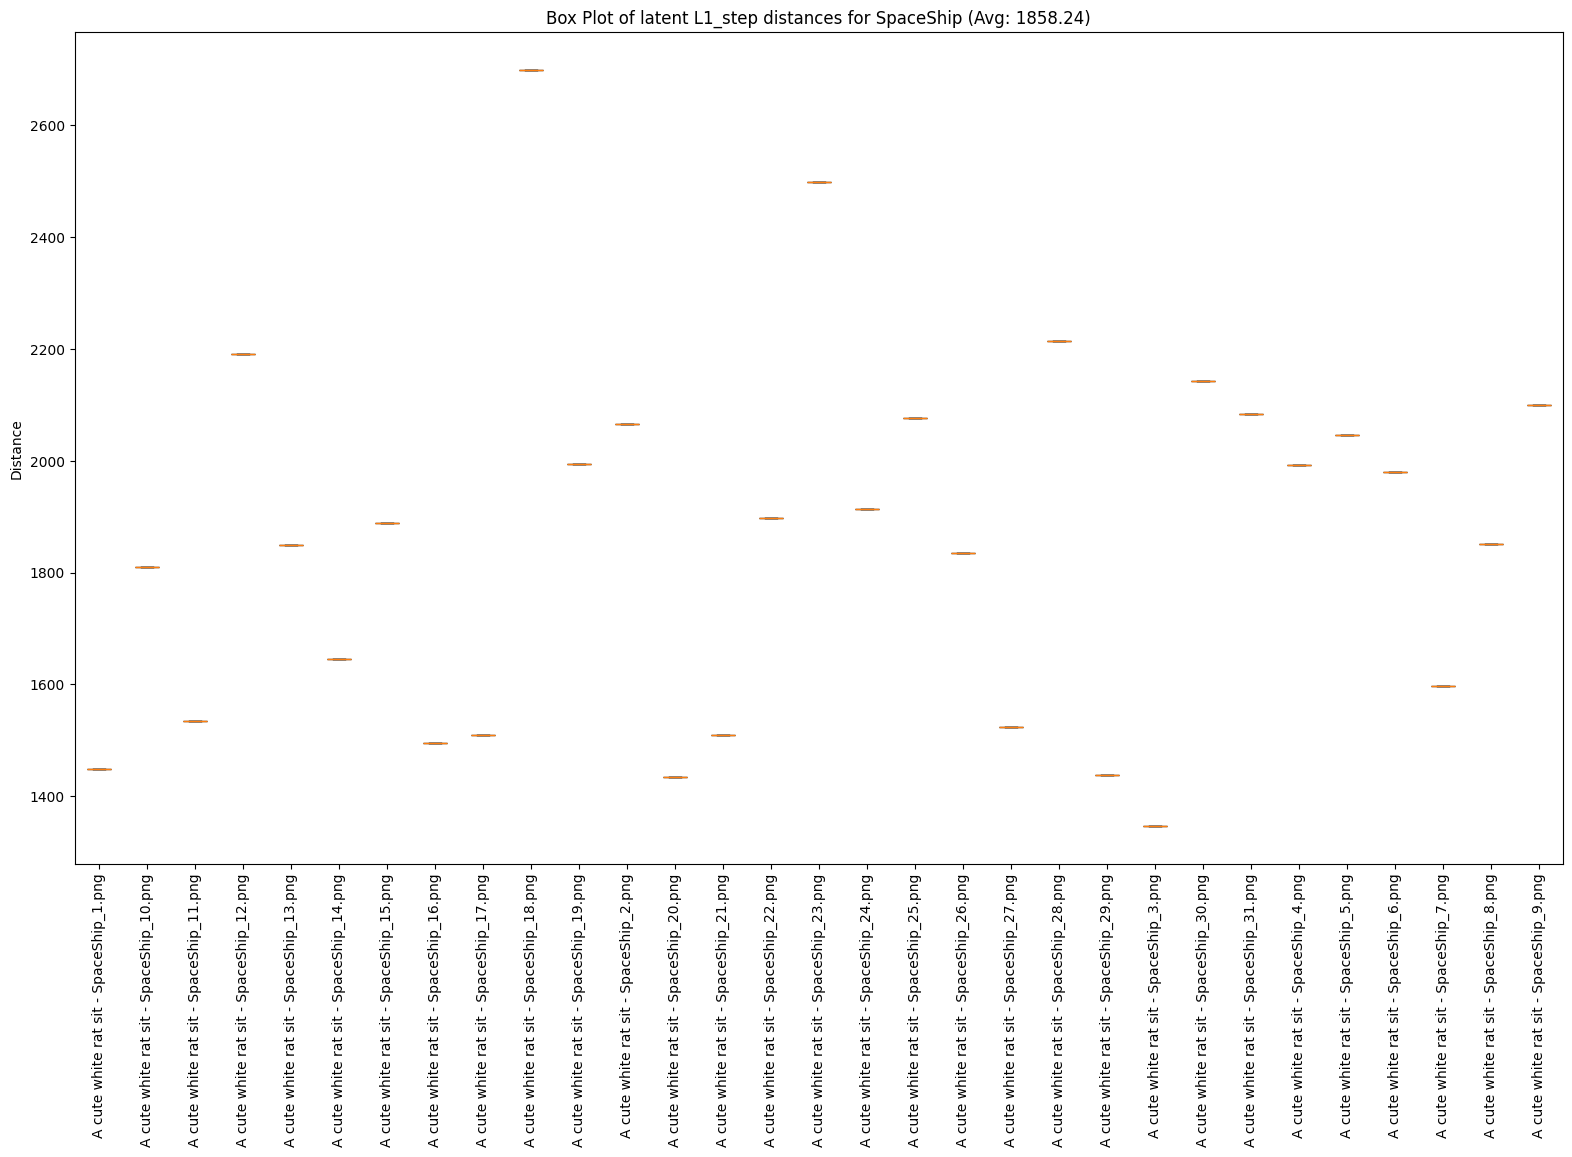

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


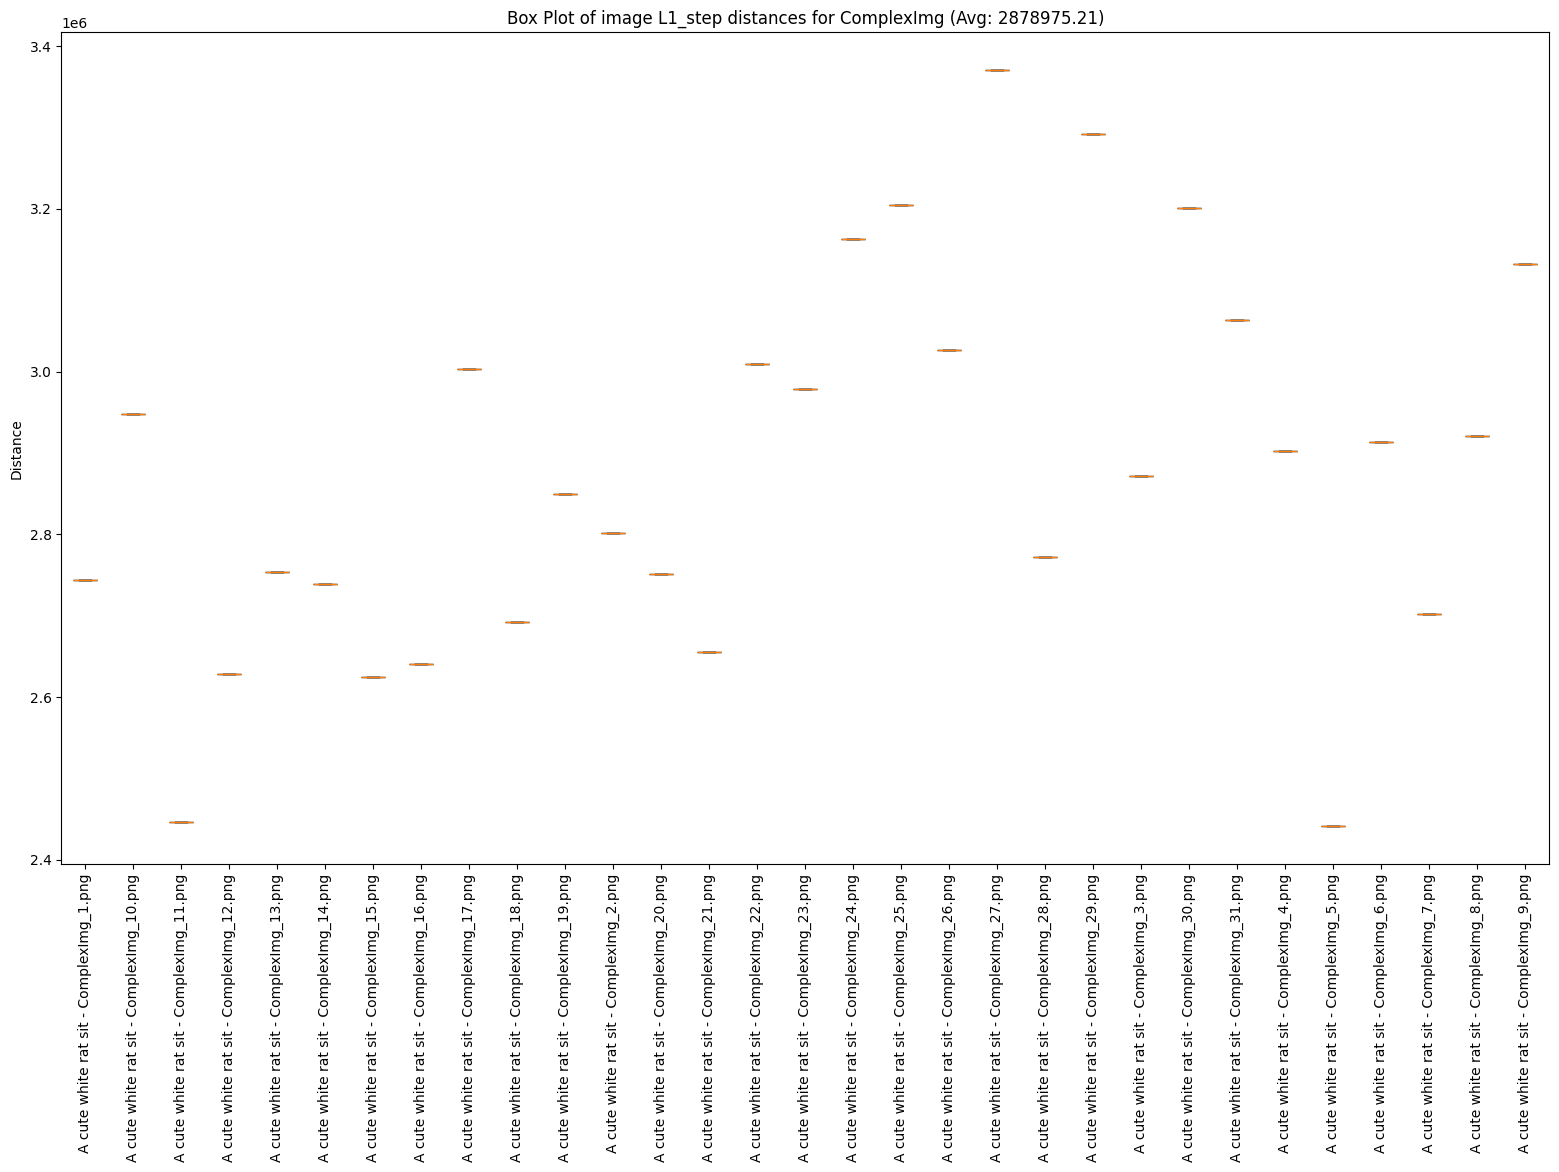

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


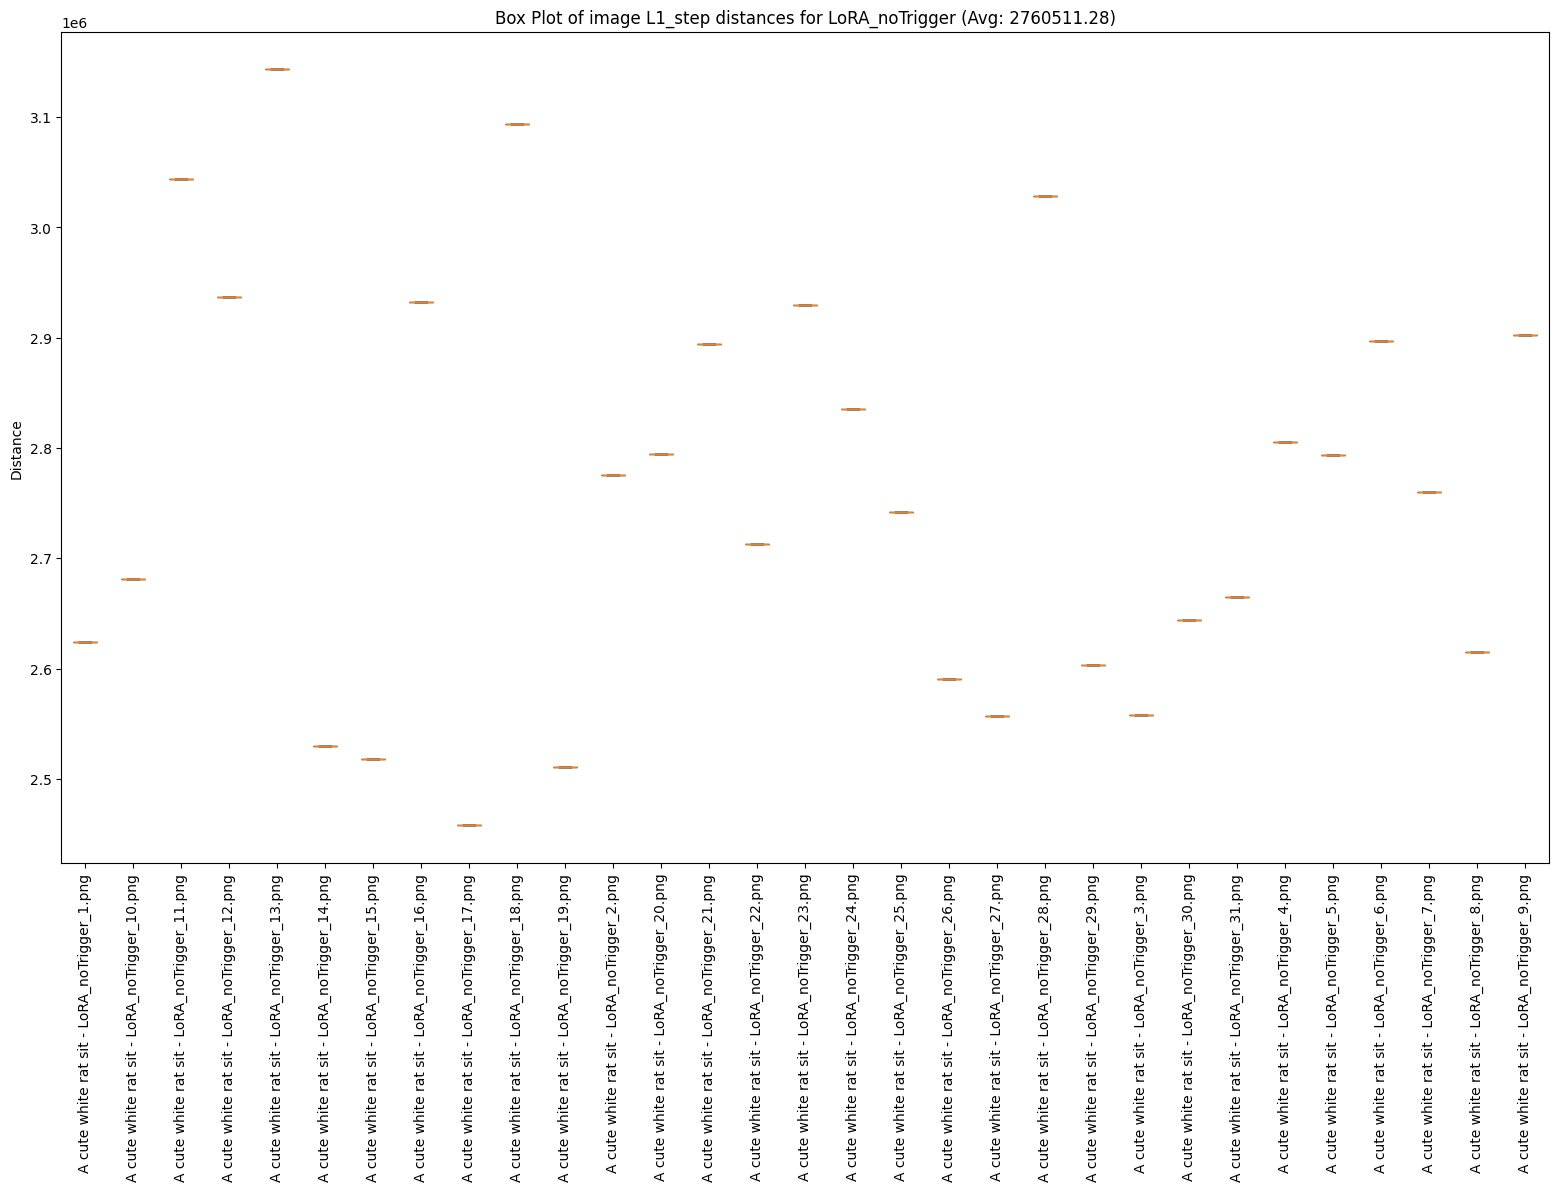

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


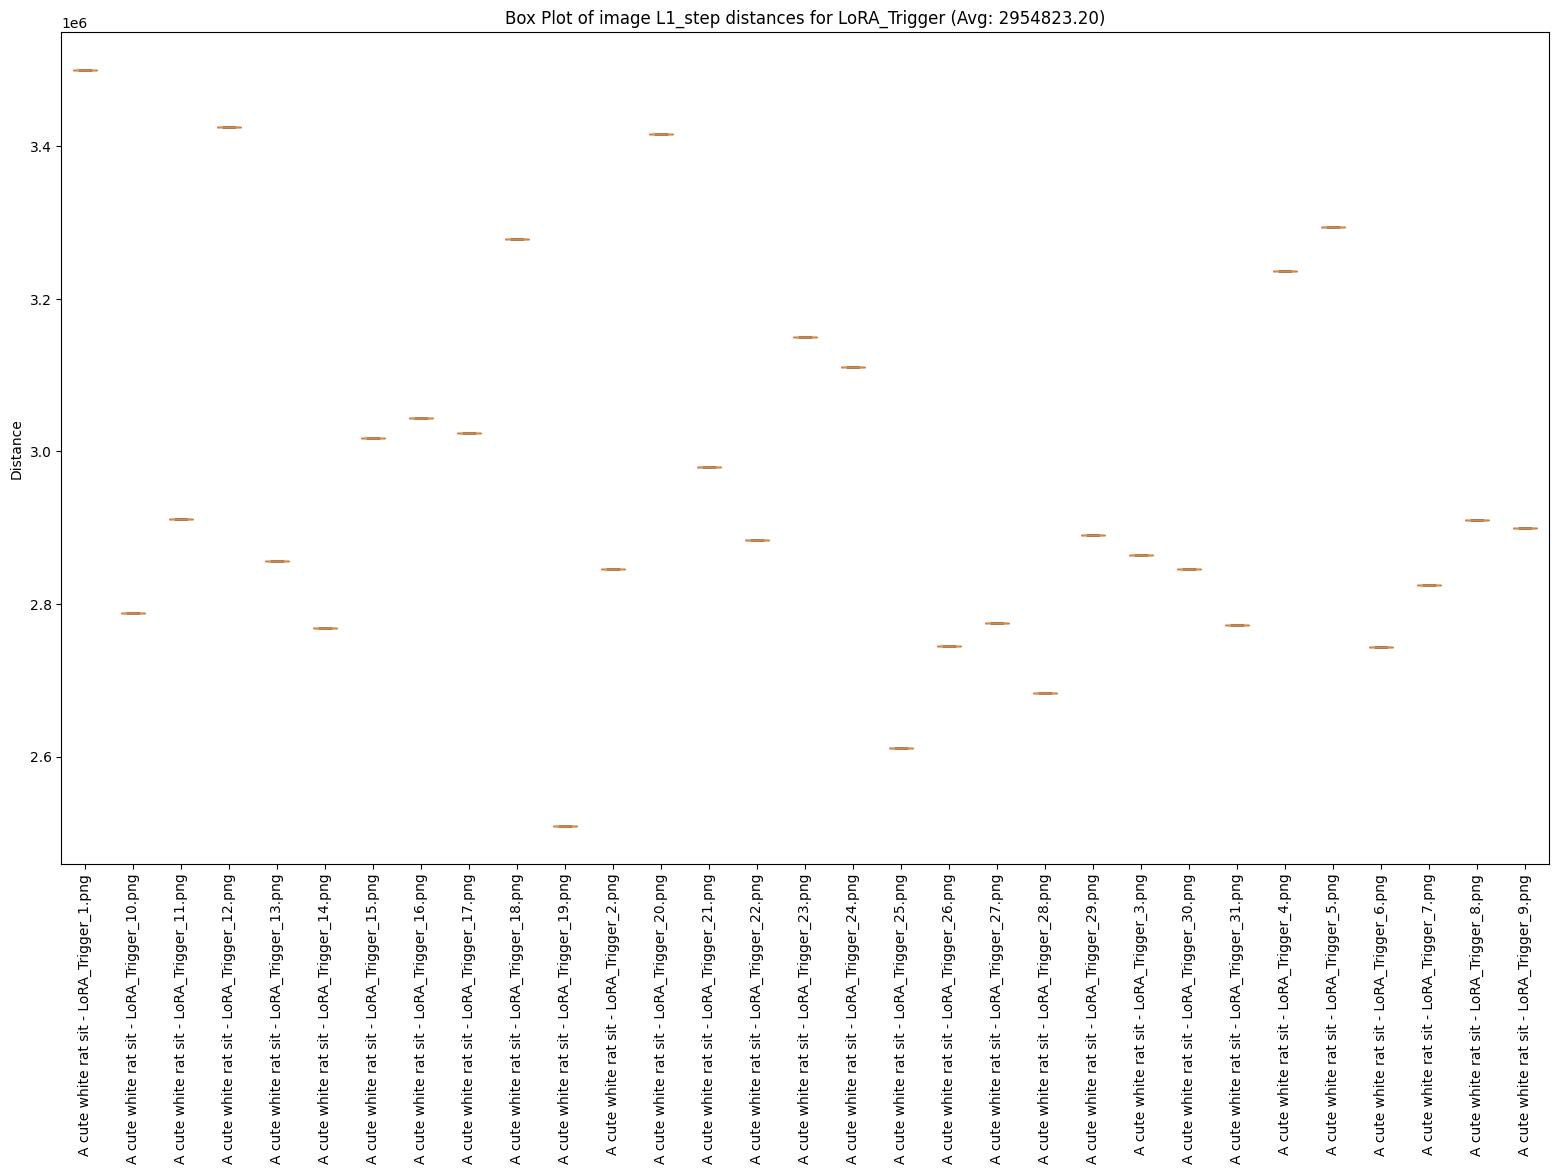

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


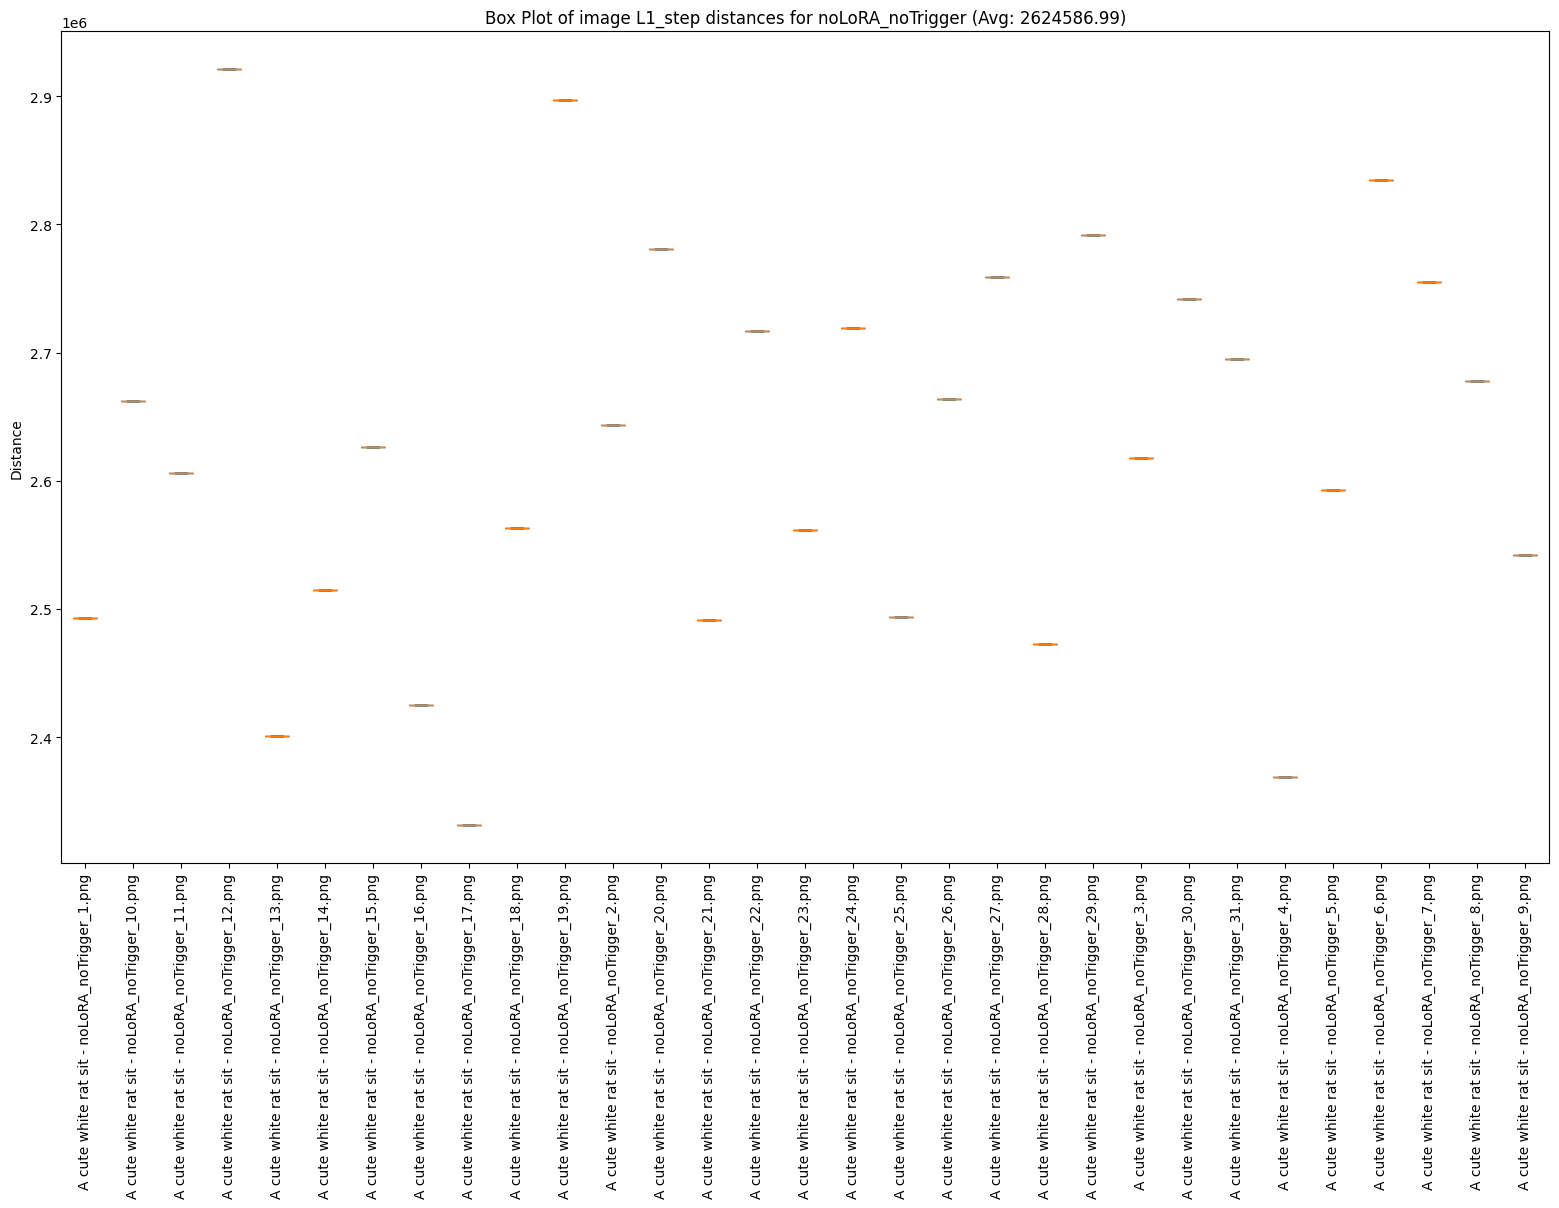

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


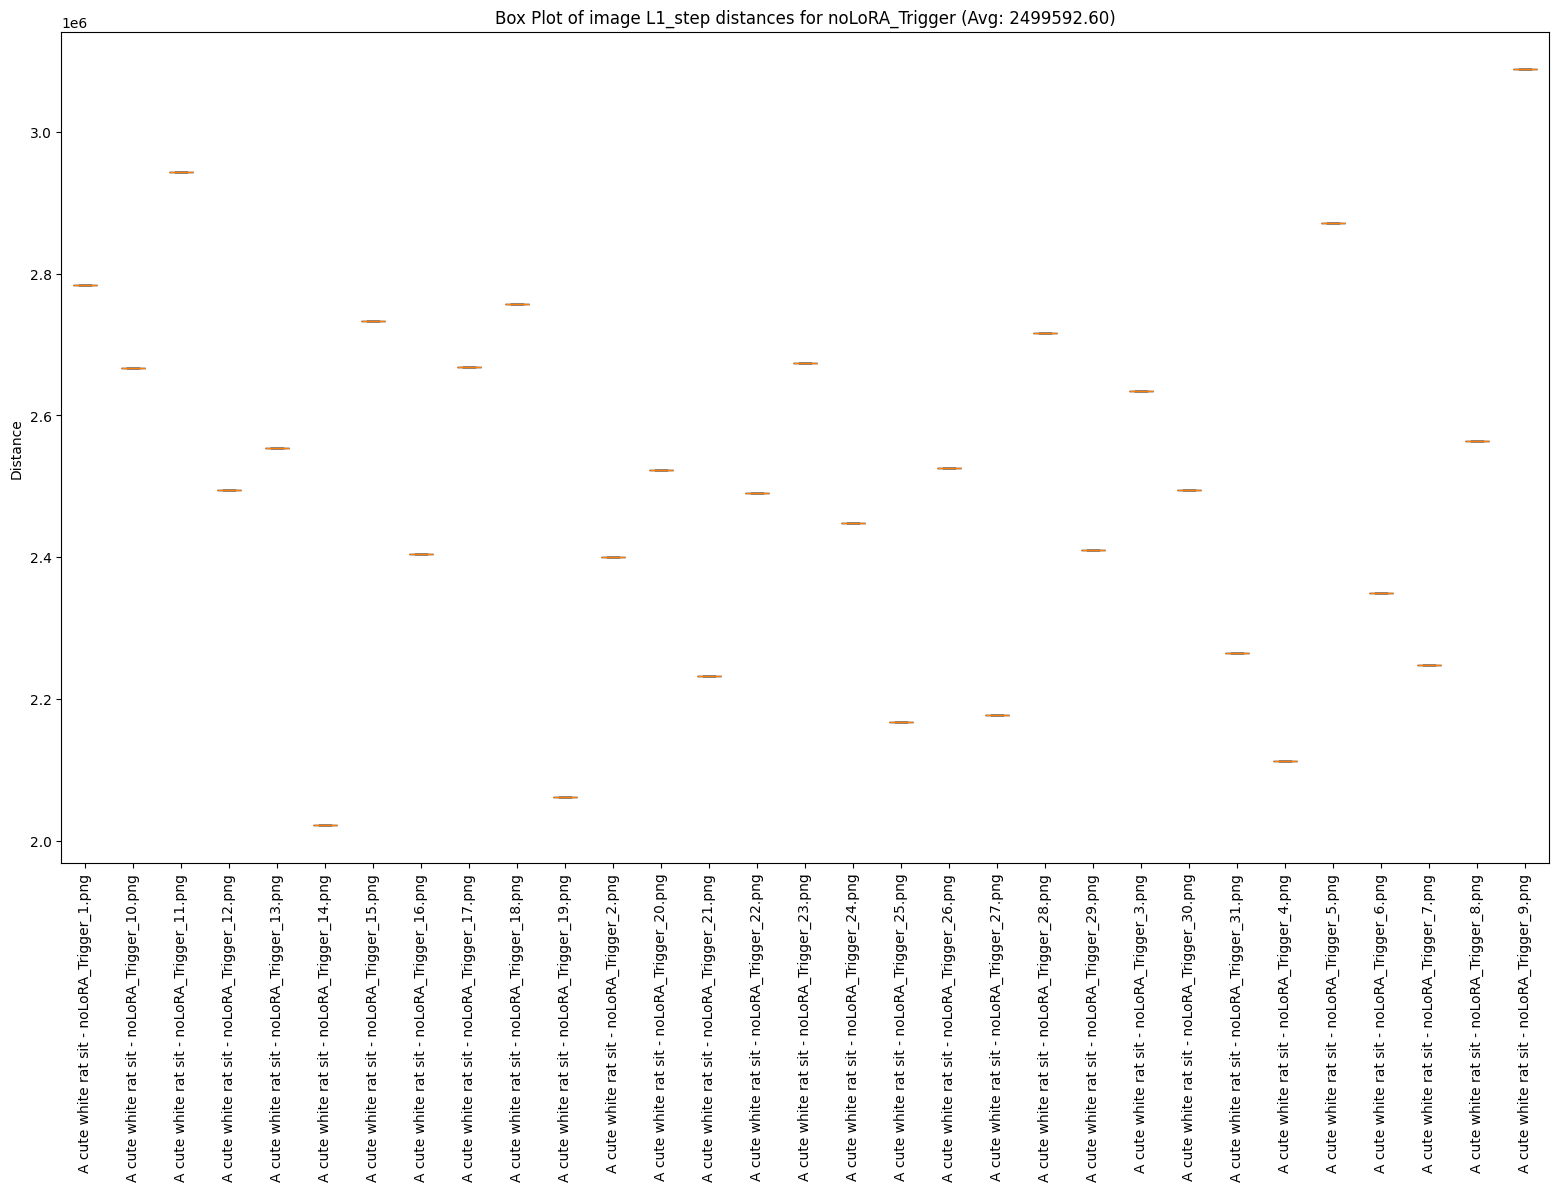

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


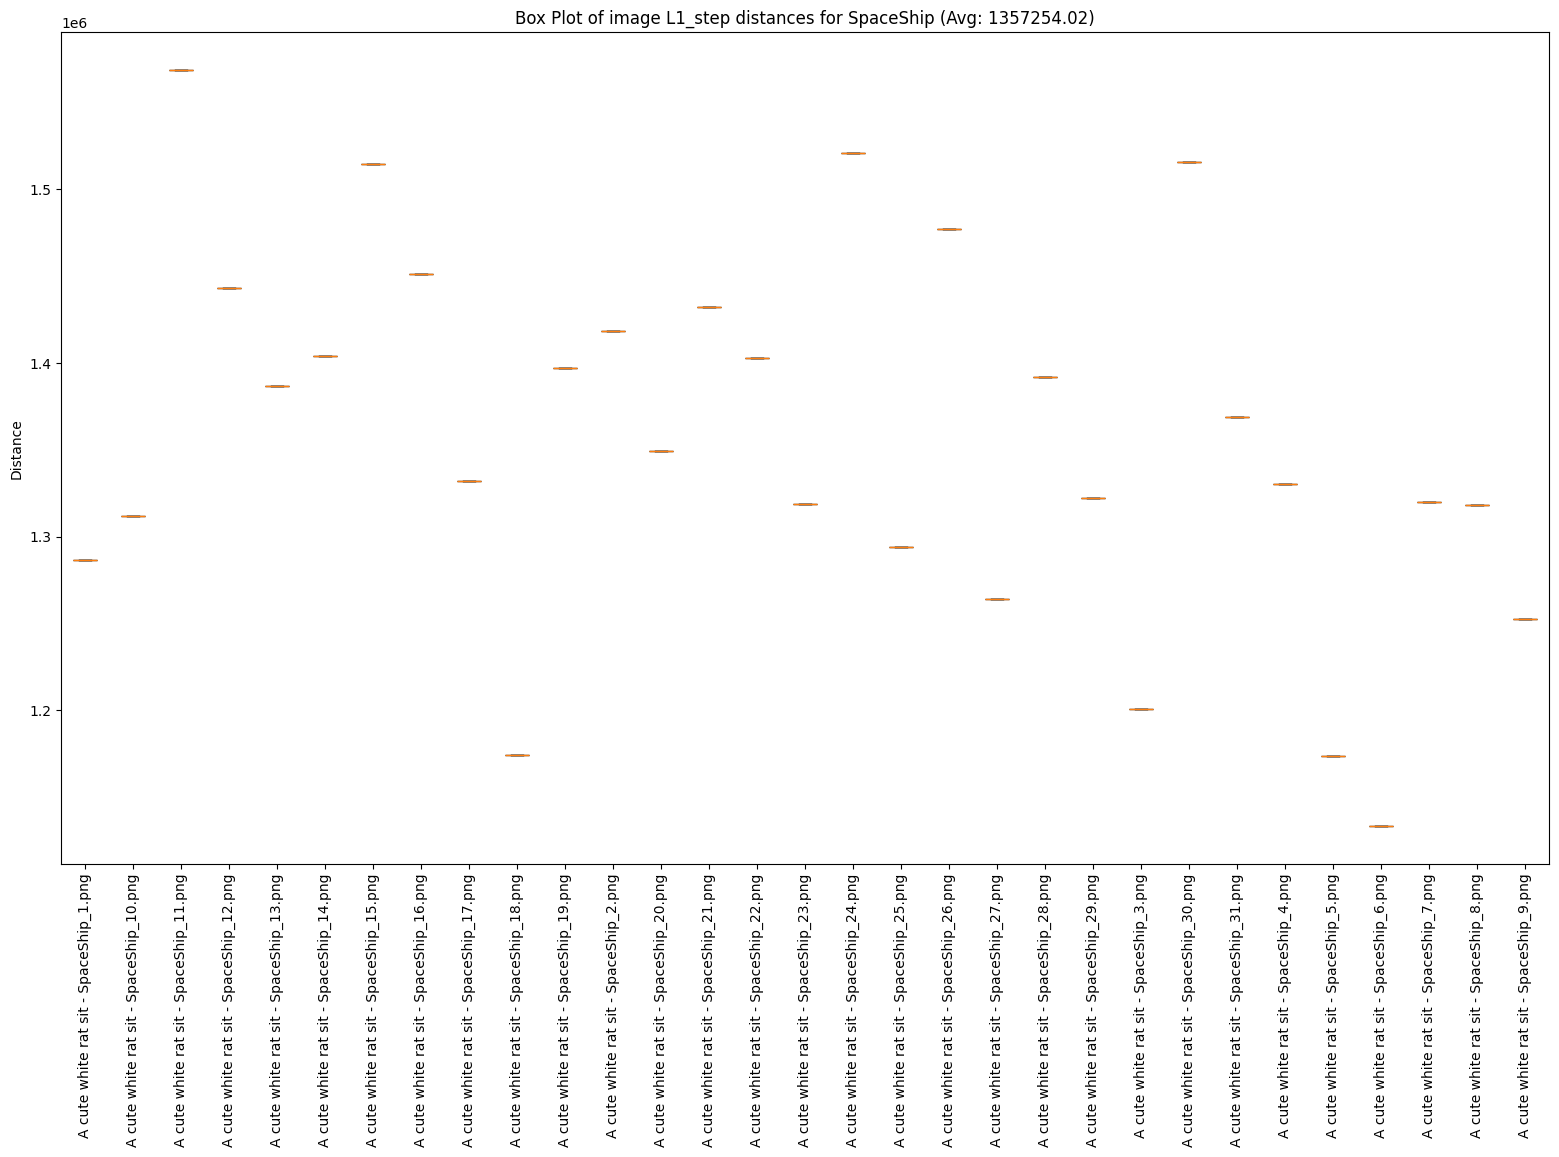

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


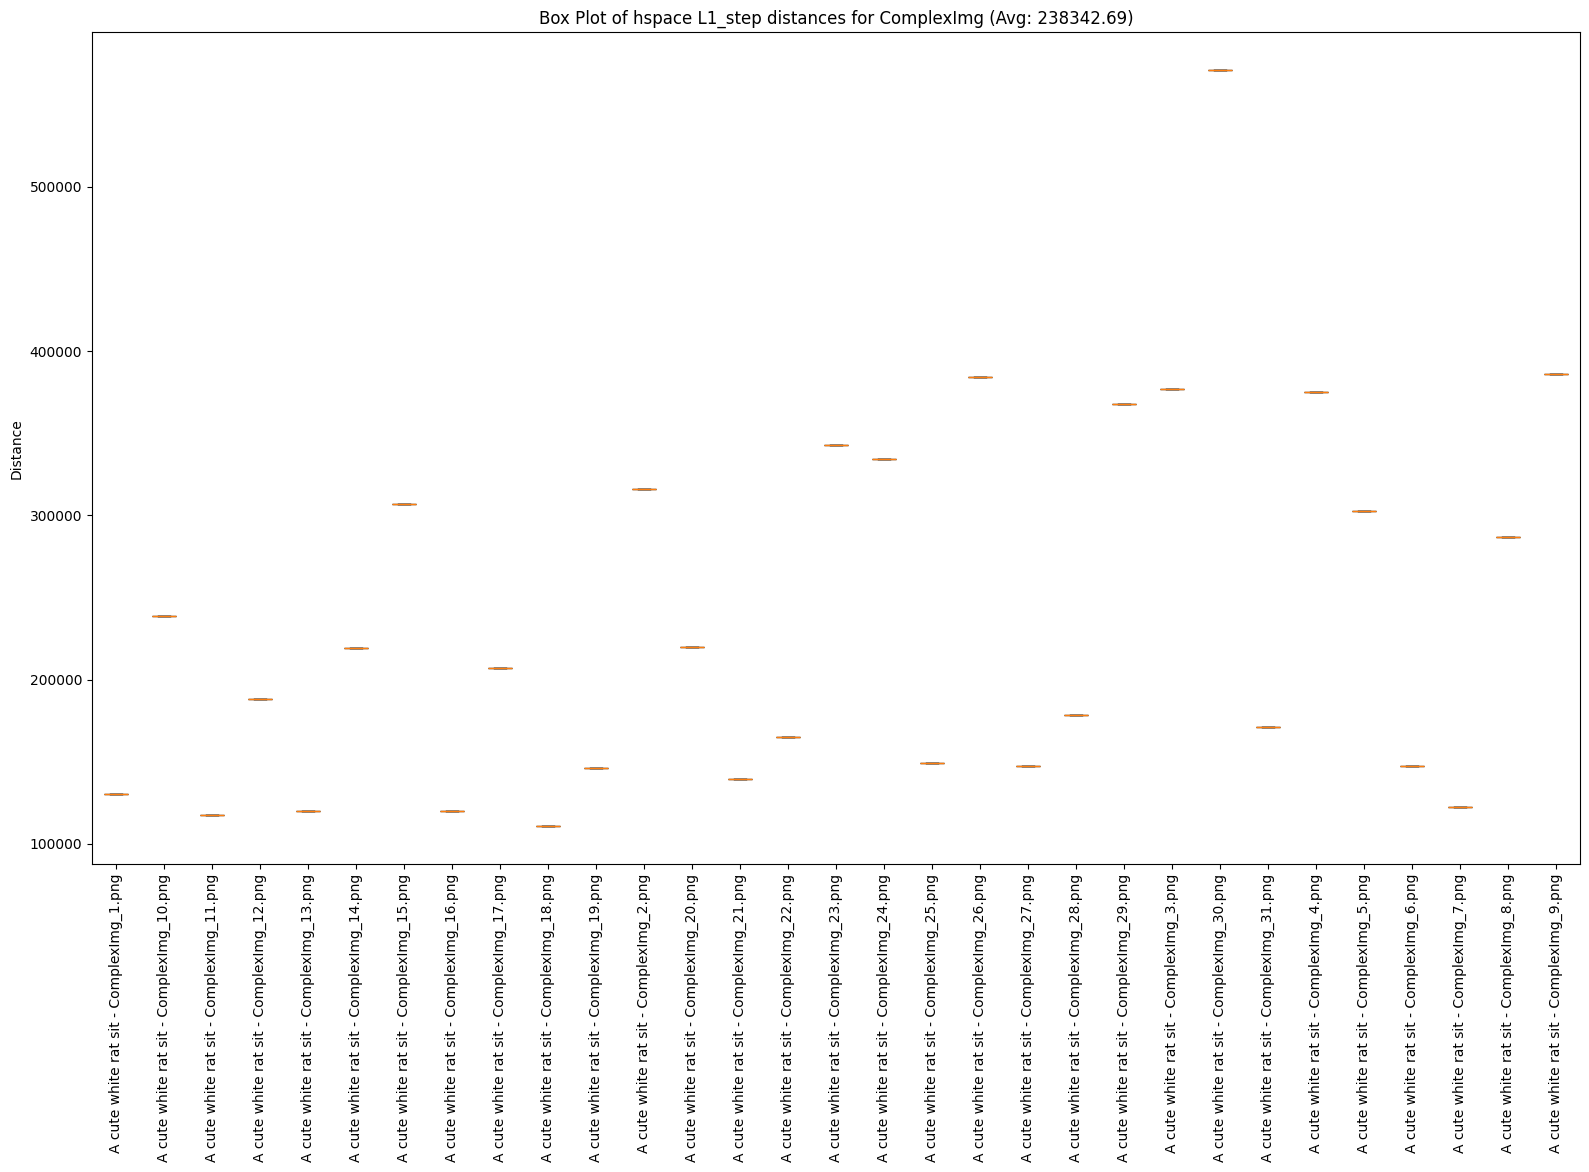

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


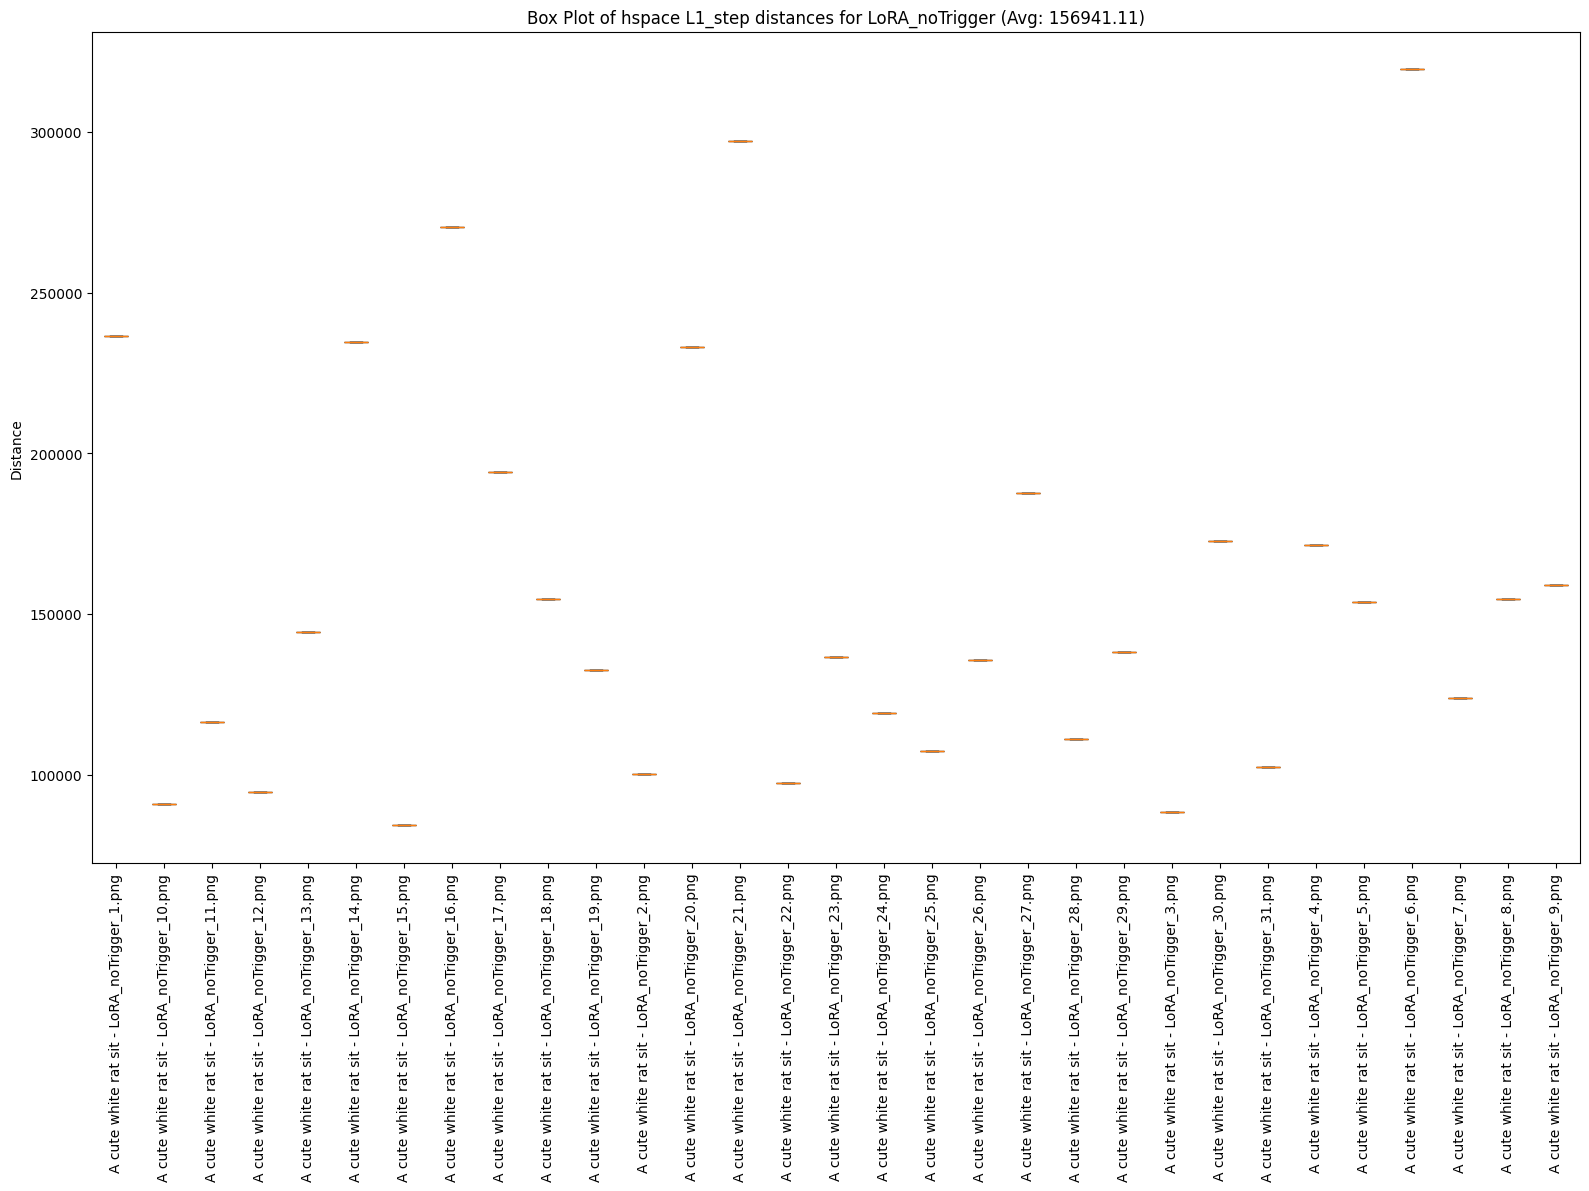

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


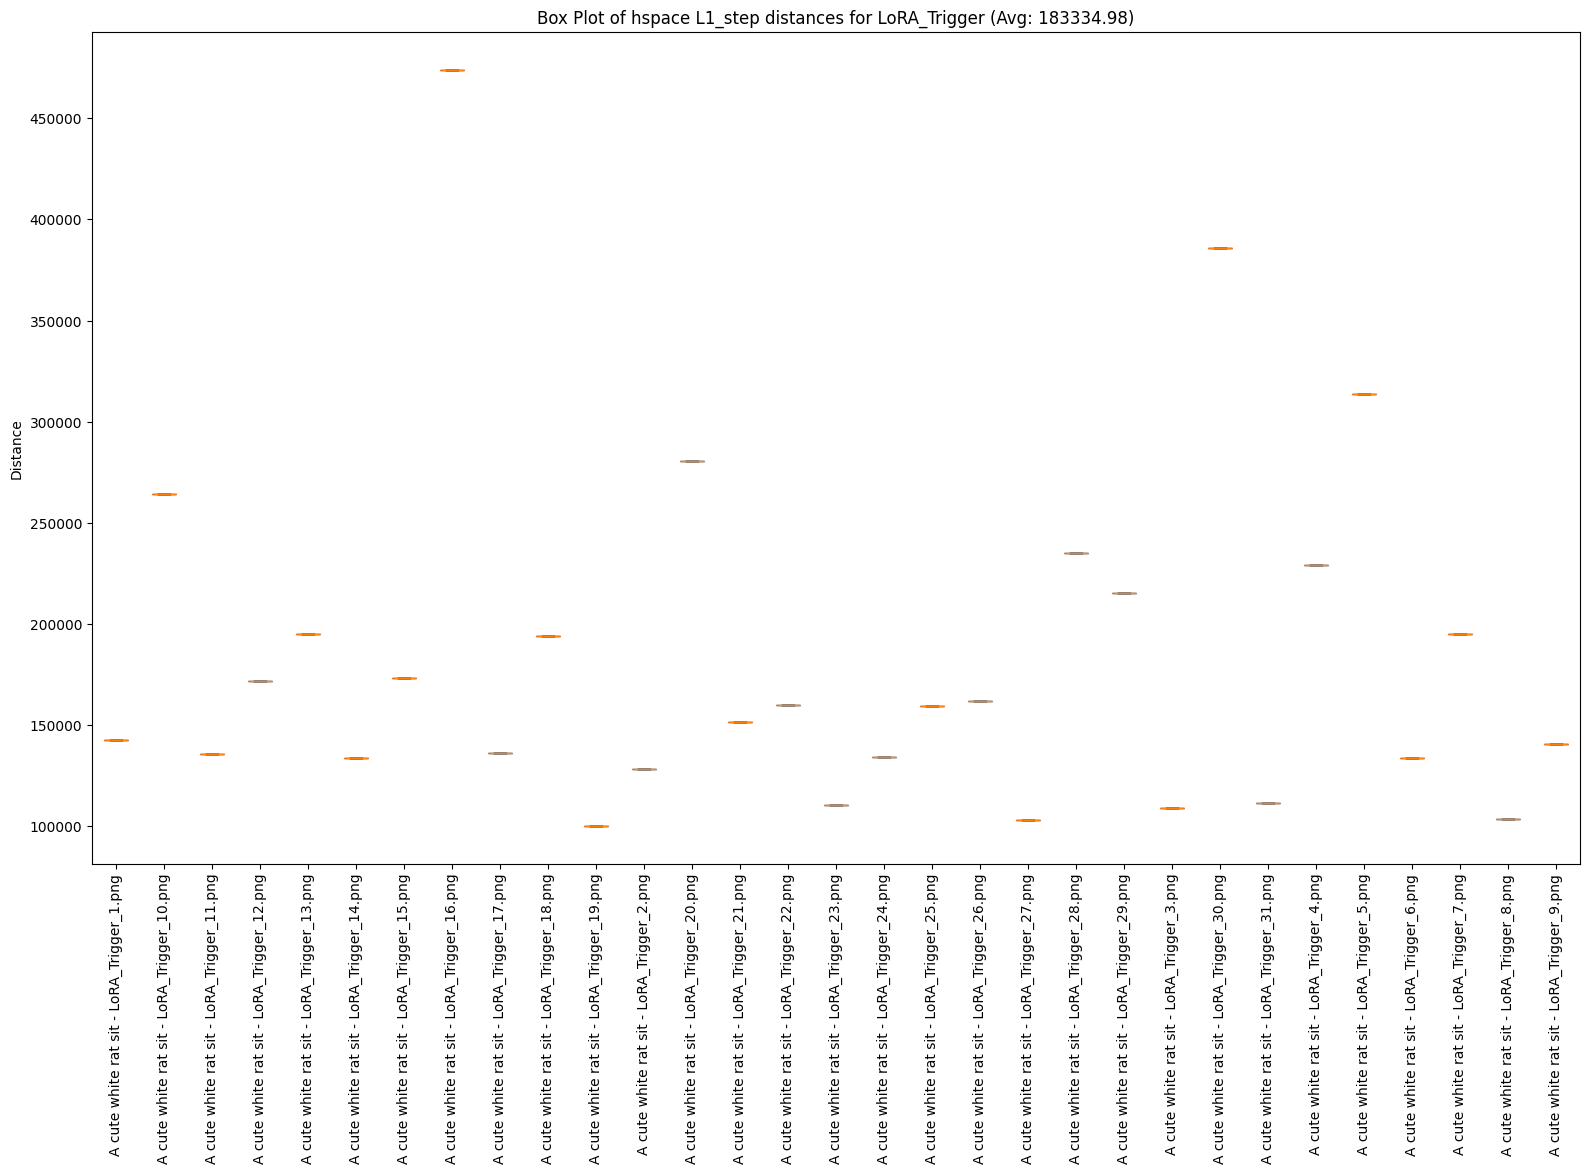

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


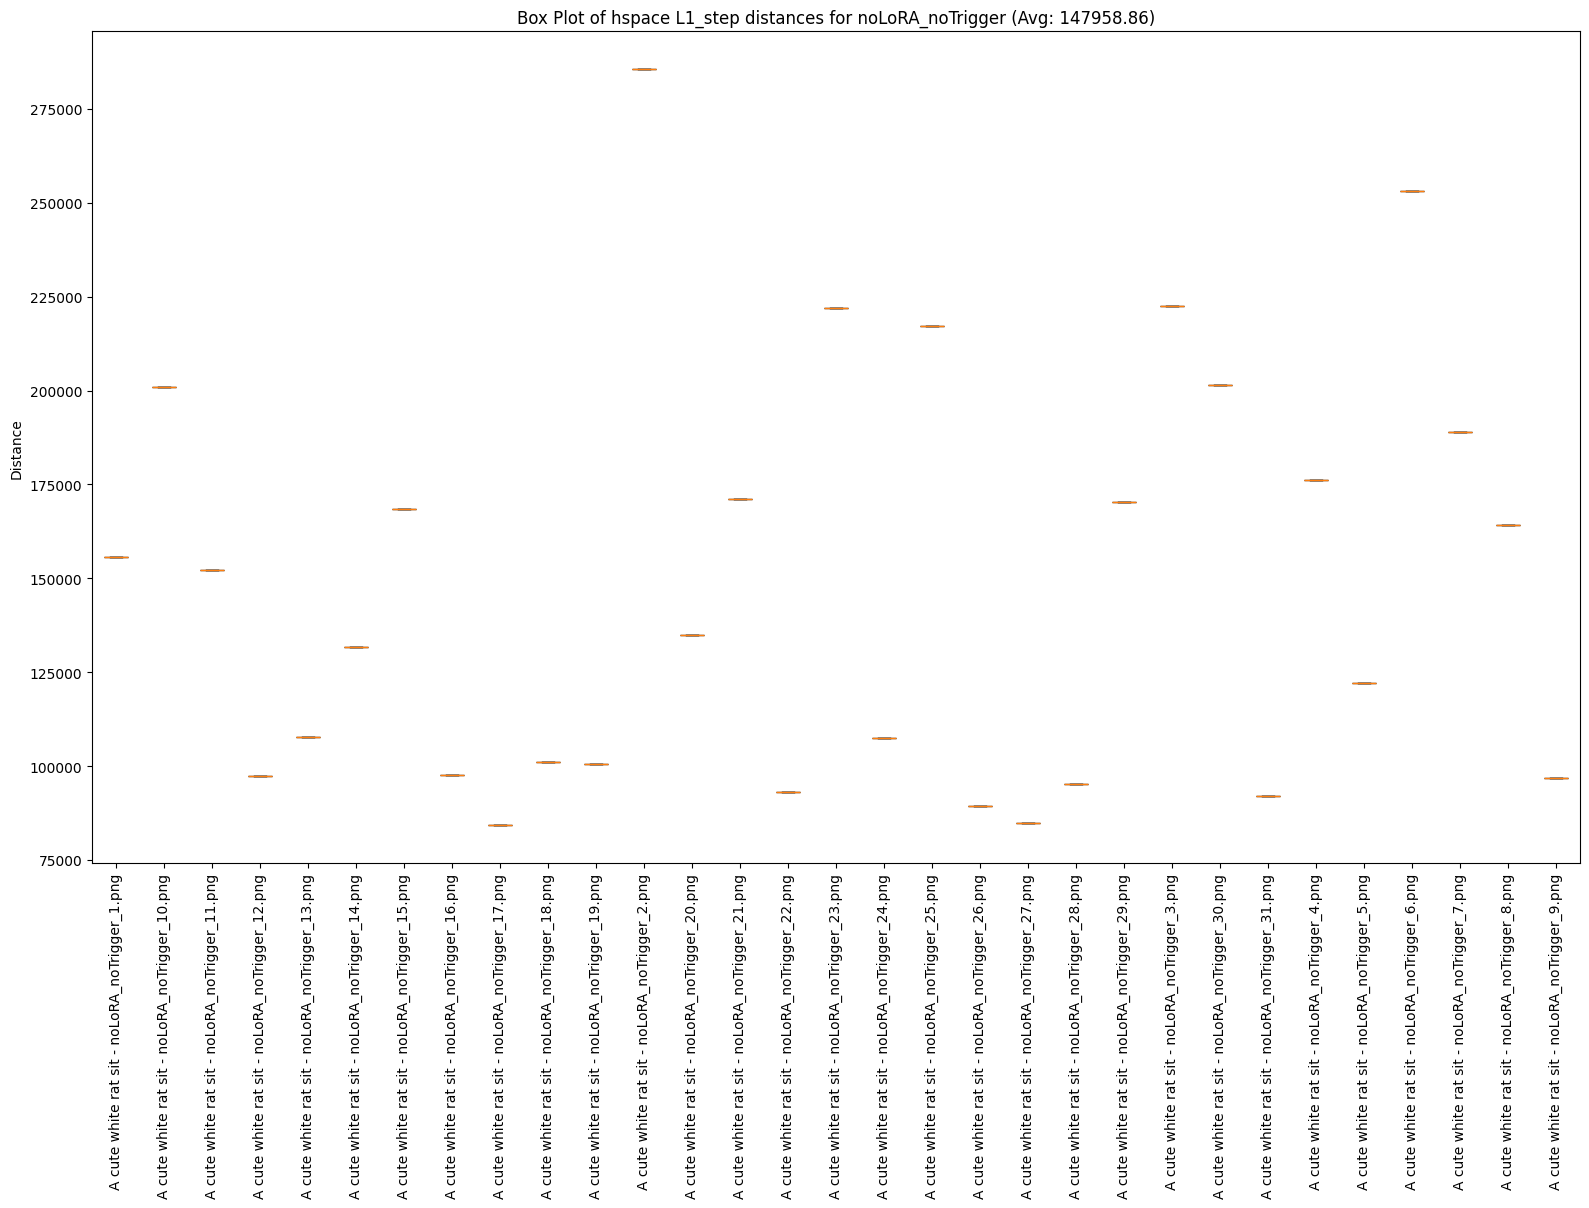

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


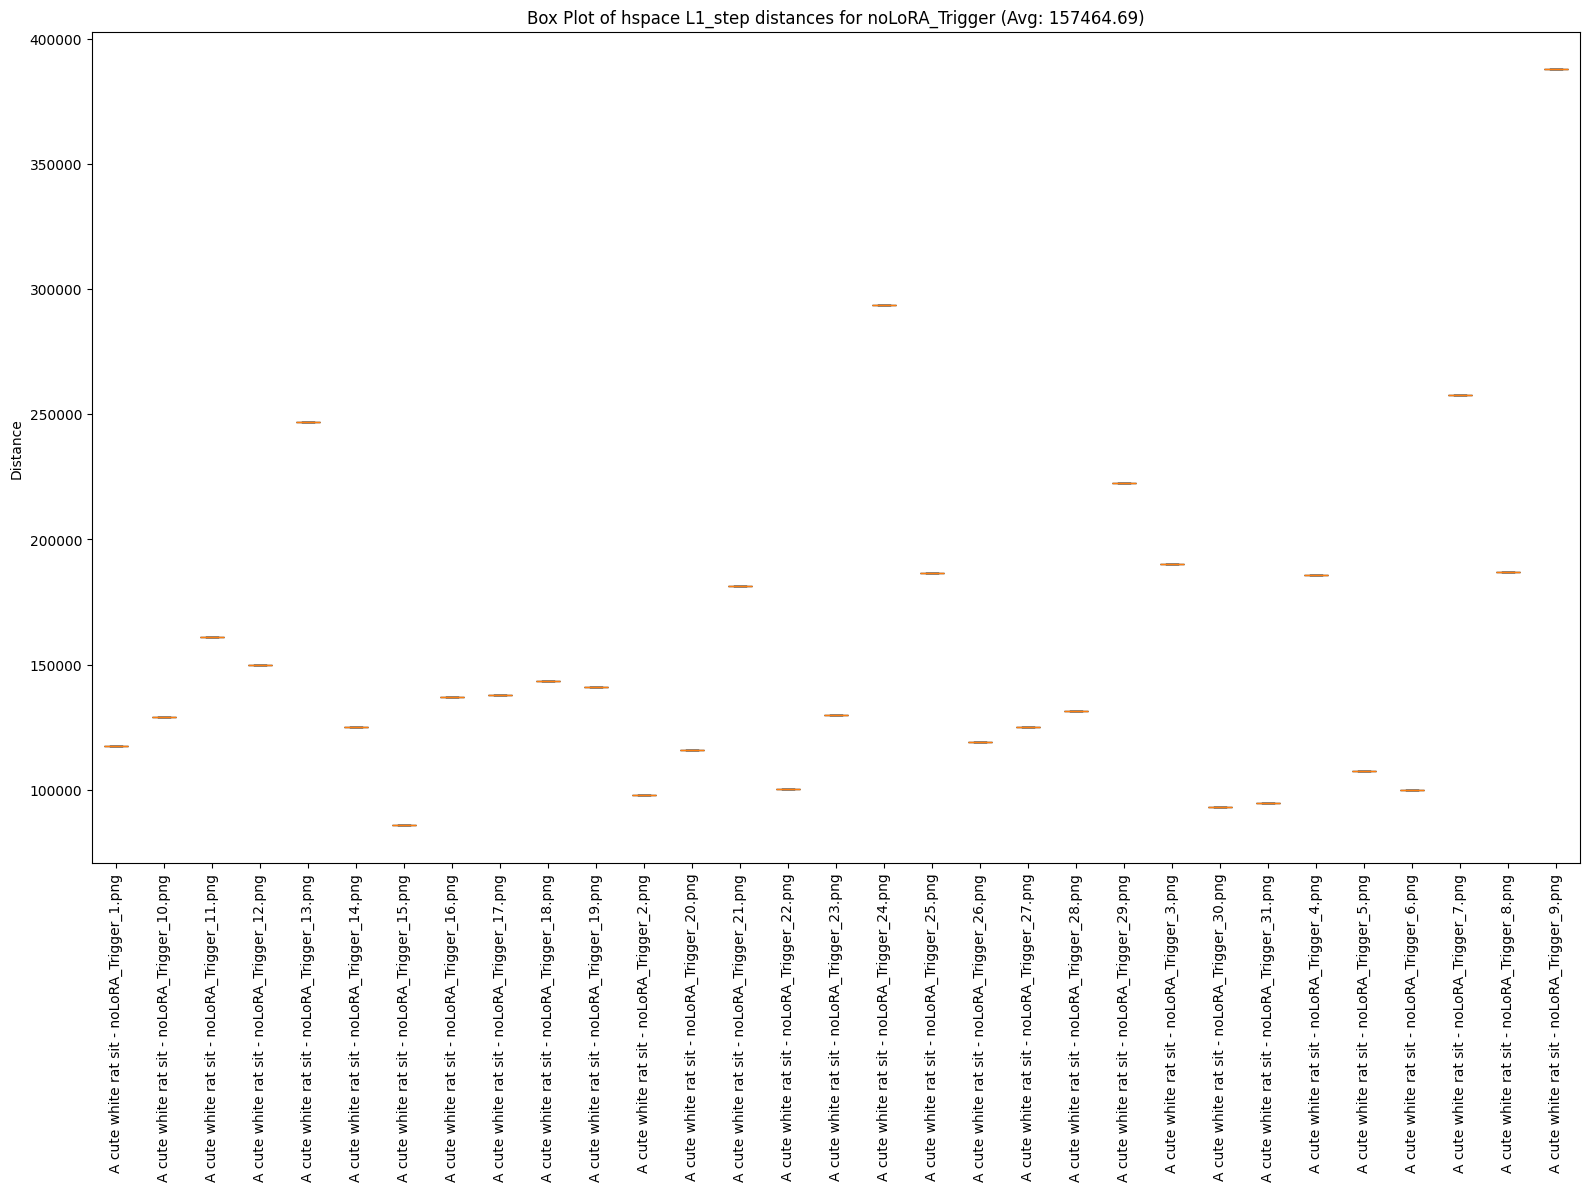

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


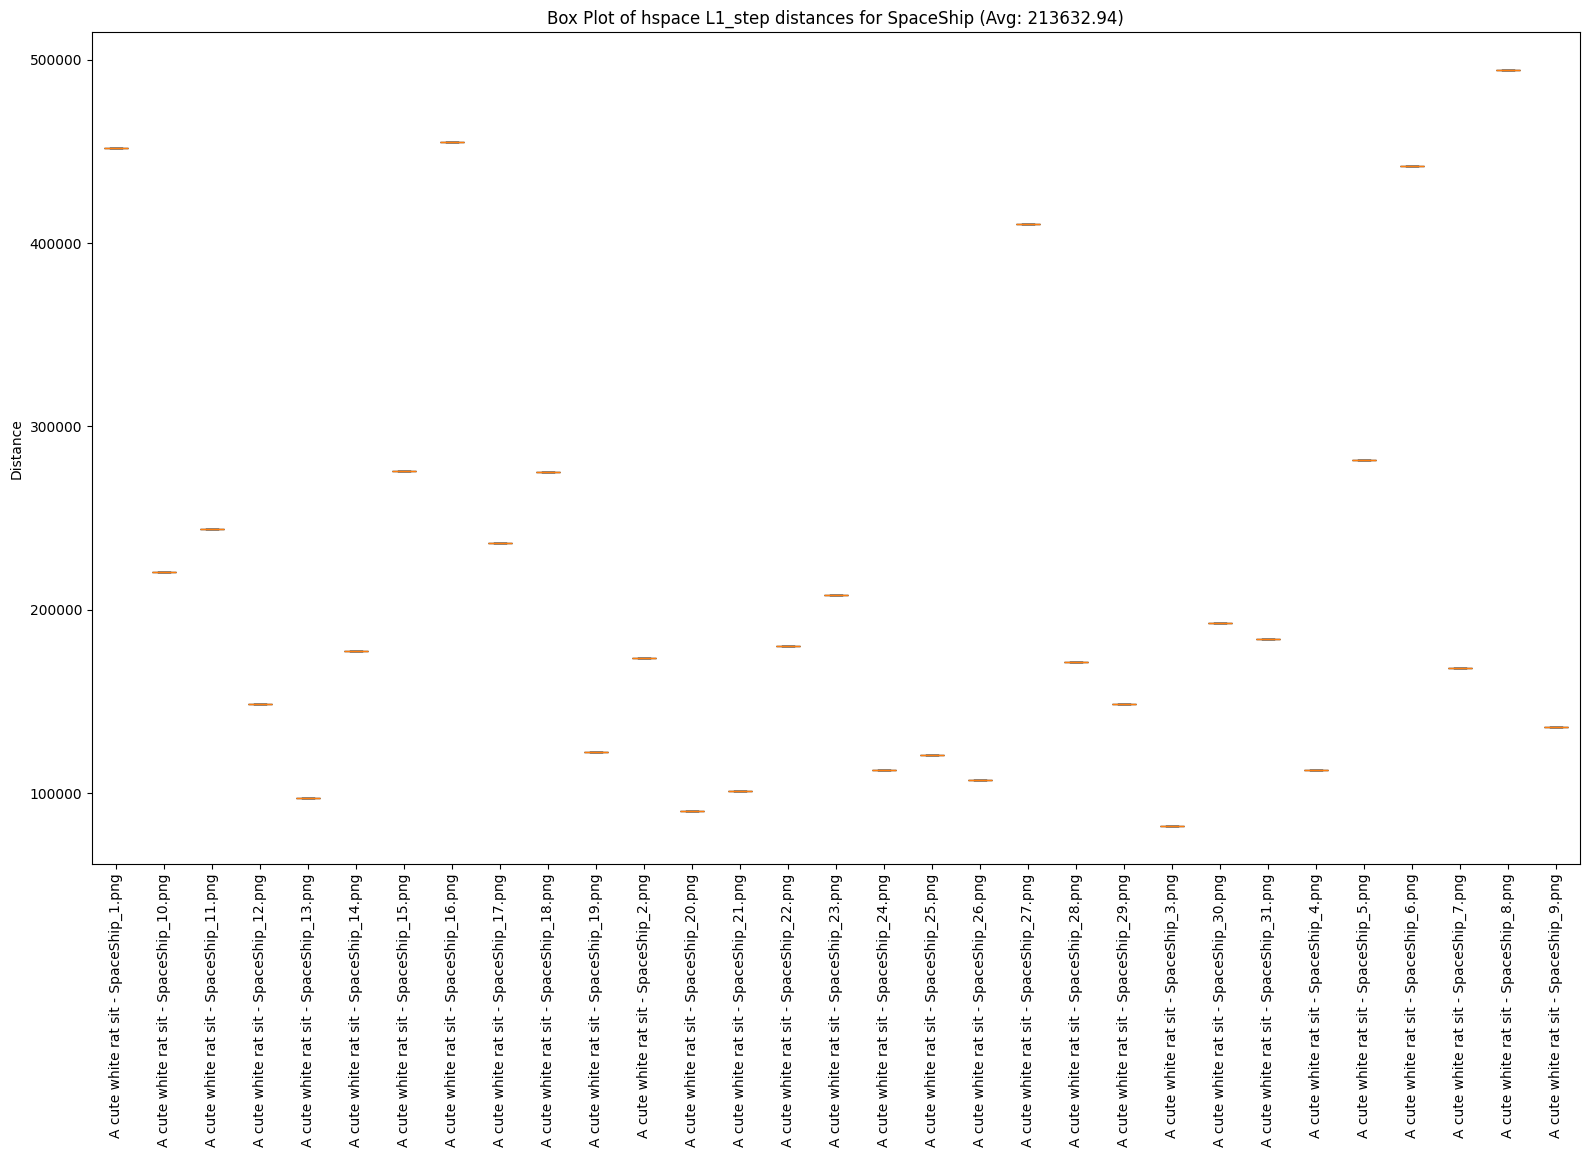

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


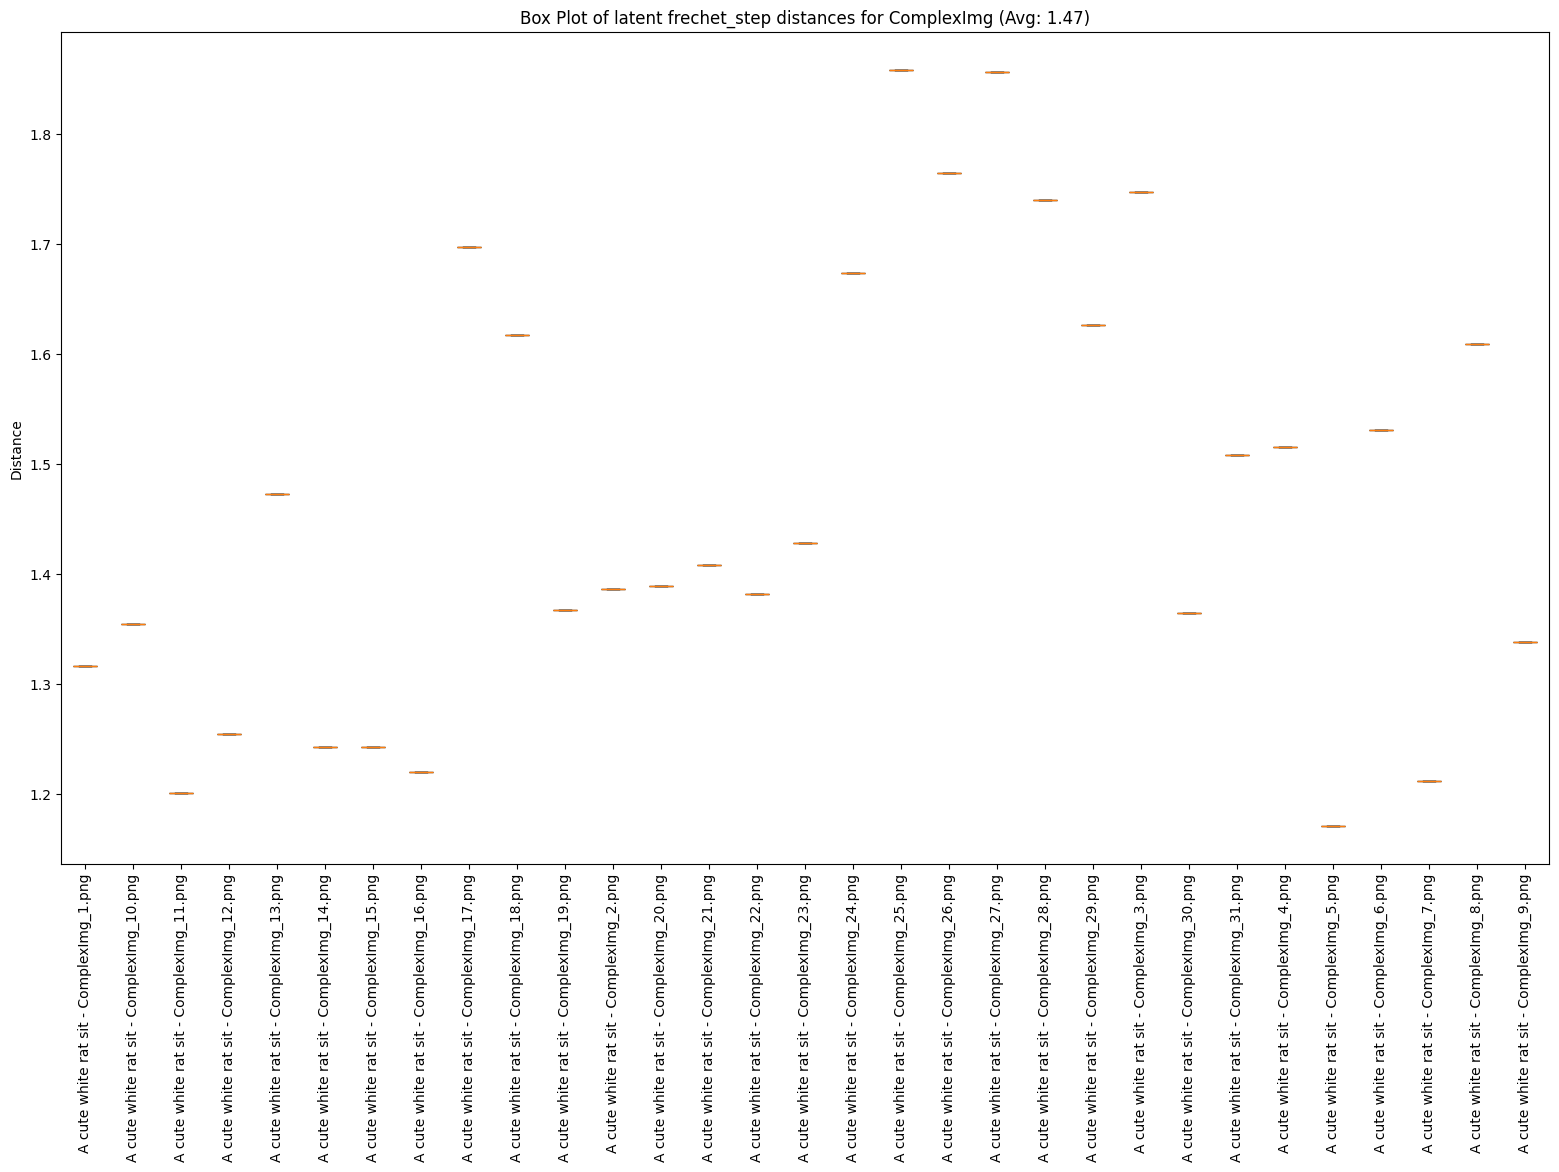

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


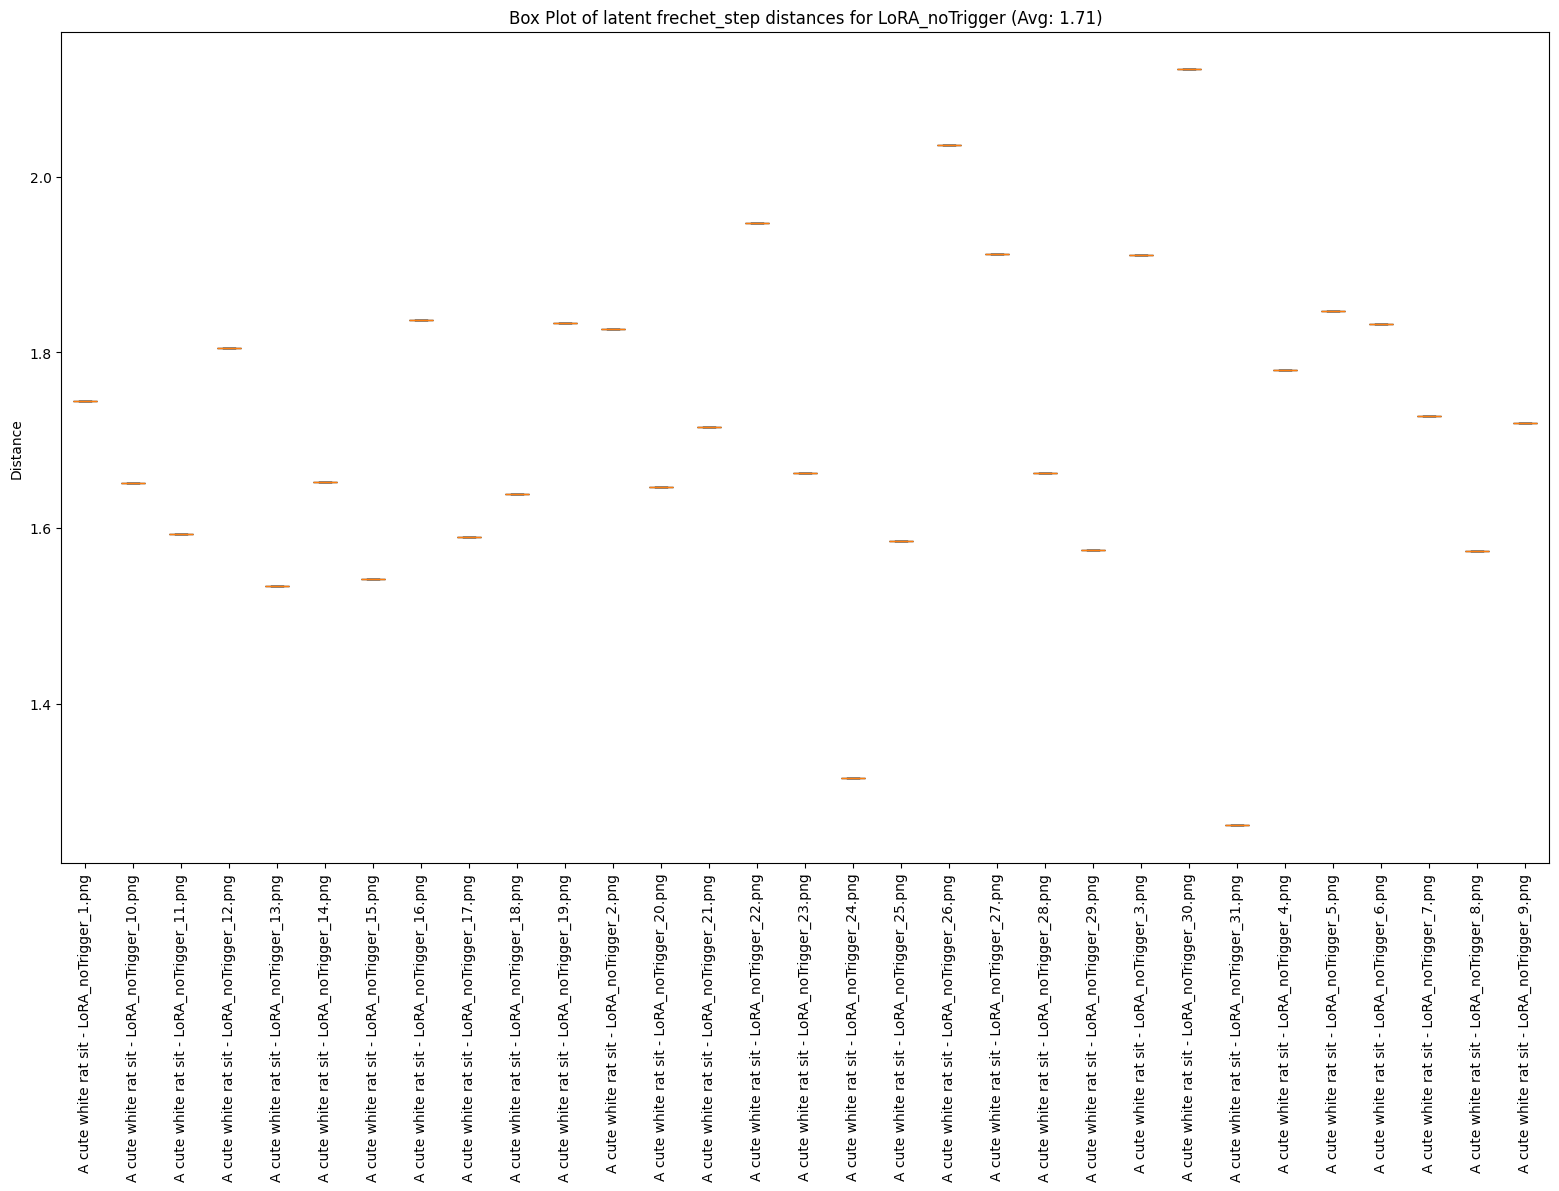

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


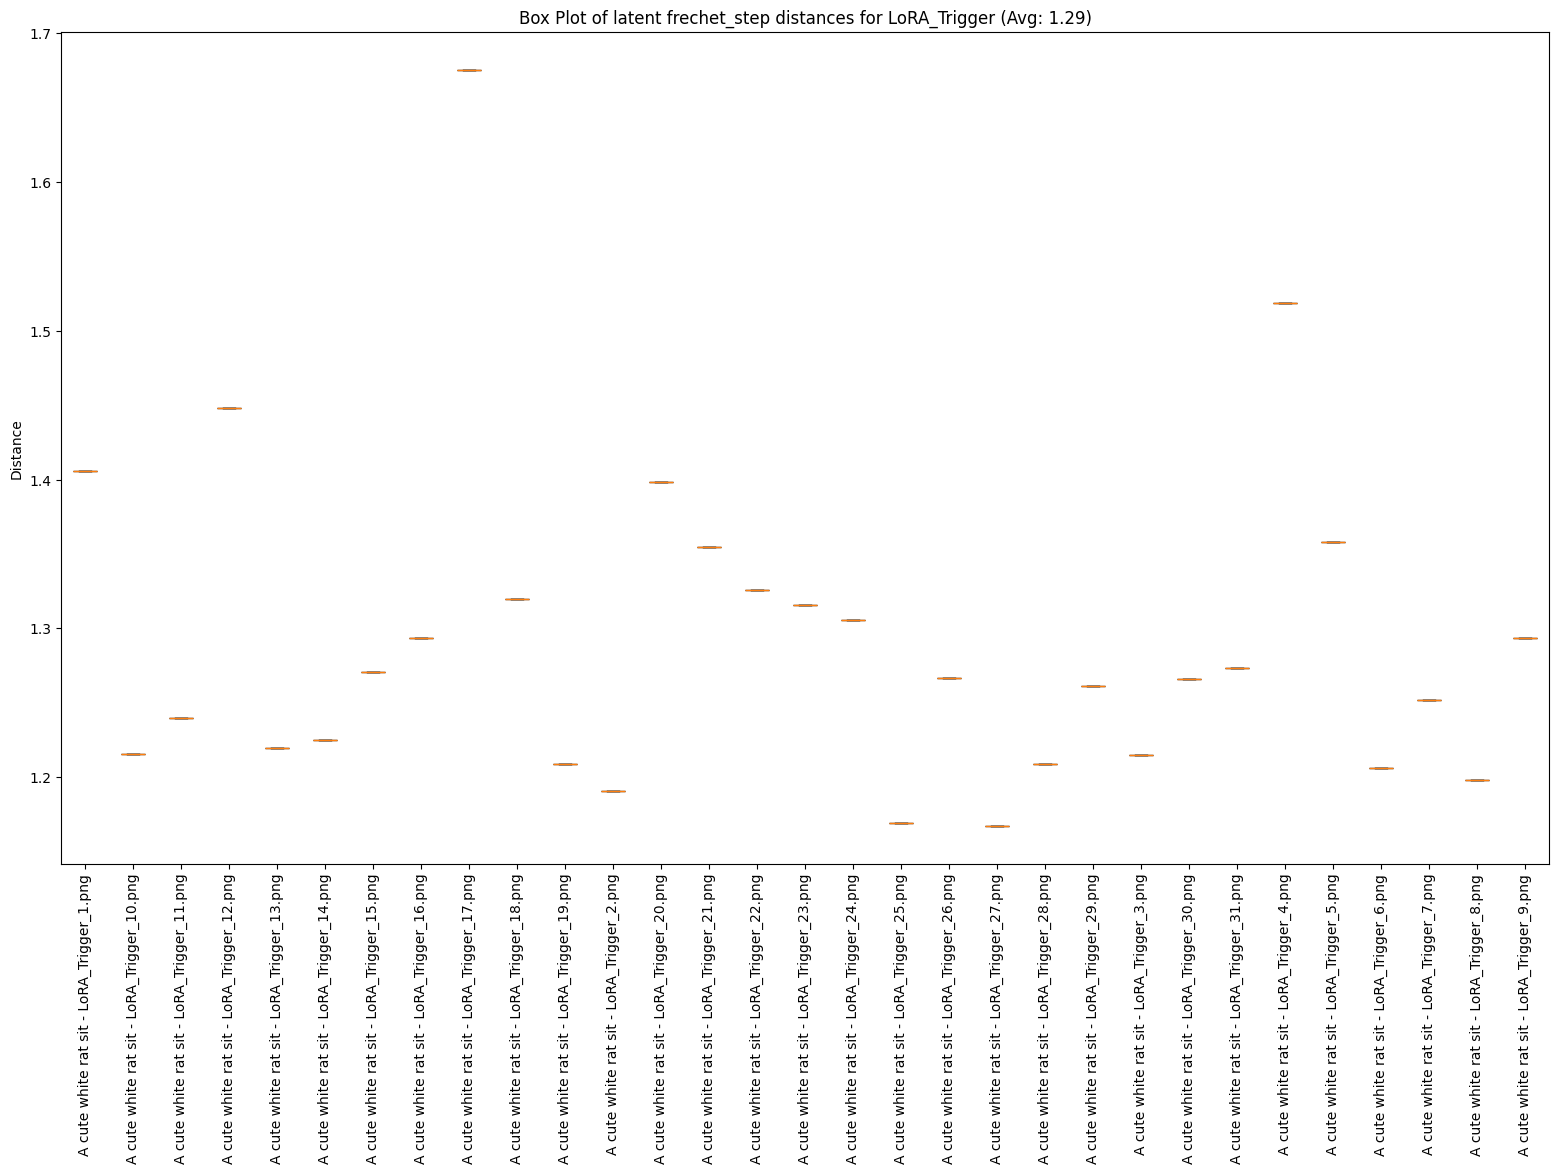

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


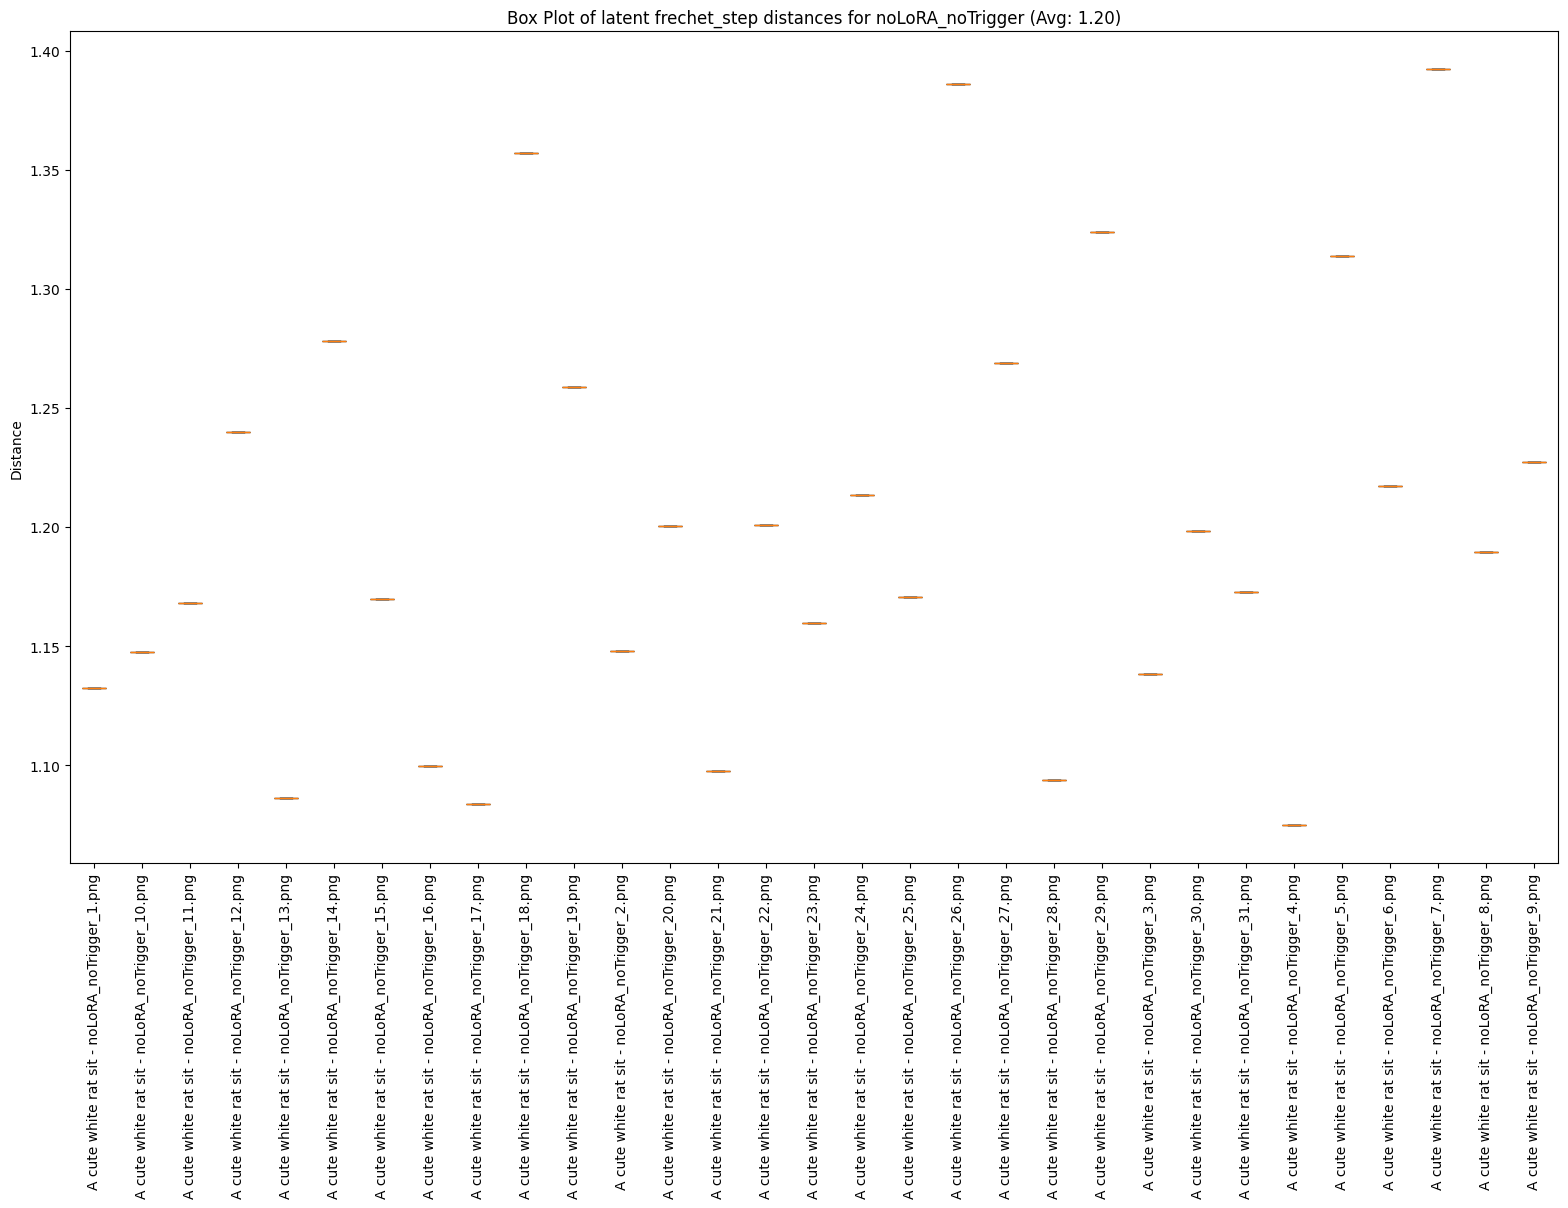

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


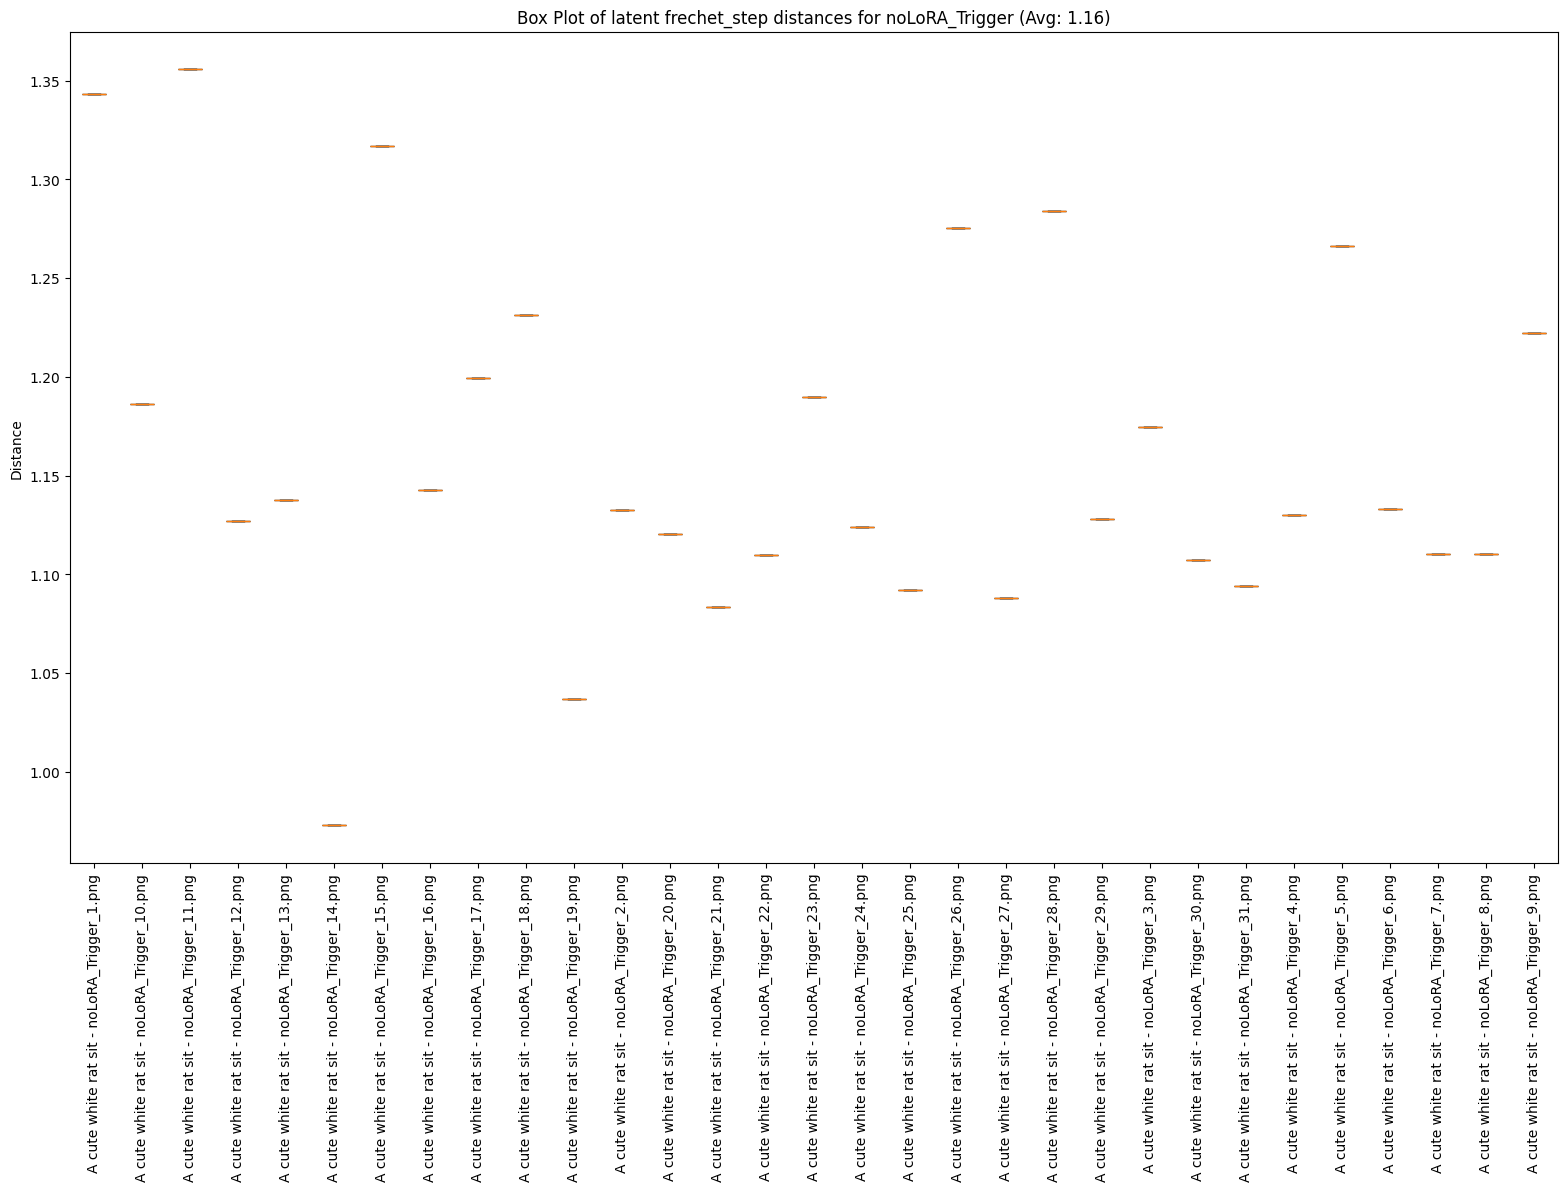

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


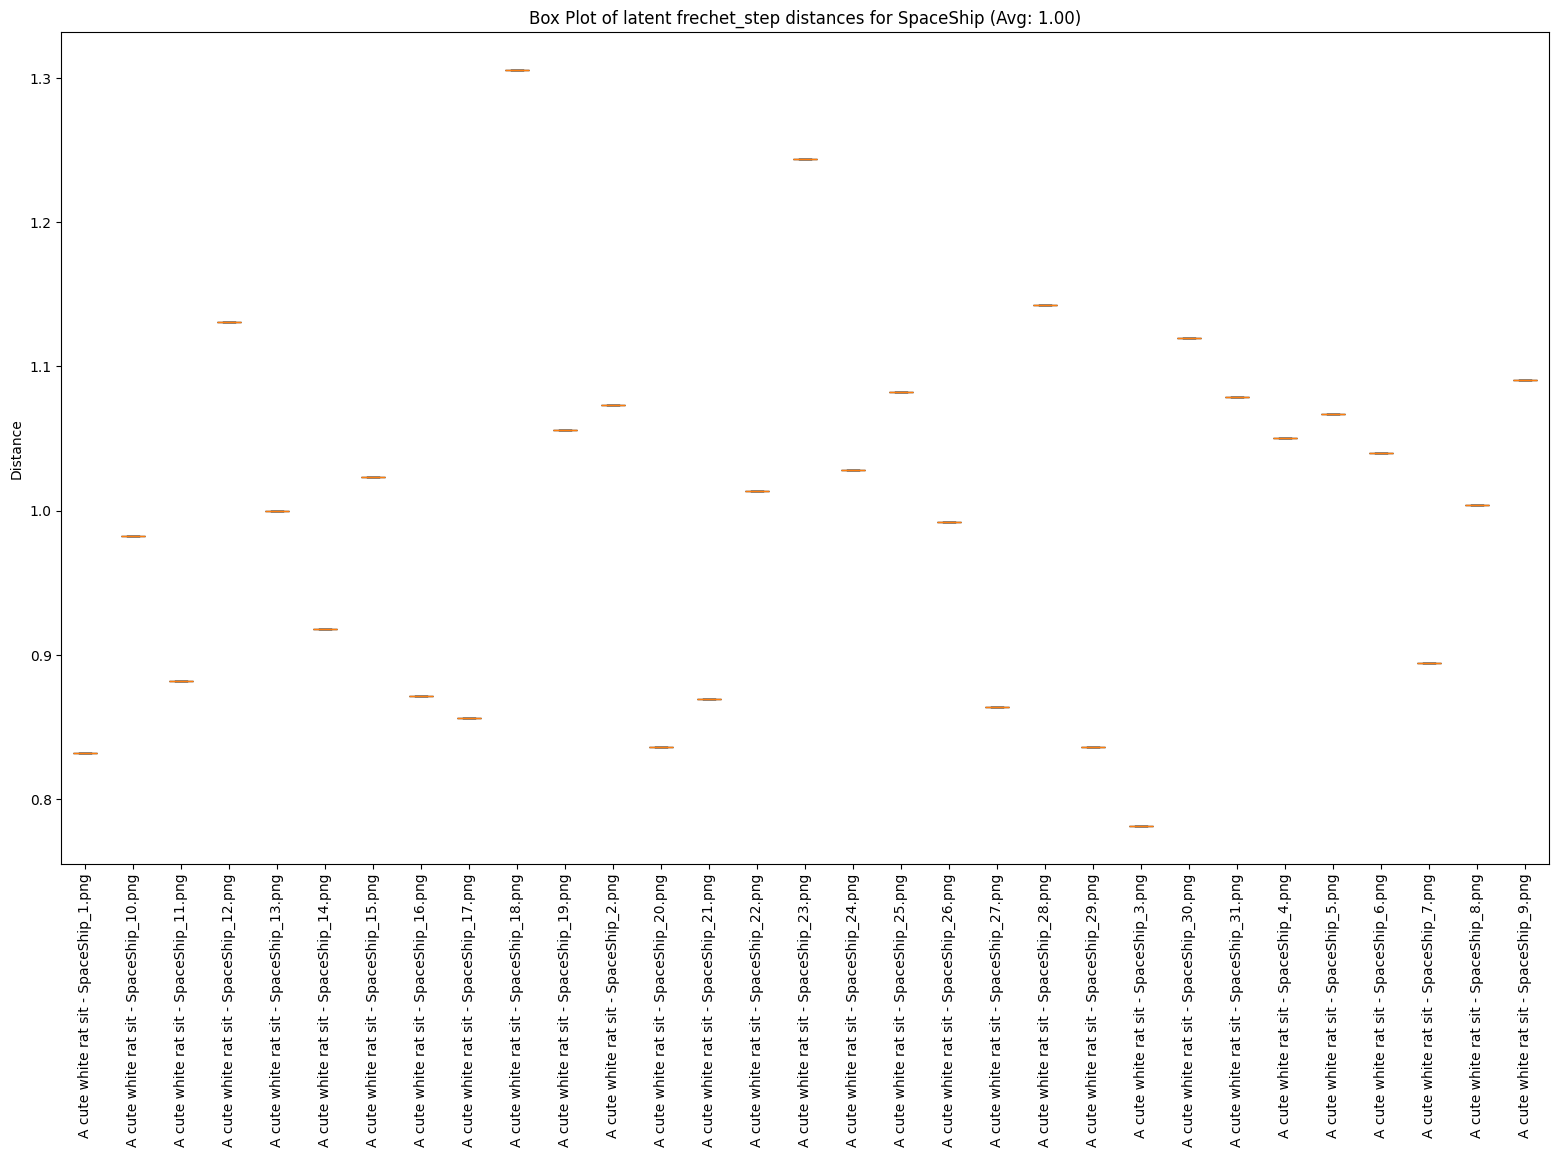

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


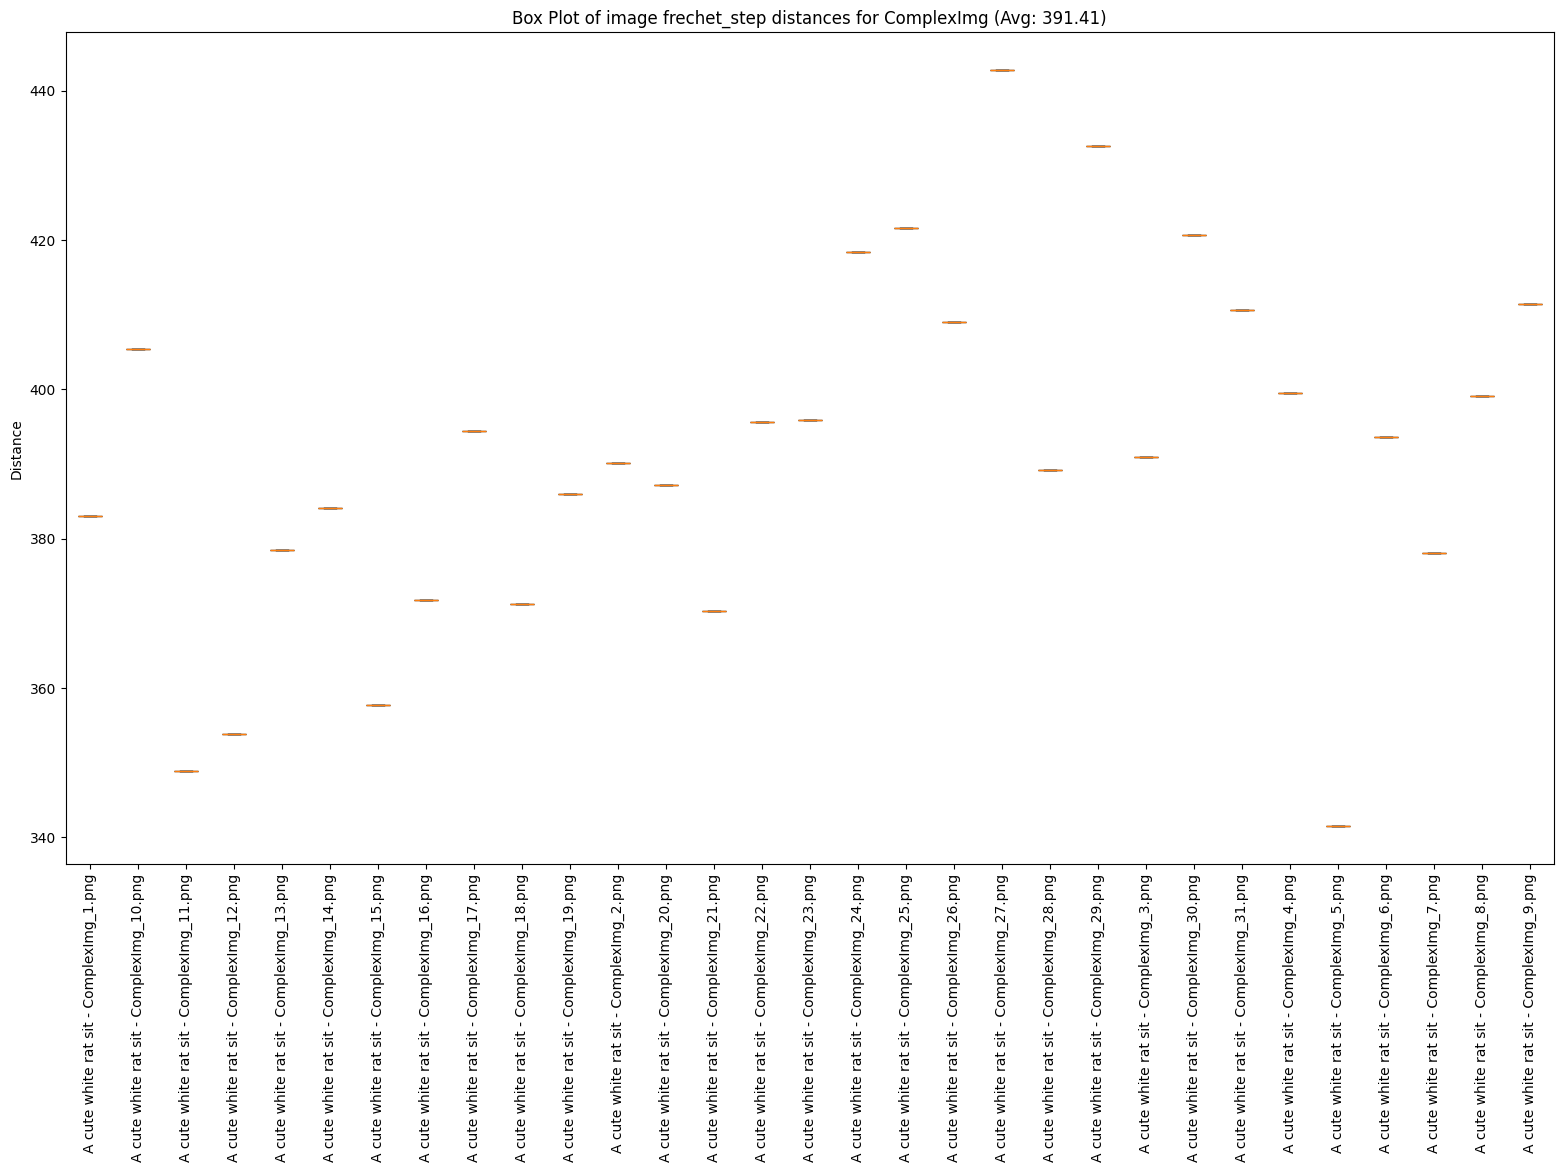

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


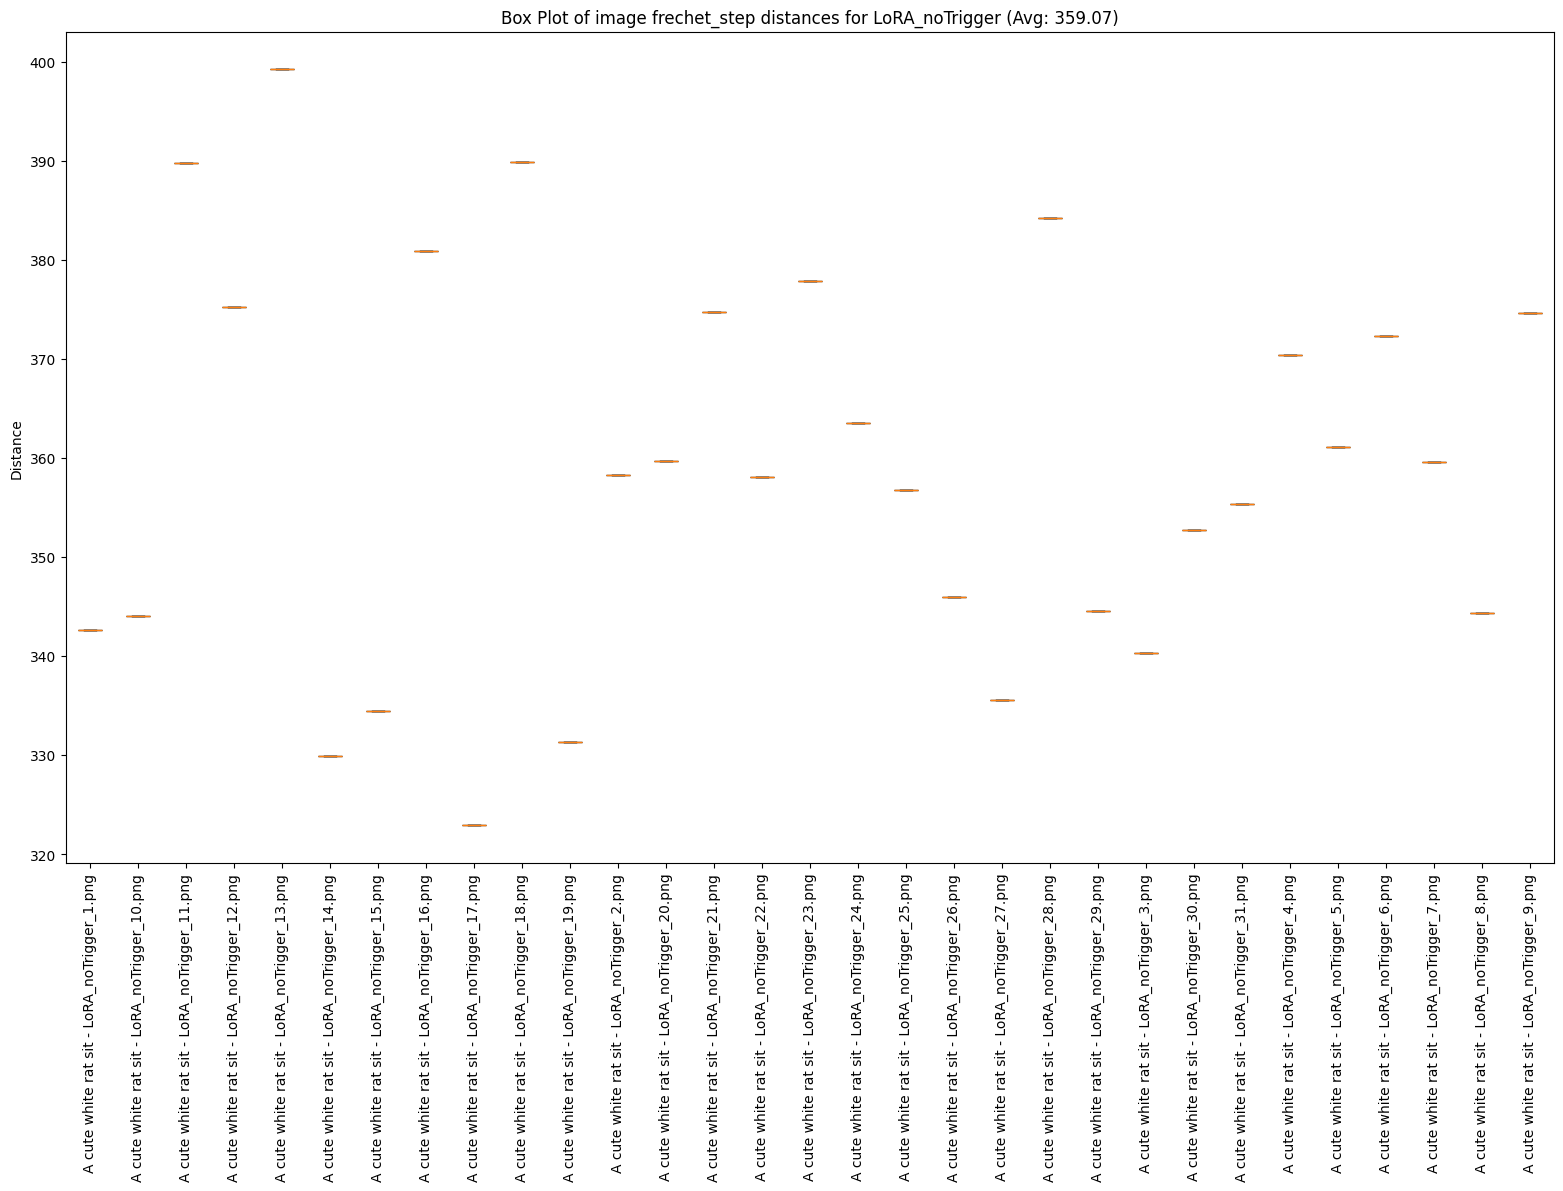

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


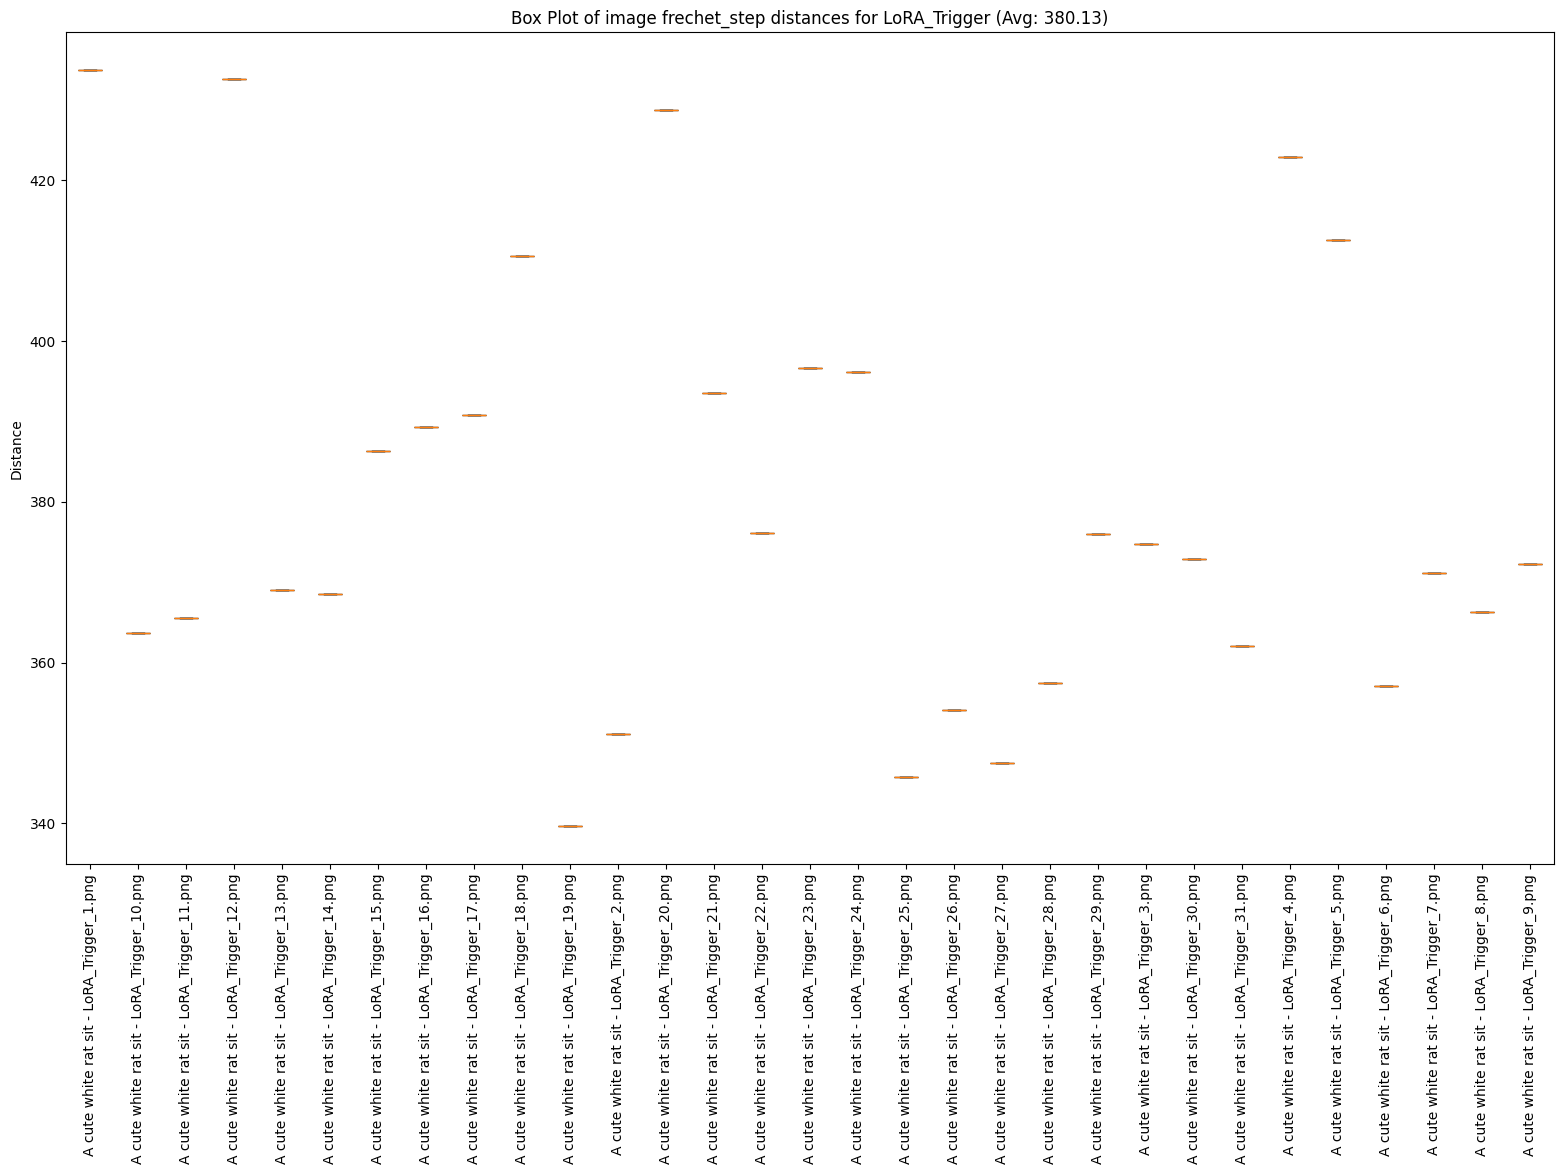

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


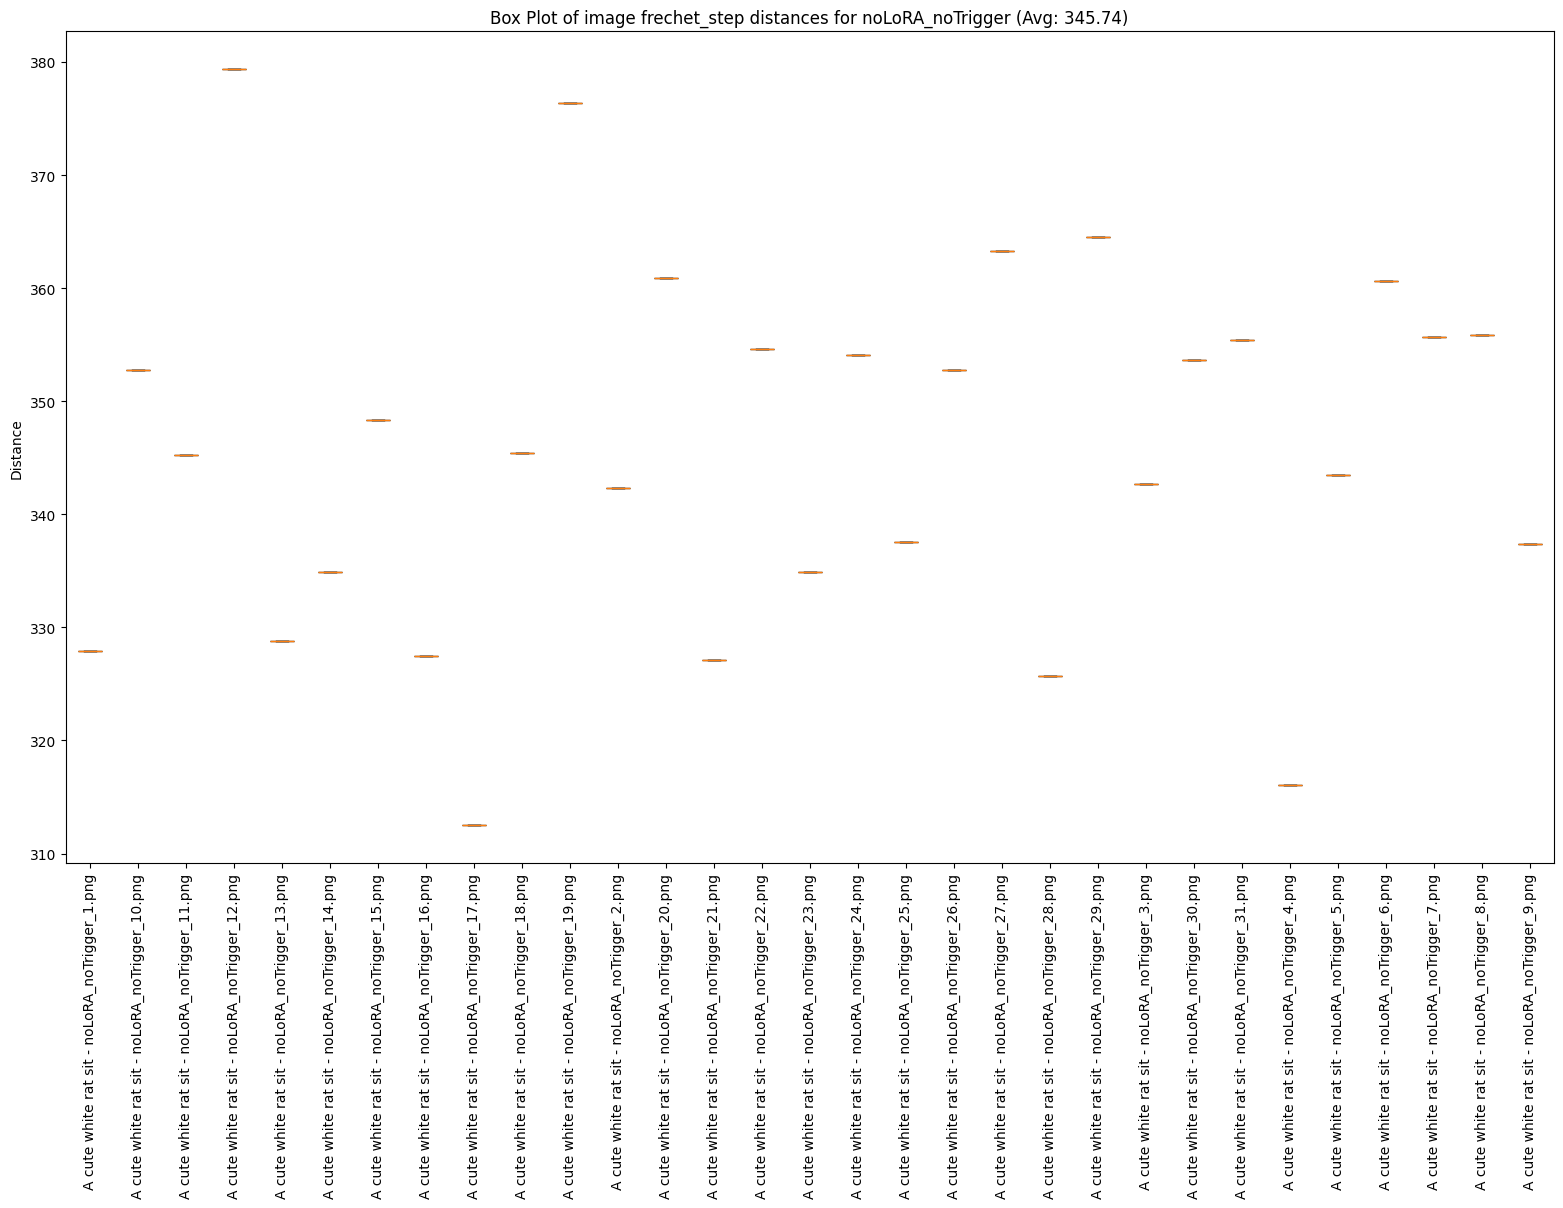

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


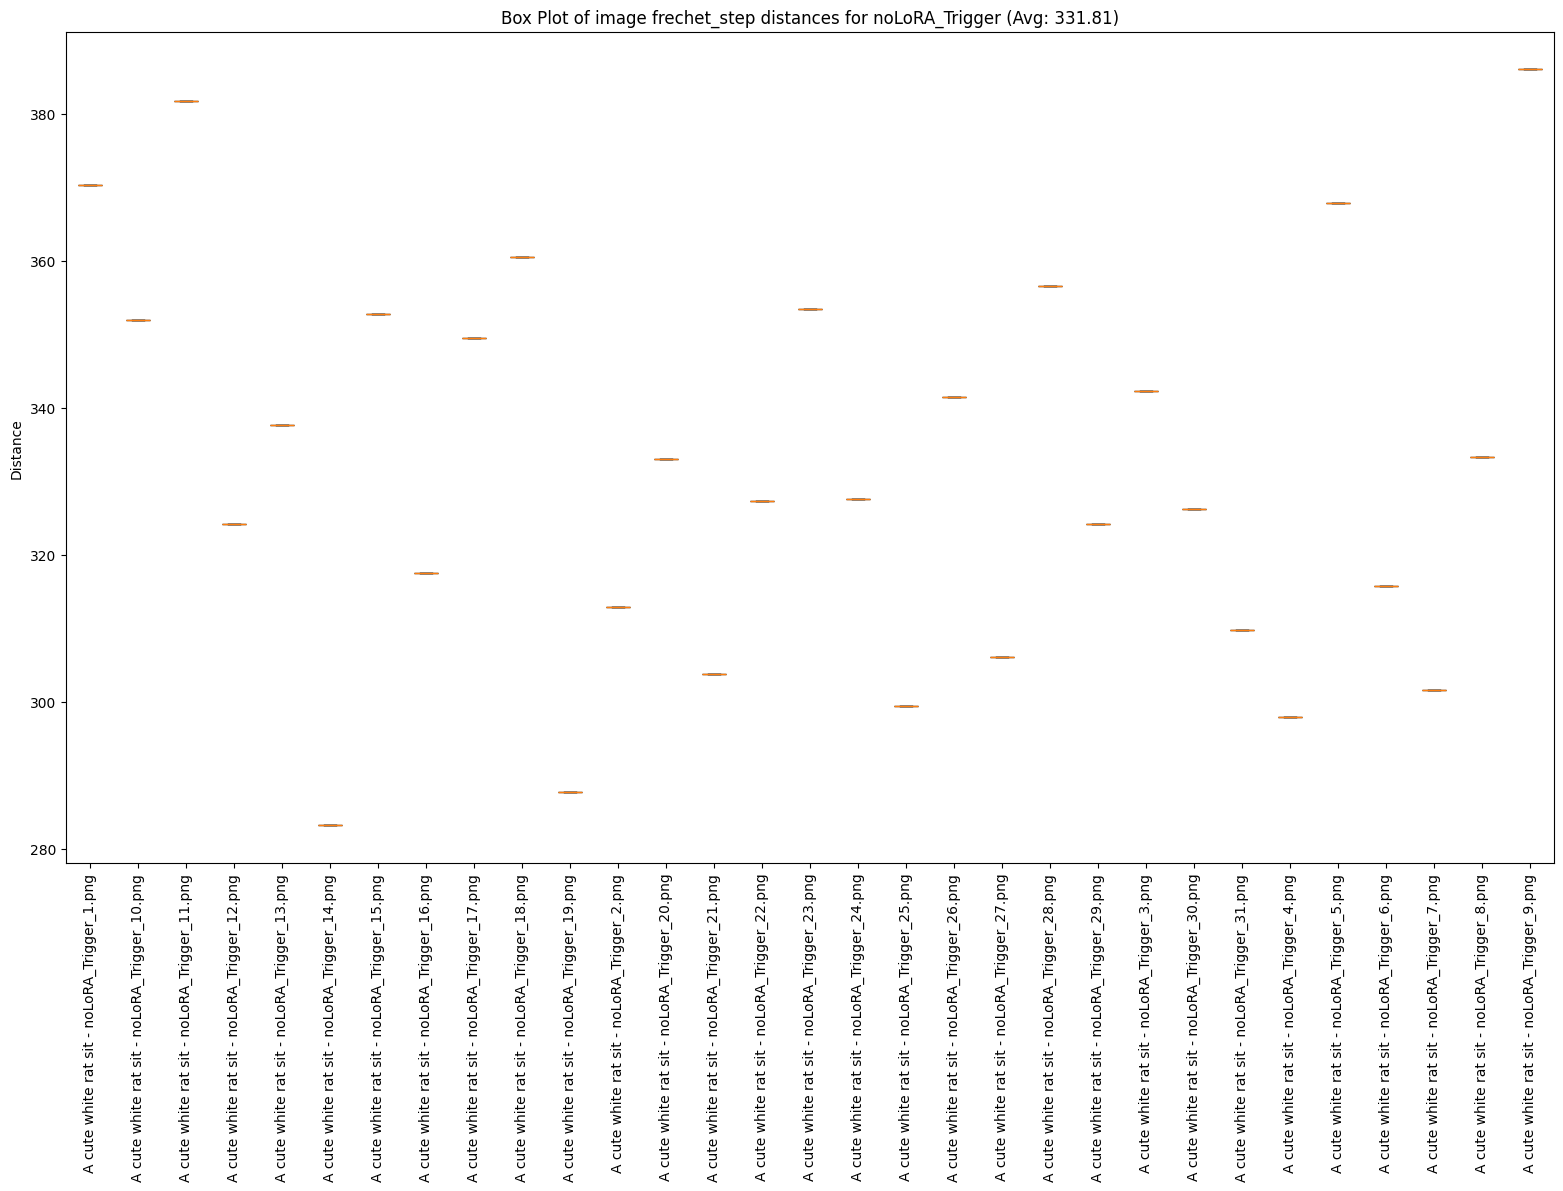

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


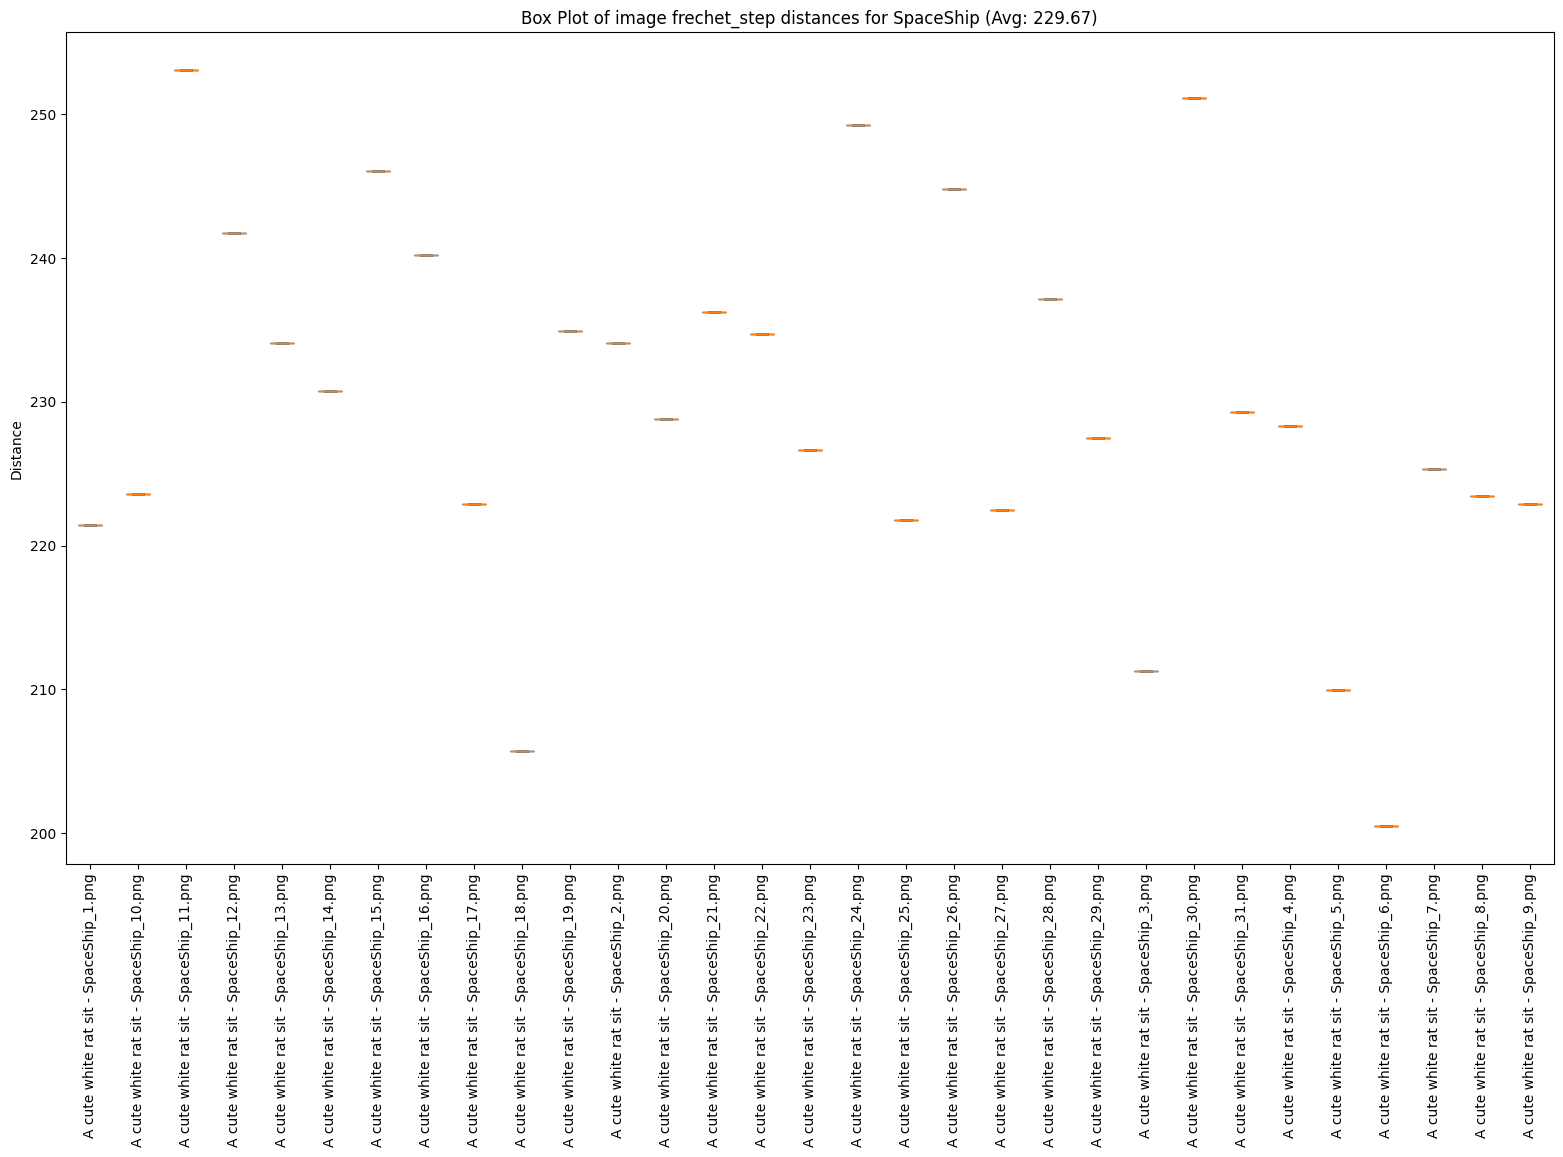

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


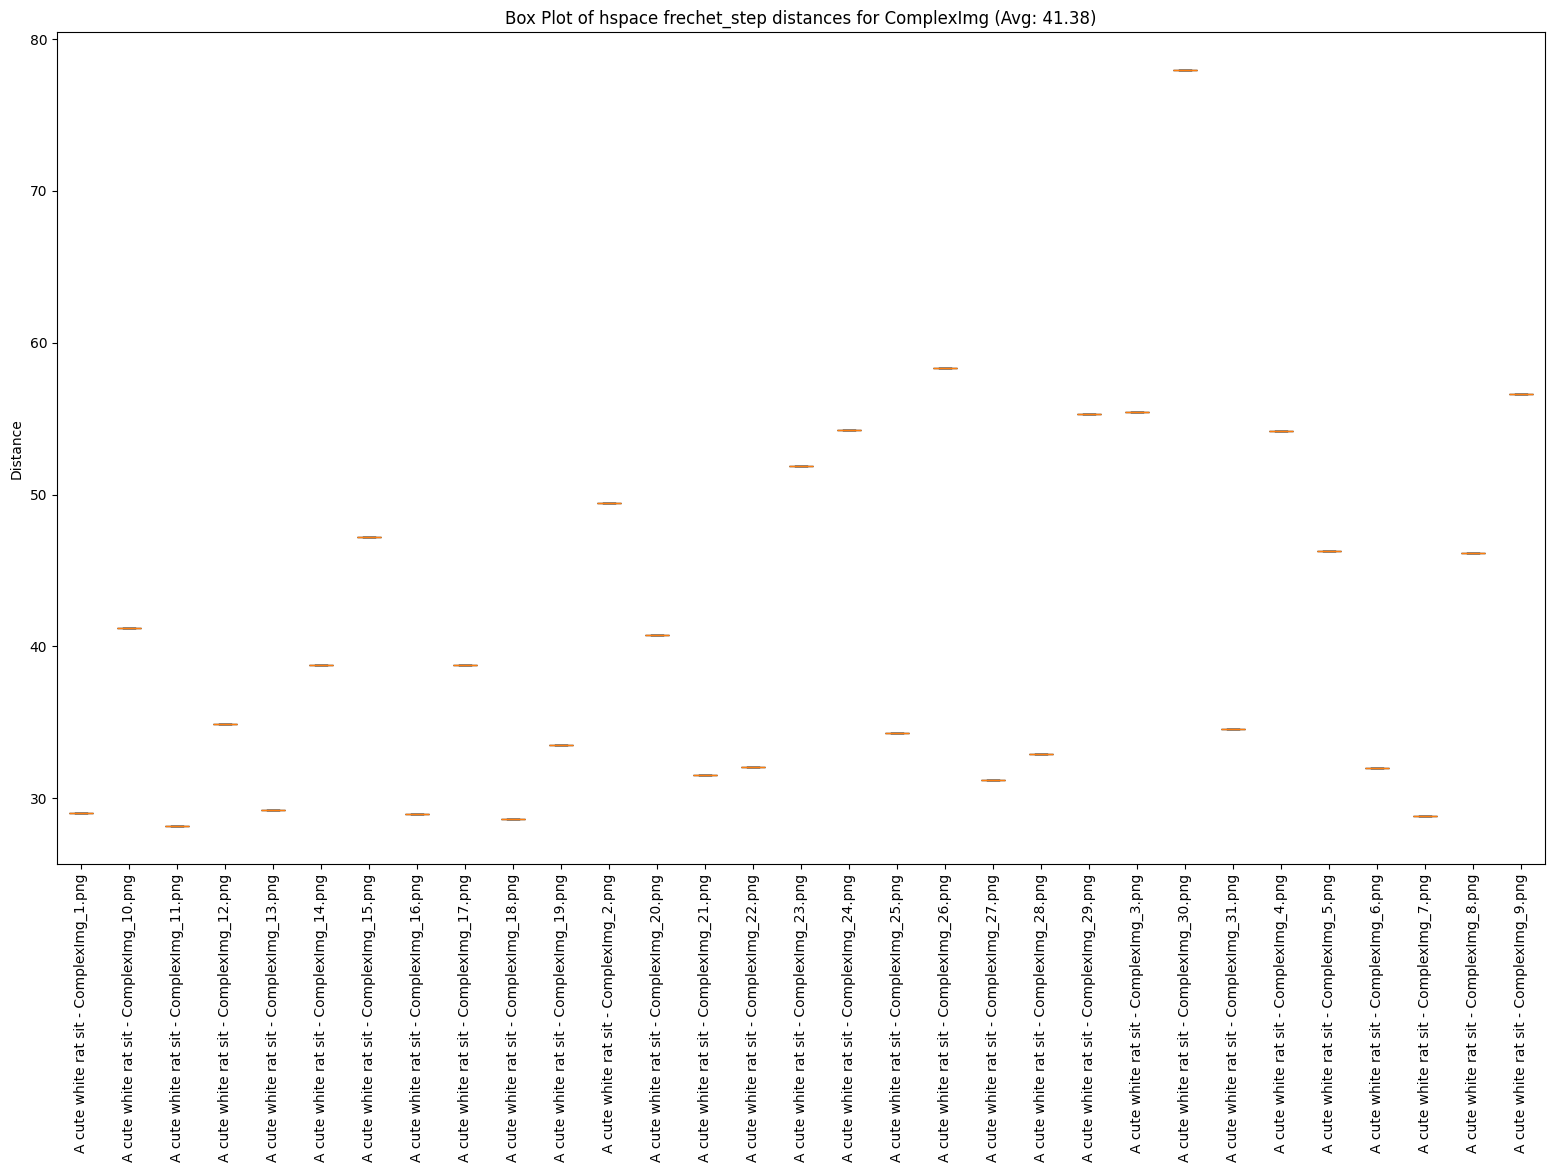

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


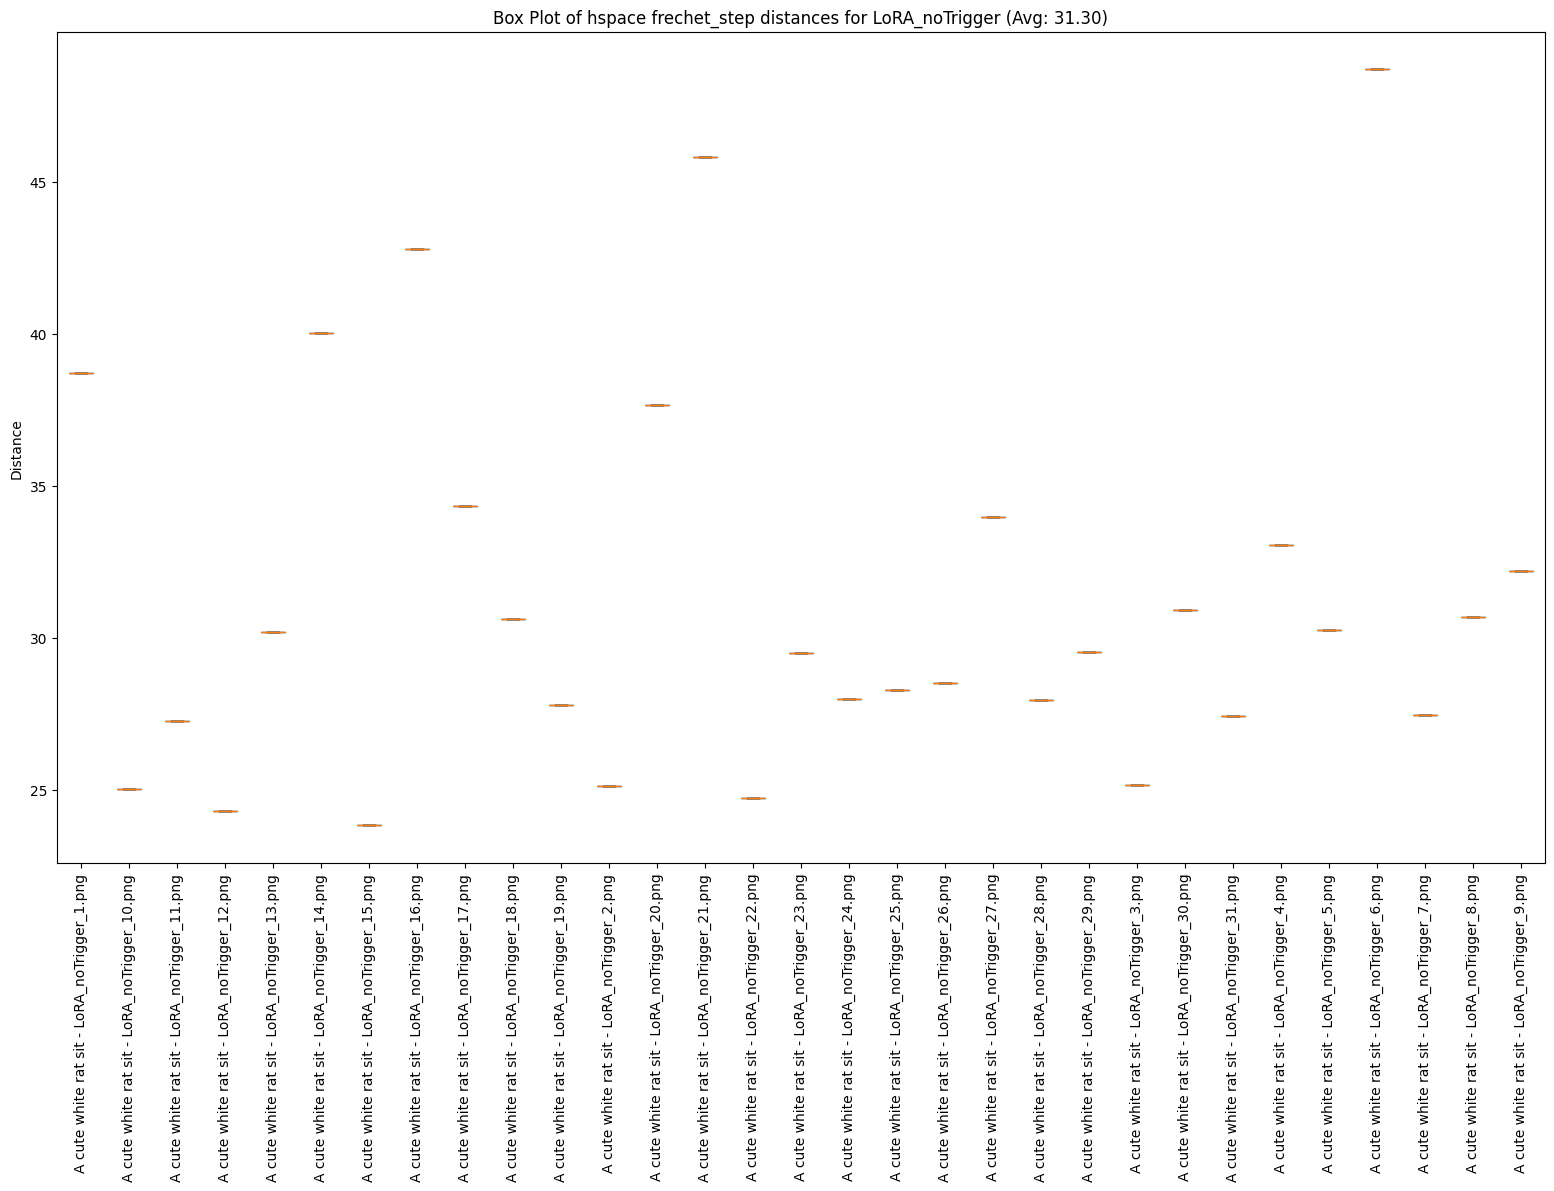

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


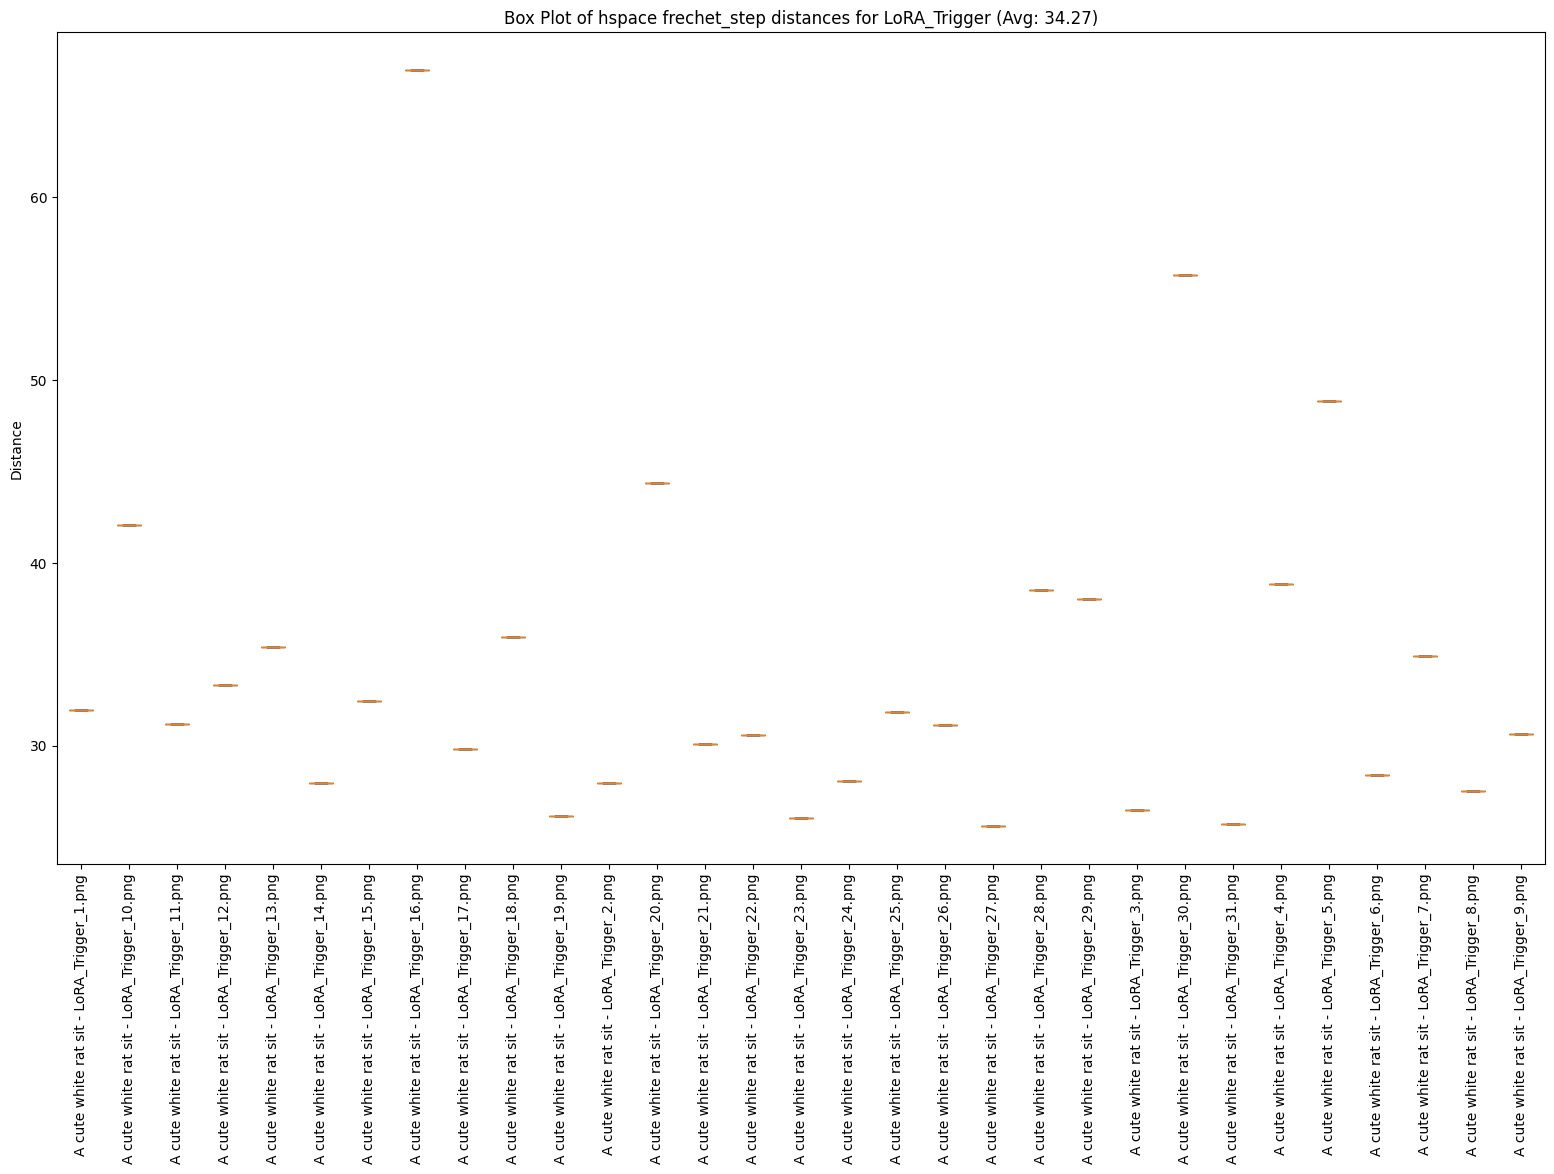

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


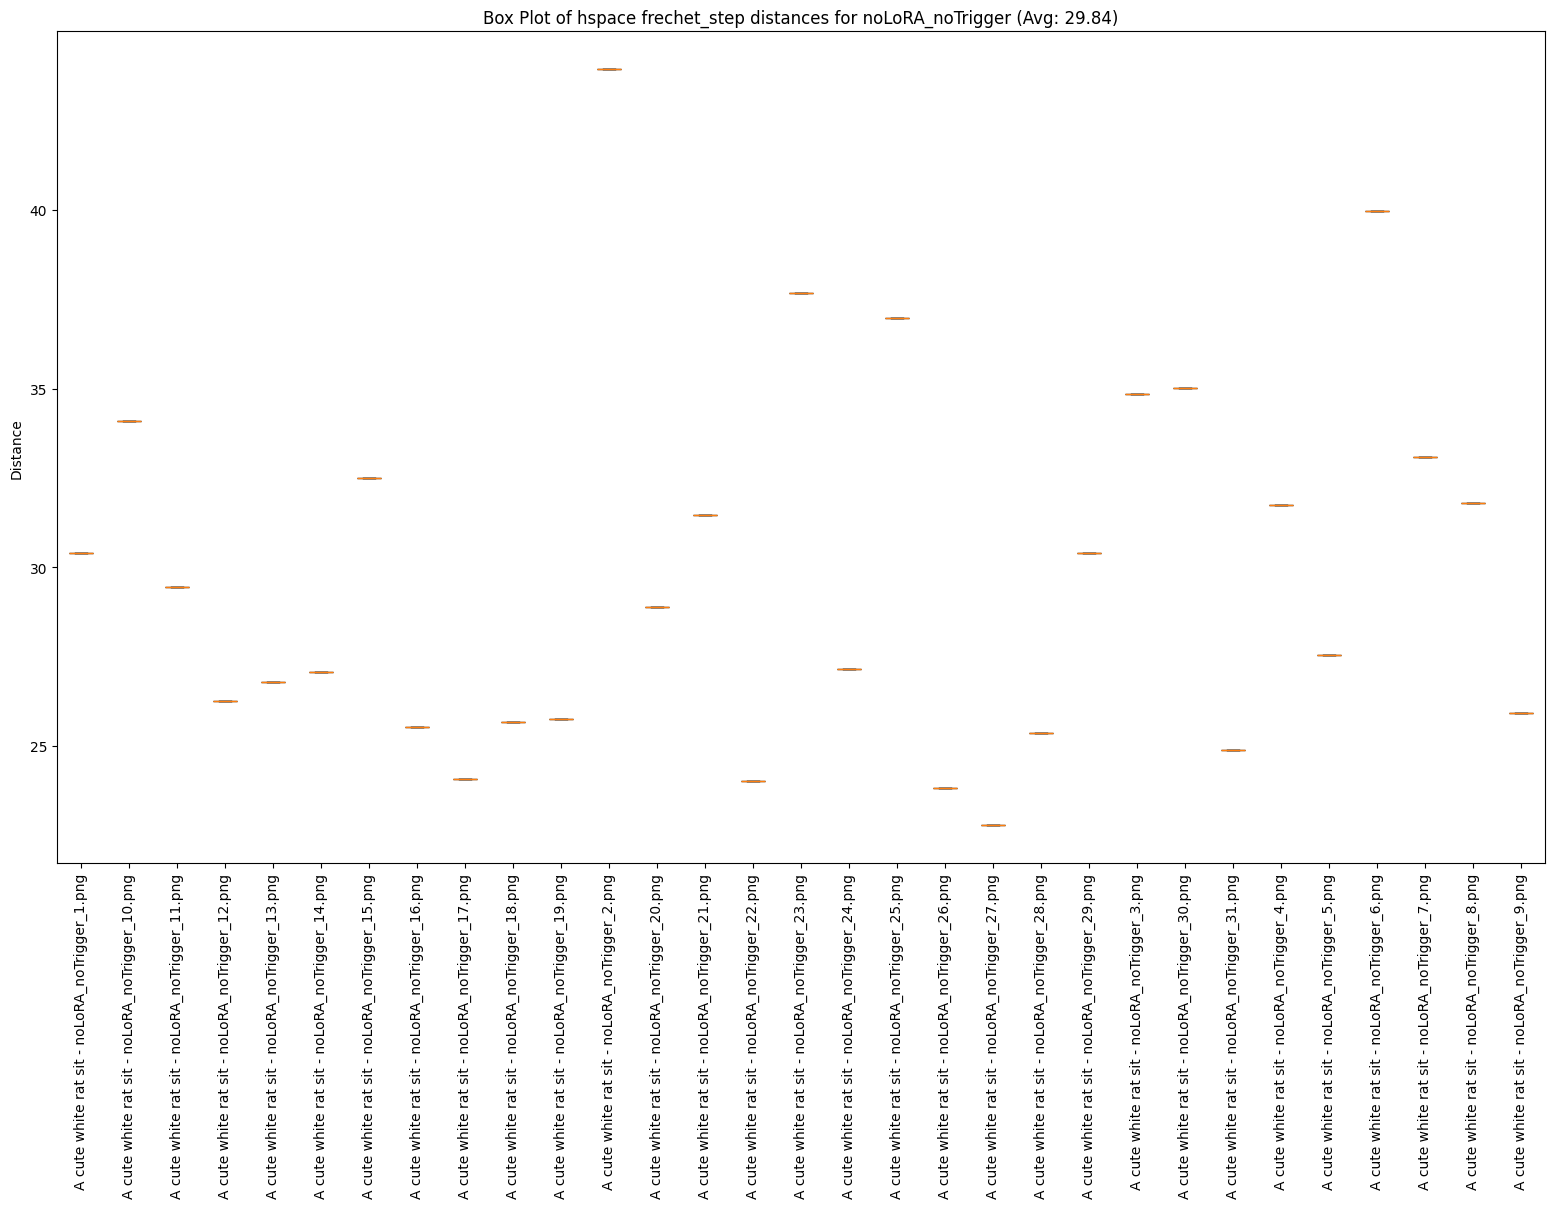

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


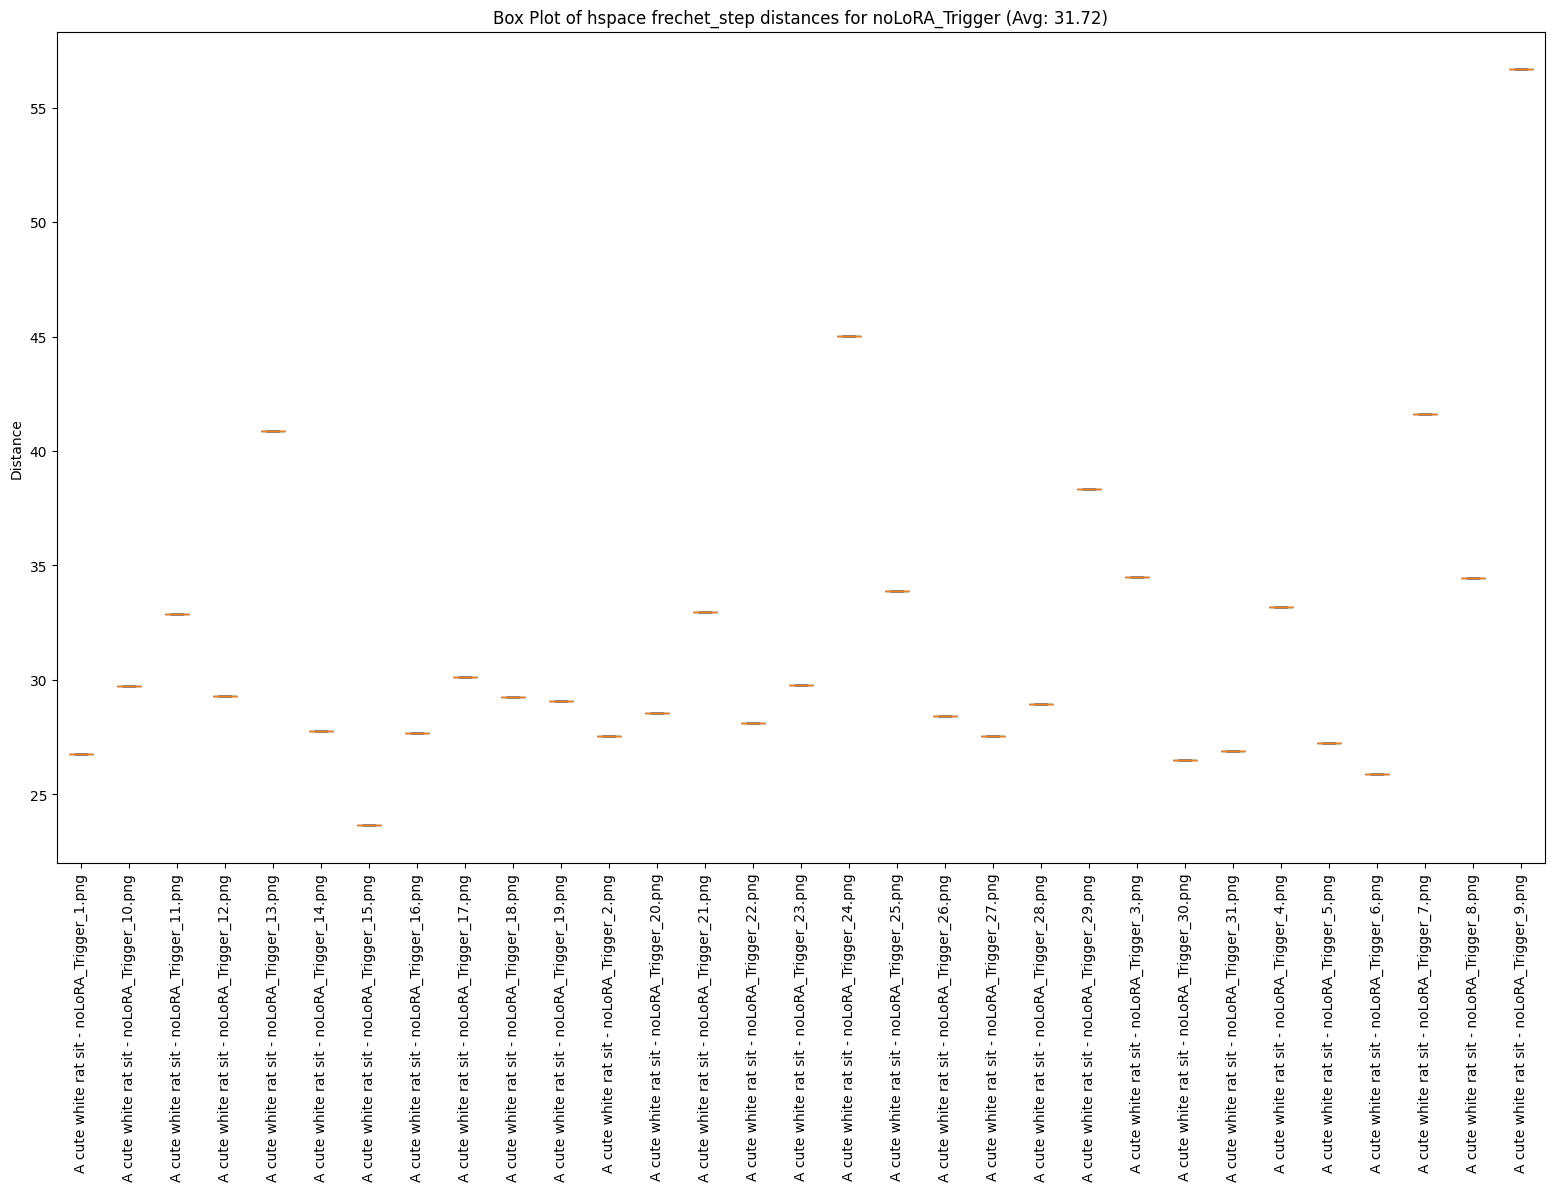

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


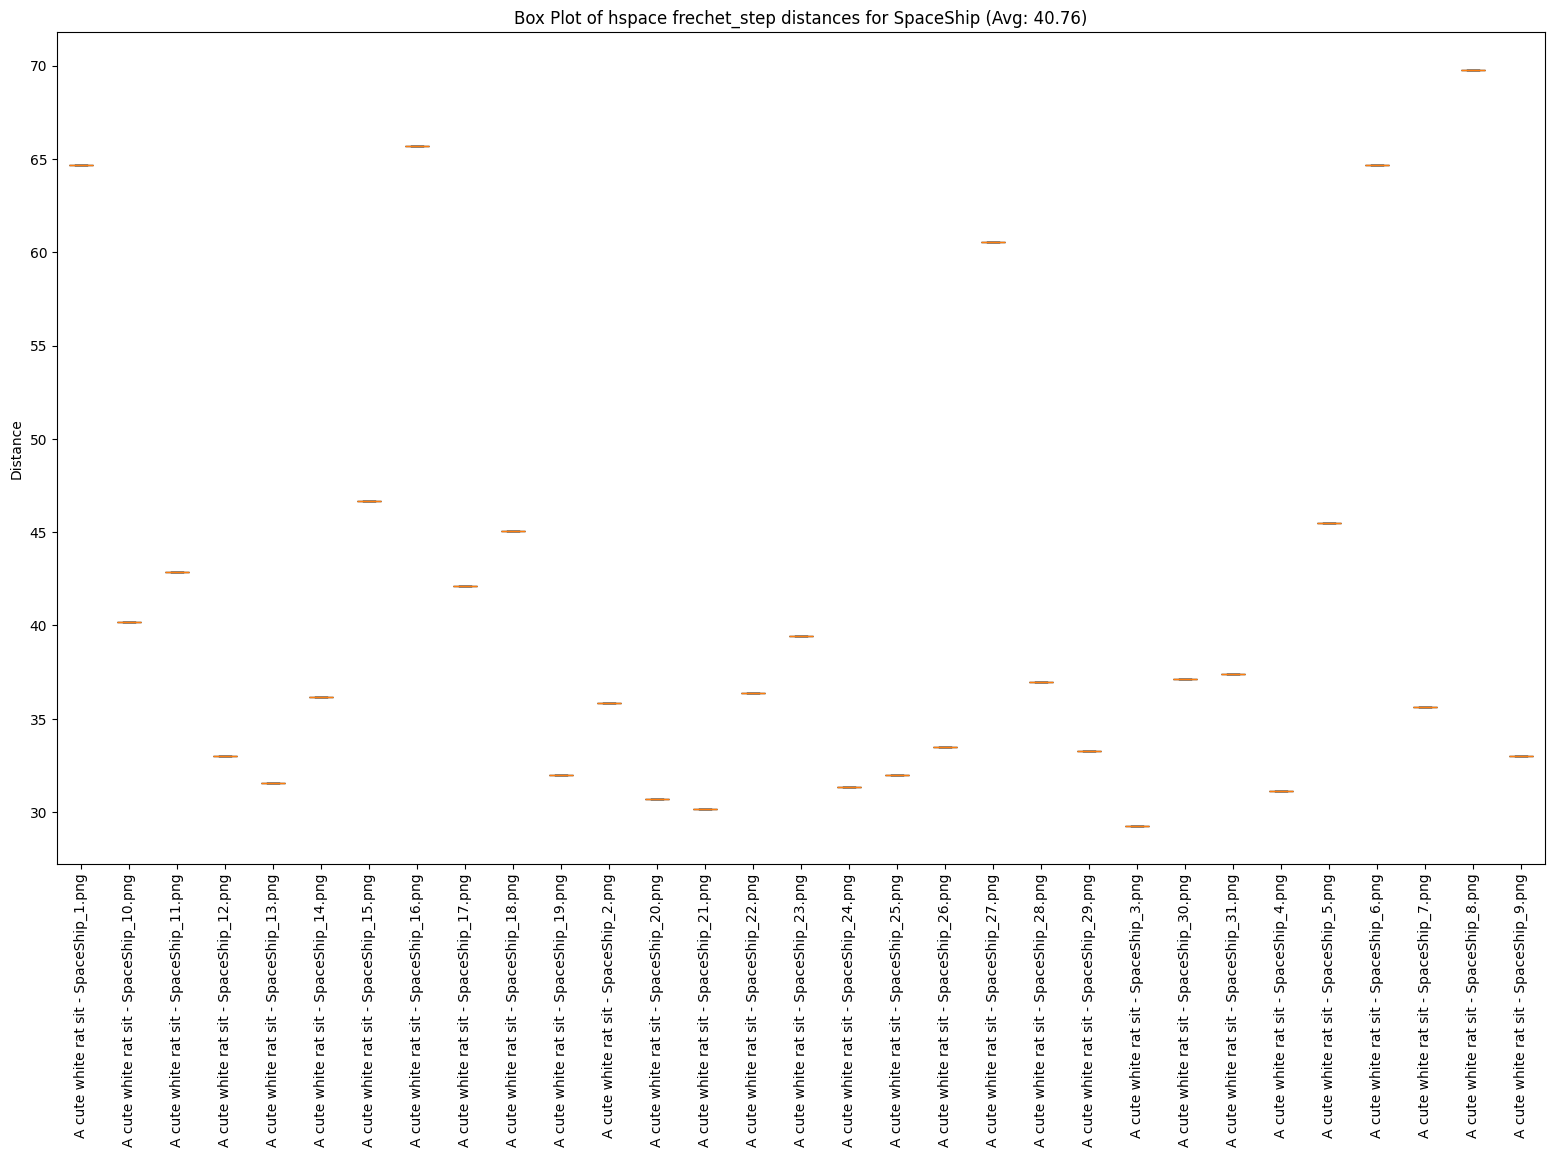

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


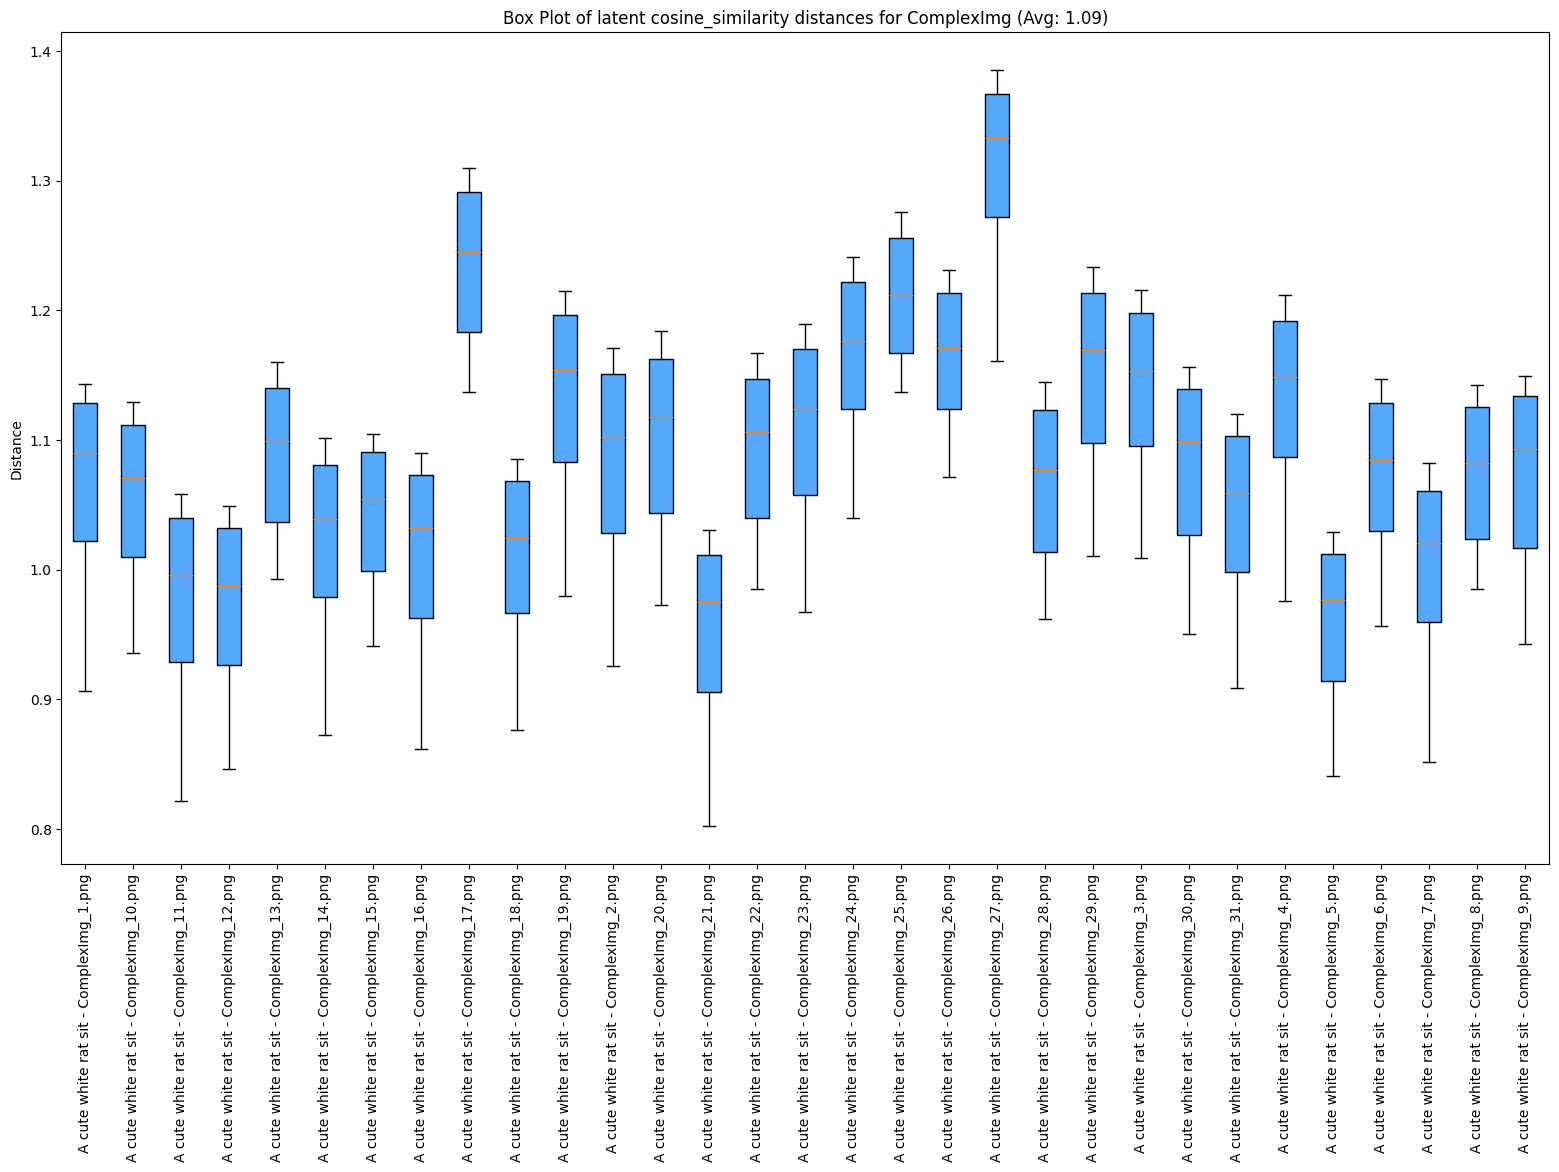

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


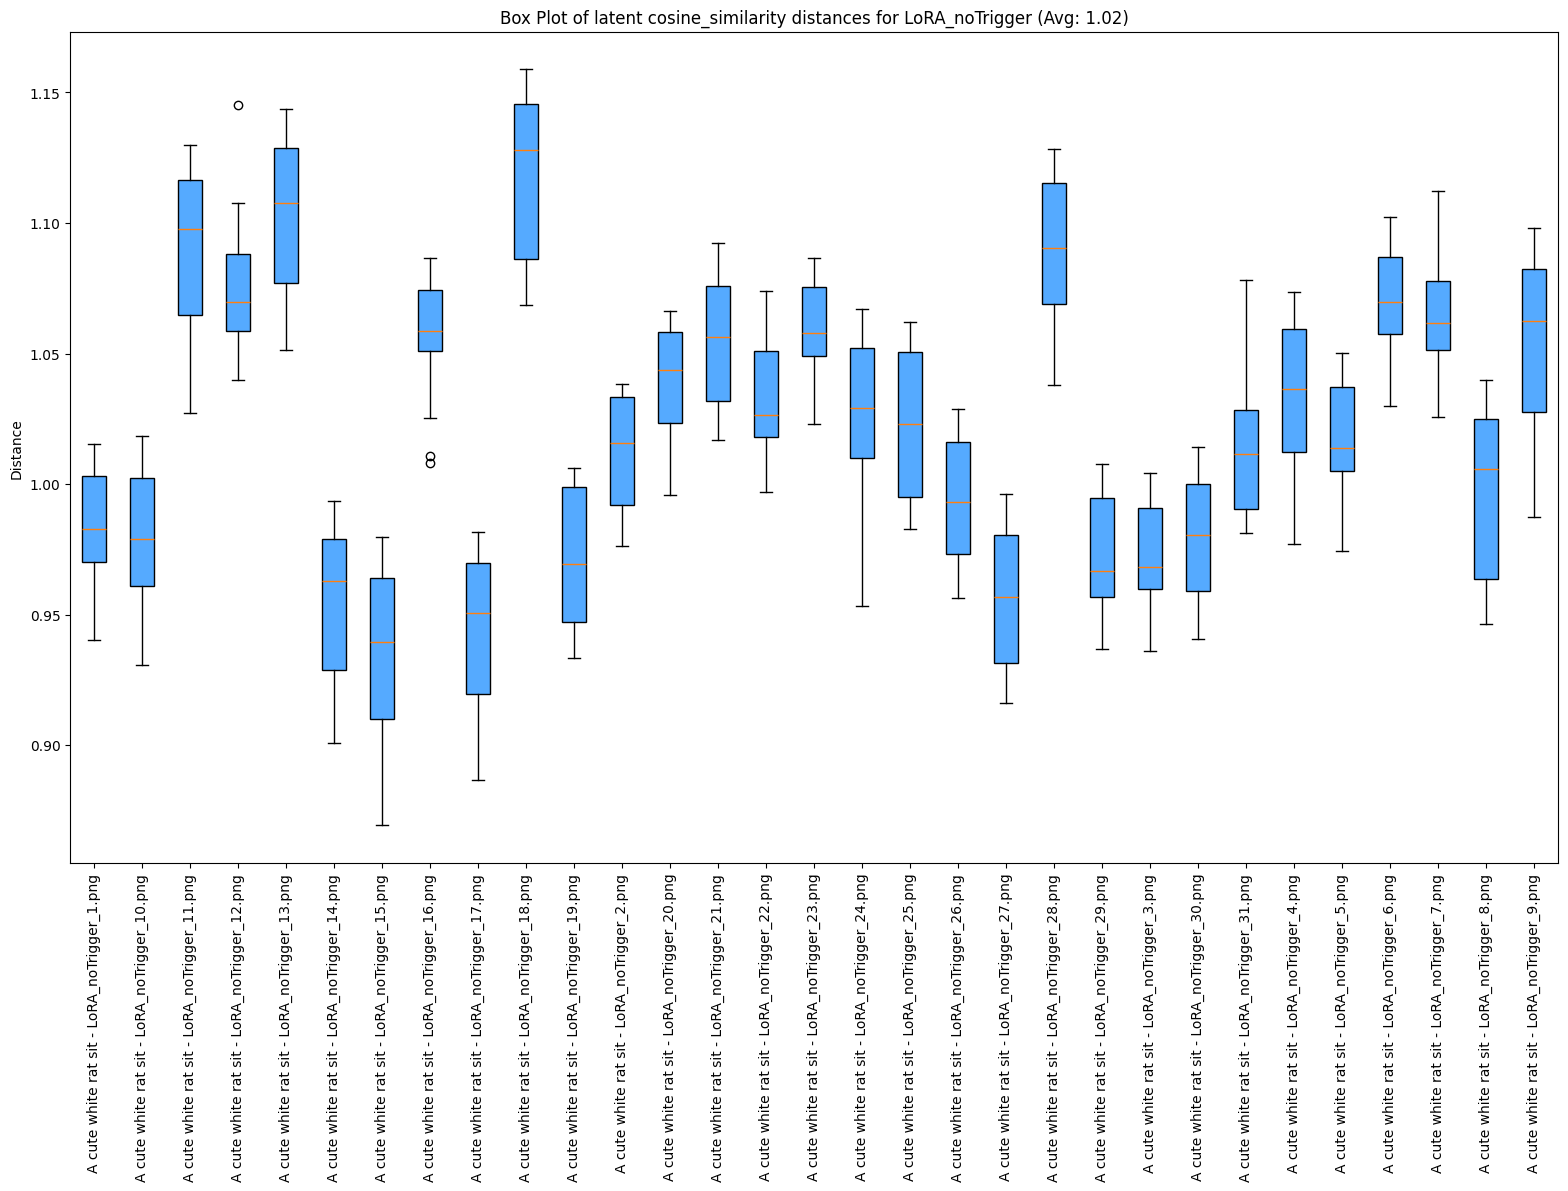

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


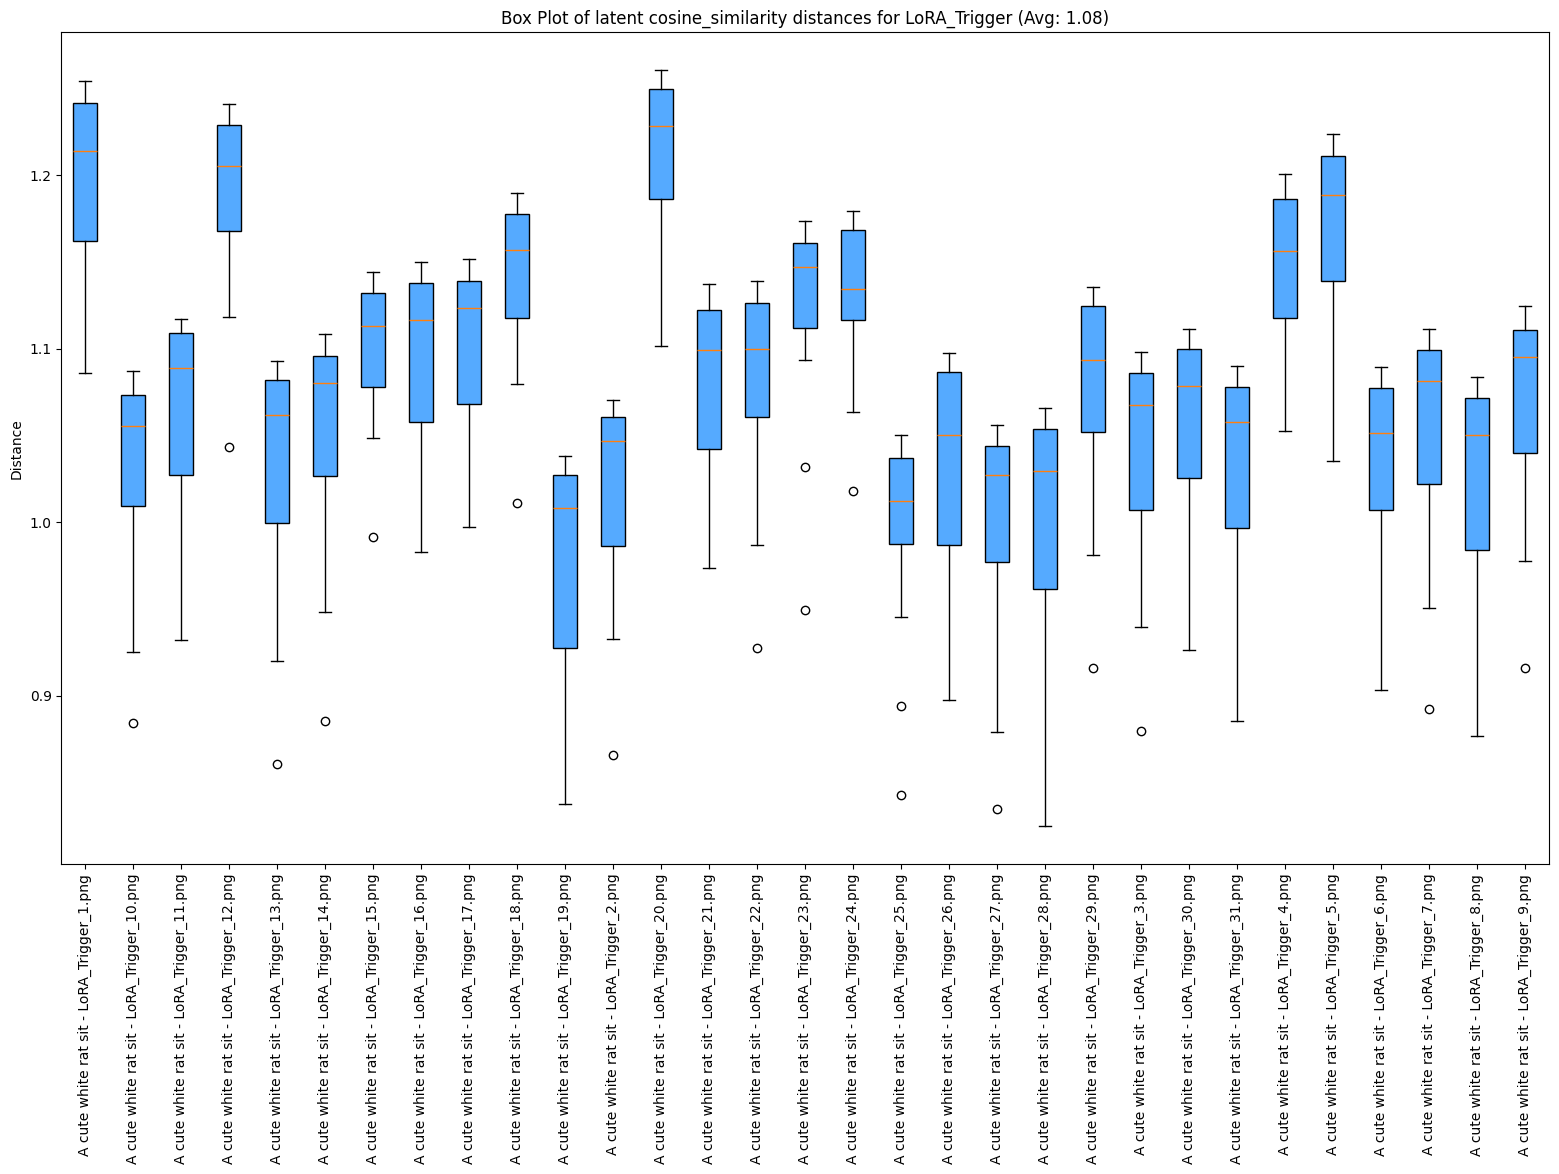

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


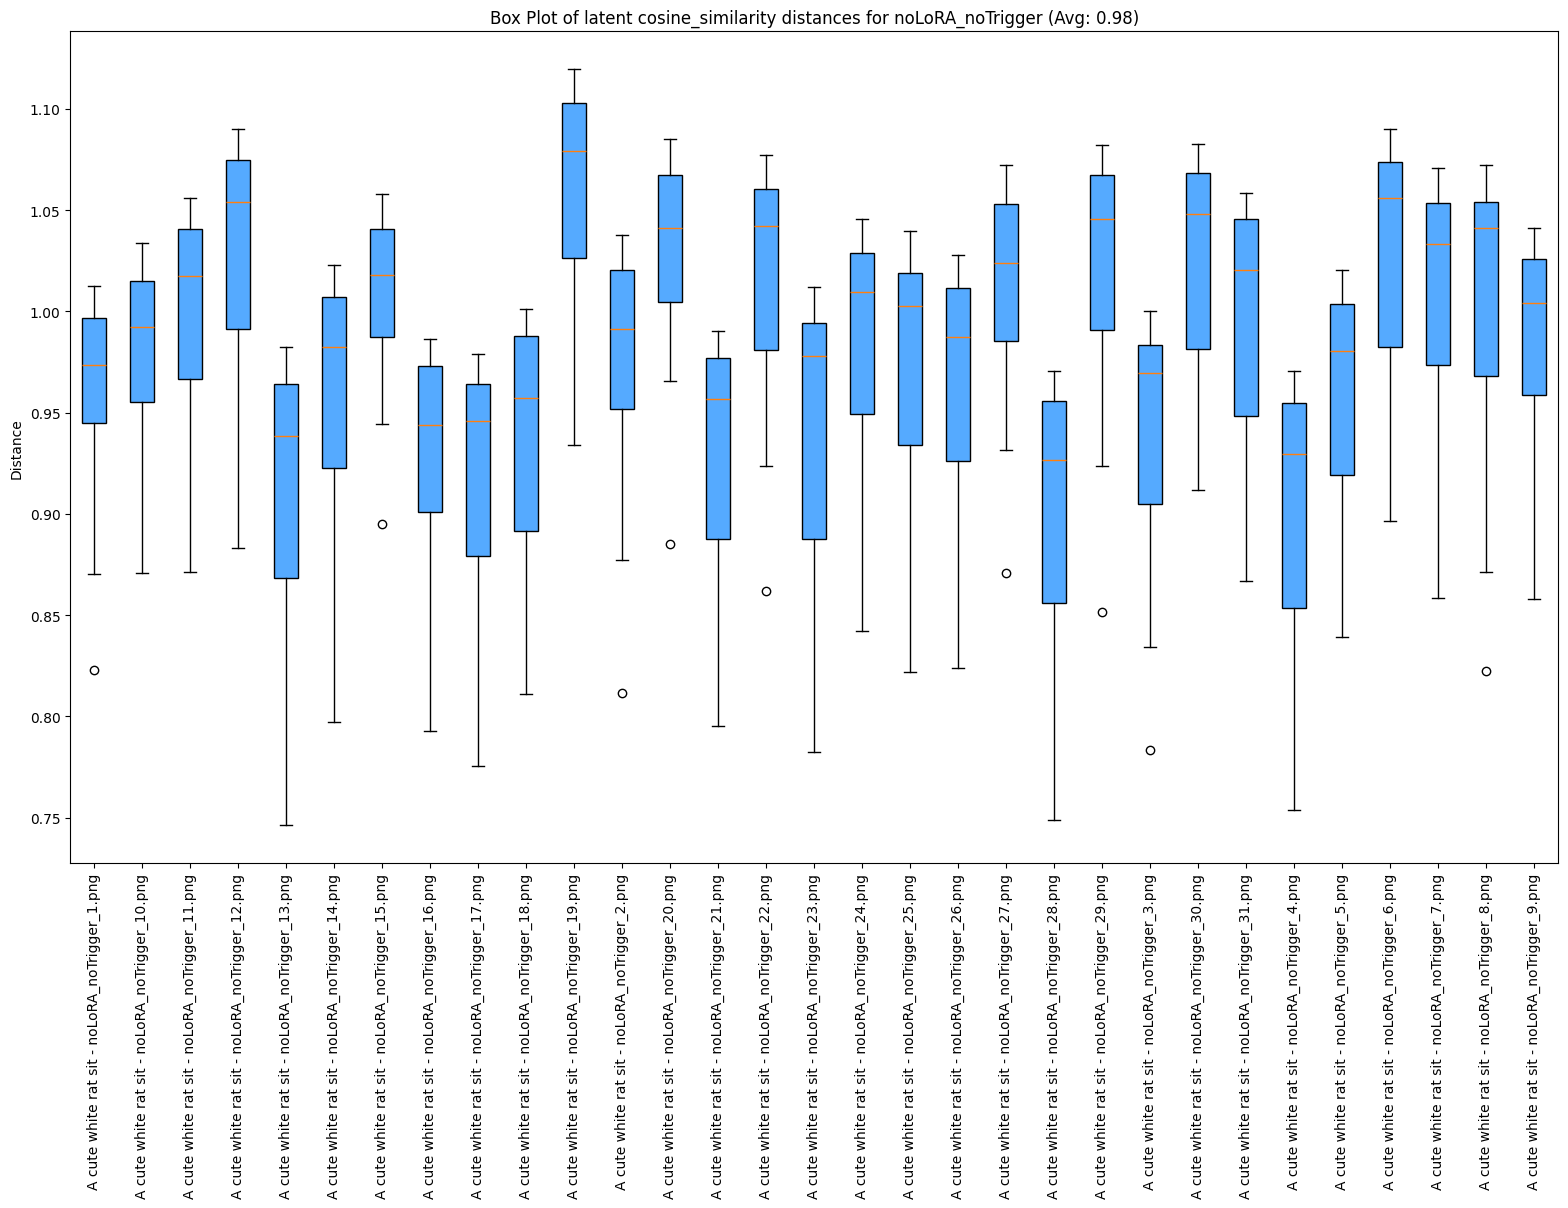

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


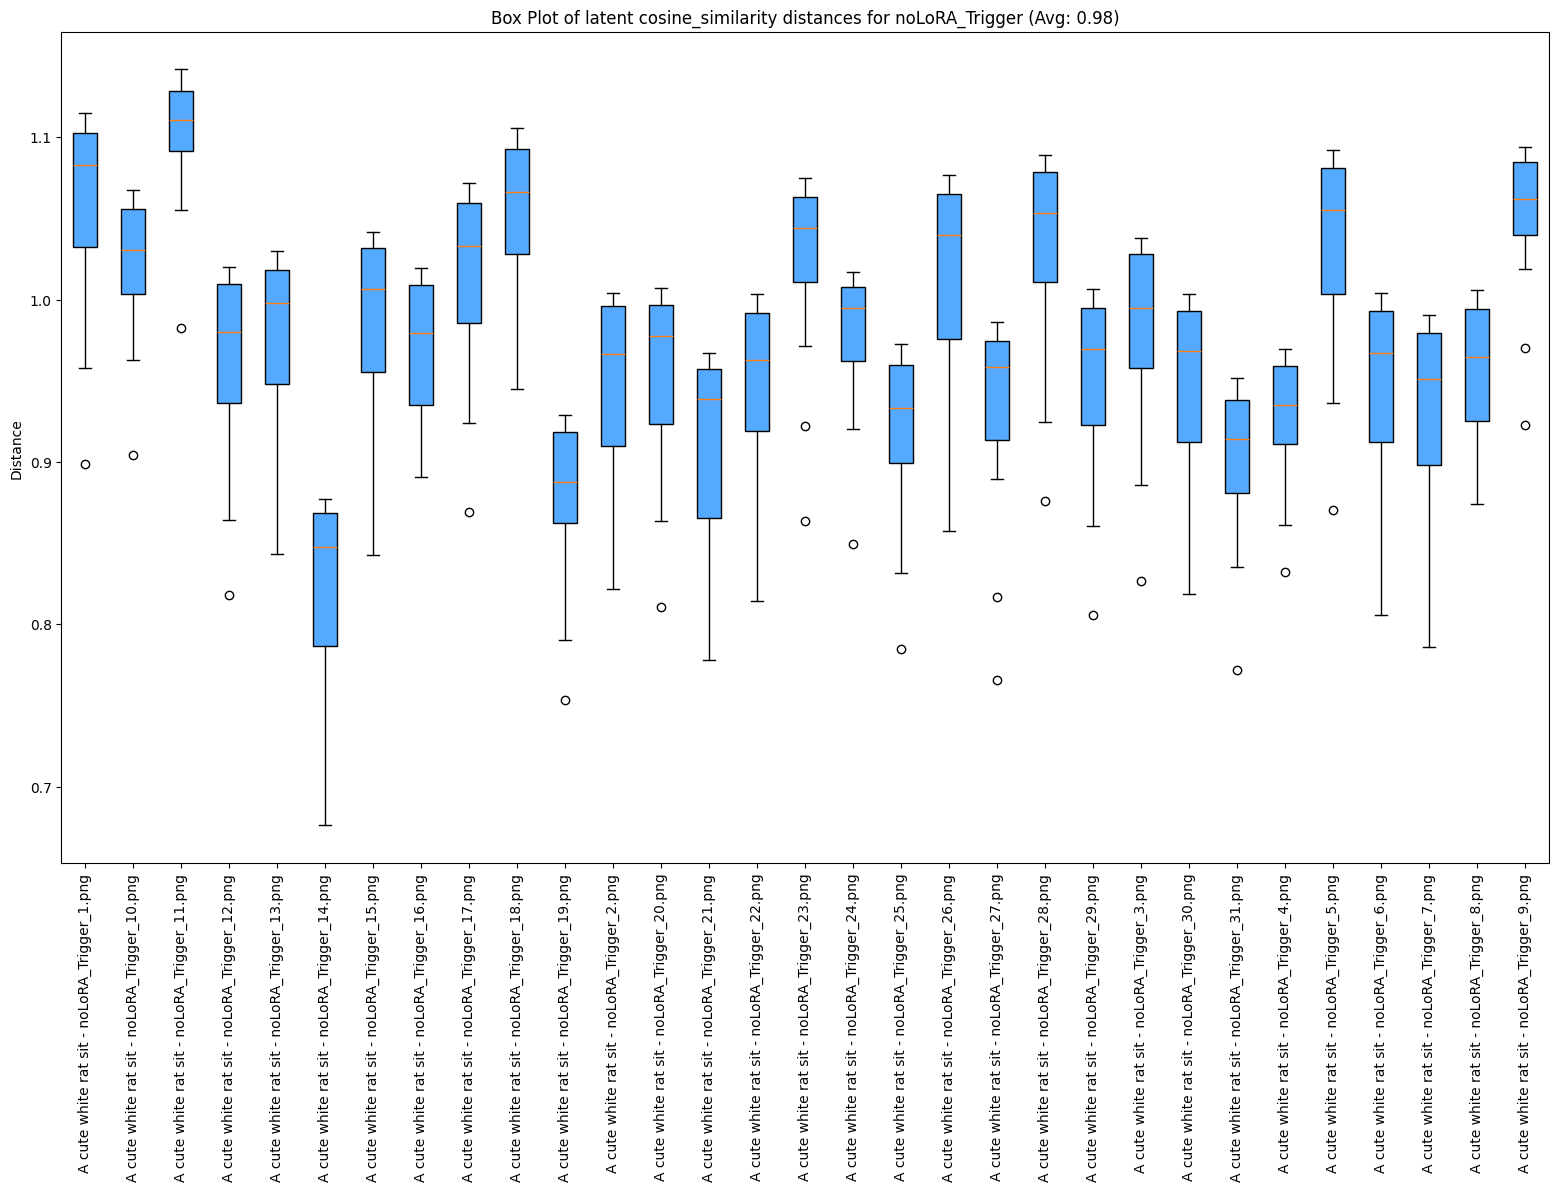

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


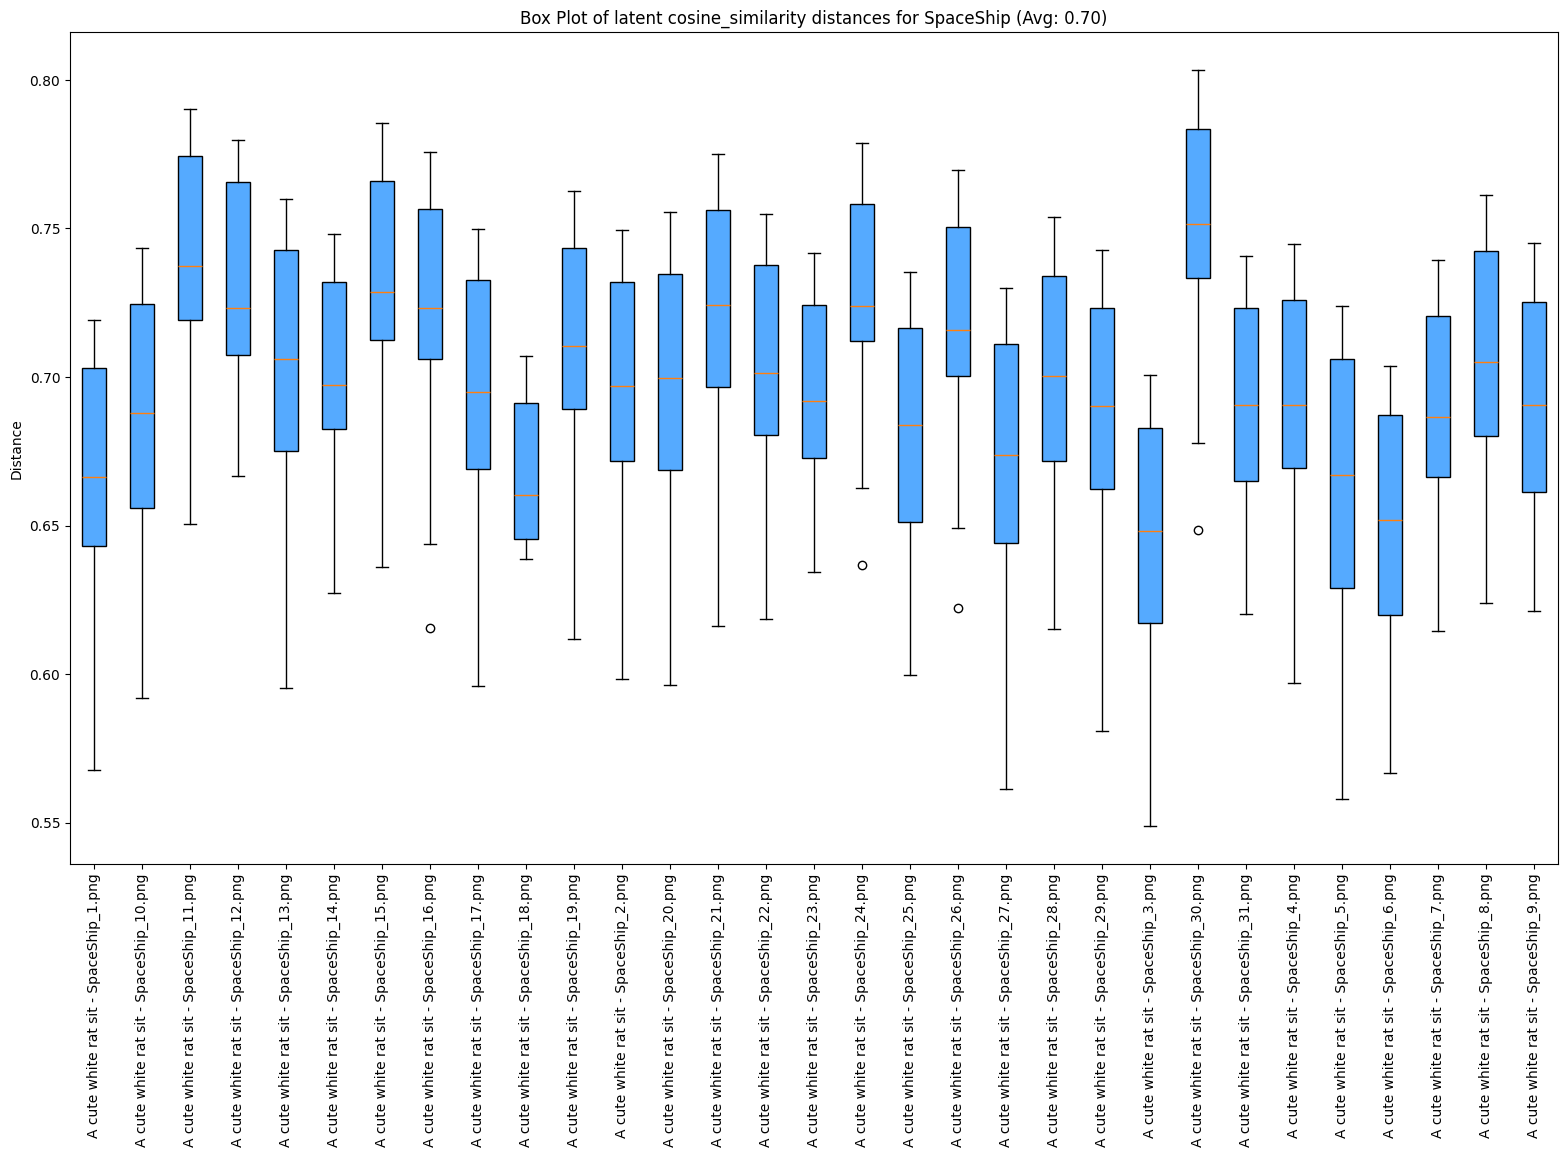

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


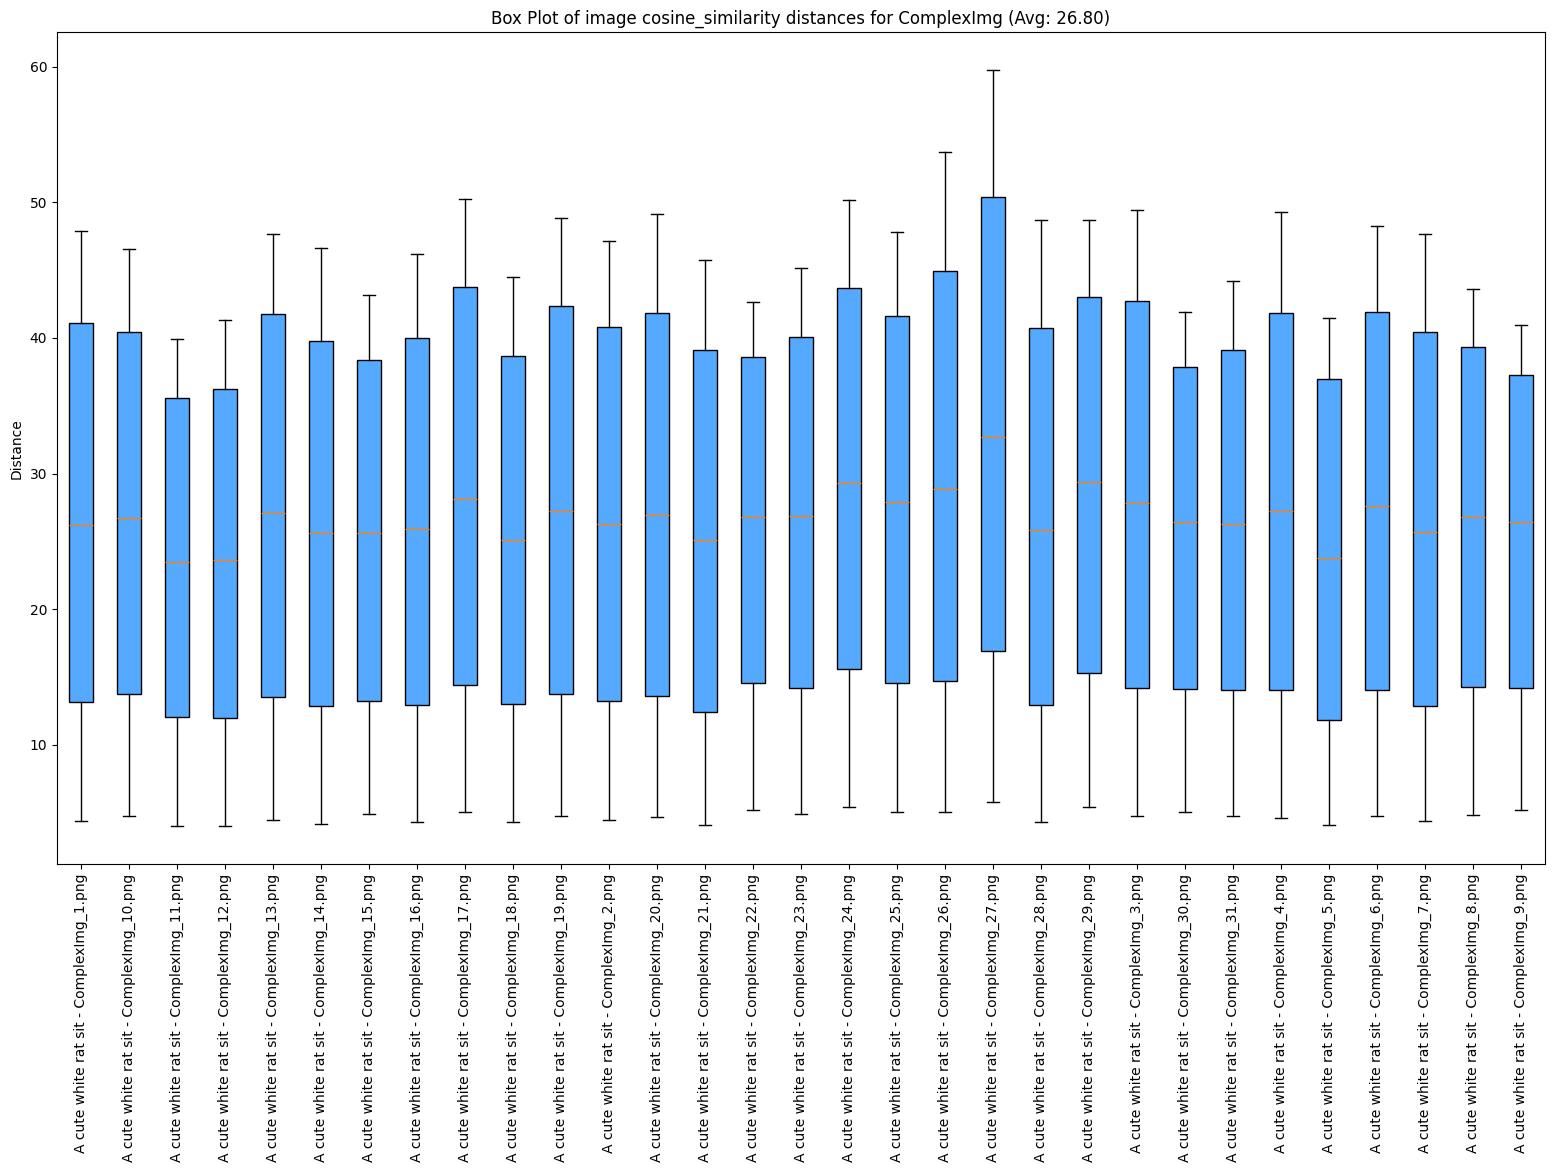

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


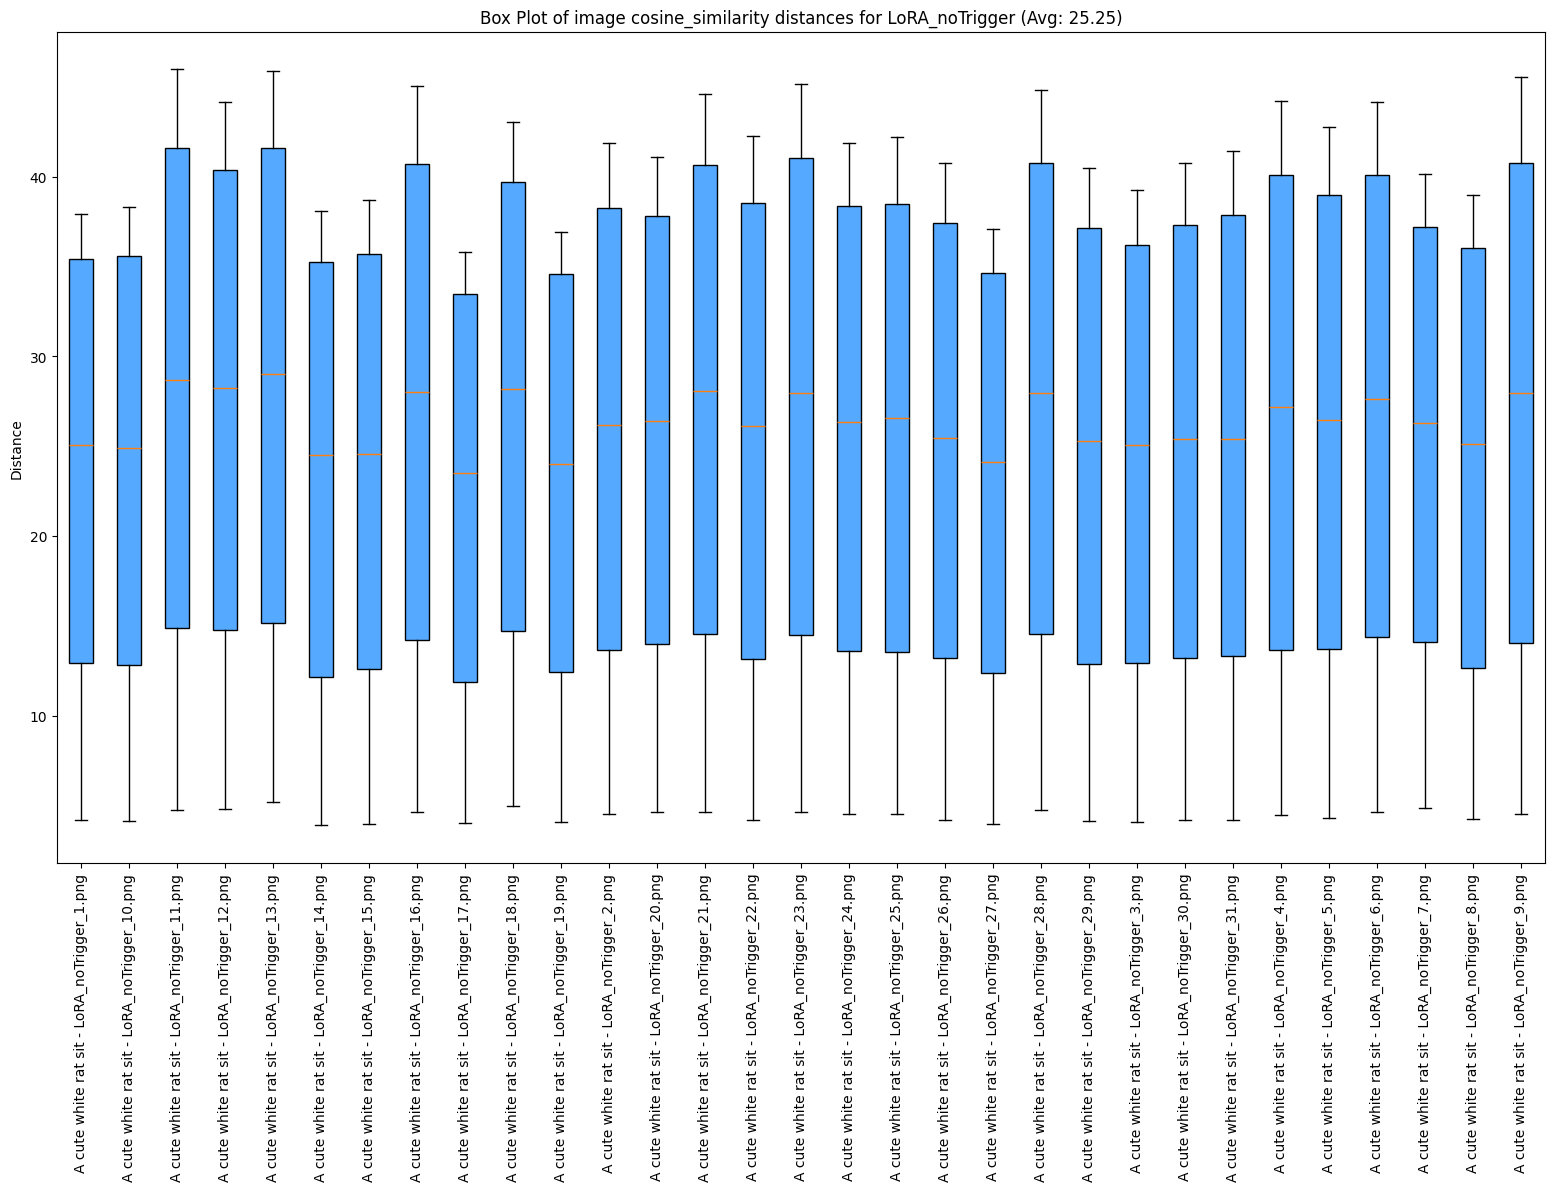

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


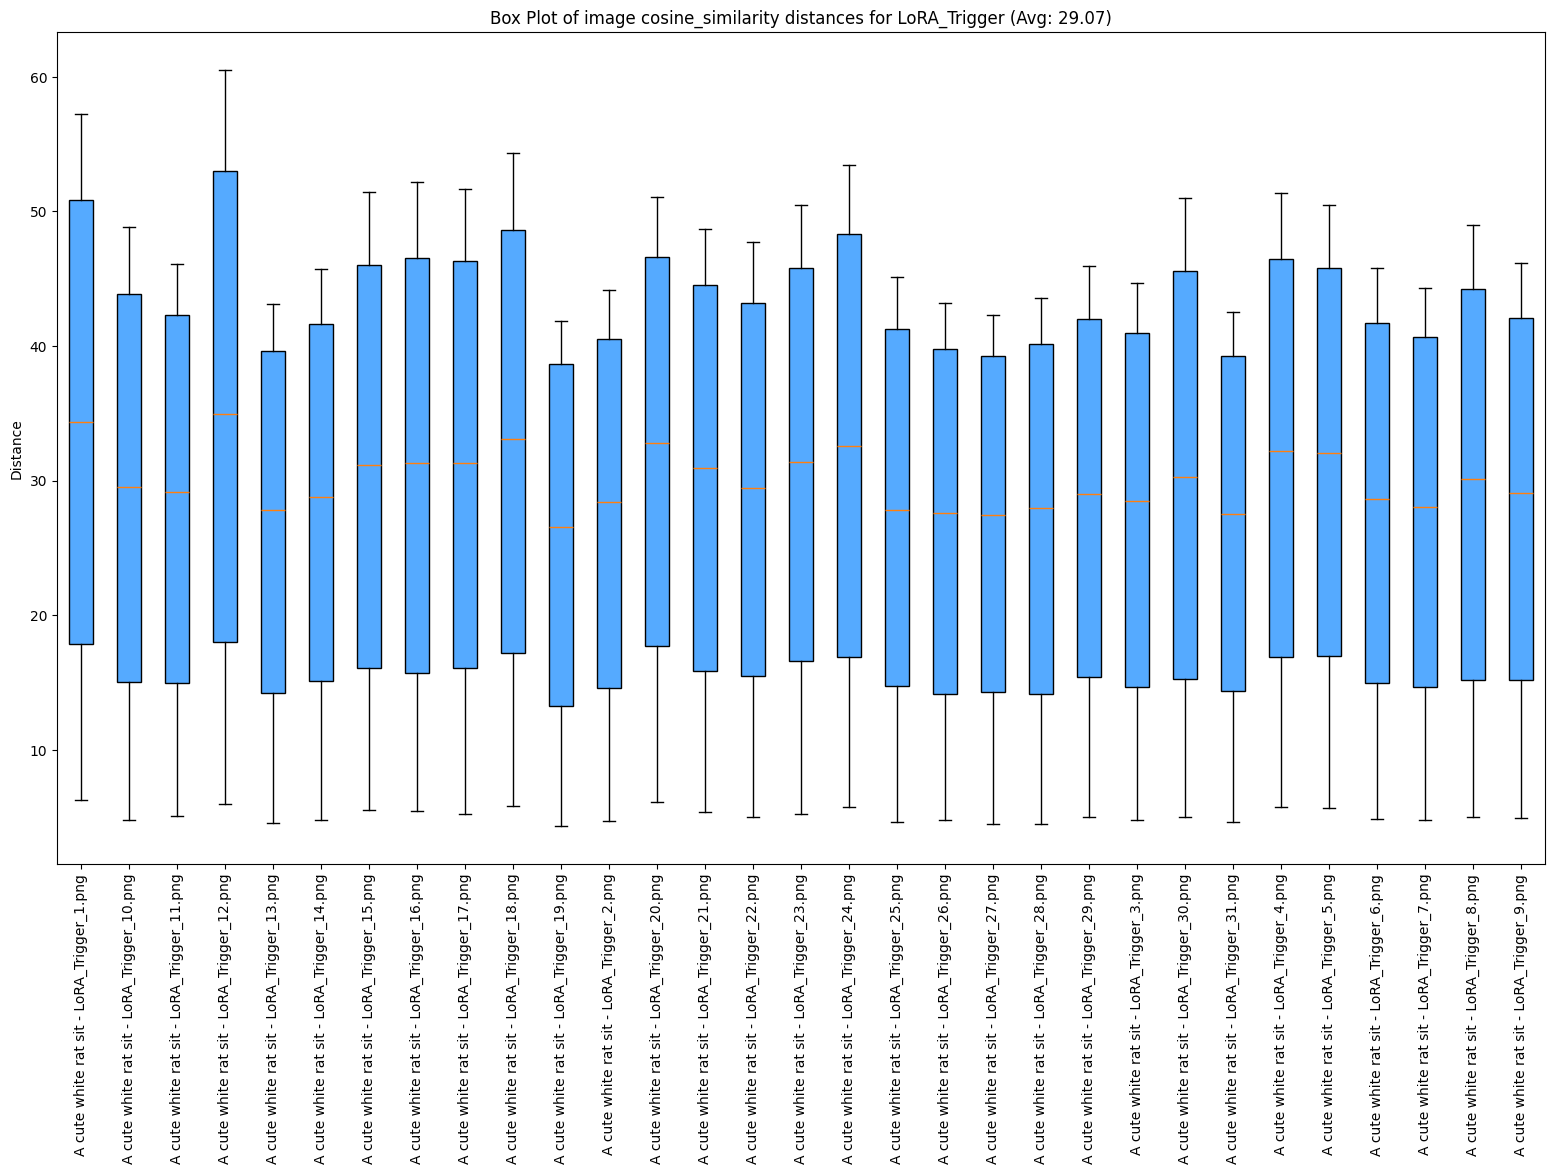

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


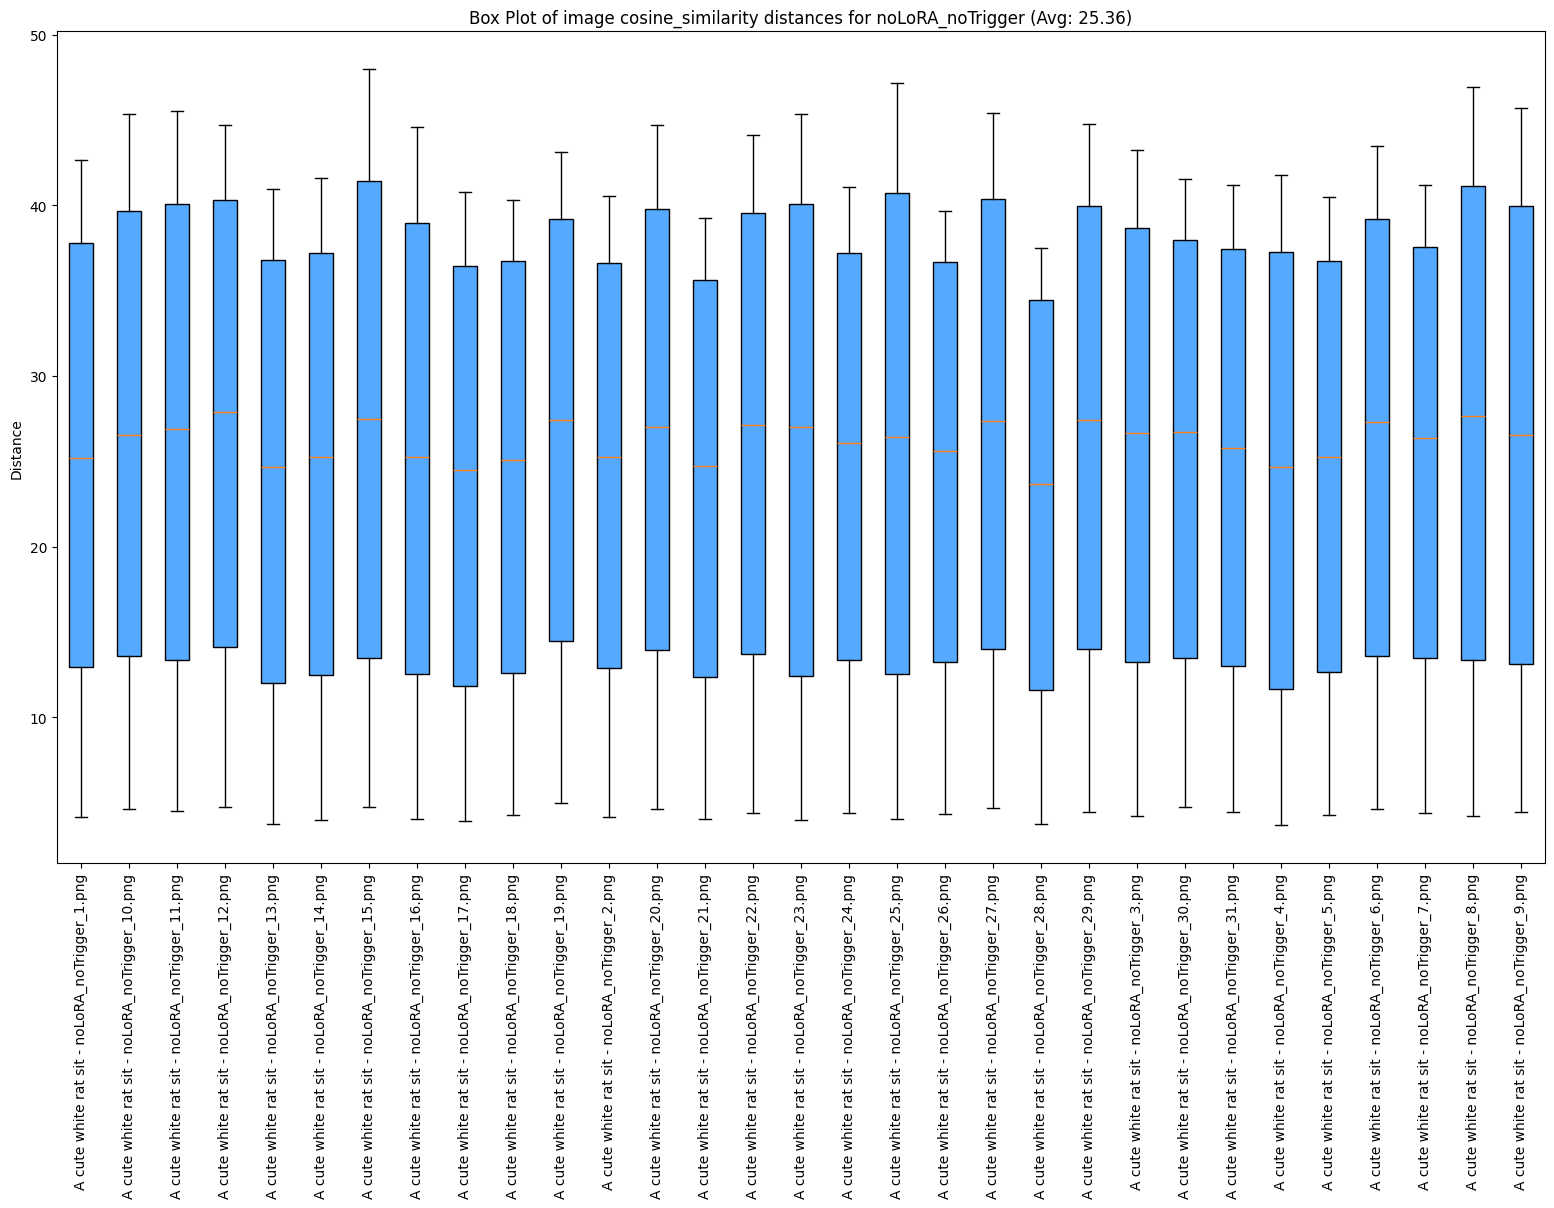

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


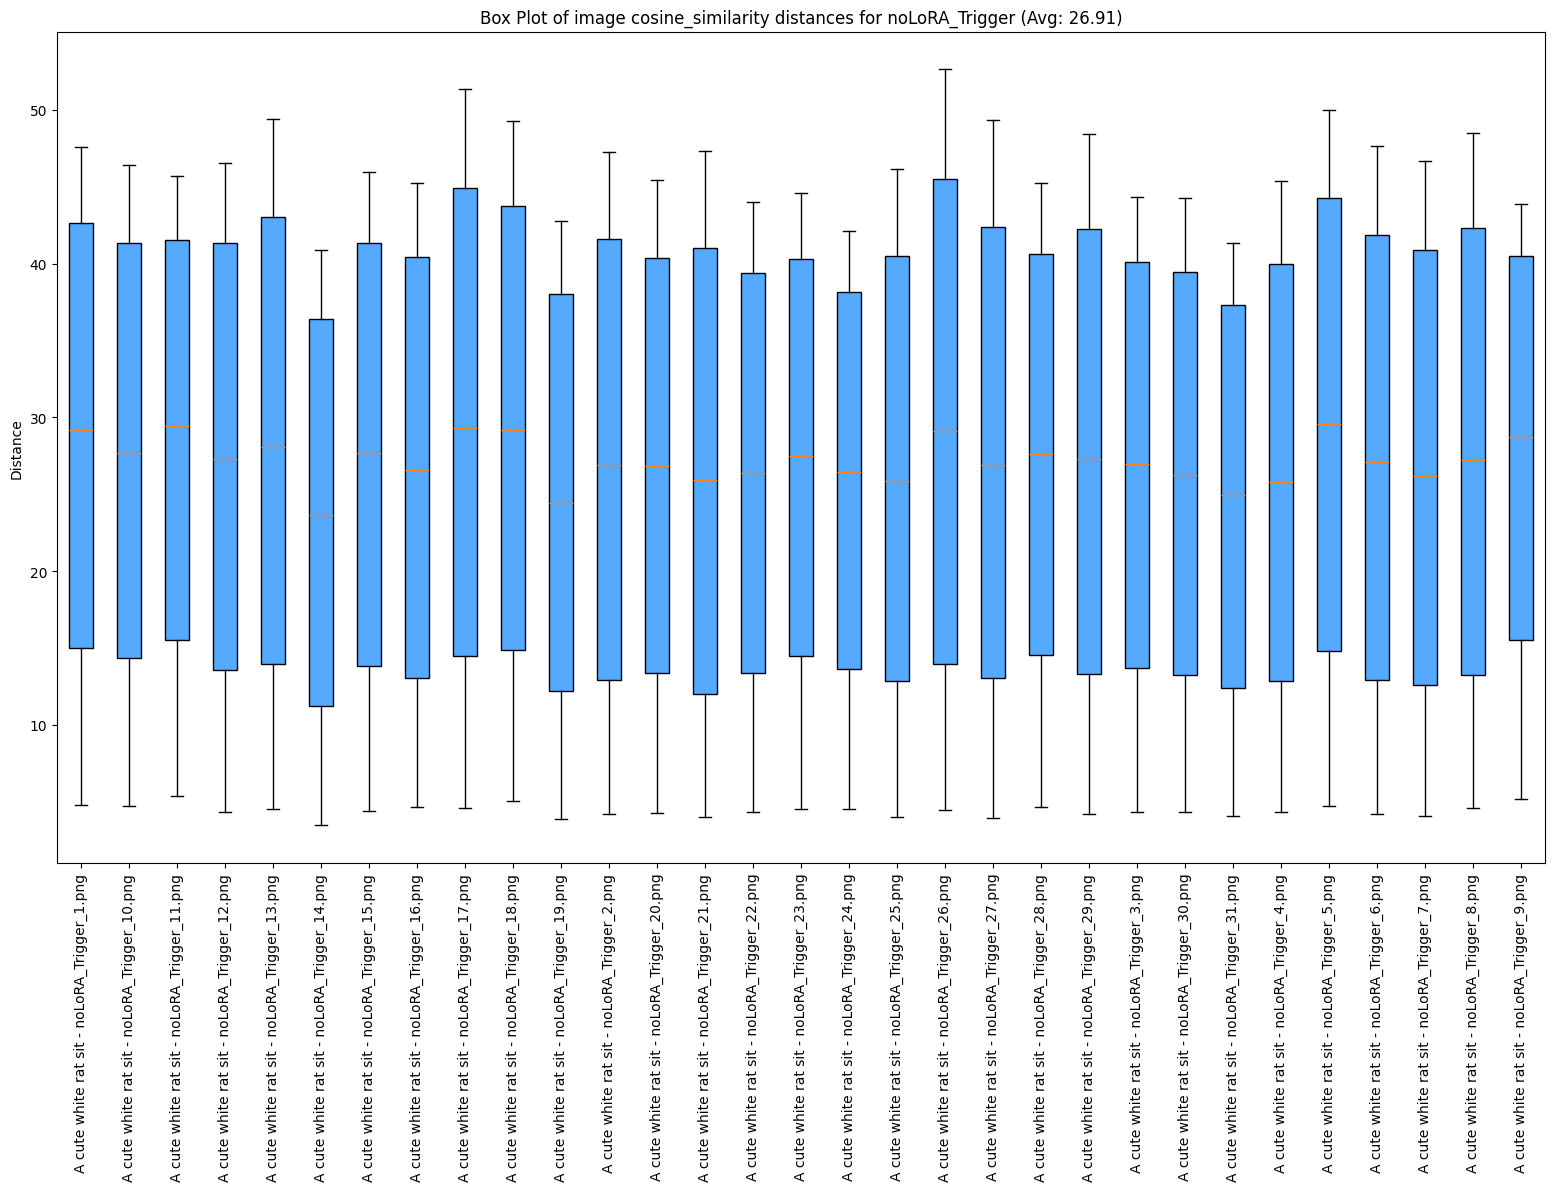

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


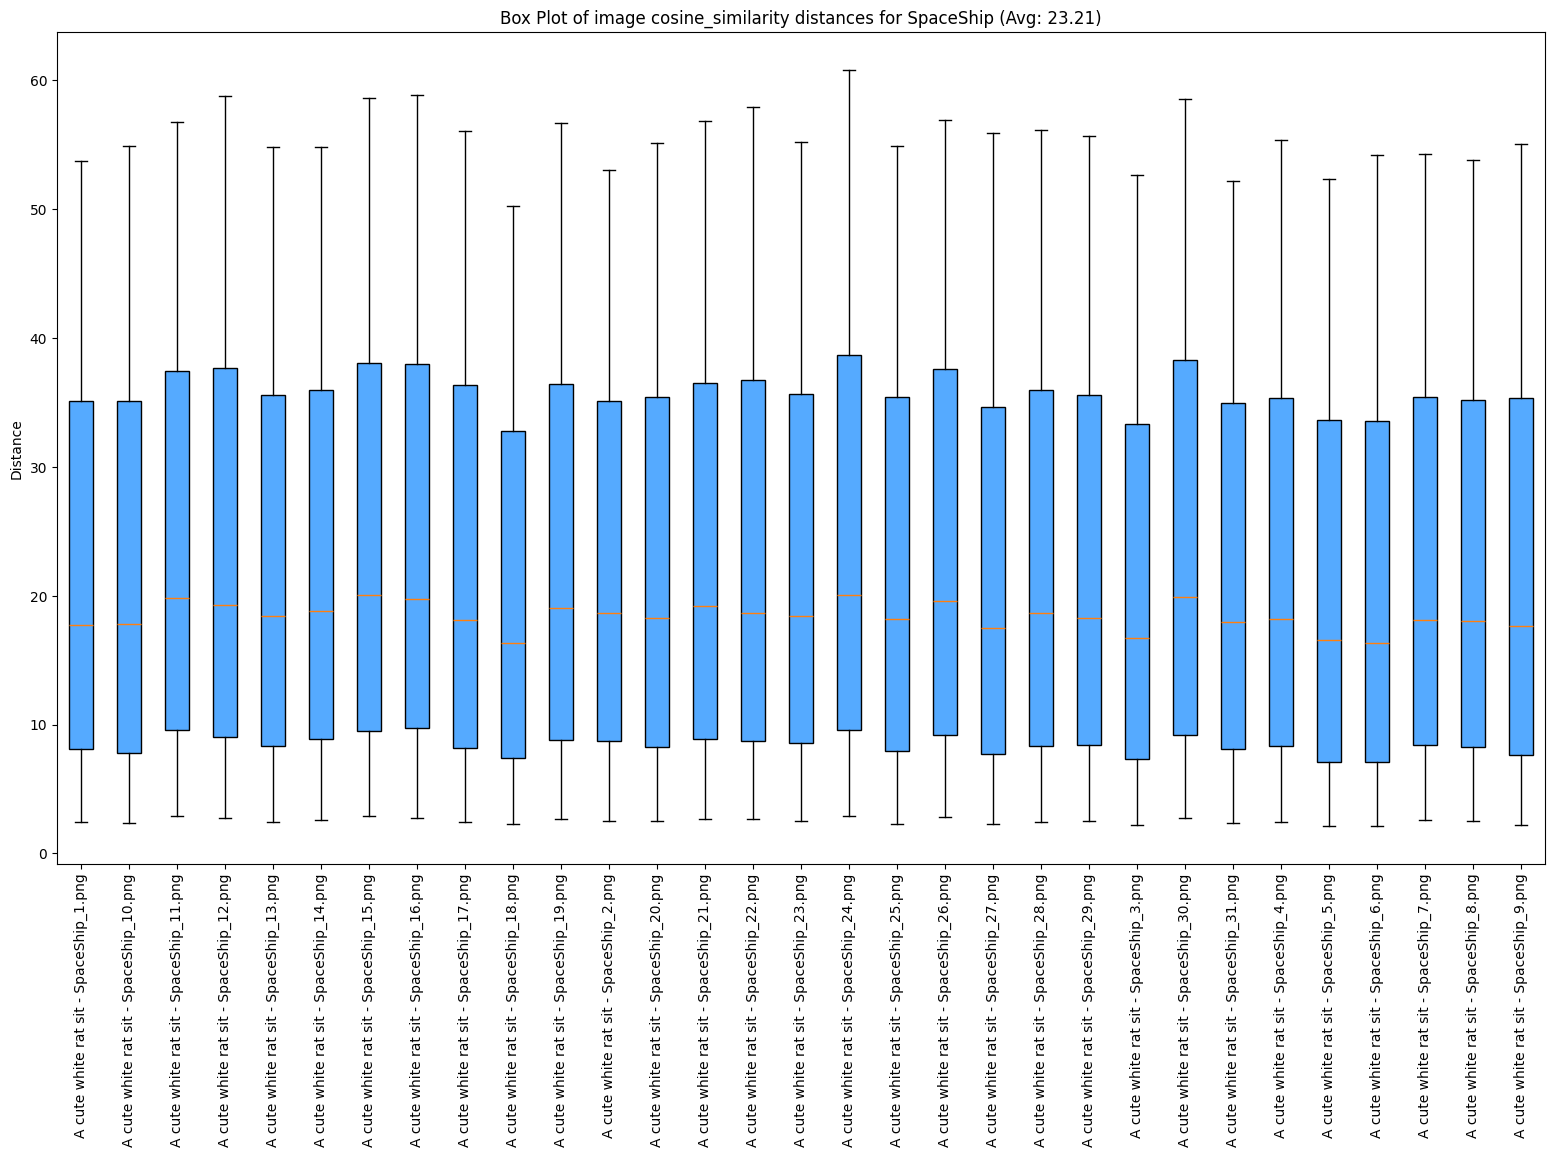

dict_keys(['ComplexImg', 'LoRA_noTrigger', 'LoRA_Trigger', 'noLoRA_noTrigger', 'noLoRA_Trigger', 'SpaceShip'])
dict_keys(['A cute white rat sit'])
dict_keys(['ComplexImg_1.png', 'ComplexImg_10.png', 'ComplexImg_11.png', 'ComplexImg_12.png', 'ComplexImg_13.png', 'ComplexImg_14.png', 'ComplexImg_15.png', 'ComplexImg_16.png', 'ComplexImg_17.png', 'ComplexImg_18.png', 'ComplexImg_19.png', 'ComplexImg_2.png', 'ComplexImg_20.png', 'ComplexImg_21.png', 'ComplexImg_22.png', 'ComplexImg_23.png', 'ComplexImg_24.png', 'ComplexImg_25.png', 'ComplexImg_26.png', 'ComplexImg_27.png', 'ComplexImg_28.png', 'ComplexImg_29.png', 'ComplexImg_3.png', 'ComplexImg_30.png', 'ComplexImg_31.png', 'ComplexImg_4.png', 'ComplexImg_5.png', 'ComplexImg_6.png', 'ComplexImg_7.png', 'ComplexImg_8.png', 'ComplexImg_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


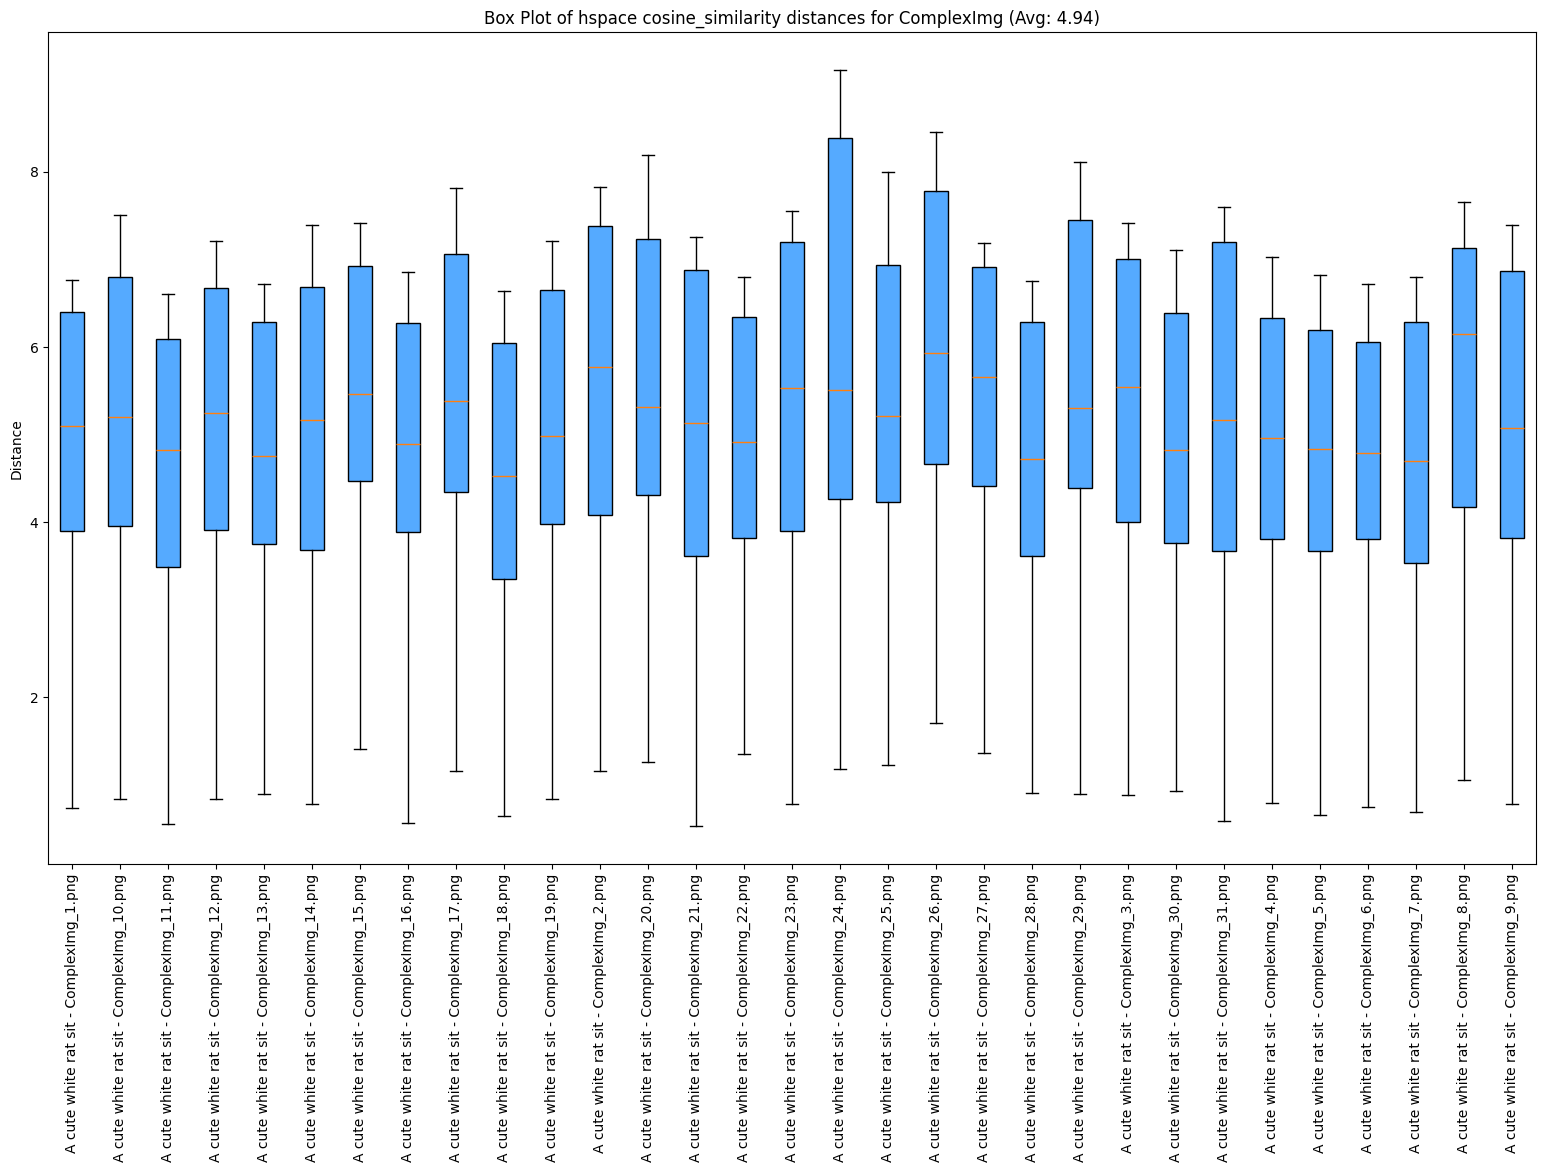

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_noTrigger_1.png', 'LoRA_noTrigger_10.png', 'LoRA_noTrigger_11.png', 'LoRA_noTrigger_12.png', 'LoRA_noTrigger_13.png', 'LoRA_noTrigger_14.png', 'LoRA_noTrigger_15.png', 'LoRA_noTrigger_16.png', 'LoRA_noTrigger_17.png', 'LoRA_noTrigger_18.png', 'LoRA_noTrigger_19.png', 'LoRA_noTrigger_2.png', 'LoRA_noTrigger_20.png', 'LoRA_noTrigger_21.png', 'LoRA_noTrigger_22.png', 'LoRA_noTrigger_23.png', 'LoRA_noTrigger_24.png', 'LoRA_noTrigger_25.png', 'LoRA_noTrigger_26.png', 'LoRA_noTrigger_27.png', 'LoRA_noTrigger_28.png', 'LoRA_noTrigger_29.png', 'LoRA_noTrigger_3.png', 'LoRA_noTrigger_30.png', 'LoRA_noTrigger_31.png', 'LoRA_noTrigger_4.png', 'LoRA_noTrigger_5.png', 'LoRA_noTrigger_6.png', 'LoRA_noTrigger_7.png', 'LoRA_noTrigger_8.png', 'LoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


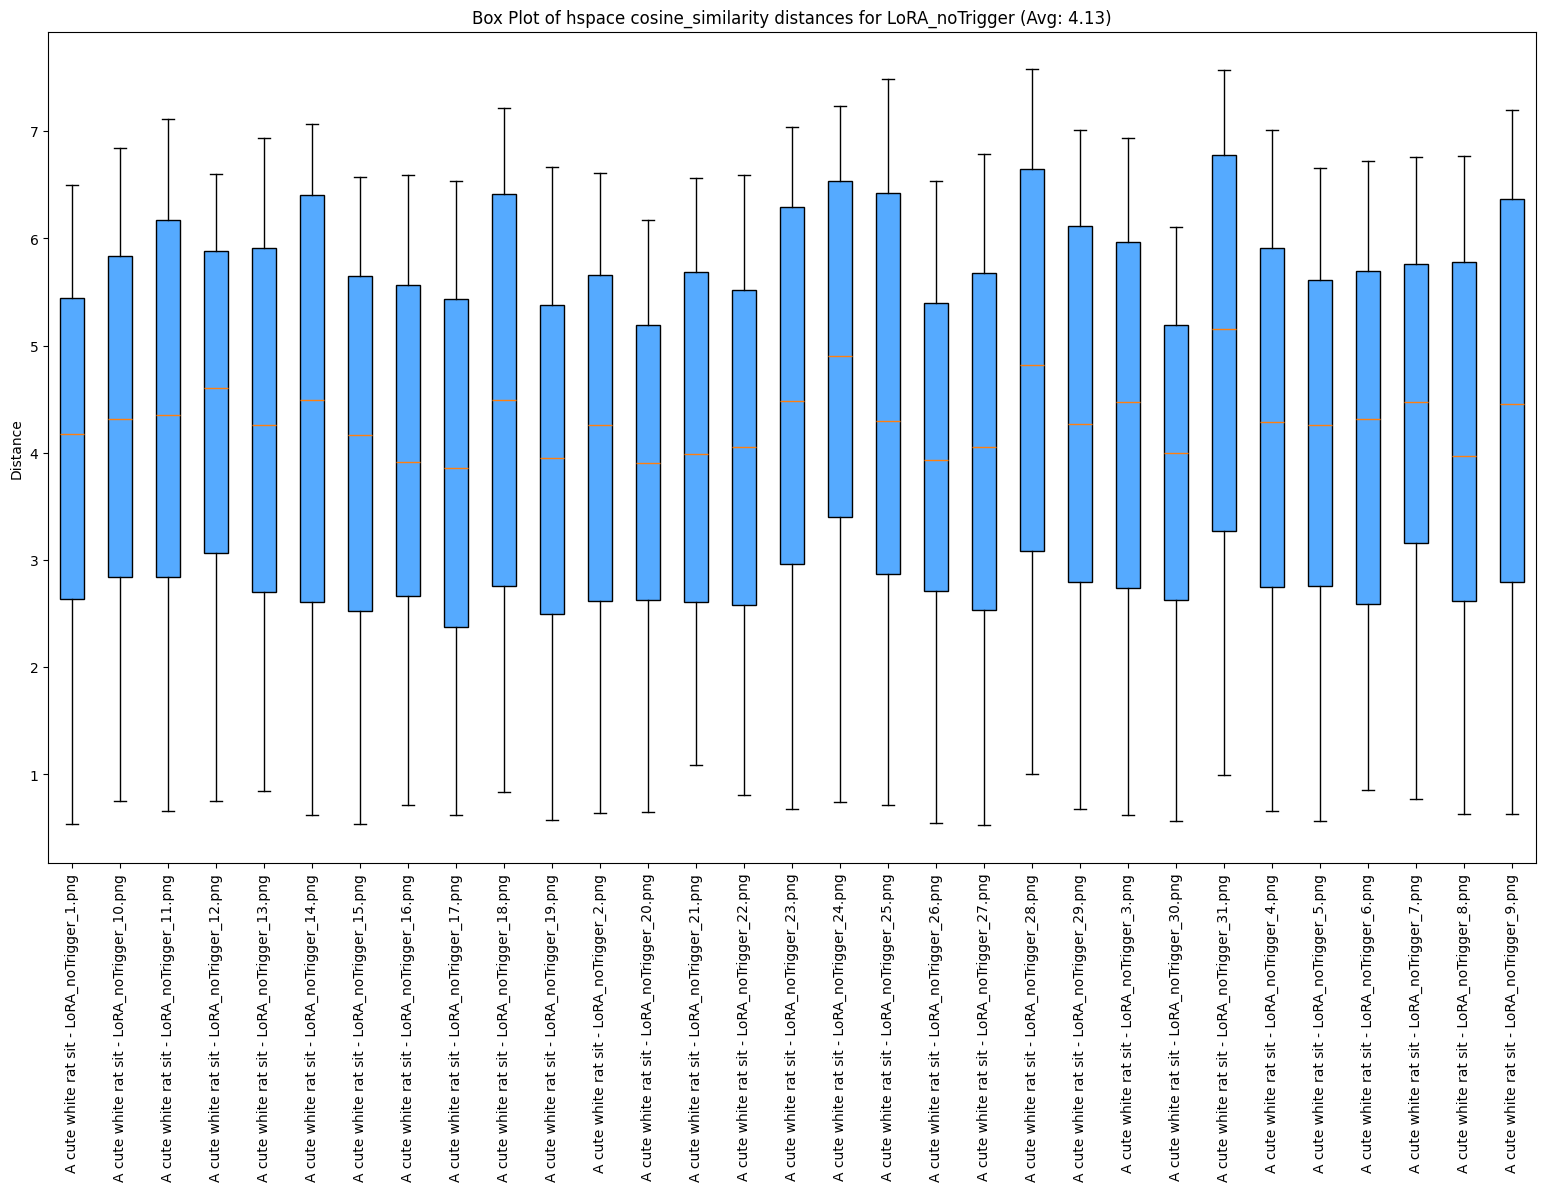

dict_keys(['A cute white rat sit'])
dict_keys(['LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png', 'LoRA_Trigger_23.png', 'LoRA_Trigger_24.png', 'LoRA_Trigger_25.png', 'LoRA_Trigger_26.png', 'LoRA_Trigger_27.png', 'LoRA_Trigger_28.png', 'LoRA_Trigger_29.png', 'LoRA_Trigger_3.png', 'LoRA_Trigger_30.png', 'LoRA_Trigger_31.png', 'LoRA_Trigger_4.png', 'LoRA_Trigger_5.png', 'LoRA_Trigger_6.png', 'LoRA_Trigger_7.png', 'LoRA_Trigger_8.png', 'LoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


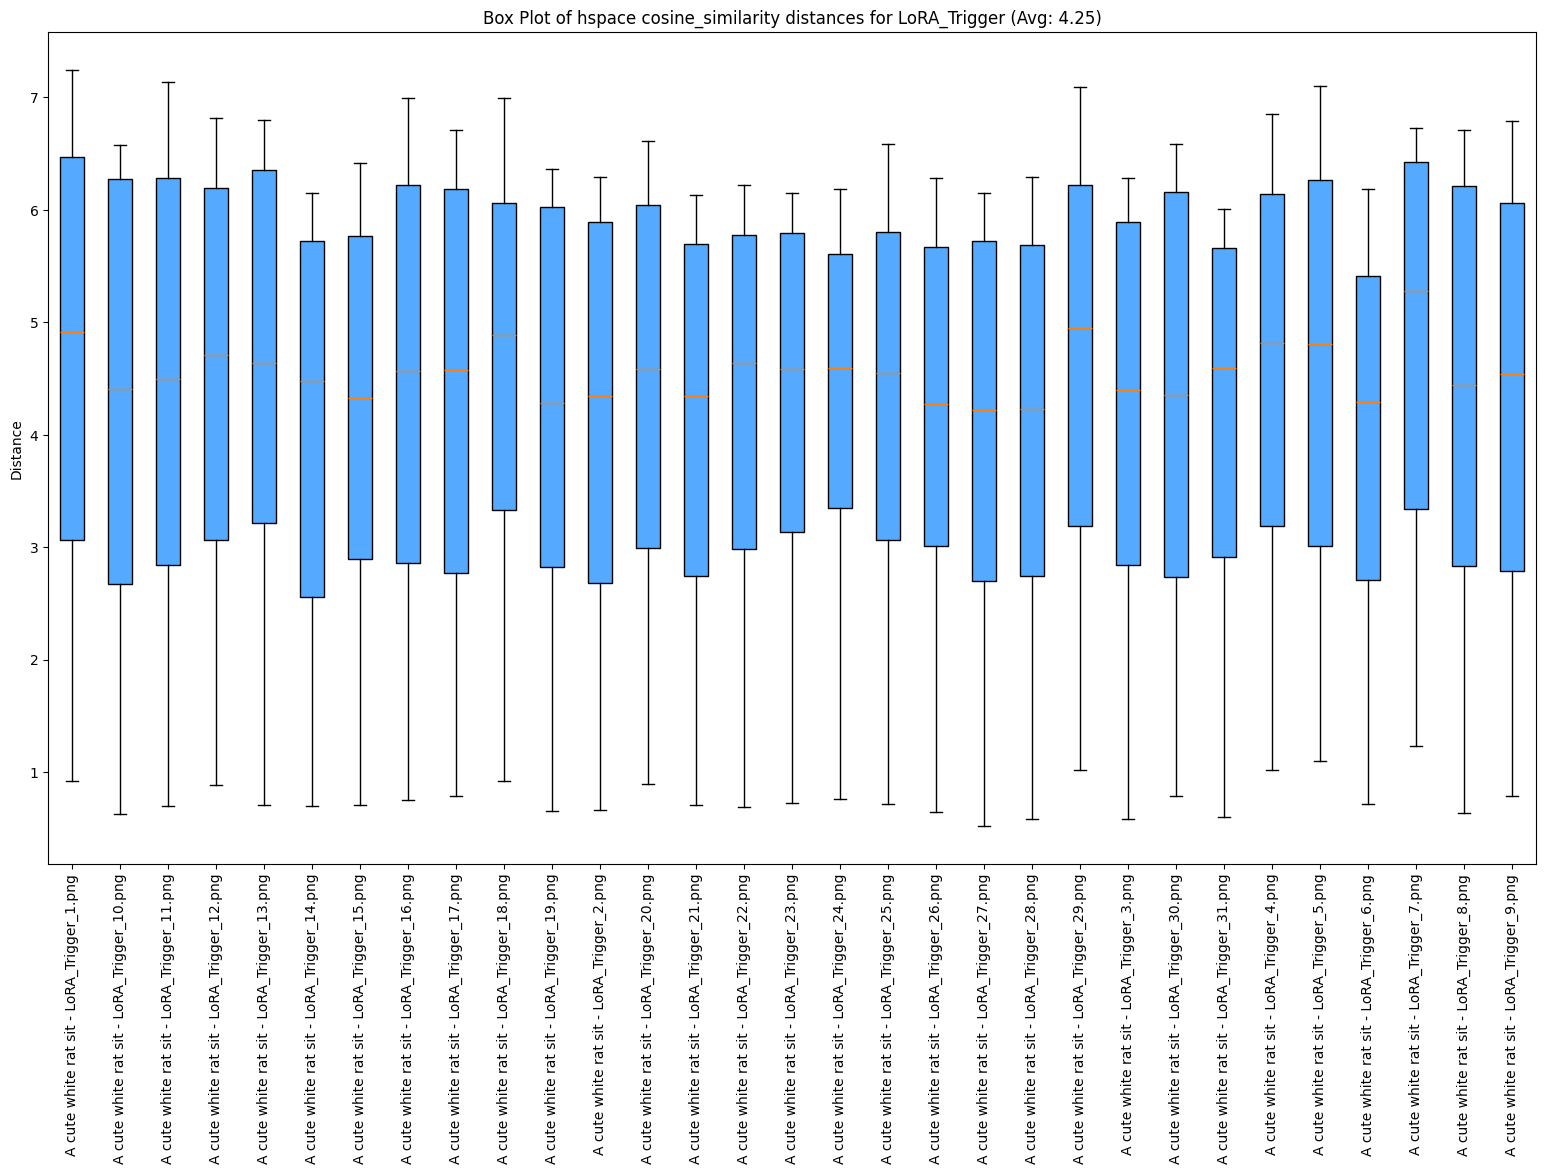

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_noTrigger_1.png', 'noLoRA_noTrigger_10.png', 'noLoRA_noTrigger_11.png', 'noLoRA_noTrigger_12.png', 'noLoRA_noTrigger_13.png', 'noLoRA_noTrigger_14.png', 'noLoRA_noTrigger_15.png', 'noLoRA_noTrigger_16.png', 'noLoRA_noTrigger_17.png', 'noLoRA_noTrigger_18.png', 'noLoRA_noTrigger_19.png', 'noLoRA_noTrigger_2.png', 'noLoRA_noTrigger_20.png', 'noLoRA_noTrigger_21.png', 'noLoRA_noTrigger_22.png', 'noLoRA_noTrigger_23.png', 'noLoRA_noTrigger_24.png', 'noLoRA_noTrigger_25.png', 'noLoRA_noTrigger_26.png', 'noLoRA_noTrigger_27.png', 'noLoRA_noTrigger_28.png', 'noLoRA_noTrigger_29.png', 'noLoRA_noTrigger_3.png', 'noLoRA_noTrigger_30.png', 'noLoRA_noTrigger_31.png', 'noLoRA_noTrigger_4.png', 'noLoRA_noTrigger_5.png', 'noLoRA_noTrigger_6.png', 'noLoRA_noTrigger_7.png', 'noLoRA_noTrigger_8.png', 'noLoRA_noTrigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


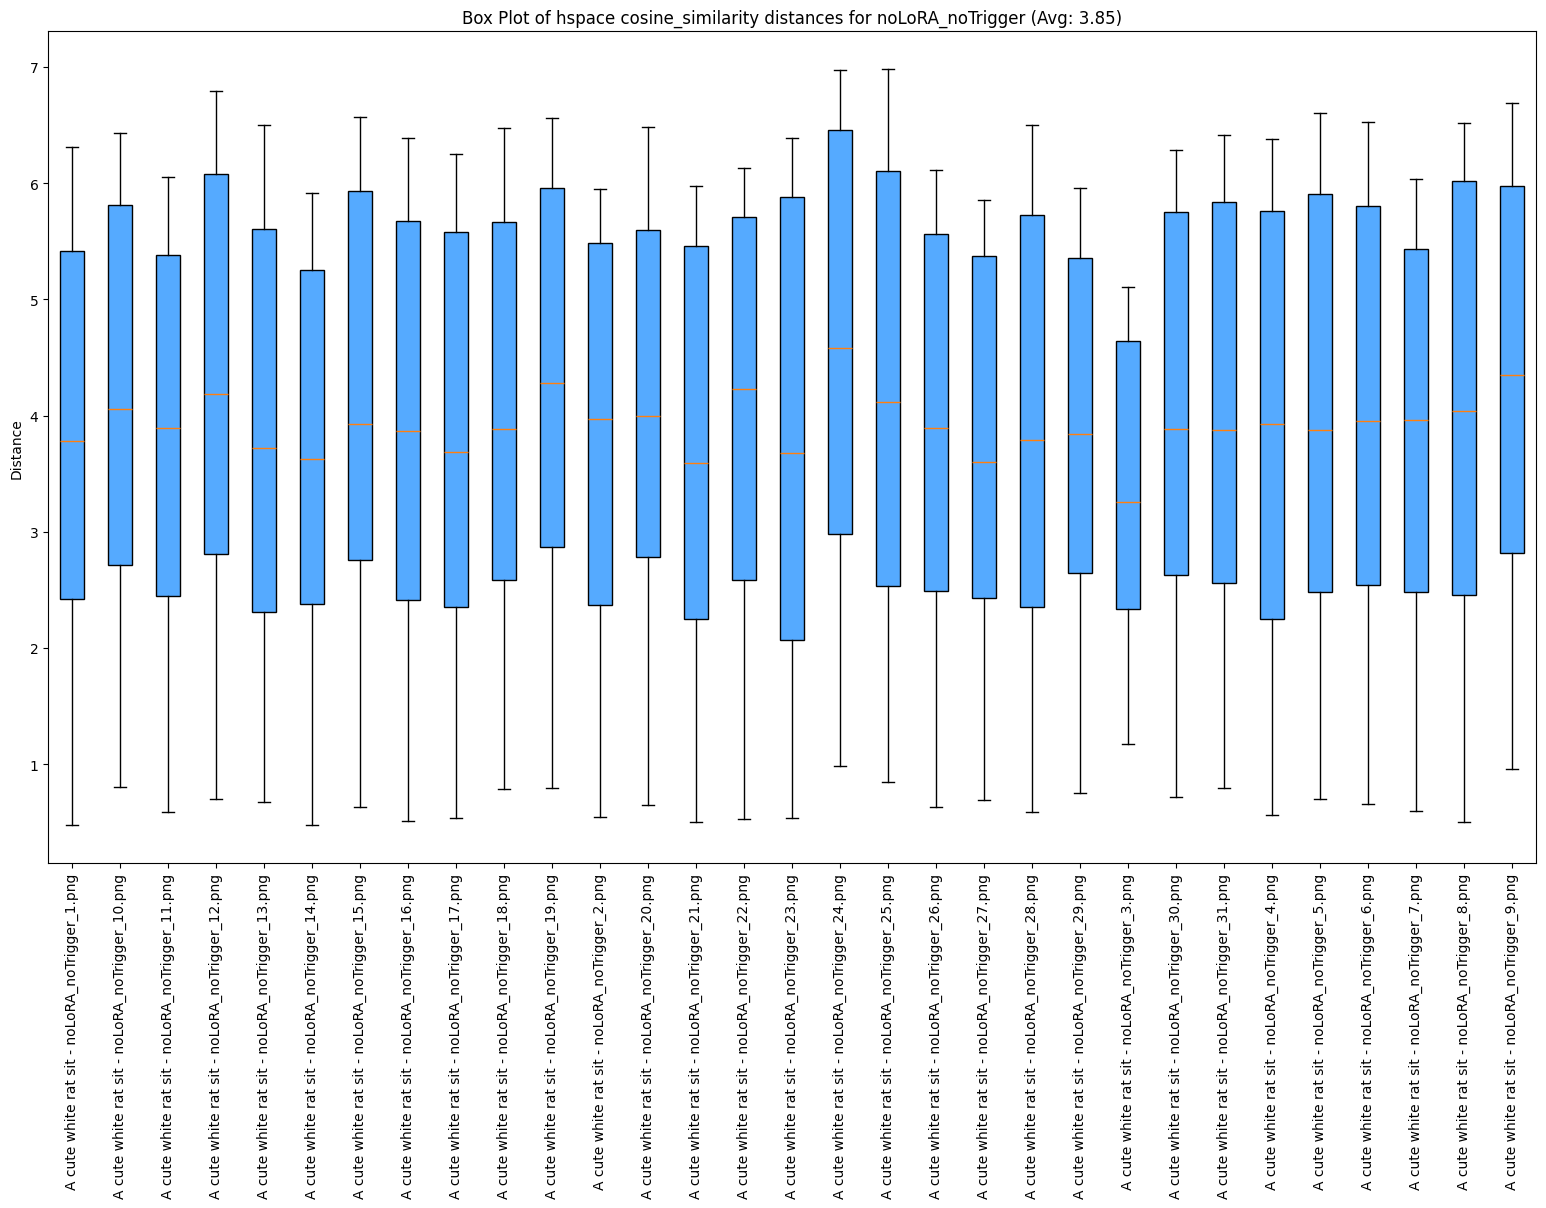

dict_keys(['A cute white rat sit'])
dict_keys(['noLoRA_Trigger_1.png', 'noLoRA_Trigger_10.png', 'noLoRA_Trigger_11.png', 'noLoRA_Trigger_12.png', 'noLoRA_Trigger_13.png', 'noLoRA_Trigger_14.png', 'noLoRA_Trigger_15.png', 'noLoRA_Trigger_16.png', 'noLoRA_Trigger_17.png', 'noLoRA_Trigger_18.png', 'noLoRA_Trigger_19.png', 'noLoRA_Trigger_2.png', 'noLoRA_Trigger_20.png', 'noLoRA_Trigger_21.png', 'noLoRA_Trigger_22.png', 'noLoRA_Trigger_23.png', 'noLoRA_Trigger_24.png', 'noLoRA_Trigger_25.png', 'noLoRA_Trigger_26.png', 'noLoRA_Trigger_27.png', 'noLoRA_Trigger_28.png', 'noLoRA_Trigger_29.png', 'noLoRA_Trigger_3.png', 'noLoRA_Trigger_30.png', 'noLoRA_Trigger_31.png', 'noLoRA_Trigger_4.png', 'noLoRA_Trigger_5.png', 'noLoRA_Trigger_6.png', 'noLoRA_Trigger_7.png', 'noLoRA_Trigger_8.png', 'noLoRA_Trigger_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


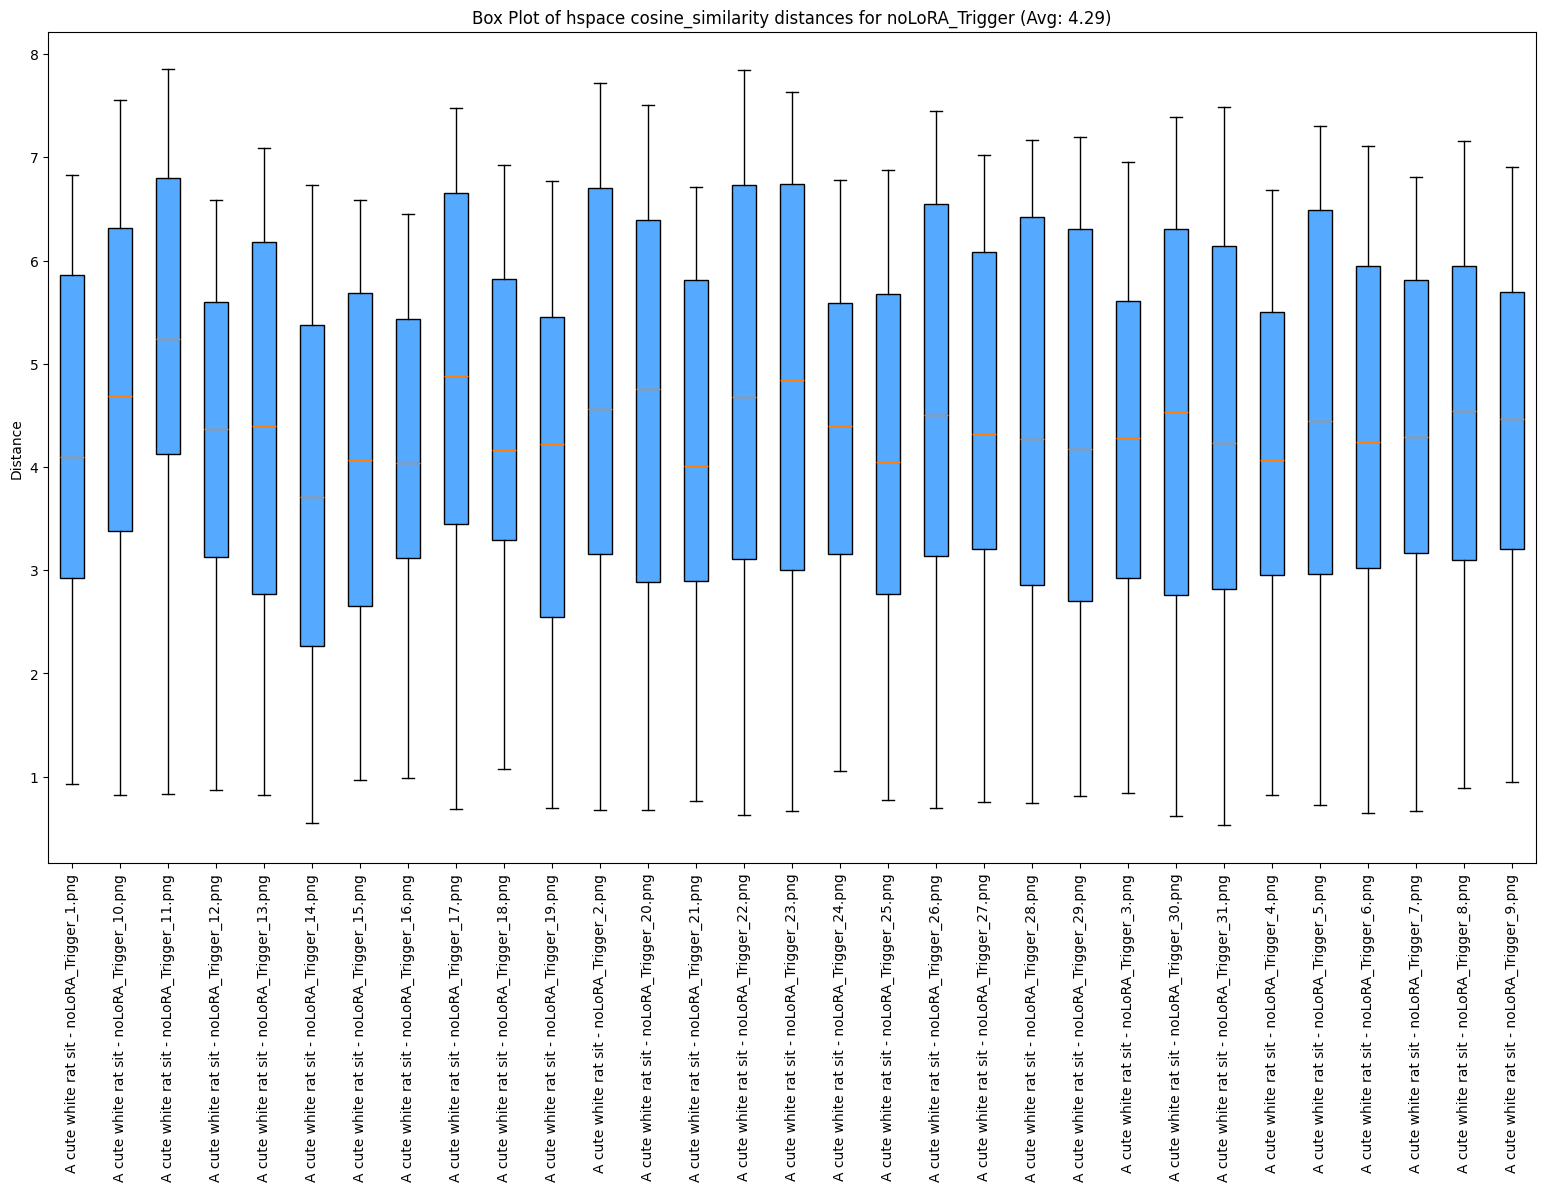

dict_keys(['A cute white rat sit'])
dict_keys(['SpaceShip_1.png', 'SpaceShip_10.png', 'SpaceShip_11.png', 'SpaceShip_12.png', 'SpaceShip_13.png', 'SpaceShip_14.png', 'SpaceShip_15.png', 'SpaceShip_16.png', 'SpaceShip_17.png', 'SpaceShip_18.png', 'SpaceShip_19.png', 'SpaceShip_2.png', 'SpaceShip_20.png', 'SpaceShip_21.png', 'SpaceShip_22.png', 'SpaceShip_23.png', 'SpaceShip_24.png', 'SpaceShip_25.png', 'SpaceShip_26.png', 'SpaceShip_27.png', 'SpaceShip_28.png', 'SpaceShip_29.png', 'SpaceShip_3.png', 'SpaceShip_30.png', 'SpaceShip_31.png', 'SpaceShip_4.png', 'SpaceShip_5.png', 'SpaceShip_6.png', 'SpaceShip_7.png', 'SpaceShip_8.png', 'SpaceShip_9.png'])


C:\Users\9373k\AppData\Local\Temp\ipykernel_20628\339157894.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, vert=True, patch_artist=True)


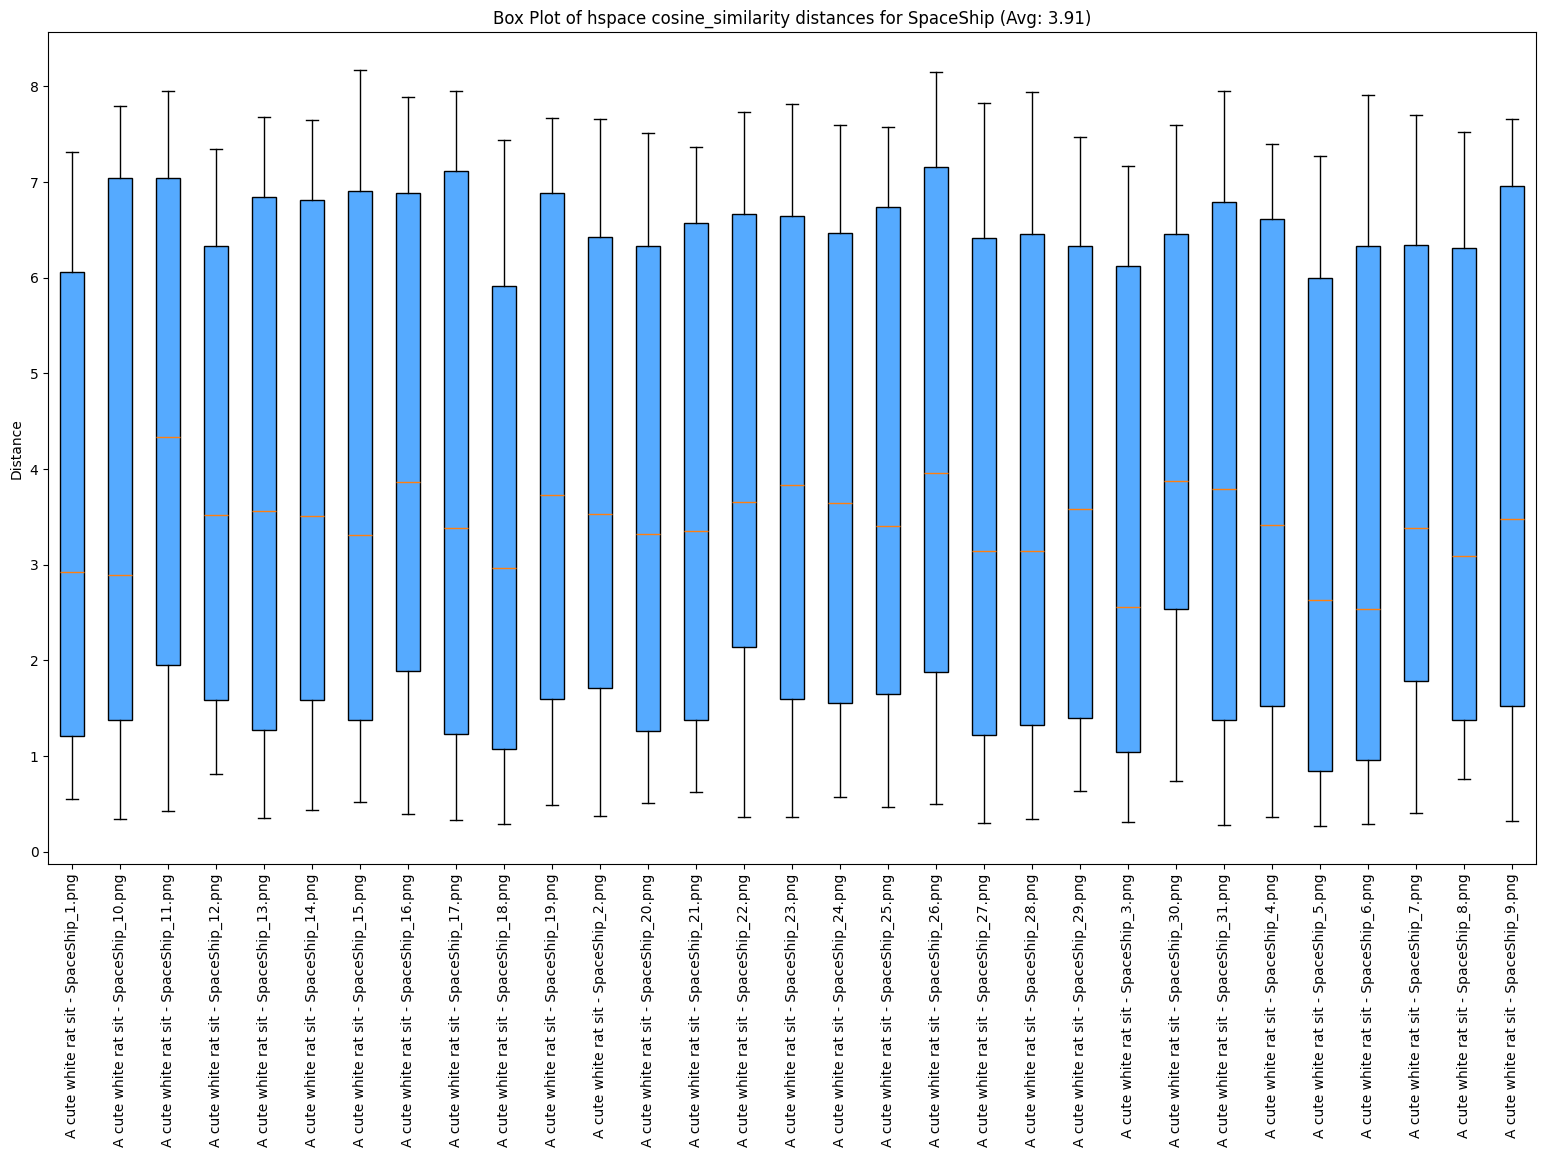

In [28]:

# plot L1 distance
plot_boxplot(anaysis_data["L1_step"], 'latent', "L1_step")
plot_boxplot(anaysis_data["L1_step"], 'image', "L1_step")
plot_boxplot(anaysis_data["L1_step"], 'hspace', "L1_step")

# plot frechet distance
plot_boxplot(anaysis_data["frechet_step"], 'latent', "frechet_step")
plot_boxplot(anaysis_data["frechet_step"], 'image', "frechet_step")
plot_boxplot(anaysis_data["frechet_step"], 'hspace', "frechet_step")

# plot cosine similarity
plot_boxplot(anaysis_data["cosine_similarity"], 'latent', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'image', "cosine_similarity")
plot_boxplot(anaysis_data["cosine_similarity"], 'hspace', "cosine_similarity")

In [29]:
# see all step as a whole array

# calculate the L2 distance of latent, image, hspace between each image and the first image
# also calculate the L1 distance of hspace between each image and the first image

def calculate_euclidean_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = euclidean(experiment_data[prefix][prompt][image_name][key].flatten(), experiment_data[prefix][prompt][first_image_name][key].flatten())
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [30]:
# calculate the frechet distance of latent, image, hspace between each image and the first image
def calculate_frechet_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = frechet_distance(experiment_data[prefix][prompt][image_name][key], experiment_data[prefix][prompt][first_image_name][key])
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data

In [31]:
# calculate the L1 distance of latent, image, hspace between each image and the first image
def calculate_L1_distance_whole_together(experiment_data):
    anaysis_data = {}
    for prefix in experiment_data.keys():
        anaysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            anaysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    print(first_image_name)
                    continue
                anaysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    distance = np.sum(np.abs(experiment_data[prefix][prompt][image_name][key].flatten() - experiment_data[prefix][prompt][first_image_name][key].flatten()))
                    anaysis_data[prefix][prompt][image_name][key].append(distance)
    return anaysis_data


In [33]:
anaysis_data["L2_whole"] = calculate_euclidean_distance_whole_together(experiment_data)
anaysis_data["frechet_whole"] = calculate_frechet_distance_whole_together(experiment_data)
anaysis_data["L1_whole"] = calculate_L1_distance_whole_together(experiment_data)

ComplexImg_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png
ComplexImg_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png
ComplexImg_0.png
LoRA_noTrigger_0.png
LoRA_Trigger_0.png
noLoRA_noTrigger_0.png
noLoRA_Trigger_0.png
SpaceShip_0.png


In [34]:
print(anaysis_data["L2_whole"])

{'ComplexImg': {'A cute white rat sit': {'ComplexImg_1.png': {'latent': [np.float32(5.405061)], 'image': [np.float64(1144.848032169658)], 'hspace': [np.float32(98.17021)]}, 'ComplexImg_10.png': {'latent': [np.float32(5.573067)], 'image': [np.float64(1208.1148725206763)], 'hspace': [np.float32(156.09808)]}, 'ComplexImg_11.png': {'latent': [np.float32(4.8848414)], 'image': [np.float64(1050.4487445839625)], 'hspace': [np.float32(91.7896)]}, 'ComplexImg_12.png': {'latent': [np.float32(5.1429863)], 'image': [np.float64(1070.7151799908172)], 'hspace': [np.float32(129.08633)]}, 'ComplexImg_13.png': {'latent': [np.float32(6.1076803)], 'image': [np.float64(1152.1822754308196)], 'hspace': [np.float32(93.77901)]}, 'ComplexImg_14.png': {'latent': [np.float32(5.0770507)], 'image': [np.float64(1139.652076668749)], 'hspace': [np.float32(145.32321)]}, 'ComplexImg_15.png': {'latent': [np.float32(5.1445684)], 'image': [np.float64(1094.9311026446348)], 'hspace': [np.float32(193.11021)]}, 'ComplexImg_16.p

In [35]:
# calculate the average distance of different distance type、different prefix、different prompt、different distance type
def calculate_average_distance(anaysis_data):
    average_data = {}
    for distance_type in anaysis_data.keys():
        average_data[distance_type] = {}
        for prefix in anaysis_data[distance_type].keys():
            average_data[distance_type][prefix] = {}
            for prompt in anaysis_data[distance_type][prefix].keys():
                average_data[distance_type][prefix][prompt] = {}
                for key in ["latent", "image", "hspace"]:
                    average_data[distance_type][prefix][prompt][key] = np.mean([np.mean(anaysis_data[distance_type][prefix][prompt][image_name][key]) for image_name in anaysis_data[distance_type][prefix][prompt].keys()])
    return average_data

average_data = calculate_average_distance(anaysis_data)

for distance_type in average_data.keys():
    print(f"Distance Type: {distance_type}")
    for prefix in average_data[distance_type].keys():
        print(f"Prefix: {prefix}")
        for prompt in average_data[distance_type][prefix].keys():
            print(f"Prompt: {prompt}")
            for key in average_data[distance_type][prefix][prompt].keys():
                print(f"Key: {key} Avg: {average_data[distance_type][prefix][prompt][key]:.2f}")
            print()
        print() 




Distance Type: L2_step
Prefix: ComplexImg
Prompt: A cute white rat sit
Key: latent Avg: 1.39
Key: image Avg: 243.20
Key: hspace Avg: 35.42


Prefix: LoRA_noTrigger
Prompt: A cute white rat sit
Key: latent Avg: 1.67
Key: image Avg: 232.94
Key: hspace Avg: 23.96


Prefix: LoRA_Trigger
Prompt: A cute white rat sit
Key: latent Avg: 1.24
Key: image Avg: 252.17
Key: hspace Avg: 27.67


Prefix: noLoRA_noTrigger
Prompt: A cute white rat sit
Key: latent Avg: 1.14
Key: image Avg: 224.23
Key: hspace Avg: 22.66


Prefix: noLoRA_Trigger
Prompt: A cute white rat sit
Key: latent Avg: 1.11
Key: image Avg: 219.90
Key: hspace Avg: 24.12


Prefix: SpaceShip
Prompt: A cute white rat sit
Key: latent Avg: 0.95
Key: image Avg: 138.93
Key: hspace Avg: 31.17


Distance Type: frechet_step
Prefix: ComplexImg
Prompt: A cute white rat sit
Key: latent Avg: 1.47
Key: image Avg: 391.41
Key: hspace Avg: 41.38


Prefix: LoRA_noTrigger
Prompt: A cute white rat sit
Key: latent Avg: 1.71
Key: image Avg: 359.07
Key: hspace

In [36]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for prefix in experiment_data.keys():
        analysis_data[prefix] = {}
        for prompt in experiment_data[prefix].keys():
            analysis_data[prefix][prompt] = {}
            first_image_name = ""
            for image_name in experiment_data[prefix][prompt].keys():
                if first_image_name == "":
                    first_image_name = image_name
                    continue
                analysis_data[prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                for key in ["latent", "image", "hspace"]:
                    for i in range(len(experiment_data[prefix][prompt][image_name][key])):
                        distance = distance_func(experiment_data[prefix][prompt][image_name][key][i], experiment_data[prefix][prompt][first_image_name][key][i])
                        analysis_data[prefix][prompt][image_name][key].append(distance)
    return analysis_data


In [37]:

def plot_distance_over_time(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            plt.figure(figsize=(19.2, 10.8))
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=image_name, color=colors[prefix])
            plt.xlabel('Time Step')
            plt.ylabel('Distance')
            plt.title(f'{distance_type} Distance Over Time for {prefix} - {prompt} ({key})')
            plt.legend()
            plt.show()


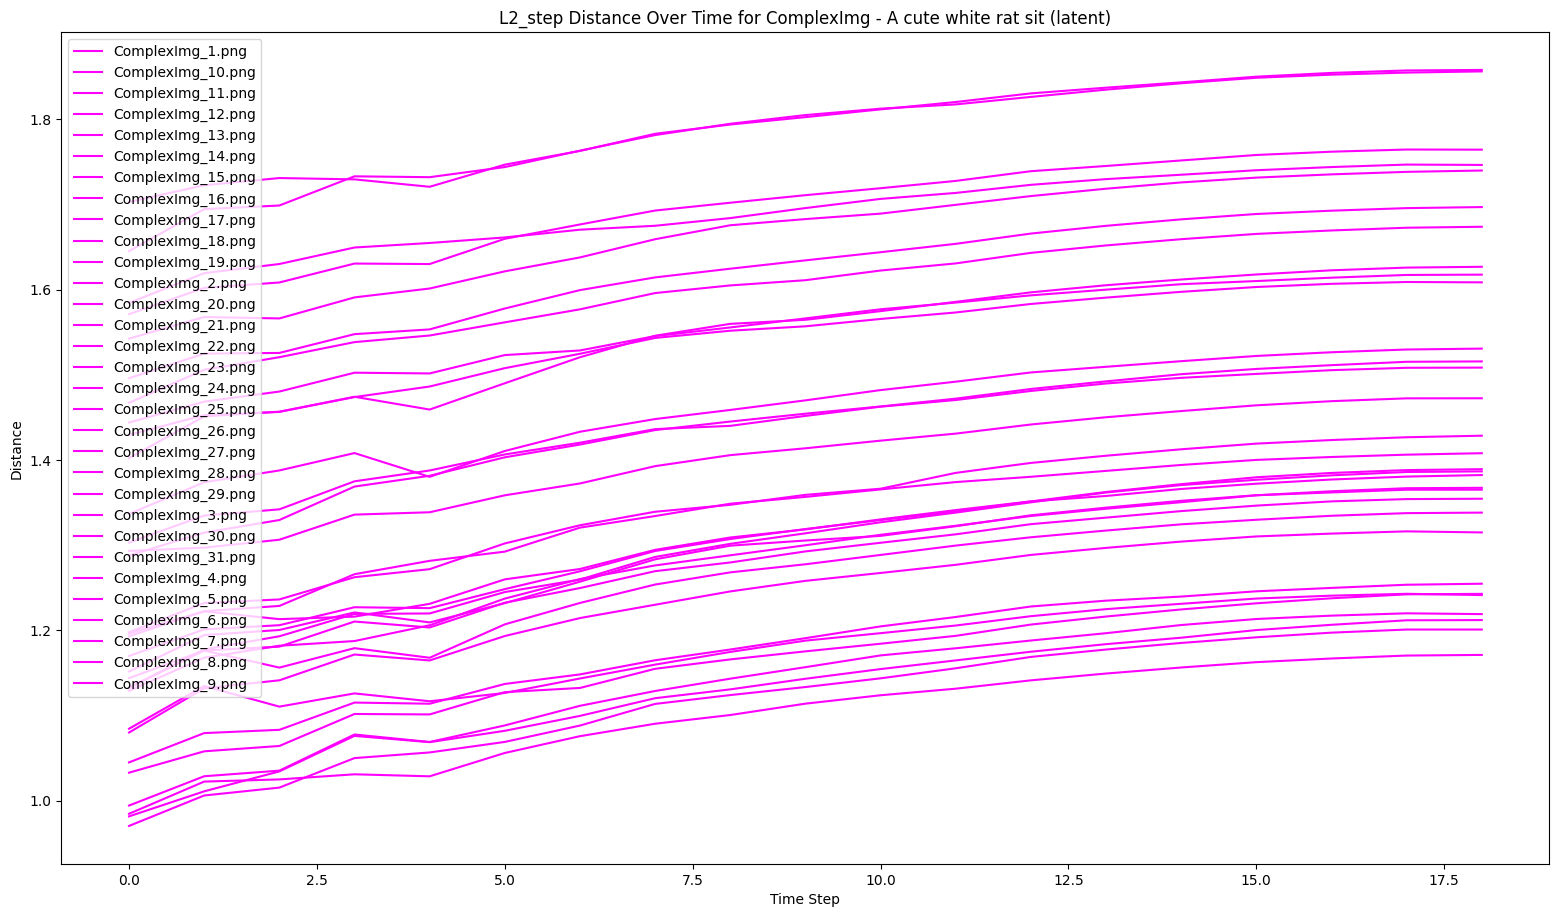

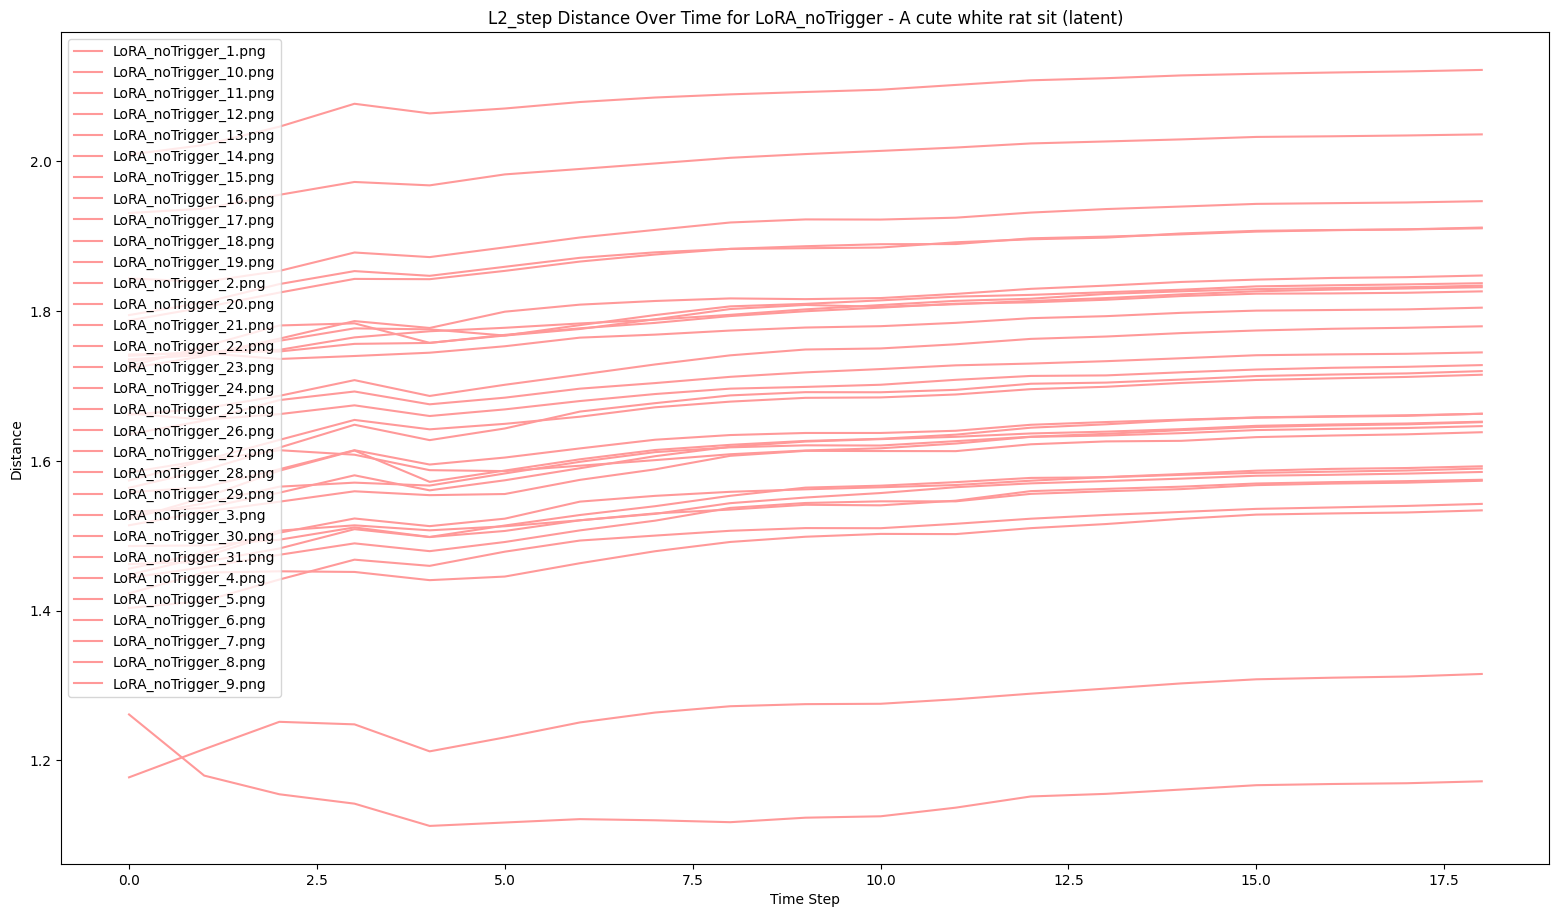

In [ ]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)
plot_distance_over_time(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time(l2_analysis_data, 'hspace', "L2_step")

In [ ]:
# 參考上面的，但每種距離個畫一張圖就好，latent 一張(裡面有每個 prefix)，image 一張(裡面有每個 prefix)，hspace 一張(裡面有每個 prefix)
# 並且每張圖上的線條(prefix)要有不同的顏色，並且要有圖例
# 並且要有標題，標題要顯示 distance_type、prefix、prompt、key
# 並且要有 x 軸標籤、y 軸標籤

def plot_distance_over_time_draw_by_distance(analysis_data, key, distance_type="L2_step"):
    colors = {'LoRA_noTrigger': '#FF9999', 'LoRA_Trigger': '#99FF99', 'noLoRA_noTrigger': '#9999FF', 'noLoRA_Trigger': '#FFCC99', 'SpaceShip': '#FFCCFF', 'ComplexImg': '#FF00FF'}
    plt.figure(figsize=(19.2, 10.8))
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            for image_name in analysis_data[prefix][prompt].keys():
                distances = analysis_data[prefix][prompt][image_name][key]
                plt.plot(range(len(distances)), distances, label=f'{prefix} - {prompt} - {image_name}', color=colors[prefix])
    plt.xlabel('Time Step')
    plt.ylabel('Distance')
    plt.title(f'{distance_type} Distance Over Time ({key})')
    plt.show()


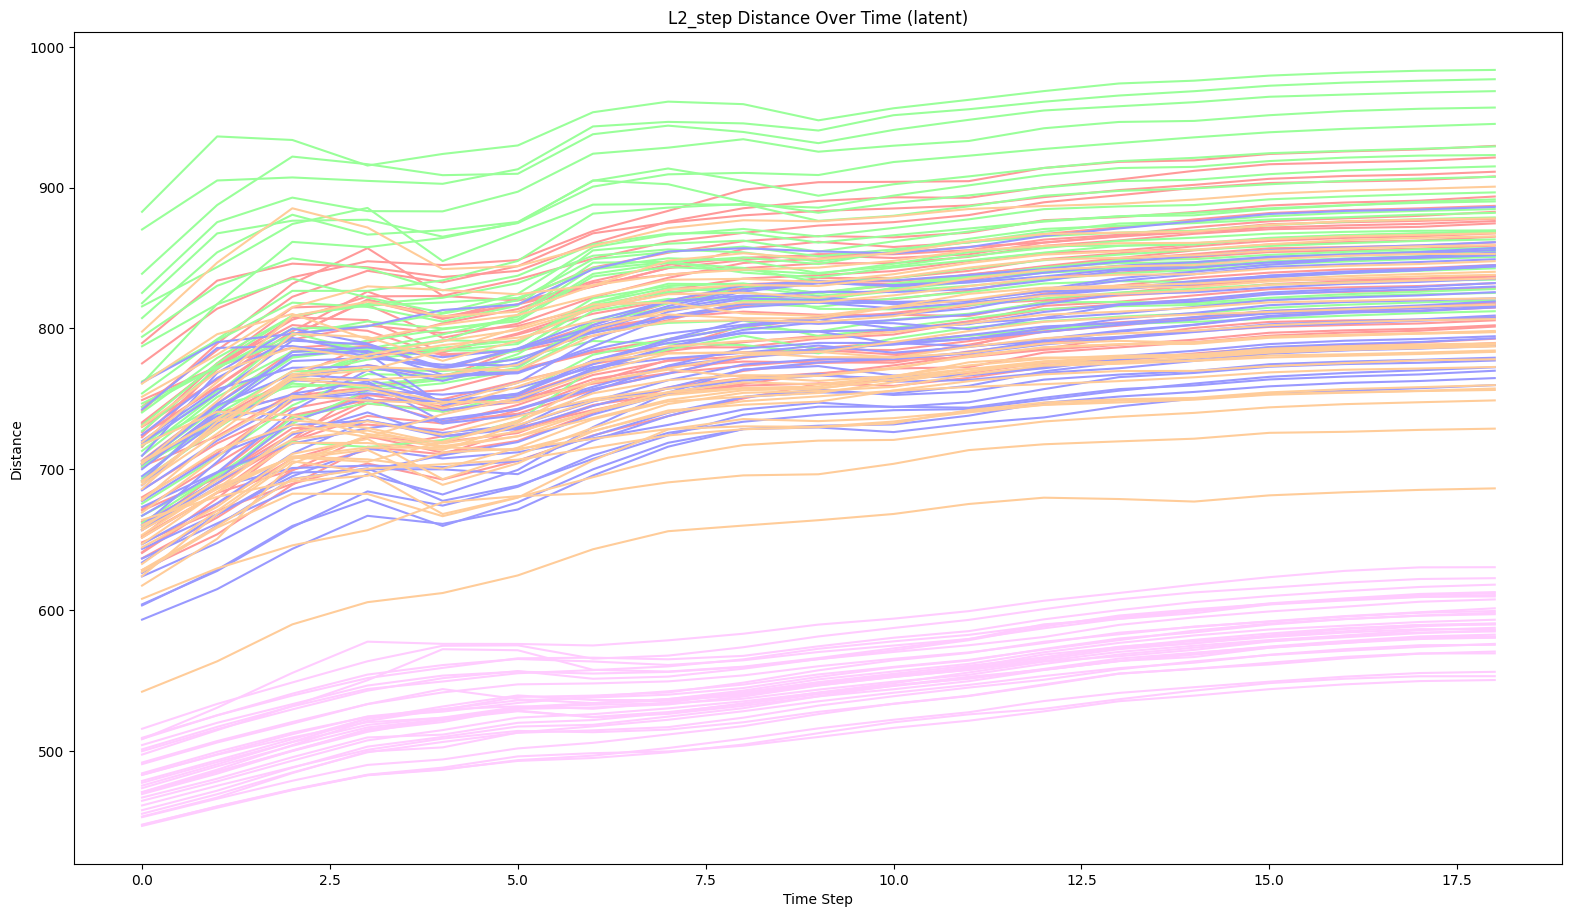

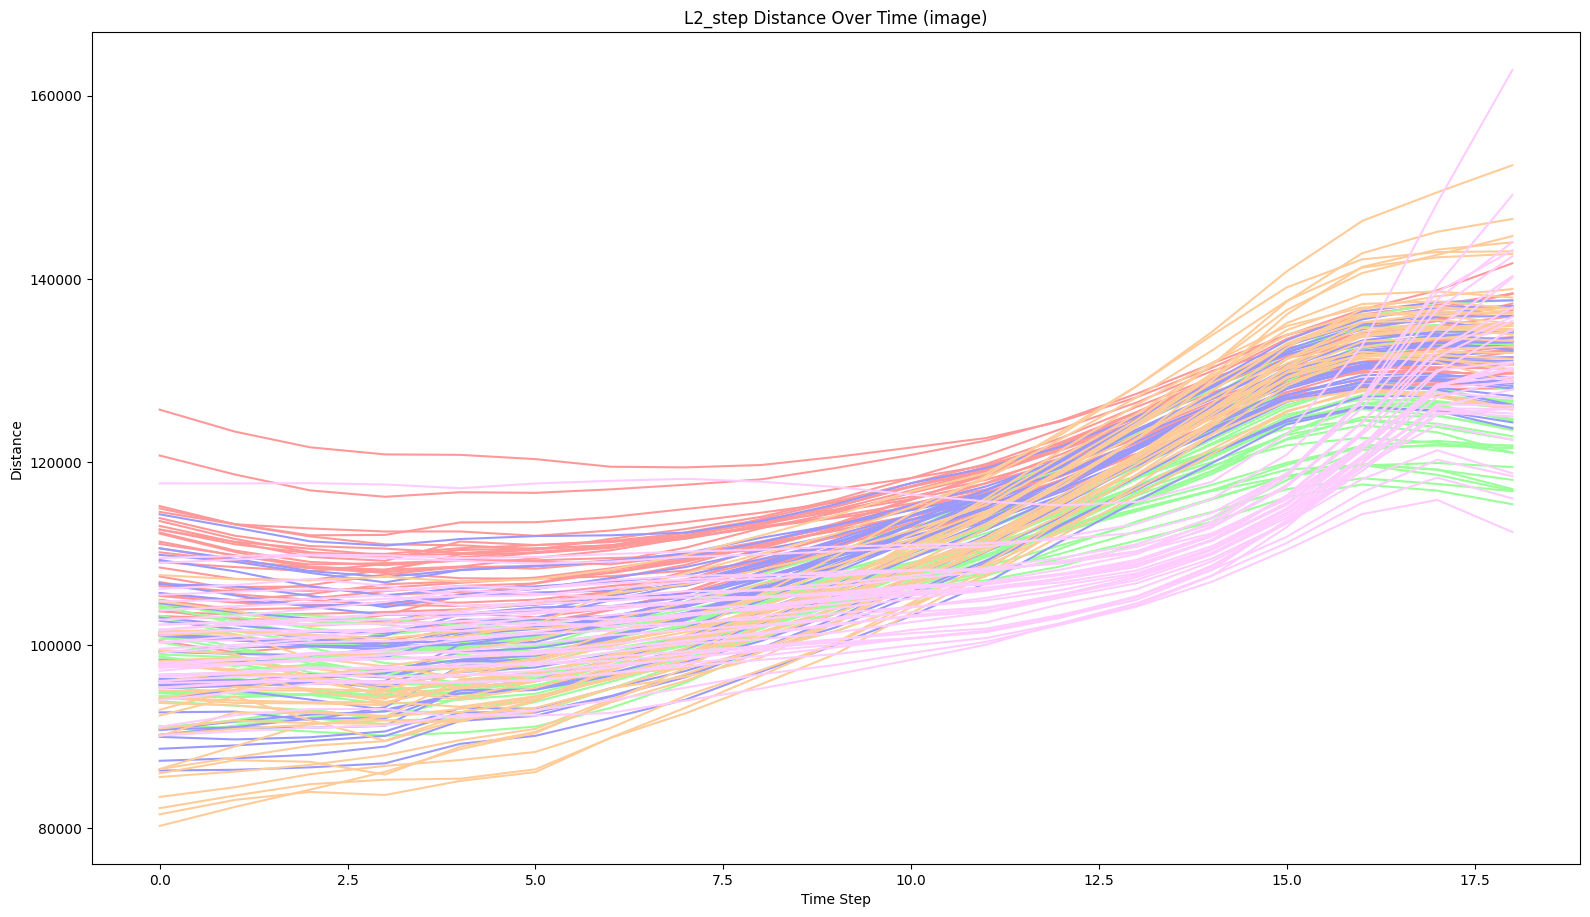

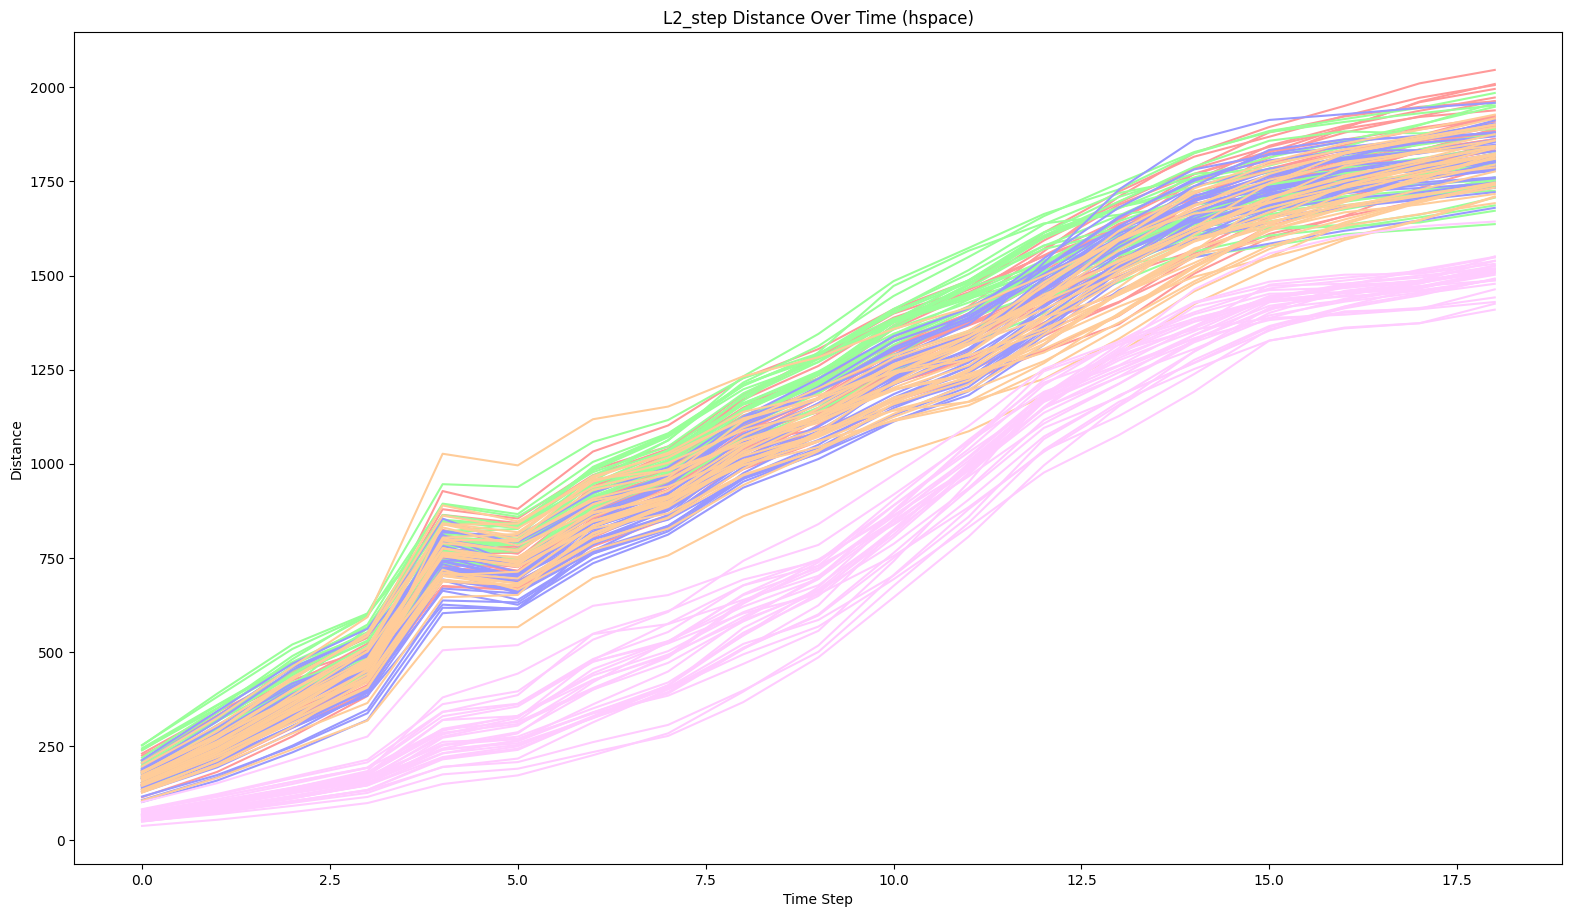

In [ ]:
# Example usage
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'latent', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'image', "L2_step")
plot_distance_over_time_draw_by_distance(l2_analysis_data, 'hspace', "L2_step")

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


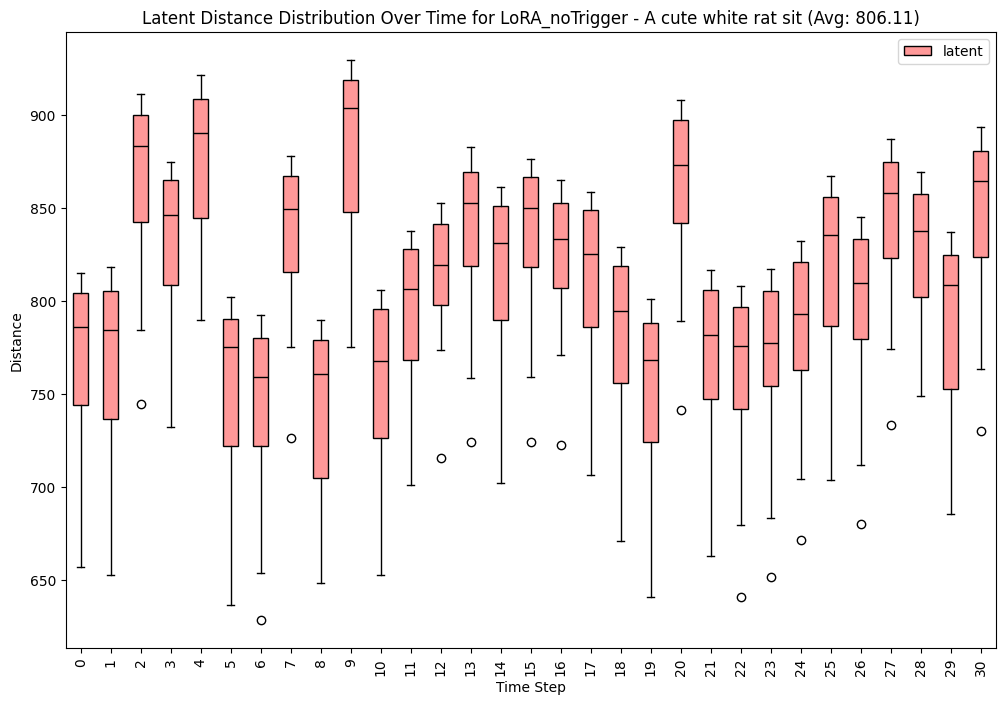

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


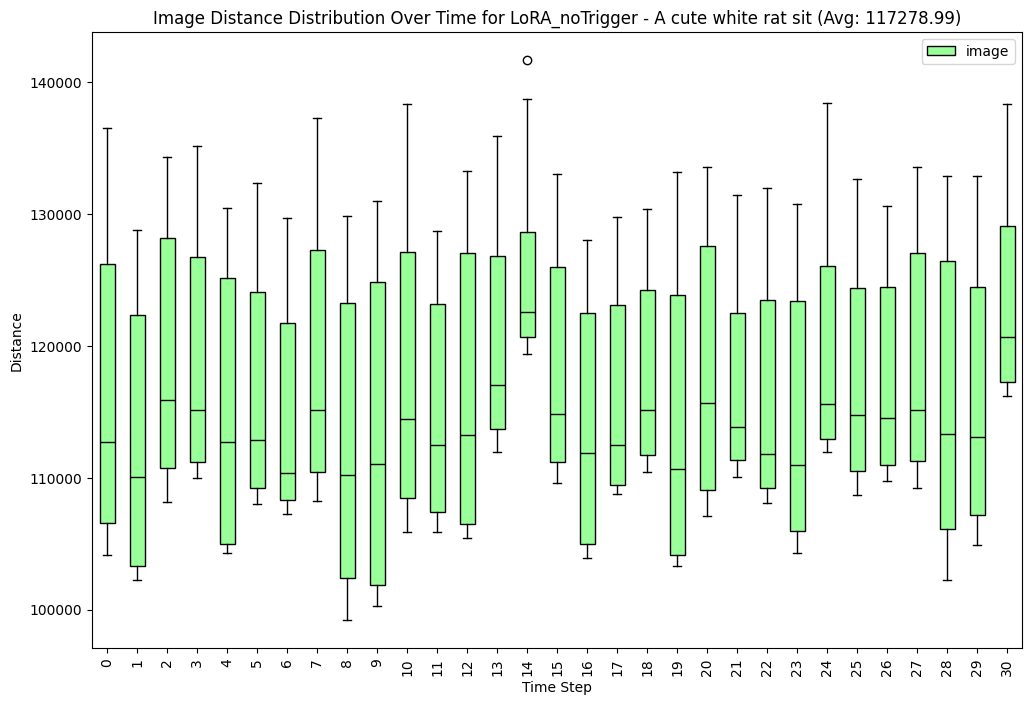

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


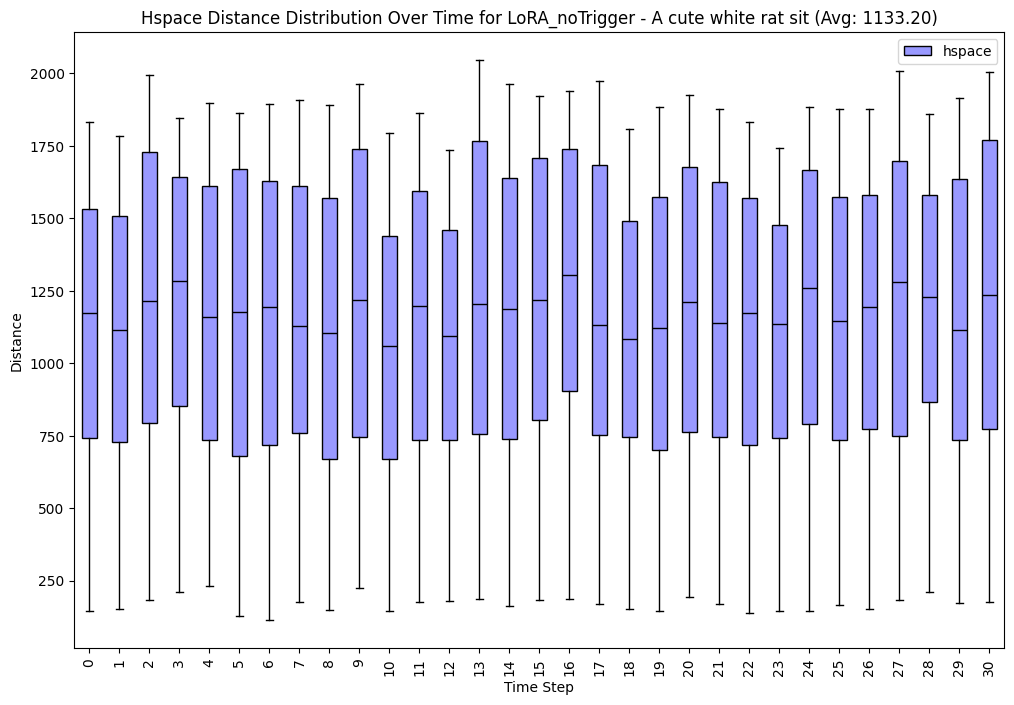

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


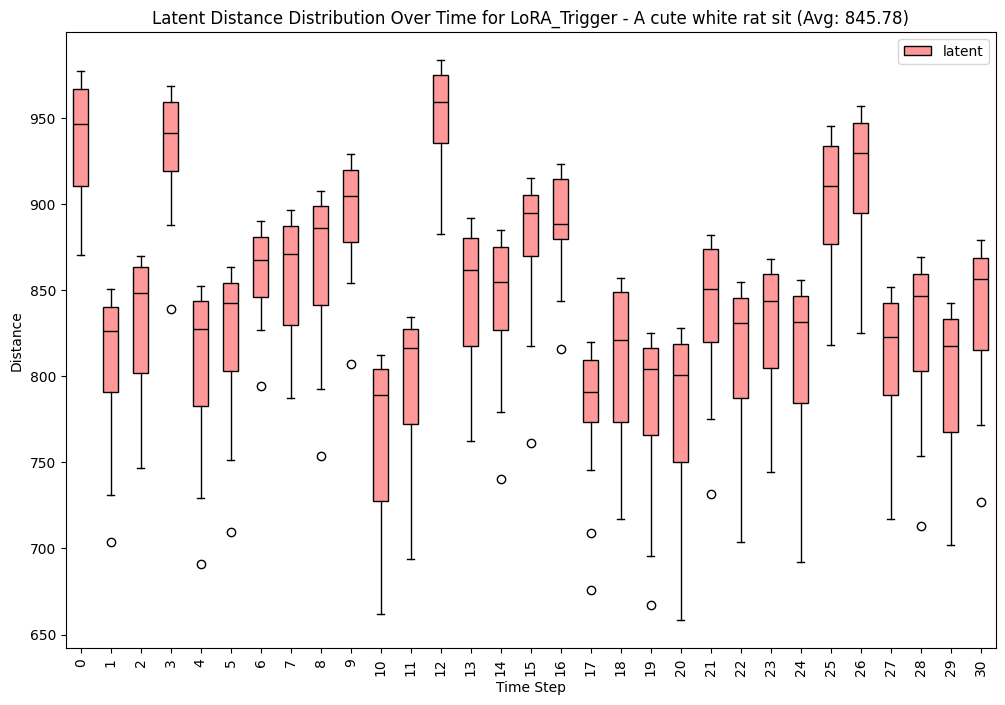

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


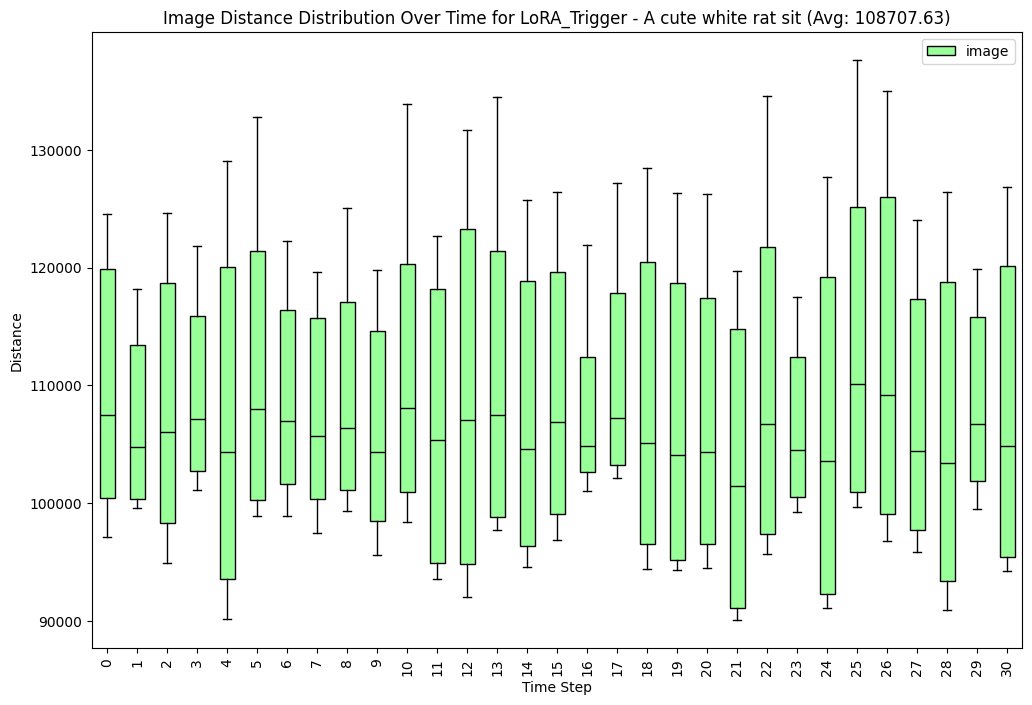

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


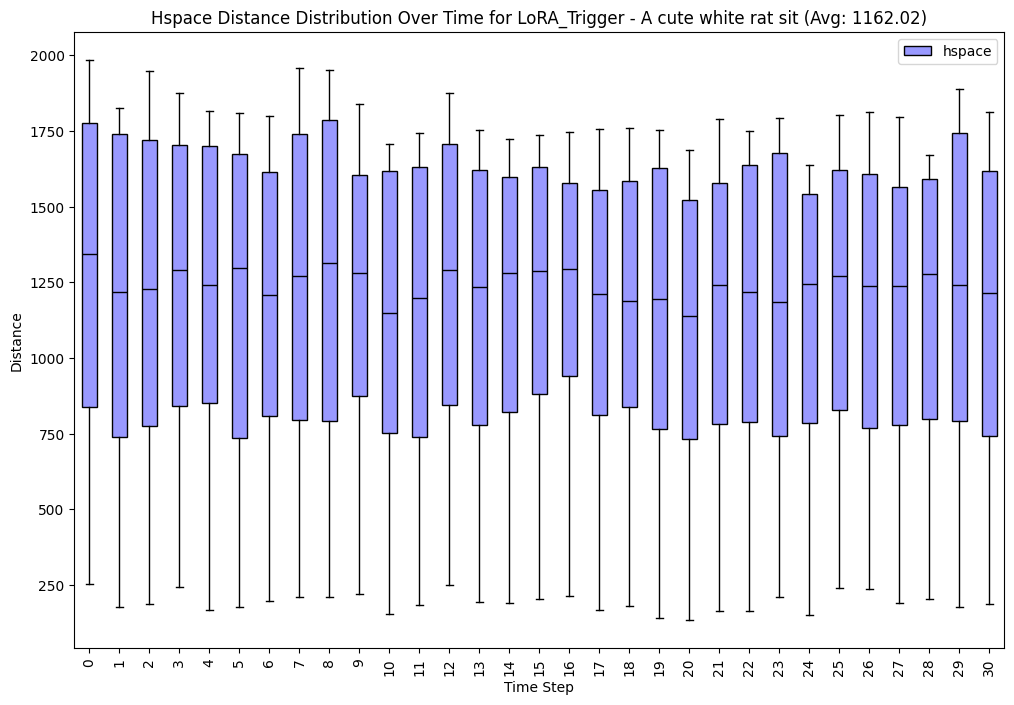

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


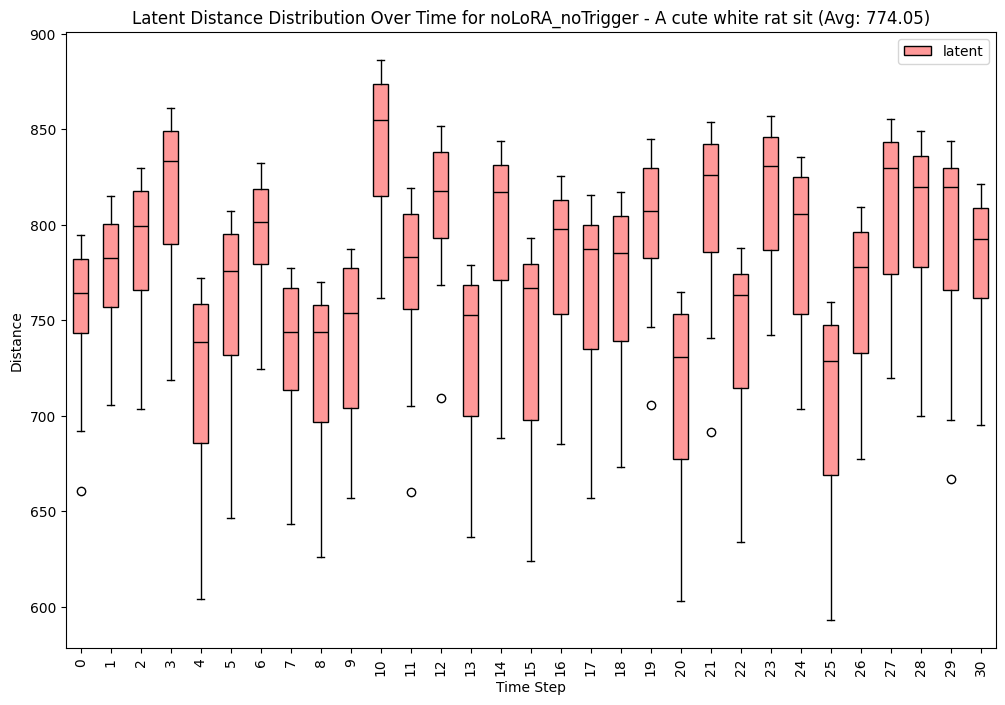

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


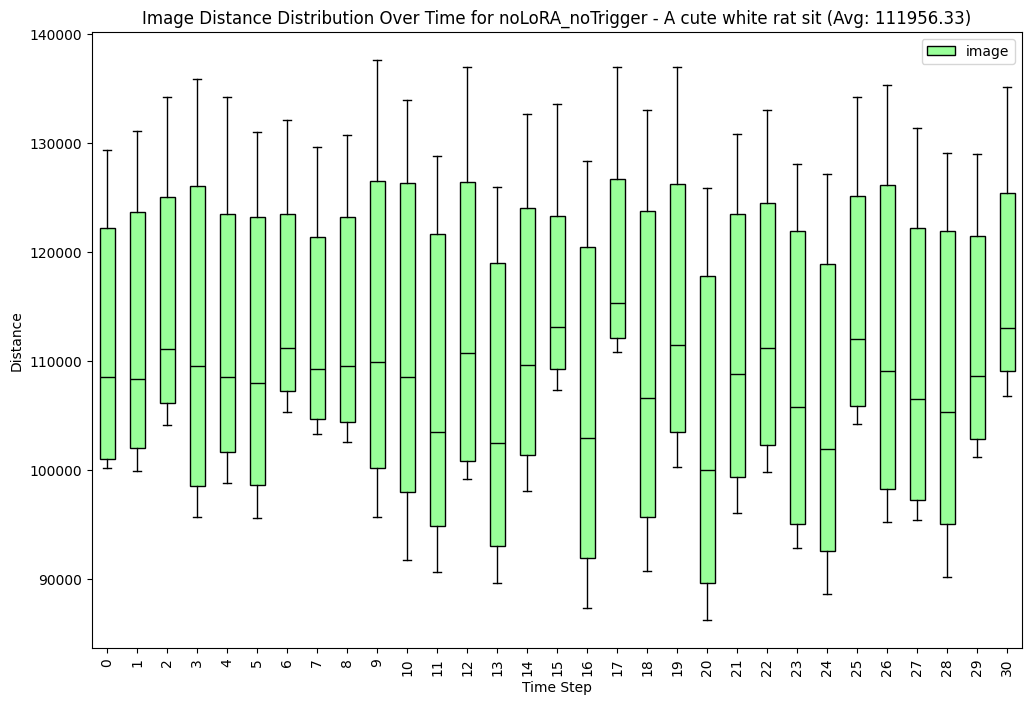

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


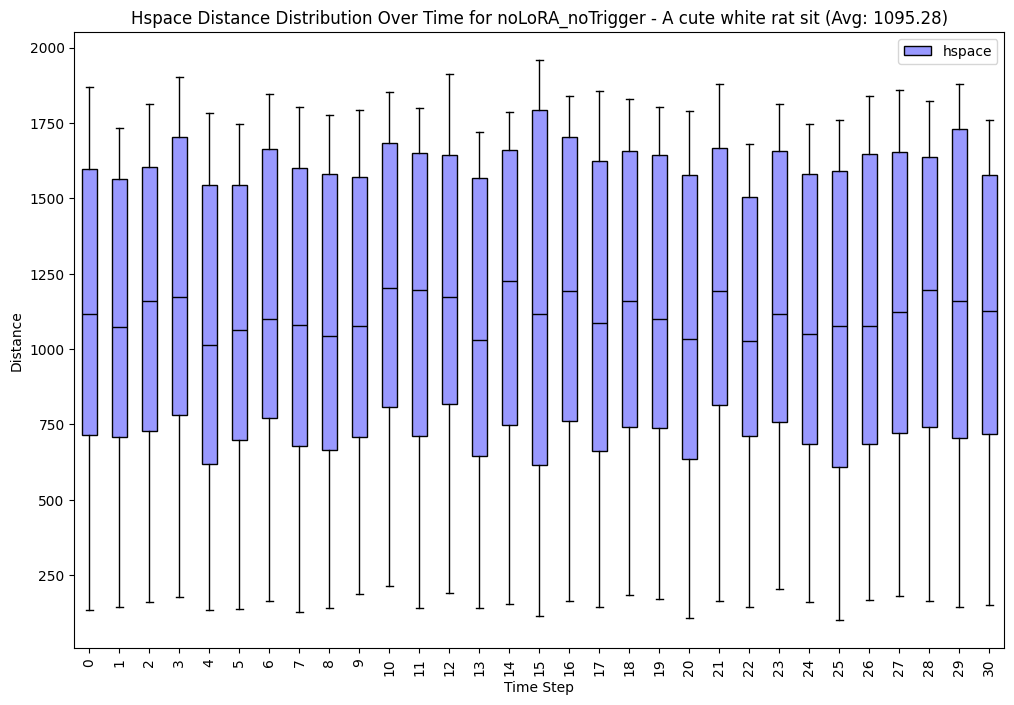

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


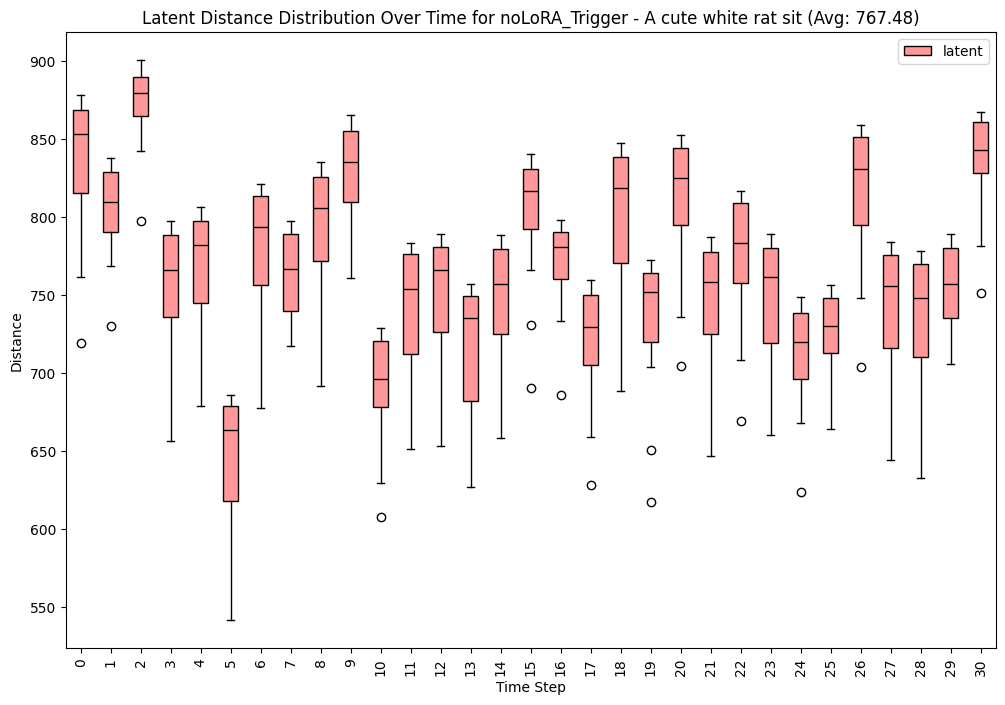

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


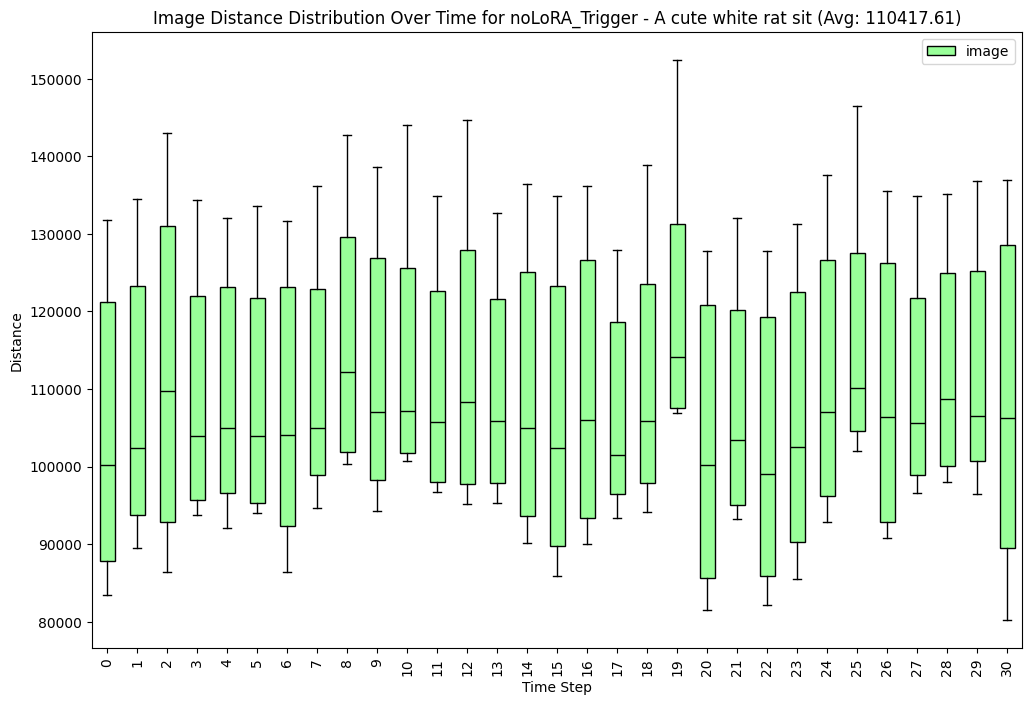

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


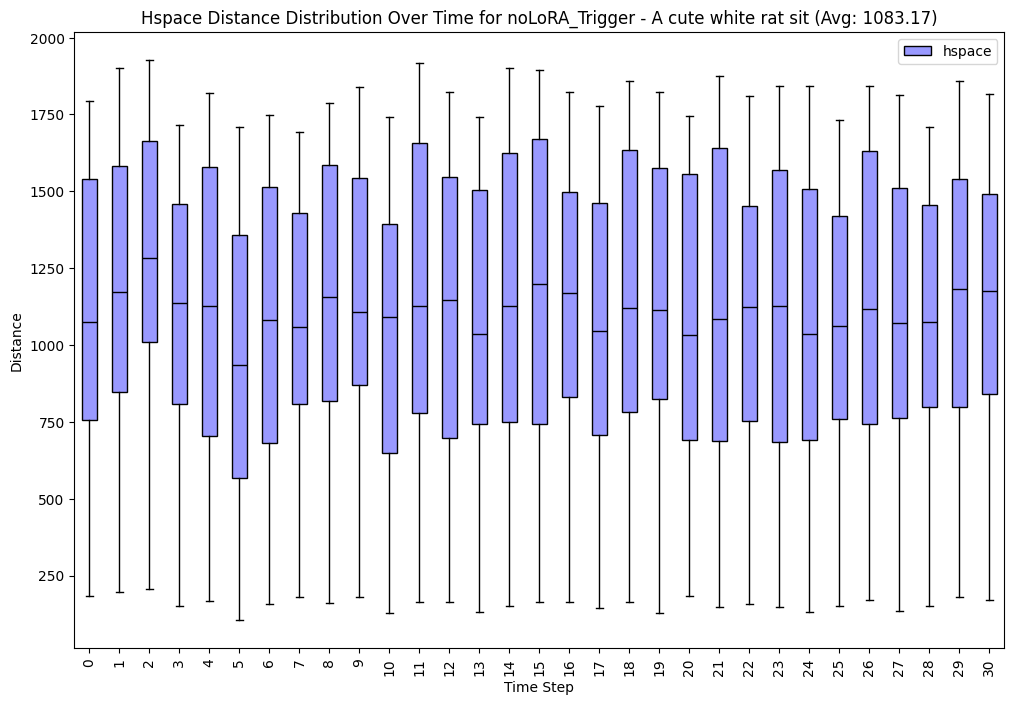

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


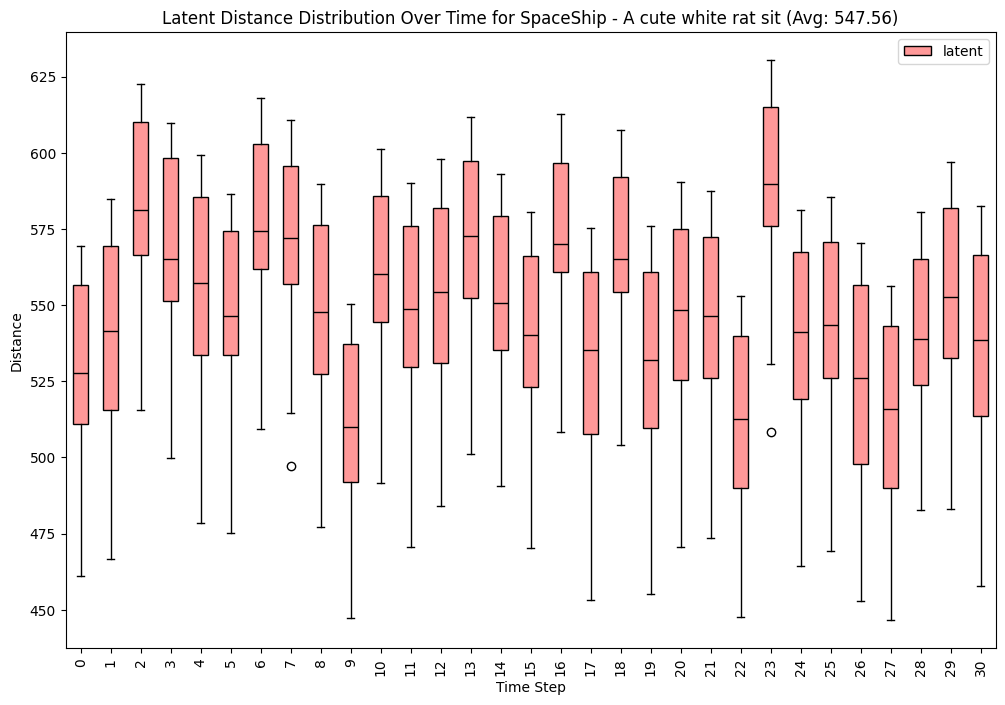

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


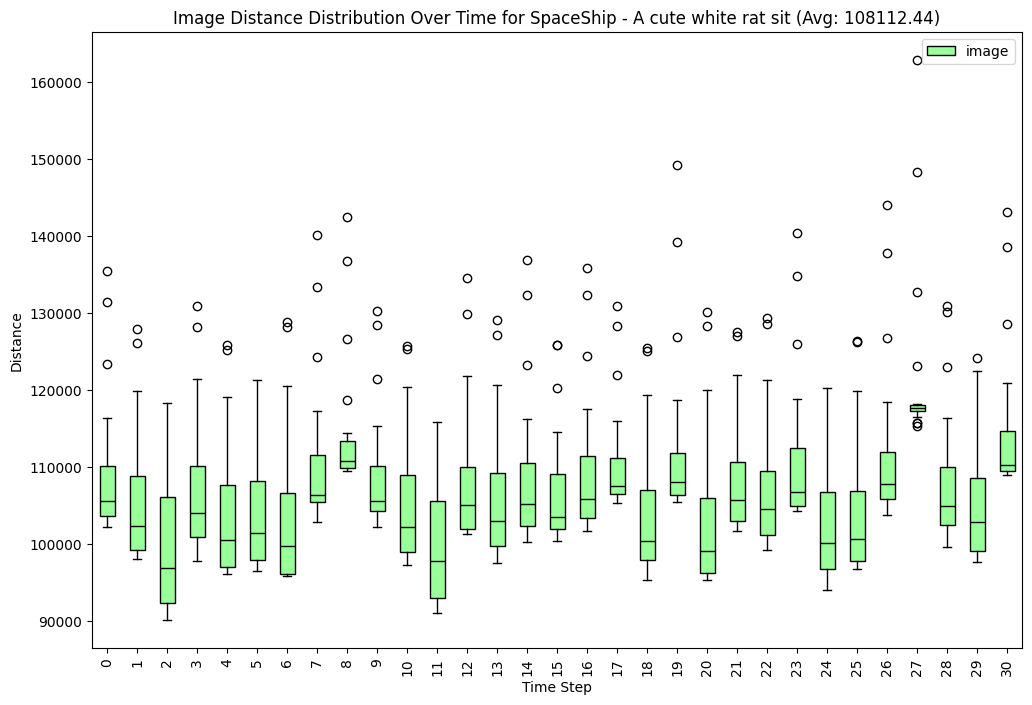

C:\Users\9373k\AppData\Local\Temp\ipykernel_17720\2277651306.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))


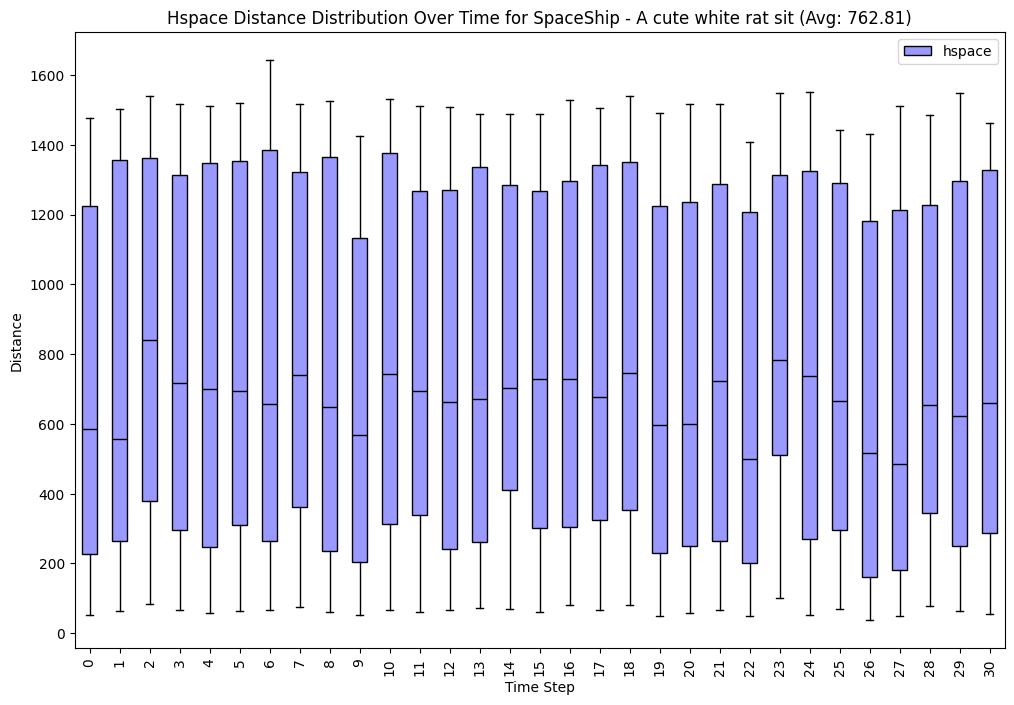

In [ ]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    colors = {'latent': '#FF9999', 'image': '#99FF99', 'hspace': '#9999FF'}
    for prefix in analysis_data.keys():
        for prompt in analysis_data[prefix].keys():
            data_to_plot = {'latent': [], 'image': [], 'hspace': []}
            for image_name in analysis_data[prefix][prompt].keys():
                for key in ["latent", "image", "hspace"]:
                    data_to_plot[key].append(analysis_data[prefix][prompt][image_name][key])
            
            for key in ["latent", "image", "hspace"]:
                plt.figure(figsize=(12, 8))
                box = plt.boxplot(data_to_plot[key], positions=range(len(data_to_plot[key])), patch_artist=True, boxprops=dict(facecolor=colors[key]), labels=range(len(data_to_plot[key])))
                avg_distance = np.mean([np.mean(data) for data in data_to_plot[key]])
                plt.ylabel('Distance')
                plt.xlabel('Time Step')
                plt.title(f'{key.capitalize()} Distance Distribution Over Time for {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                plt.xticks(rotation=90)
                plt.legend([key])
                
                # Set the average line of each box as black
                for median in box['medians']:
                    median.set_color('black')
                
                plt.show()

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)
